# Correlation analysis and visualization

There are 4 parts in this file.  
1. Calculate p-value, adjusted p-value, correlation R with clean data.
2. Overview of calculated result in volcano plot.
3. Analyze results for the key findings.
4. Use 'Colorectal' and 'Lung' as an example to visualize key findings

In [1]:
# Load packages and data, set global options.
library(tidyverse)
library(magrittr)
library(tools)
options(warn = -1)
options(repr.plot.width=12, repr.plot.height=9)
load('data/clean/rf.Rdata')
incidence = read_csv("data/clean/incidence_sexfiltered.csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Rows: 2940 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): DHB, sex, cancer, group
dbl (3): year, incidence_num, incidence_rate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `s

## 1. Calculate p-value, adjusted p-value, correlation R with clean data

In [2]:
# Perform pearson correlation analysis of each cancer and risk factor pair
# It will return a new dataframe "cor.incidence", whose columns are cancer, category, rf, cor, pvalue, p.adj.
# Given different types of category are independent of each other, adjusted p values are calculated within each category.

categories = unique(rf$category)
cancers = unique(incidence$cancer)

# create category and cancer pairs and save it in a list
pairs = crossing(categories,cancers) %>% pmap(.,list) 

#perform pearson correlation of cancer incidence and risk factor within each category
lapply(pairs,function(pair){
  
  df_cancer = incidence %>% filter(cancer == pair$cancers) # cancer data subset for specific cancer type
  df_rfs = rf %>% filter(category == pair$categories) # risk factors dataset for sepcific category
  
  
  if(pair$categories == 'Birth Number' & pair$cancer != "Breast"){ 
    return(NULL) # Birth number only map to female cancer "Breast", all others cancer return NULL
  }else if( pair$categories == 'NZHS'){ 
    df = inner_join(df_cancer,df_rfs,by=c("DHB","year","sex")) # For NZHS, common identifier is {DHB, year, sex}
  }else {
    df_cancer = df_cancer %>% select(-sex)
    df_rfs = df_rfs %>% select(-sex)
    df = inner_join(df_cancer ,df_rfs,by=c("DHB","year"))  # For other category, common identifier is {DHB, year}
  }

  df %>% 
    group_by(rf) %>% #perform correlation analysis for each risk factor
    summarise(cor = cor.test(value,incidence_rate,method = 'pearson')[4][[1]][[1]], # return Pearson correlation coefficient r
              pvalue = cor.test(value,incidence_rate,method = 'pearson')[3][[1]][[1]]) %>%  # return p value
    ungroup(.) %>%
    mutate(cancer = pair$cancers,category = pair$categories,.before = 1) %>%
    mutate(p.adj = p.adjust(pvalue, method = 'BH')) -> res # calculate adjust p value 
  return(res)
}) %>% 
  do.call(rbind,.) %>%
  mutate(sign = ifelse(cor > 0,"pos","neg"),
         group = case_when(category %in% c("Air","Earthquake","Water","Temperature") ~ "Environment",
                           TRUE ~ "Social"),
         group2 = case_when(category == "NZHS" ~ rf, # NZHS rf can not be simpily group into NZHS and thus keep the origin rf variable as group name
                            TRUE ~ category)
  ) -> cor.incidence

cor.incidence %>% head(3)

write.csv(cor.incidence,'data/correlation_result/cor_incidence.csv',row.names=F)


cancer,category,rf,cor,pvalue,p.adj,sign,group,group2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Bladder,Air quality,PM10_concentration_max,-0.006636164,0.9510699,0.9510699,neg,Social,Air quality
Bladder,Air quality,PM10_concentration_mean,0.016256859,0.8805025,0.9510699,pos,Social,Air quality
Bladder,Air quality,PM2.5_concentration_max,-0.165929574,0.1636212,0.3272424,neg,Social,Air quality


## 2. Overview of calculated result in volcano plot

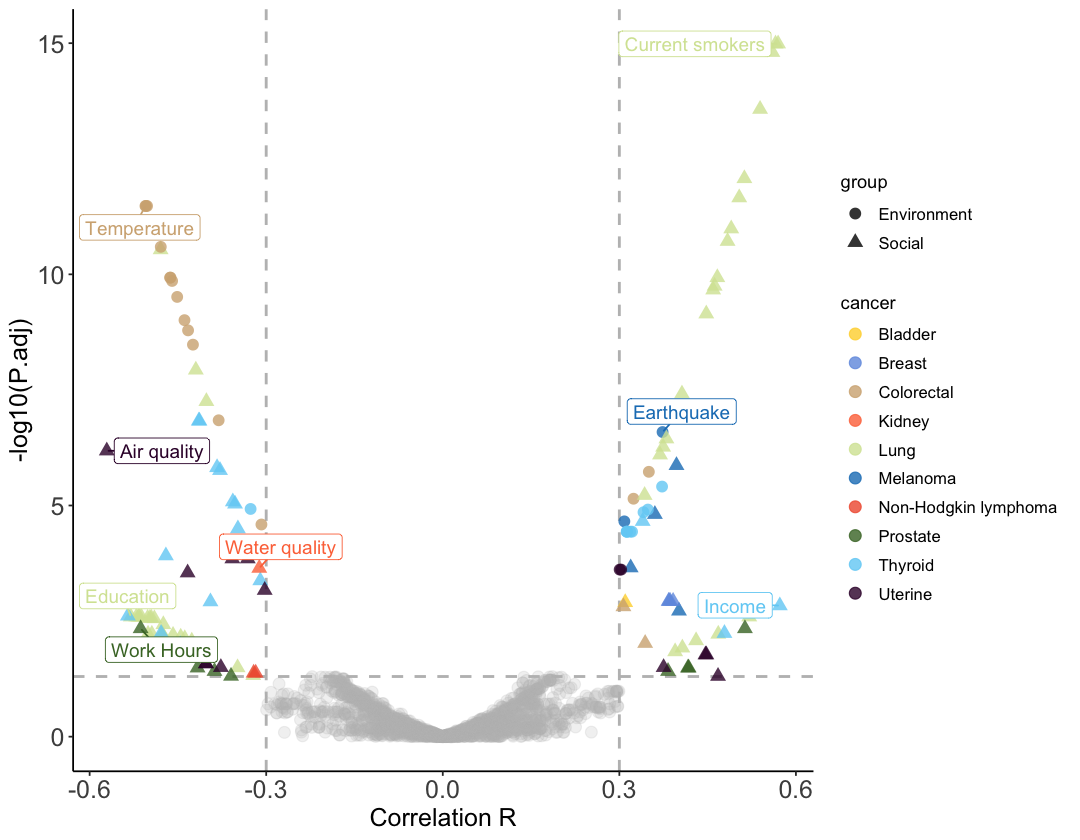

In [3]:
# We use top 5 cancers for visualization.

# filter significant result for ggplot point
sig.point <- cor.incidence %>%
  filter(p.adj < 0.05, abs(cor) >= 0.3) #significant results are defined as abs(r) >= 0.3 and p.adj < 0.05

# filter non-significant result for ggplot point
non.sig.point <- cor.incidence %>%
  filter(p.adj >= 0.05, abs(cor) < 0.3) #significant results are defined as asb(r) < 0.3 and p.adj >= 0.05#

cols = ggsci::pal_simpsons("springfield")(16)
cols = cols[-3] # remove grey color


#filter most relevant RFs for labels in ggplot
labels <- sig.point %>%
  group_by(category) %>%
  top_n(1,abs(cor))


options(repr.plot.width=9, repr.plot.height=7)
#draw volcano plot
cor.incidence %>% 
  ggplot(aes(x=cor , y=-log10(p.adj))) +
  geom_vline(xintercept = c(-0.3, 0.3), linetype = "dashed", color = "grey",size=0.8) +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "grey",size=0.8)+
  geom_point(sig.point, mapping = aes(x=cor , y=-log10(p.adj),color = cancer,shape = group), size=3, alpha=0.8) + 
  scale_color_manual(values = cols)+
  geom_point(non.sig.point,mapping = aes(x=cor , y=-log10(p.adj)),color = 'grey', size=3, alpha=0.2) + 
  ggrepel::geom_label_repel(labels,mapping = aes(x=cor , y=-log10(p.adj),color = cancer,label = group2),
                            show.legend = F,
                            min.segment.length = 0, size = 4,
                            force = 10)+
  labs(y = "-log10(P.adj)", x = "Correlation R")+
  theme_classic() +
  theme(legend.text = element_text(size = 10),
        axis.text = element_text(size = 15),
        axis.title = element_text(size = 15)
        )

## 3. Analyze results for the key findings.

In [4]:
#### Generate Tables for RFs in five most common cancer types ####
#result visualized with tables for corresponding cancer types
#Less risk factors for c("Prostate","Breast","Colorectal"), shown in a single table for these three cancers
CAs = list(c("Prostate","Breast","Colorectal"),"Lung","Melanoma") 

sig.tables <- list()
ftab <- list()


for(i in 1:length(CAs)){
  ca = CAs[[i]]
  
  #set filters of variables
  #some variables are similar, such as 'Healthy weight','Mean weight (kg)', 'Overweight or obese', these are all related to the same RF (overweight), and thus filtered for better demontration
  rf_filters=c()
  if( "Lung" %in% ca){
    rf_filters = c("Obese class 1","Obese class 2","Obese class 3",
                    "Obese",
                    'Overweight or obese',
                    'Teeth removed due to decay in past 12 months',
                    'Teeth removed due to decay in lifetime',
                    'Waist to height ratio ≥ 0.5',
                    'Mean weight (kg)',
                    'Mean waist (cm)',
                    'All teeth removed due to decay',
                    'Healthy weight',
                    'Daily smokers'
    )
  }else if("Breast" %in% ca){
    rf_filters = c('Heavy episodic drinking at least monthly (past-year drinkers)',
                    "Heavy episodic drinking at least monthly (total population)",
                    "Heavy episodic drinking at least weekly (past-year drinkers)")
  }
  
  
  sig.point %>%
    filter(!rf %in% rf_filters) %>% #filter similar variables
    filter(!(category == "Temperature" & rf != "Average_Annual")) %>% # for temperature variables, only show the annual average
    filter(cancer %in% ca ) %>% # filter by cancer types
    group_by(category,group2,cancer) %>% 
    top_n(1,abs(cor))%>% #filter the most relevant RFs based on group2 for each cancer type
    ungroup(.)%>%
    mutate(
      Cancer = cancer,
      Group = group,
      Category = category,
      temp_rf = rf,
      Correlation = case_when(sign == "pos" ~ '+',sign == "neg" ~ "-"),
      temp_rf = toTitleCase(str_replace_all(temp_rf,'_'," ")), #capitalize first character of each word in variabel
      temp_rf = str_replace_all(temp_rf,'(?<=\\().+?(?=\\))',tolower), #words within () remains lower format
    ) %>%
    select(Cancer,Correlation,Group,Category,temp_rf,cor,p.adj,rf) %>%
    arrange(factor(Cancer,levels = c("Lung","Melanoma","Breast","Prostate","Colorectal")),Correlation) %>%
    rename(r = cor,`Risk Factors` = temp_rf) -> sig.tables[[i]]
  
  sig.tables[[i]] %>%
    select(-rf) %>%
    rempsyc::nice_table(short = F,title = paste0( "Table",i+1,". Risk factors of ", paste(ca,collapse = ', '))) %>%
    flextable::line_spacing(space = 0.8) -> ftab[[i]] #Here table index starts from 2 and thus use i+1
    print(ftab[[i]])
}


a flextable object.
col_keys: `Cancer`, `Correlation`, `Group`, `Category`, `Risk Factors`, `r`, `p.adj` 
header has 2 row(s) 
body has 7 row(s) 
original dataset sample: 
      Cancer Correlation       Group    Category
1     Breast           +      Social        NZHS
2   Prostate           +      Social      Income
3   Prostate           -      Social  Work Hours
4 Colorectal           +      Social Air quality
5 Colorectal           + Environment  Earthquake
                                                Risk Factors          r
1 Heavy Episodic Drinking at Least Weekly (total population)  0.3862731
2                                                  > $10,000  0.4177455
3                                                 ≥ 10 Hours -0.5133667
4                                    PM2.5 Concentration Max  0.3438462
5                                             Magnitude Mean  0.3501052
         p.adj
1 1.171494e-03
2 3.244405e-02
3 4.581444e-03
4 9.532113e-03
5 1.867782e-06
a flextable 

#### The output table cannot be formmated correctly in Jupyter. The output should be as following tables.

<!DOCTYPE html>

<html lang="en" xml:lang="en">

<head>

<meta charset="utf-8" />
<meta name="generator" content="pandoc" />
<meta http-equiv="X-UA-Compatible" content="IE=EDGE" />

<meta name="viewport" content="width=device-width, initial-scale=1" />



<title> </title>

<script>// Pandoc 2.9 adds attributes on both header and div. We remove the former (to
// be compatible with the behavior of Pandoc < 2.8).
document.addEventListener('DOMContentLoaded', function(e) {
  var hs = document.querySelectorAll("div.section[class*='level'] > :first-child");
  var i, h, a;
  for (i = 0; i < hs.length; i++) {
    h = hs[i];
    if (!/^h[1-6]$/i.test(h.tagName)) continue;  // it should be a header h1-h6
    a = h.attributes;
    while (a.length > 0) h.removeAttribute(a[0].name);
  }
});
</script>
<style type="text/css">.hljs-literal {
color: #990073;
}
.hljs-number {
color: #099;
}
.hljs-comment {
color: #998;
font-style: italic;
}
.hljs-keyword {
color: #900;
font-weight: bold;
}
.hljs-string {
color: #d14;
}
</style>
<script src="data:application/javascript;base64,LyohIGhpZ2hsaWdodC5qcyB2OS4xMi4wIHwgQlNEMyBMaWNlbnNlIHwgZ2l0LmlvL2hsanNsaWNlbnNlICovCiFmdW5jdGlvbihlKXt2YXIgbj0ib2JqZWN0Ij09dHlwZW9mIHdpbmRvdyYmd2luZG93fHwib2JqZWN0Ij09dHlwZW9mIHNlbGYmJnNlbGY7InVuZGVmaW5lZCIhPXR5cGVvZiBleHBvcnRzP2UoZXhwb3J0cyk6biYmKG4uaGxqcz1lKHt9KSwiZnVuY3Rpb24iPT10eXBlb2YgZGVmaW5lJiZkZWZpbmUuYW1kJiZkZWZpbmUoW10sZnVuY3Rpb24oKXtyZXR1cm4gbi5obGpzfSkpfShmdW5jdGlvbihlKXtmdW5jdGlvbiBuKGUpe3JldHVybiBlLnJlcGxhY2UoLyYvZywiJmFtcDsiKS5yZXBsYWNlKC88L2csIiZsdDsiKS5yZXBsYWNlKC8+L2csIiZndDsiKX1mdW5jdGlvbiB0KGUpe3JldHVybiBlLm5vZGVOYW1lLnRvTG93ZXJDYXNlKCl9ZnVuY3Rpb24gcihlLG4pe3ZhciB0PWUmJmUuZXhlYyhuKTtyZXR1cm4gdCYmMD09PXQuaW5kZXh9ZnVuY3Rpb24gYShlKXtyZXR1cm4gay50ZXN0KGUpfWZ1bmN0aW9uIGkoZSl7dmFyIG4sdCxyLGksbz1lLmNsYXNzTmFtZSsiICI7aWYobys9ZS5wYXJlbnROb2RlP2UucGFyZW50Tm9kZS5jbGFzc05hbWU6IiIsdD1CLmV4ZWMobykpcmV0dXJuIHcodFsxXSk/dFsxXToibm8taGlnaGxpZ2h0Ijtmb3Iobz1vLnNwbGl0KC9ccysvKSxuPTAscj1vLmxlbmd0aDtyPm47bisrKWlmKGk9b1tuXSxhKGkpfHx3KGkpKXJldHVybiBpfWZ1bmN0aW9uIG8oZSl7dmFyIG4sdD17fSxyPUFycmF5LnByb3RvdHlwZS5zbGljZS5jYWxsKGFyZ3VtZW50cywxKTtmb3IobiBpbiBlKXRbbl09ZVtuXTtyZXR1cm4gci5mb3JFYWNoKGZ1bmN0aW9uKGUpe2ZvcihuIGluIGUpdFtuXT1lW25dfSksdH1mdW5jdGlvbiB1KGUpe3ZhciBuPVtdO3JldHVybiBmdW5jdGlvbiByKGUsYSl7Zm9yKHZhciBpPWUuZmlyc3RDaGlsZDtpO2k9aS5uZXh0U2libGluZykzPT09aS5ub2RlVHlwZT9hKz1pLm5vZGVWYWx1ZS5sZW5ndGg6MT09PWkubm9kZVR5cGUmJihuLnB1c2goe2V2ZW50OiJzdGFydCIsb2Zmc2V0OmEsbm9kZTppfSksYT1yKGksYSksdChpKS5tYXRjaCgvYnJ8aHJ8aW1nfGlucHV0Lyl8fG4ucHVzaCh7ZXZlbnQ6InN0b3AiLG9mZnNldDphLG5vZGU6aX0pKTtyZXR1cm4gYX0oZSwwKSxufWZ1bmN0aW9uIGMoZSxyLGEpe2Z1bmN0aW9uIGkoKXtyZXR1cm4gZS5sZW5ndGgmJnIubGVuZ3RoP2VbMF0ub2Zmc2V0IT09clswXS5vZmZzZXQ/ZVswXS5vZmZzZXQ8clswXS5vZmZzZXQ/ZTpyOiJzdGFydCI9PT1yWzBdLmV2ZW50P2U6cjplLmxlbmd0aD9lOnJ9ZnVuY3Rpb24gbyhlKXtmdW5jdGlvbiByKGUpe3JldHVybiIgIitlLm5vZGVOYW1lKyc9IicrbihlLnZhbHVlKS5yZXBsYWNlKCciJywiJnF1b3Q7IikrJyInfXMrPSI8Iit0KGUpK0UubWFwLmNhbGwoZS5hdHRyaWJ1dGVzLHIpLmpvaW4oIiIpKyI+In1mdW5jdGlvbiB1KGUpe3MrPSI8LyIrdChlKSsiPiJ9ZnVuY3Rpb24gYyhlKXsoInN0YXJ0Ij09PWUuZXZlbnQ/bzp1KShlLm5vZGUpfWZvcih2YXIgbD0wLHM9IiIsZj1bXTtlLmxlbmd0aHx8ci5sZW5ndGg7KXt2YXIgZz1pKCk7aWYocys9bihhLnN1YnN0cmluZyhsLGdbMF0ub2Zmc2V0KSksbD1nWzBdLm9mZnNldCxnPT09ZSl7Zi5yZXZlcnNlKCkuZm9yRWFjaCh1KTtkbyBjKGcuc3BsaWNlKDAsMSlbMF0pLGc9aSgpO3doaWxlKGc9PT1lJiZnLmxlbmd0aCYmZ1swXS5vZmZzZXQ9PT1sKTtmLnJldmVyc2UoKS5mb3JFYWNoKG8pfWVsc2Uic3RhcnQiPT09Z1swXS5ldmVudD9mLnB1c2goZ1swXS5ub2RlKTpmLnBvcCgpLGMoZy5zcGxpY2UoMCwxKVswXSl9cmV0dXJuIHMrbihhLnN1YnN0cihsKSl9ZnVuY3Rpb24gbChlKXtyZXR1cm4gZS52JiYhZS5jYWNoZWRfdmFyaWFudHMmJihlLmNhY2hlZF92YXJpYW50cz1lLnYubWFwKGZ1bmN0aW9uKG4pe3JldHVybiBvKGUse3Y6bnVsbH0sbil9KSksZS5jYWNoZWRfdmFyaWFudHN8fGUuZVcmJltvKGUpXXx8W2VdfWZ1bmN0aW9uIHMoZSl7ZnVuY3Rpb24gbihlKXtyZXR1cm4gZSYmZS5zb3VyY2V8fGV9ZnVuY3Rpb24gdCh0LHIpe3JldHVybiBuZXcgUmVnRXhwKG4odCksIm0iKyhlLmNJPyJpIjoiIikrKHI/ImciOiIiKSl9ZnVuY3Rpb24gcihhLGkpe2lmKCFhLmNvbXBpbGVkKXtpZihhLmNvbXBpbGVkPSEwLGEuaz1hLmt8fGEuYkssYS5rKXt2YXIgbz17fSx1PWZ1bmN0aW9uKG4sdCl7ZS5jSSYmKHQ9dC50b0xvd2VyQ2FzZSgpKSx0LnNwbGl0KCIgIikuZm9yRWFjaChmdW5jdGlvbihlKXt2YXIgdD1lLnNwbGl0KCJ8Iik7b1t0WzBdXT1bbix0WzFdP051bWJlcih0WzFdKToxXX0pfTsic3RyaW5nIj09dHlwZW9mIGEuaz91KCJrZXl3b3JkIixhLmspOngoYS5rKS5mb3JFYWNoKGZ1bmN0aW9uKGUpe3UoZSxhLmtbZV0pfSksYS5rPW99YS5sUj10KGEubHx8L1x3Ky8sITApLGkmJihhLmJLJiYoYS5iPSJcXGIoIithLmJLLnNwbGl0KCIgIikuam9pbigifCIpKyIpXFxiIiksYS5ifHwoYS5iPS9cQnxcYi8pLGEuYlI9dChhLmIpLGEuZXx8YS5lV3x8KGEuZT0vXEJ8XGIvKSxhLmUmJihhLmVSPXQoYS5lKSksYS50RT1uKGEuZSl8fCIiLGEuZVcmJmkudEUmJihhLnRFKz0oYS5lPyJ8IjoiIikraS50RSkpLGEuaSYmKGEuaVI9dChhLmkpKSxudWxsPT1hLnImJihhLnI9MSksYS5jfHwoYS5jPVtdKSxhLmM9QXJyYXkucHJvdG90eXBlLmNvbmNhdC5hcHBseShbXSxhLmMubWFwKGZ1bmN0aW9uKGUpe3JldHVybiBsKCJzZWxmIj09PWU/YTplKX0pKSxhLmMuZm9yRWFjaChmdW5jdGlvbihlKXtyKGUsYSl9KSxhLnN0YXJ0cyYmcihhLnN0YXJ0cyxpKTt2YXIgYz1hLmMubWFwKGZ1bmN0aW9uKGUpe3JldHVybiBlLmJLPyJcXC4/KCIrZS5iKyIpXFwuPyI6ZS5ifSkuY29uY2F0KFthLnRFLGEuaV0pLm1hcChuKS5maWx0ZXIoQm9vbGVhbik7YS50PWMubGVuZ3RoP3QoYy5qb2luKCJ8IiksITApOntleGVjOmZ1bmN0aW9uKCl7cmV0dXJuIG51bGx9fX19cihlKX1mdW5jdGlvbiBmKGUsdCxhLGkpe2Z1bmN0aW9uIG8oZSxuKXt2YXIgdCxhO2Zvcih0PTAsYT1uLmMubGVuZ3RoO2E+dDt0KyspaWYocihuLmNbdF0uYlIsZSkpcmV0dXJuIG4uY1t0XX1mdW5jdGlvbiB1KGUsbil7aWYocihlLmVSLG4pKXtmb3IoO2UuZW5kc1BhcmVudCYmZS5wYXJlbnQ7KWU9ZS5wYXJlbnQ7cmV0dXJuIGV9cmV0dXJuIGUuZVc/dShlLnBhcmVudCxuKTp2b2lkIDB9ZnVuY3Rpb24gYyhlLG4pe3JldHVybiFhJiZyKG4uaVIsZSl9ZnVuY3Rpb24gbChlLG4pe3ZhciB0PU4uY0k/blswXS50b0xvd2VyQ2FzZSgpOm5bMF07cmV0dXJuIGUuay5oYXNPd25Qcm9wZXJ0eSh0KSYmZS5rW3RdfWZ1bmN0aW9uIHAoZSxuLHQscil7dmFyIGE9cj8iIjpJLmNsYXNzUHJlZml4LGk9JzxzcGFuIGNsYXNzPSInK2Esbz10PyIiOkM7cmV0dXJuIGkrPWUrJyI+JyxpK24rb31mdW5jdGlvbiBoKCl7dmFyIGUsdCxyLGE7aWYoIUUuaylyZXR1cm4gbihrKTtmb3IoYT0iIix0PTAsRS5sUi5sYXN0SW5kZXg9MCxyPUUubFIuZXhlYyhrKTtyOylhKz1uKGsuc3Vic3RyaW5nKHQsci5pbmRleCkpLGU9bChFLHIpLGU/KEIrPWVbMV0sYSs9cChlWzBdLG4oclswXSkpKTphKz1uKHJbMF0pLHQ9RS5sUi5sYXN0SW5kZXgscj1FLmxSLmV4ZWMoayk7cmV0dXJuIGErbihrLnN1YnN0cih0KSl9ZnVuY3Rpb24gZCgpe3ZhciBlPSJzdHJpbmciPT10eXBlb2YgRS5zTDtpZihlJiYheVtFLnNMXSlyZXR1cm4gbihrKTt2YXIgdD1lP2YoRS5zTCxrLCEwLHhbRS5zTF0pOmcoayxFLnNMLmxlbmd0aD9FLnNMOnZvaWQgMCk7cmV0dXJuIEUucj4wJiYoQis9dC5yKSxlJiYoeFtFLnNMXT10LnRvcCkscCh0Lmxhbmd1YWdlLHQudmFsdWUsITEsITApfWZ1bmN0aW9uIGIoKXtMKz1udWxsIT1FLnNMP2QoKTpoKCksaz0iIn1mdW5jdGlvbiB2KGUpe0wrPWUuY04/cChlLmNOLCIiLCEwKToiIixFPU9iamVjdC5jcmVhdGUoZSx7cGFyZW50Ont2YWx1ZTpFfX0pfWZ1bmN0aW9uIG0oZSxuKXtpZihrKz1lLG51bGw9PW4pcmV0dXJuIGIoKSwwO3ZhciB0PW8obixFKTtpZih0KXJldHVybiB0LnNraXA/ays9bjoodC5lQiYmKGsrPW4pLGIoKSx0LnJCfHx0LmVCfHwoaz1uKSksdih0LG4pLHQuckI/MDpuLmxlbmd0aDt2YXIgcj11KEUsbik7aWYocil7dmFyIGE9RTthLnNraXA/ays9bjooYS5yRXx8YS5lRXx8KGsrPW4pLGIoKSxhLmVFJiYoaz1uKSk7ZG8gRS5jTiYmKEwrPUMpLEUuc2tpcHx8KEIrPUUuciksRT1FLnBhcmVudDt3aGlsZShFIT09ci5wYXJlbnQpO3JldHVybiByLnN0YXJ0cyYmdihyLnN0YXJ0cywiIiksYS5yRT8wOm4ubGVuZ3RofWlmKGMobixFKSl0aHJvdyBuZXcgRXJyb3IoJ0lsbGVnYWwgbGV4ZW1lICInK24rJyIgZm9yIG1vZGUgIicrKEUuY058fCI8dW5uYW1lZD4iKSsnIicpO3JldHVybiBrKz1uLG4ubGVuZ3RofHwxfXZhciBOPXcoZSk7aWYoIU4pdGhyb3cgbmV3IEVycm9yKCdVbmtub3duIGxhbmd1YWdlOiAiJytlKyciJyk7cyhOKTt2YXIgUixFPWl8fE4seD17fSxMPSIiO2ZvcihSPUU7UiE9PU47Uj1SLnBhcmVudClSLmNOJiYoTD1wKFIuY04sIiIsITApK0wpO3ZhciBrPSIiLEI9MDt0cnl7Zm9yKHZhciBNLGosTz0wOzspe2lmKEUudC5sYXN0SW5kZXg9TyxNPUUudC5leGVjKHQpLCFNKWJyZWFrO2o9bSh0LnN1YnN0cmluZyhPLE0uaW5kZXgpLE1bMF0pLE89TS5pbmRleCtqfWZvcihtKHQuc3Vic3RyKE8pKSxSPUU7Ui5wYXJlbnQ7Uj1SLnBhcmVudClSLmNOJiYoTCs9Qyk7cmV0dXJue3I6Qix2YWx1ZTpMLGxhbmd1YWdlOmUsdG9wOkV9fWNhdGNoKFQpe2lmKFQubWVzc2FnZSYmLTEhPT1ULm1lc3NhZ2UuaW5kZXhPZigiSWxsZWdhbCIpKXJldHVybntyOjAsdmFsdWU6bih0KX07dGhyb3cgVH19ZnVuY3Rpb24gZyhlLHQpe3Q9dHx8SS5sYW5ndWFnZXN8fHgoeSk7dmFyIHI9e3I6MCx2YWx1ZTpuKGUpfSxhPXI7cmV0dXJuIHQuZmlsdGVyKHcpLmZvckVhY2goZnVuY3Rpb24obil7dmFyIHQ9ZihuLGUsITEpO3QubGFuZ3VhZ2U9bix0LnI+YS5yJiYoYT10KSx0LnI+ci5yJiYoYT1yLHI9dCl9KSxhLmxhbmd1YWdlJiYoci5zZWNvbmRfYmVzdD1hKSxyfWZ1bmN0aW9uIHAoZSl7cmV0dXJuIEkudGFiUmVwbGFjZXx8SS51c2VCUj9lLnJlcGxhY2UoTSxmdW5jdGlvbihlLG4pe3JldHVybiBJLnVzZUJSJiYiXG4iPT09ZT8iPGJyPiI6SS50YWJSZXBsYWNlP24ucmVwbGFjZSgvXHQvZyxJLnRhYlJlcGxhY2UpOiIifSk6ZX1mdW5jdGlvbiBoKGUsbix0KXt2YXIgcj1uP0xbbl06dCxhPVtlLnRyaW0oKV07cmV0dXJuIGUubWF0Y2goL1xiaGxqc1xiLyl8fGEucHVzaCgiaGxqcyIpLC0xPT09ZS5pbmRleE9mKHIpJiZhLnB1c2gociksYS5qb2luKCIgIikudHJpbSgpfWZ1bmN0aW9uIGQoZSl7dmFyIG4sdCxyLG8sbCxzPWkoZSk7YShzKXx8KEkudXNlQlI/KG49ZG9jdW1lbnQuY3JlYXRlRWxlbWVudE5TKCJodHRwOi8vd3d3LnczLm9yZy8xOTk5L3hodG1sIiwiZGl2Iiksbi5pbm5lckhUTUw9ZS5pbm5lckhUTUwucmVwbGFjZSgvXG4vZywiIikucmVwbGFjZSgvPGJyWyBcL10qPi9nLCJcbiIpKTpuPWUsbD1uLnRleHRDb250ZW50LHI9cz9mKHMsbCwhMCk6ZyhsKSx0PXUobiksdC5sZW5ndGgmJihvPWRvY3VtZW50LmNyZWF0ZUVsZW1lbnROUygiaHR0cDovL3d3dy53My5vcmcvMTk5OS94aHRtbCIsImRpdiIpLG8uaW5uZXJIVE1MPXIudmFsdWUsci52YWx1ZT1jKHQsdShvKSxsKSksci52YWx1ZT1wKHIudmFsdWUpLGUuaW5uZXJIVE1MPXIudmFsdWUsZS5jbGFzc05hbWU9aChlLmNsYXNzTmFtZSxzLHIubGFuZ3VhZ2UpLGUucmVzdWx0PXtsYW5ndWFnZTpyLmxhbmd1YWdlLHJlOnIucn0sci5zZWNvbmRfYmVzdCYmKGUuc2Vjb25kX2Jlc3Q9e2xhbmd1YWdlOnIuc2Vjb25kX2Jlc3QubGFuZ3VhZ2UscmU6ci5zZWNvbmRfYmVzdC5yfSkpfWZ1bmN0aW9uIGIoZSl7ST1vKEksZSl9ZnVuY3Rpb24gdigpe2lmKCF2LmNhbGxlZCl7di5jYWxsZWQ9ITA7dmFyIGU9ZG9jdW1lbnQucXVlcnlTZWxlY3RvckFsbCgicHJlIGNvZGUiKTtFLmZvckVhY2guY2FsbChlLGQpfX1mdW5jdGlvbiBtKCl7YWRkRXZlbnRMaXN0ZW5lcigiRE9NQ29udGVudExvYWRlZCIsdiwhMSksYWRkRXZlbnRMaXN0ZW5lcigibG9hZCIsdiwhMSl9ZnVuY3Rpb24gTihuLHQpe3ZhciByPXlbbl09dChlKTtyLmFsaWFzZXMmJnIuYWxpYXNlcy5mb3JFYWNoKGZ1bmN0aW9uKGUpe0xbZV09bn0pfWZ1bmN0aW9uIFIoKXtyZXR1cm4geCh5KX1mdW5jdGlvbiB3KGUpe3JldHVybiBlPShlfHwiIikudG9Mb3dlckNhc2UoKSx5W2VdfHx5W0xbZV1dfXZhciBFPVtdLHg9T2JqZWN0LmtleXMseT17fSxMPXt9LGs9L14obm8tP2hpZ2hsaWdodHxwbGFpbnx0ZXh0KSQvaSxCPS9cYmxhbmcoPzp1YWdlKT8tKFtcdy1dKylcYi9pLE09LygoXig8W14+XSs+fFx0fCkrfCg/OlxuKSkpL2dtLEM9Ijwvc3Bhbj4iLEk9e2NsYXNzUHJlZml4OiJobGpzLSIsdGFiUmVwbGFjZTpudWxsLHVzZUJSOiExLGxhbmd1YWdlczp2b2lkIDB9O3JldHVybiBlLmhpZ2hsaWdodD1mLGUuaGlnaGxpZ2h0QXV0bz1nLGUuZml4TWFya3VwPXAsZS5oaWdobGlnaHRCbG9jaz1kLGUuY29uZmlndXJlPWIsZS5pbml0SGlnaGxpZ2h0aW5nPXYsZS5pbml0SGlnaGxpZ2h0aW5nT25Mb2FkPW0sZS5yZWdpc3Rlckxhbmd1YWdlPU4sZS5saXN0TGFuZ3VhZ2VzPVIsZS5nZXRMYW5ndWFnZT13LGUuaW5oZXJpdD1vLGUuSVI9IlthLXpBLVpdXFx3KiIsZS5VSVI9IlthLXpBLVpfXVxcdyoiLGUuTlI9IlxcYlxcZCsoXFwuXFxkKyk/IixlLkNOUj0iKC0/KShcXGIwW3hYXVthLWZBLUYwLTldK3woXFxiXFxkKyhcXC5cXGQqKT98XFwuXFxkKykoW2VFXVstK10/XFxkKyk/KSIsZS5CTlI9IlxcYigwYlswMV0rKSIsZS5SU1I9IiF8IT18IT09fCV8JT18JnwmJnwmPXxcXCp8XFwqPXxcXCt8XFwrPXwsfC18LT18Lz18L3w6fDt8PDx8PDw9fDw9fDx8PT09fD09fD18Pj4+PXw+Pj18Pj18Pj4+fD4+fD58XFw/fFxcW3xcXHt8XFwofFxcXnxcXF49fFxcfHxcXHw9fFxcfFxcfHx+IixlLkJFPXtiOiJcXFxcW1xcc1xcU10iLHI6MH0sZS5BU009e2NOOiJzdHJpbmciLGI6IiciLGU6IiciLGk6IlxcbiIsYzpbZS5CRV19LGUuUVNNPXtjTjoic3RyaW5nIixiOiciJyxlOiciJyxpOiJcXG4iLGM6W2UuQkVdfSxlLlBXTT17YjovXGIoYXxhbnx0aGV8YXJlfEknbXxpc24ndHxkb24ndHxkb2Vzbid0fHdvbid0fGJ1dHxqdXN0fHNob3VsZHxwcmV0dHl8c2ltcGx5fGVub3VnaHxnb25uYXxnb2luZ3x3dGZ8c298c3VjaHx3aWxsfHlvdXx5b3VyfHRoZXl8bGlrZXxtb3JlKVxiL30sZS5DPWZ1bmN0aW9uKG4sdCxyKXt2YXIgYT1lLmluaGVyaXQoe2NOOiJjb21tZW50IixiOm4sZTp0LGM6W119LHJ8fHt9KTtyZXR1cm4gYS5jLnB1c2goZS5QV00pLGEuYy5wdXNoKHtjTjoiZG9jdGFnIixiOiIoPzpUT0RPfEZJWE1FfE5PVEV8QlVHfFhYWCk6IixyOjB9KSxhfSxlLkNMQ009ZS5DKCIvLyIsIiQiKSxlLkNCQ009ZS5DKCIvXFwqIiwiXFwqLyIpLGUuSENNPWUuQygiIyIsIiQiKSxlLk5NPXtjTjoibnVtYmVyIixiOmUuTlIscjowfSxlLkNOTT17Y046Im51bWJlciIsYjplLkNOUixyOjB9LGUuQk5NPXtjTjoibnVtYmVyIixiOmUuQk5SLHI6MH0sZS5DU1NOTT17Y046Im51bWJlciIsYjplLk5SKyIoJXxlbXxleHxjaHxyZW18dnd8dmh8dm1pbnx2bWF4fGNtfG1tfGlufHB0fHBjfHB4fGRlZ3xncmFkfHJhZHx0dXJufHN8bXN8SHp8a0h6fGRwaXxkcGNtfGRwcHgpPyIscjowfSxlLlJNPXtjTjoicmVnZXhwIixiOi9cLy8sZTovXC9bZ2ltdXldKi8saTovXG4vLGM6W2UuQkUse2I6L1xbLyxlOi9cXS8scjowLGM6W2UuQkVdfV19LGUuVE09e2NOOiJ0aXRsZSIsYjplLklSLHI6MH0sZS5VVE09e2NOOiJ0aXRsZSIsYjplLlVJUixyOjB9LGUuTUVUSE9EX0dVQVJEPXtiOiJcXC5cXHMqIitlLlVJUixyOjB9LGV9KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInNxbCIsZnVuY3Rpb24oZSl7dmFyIHQ9ZS5DKCItLSIsIiQiKTtyZXR1cm57Y0k6ITAsaTovWzw+e30qI10vLGM6W3tiSzoiYmVnaW4gZW5kIHN0YXJ0IGNvbW1pdCByb2xsYmFjayBzYXZlcG9pbnQgbG9jayBhbHRlciBjcmVhdGUgZHJvcCByZW5hbWUgY2FsbCBkZWxldGUgZG8gaGFuZGxlciBpbnNlcnQgbG9hZCByZXBsYWNlIHNlbGVjdCB0cnVuY2F0ZSB1cGRhdGUgc2V0IHNob3cgcHJhZ21hIGdyYW50IG1lcmdlIGRlc2NyaWJlIHVzZSBleHBsYWluIGhlbHAgZGVjbGFyZSBwcmVwYXJlIGV4ZWN1dGUgZGVhbGxvY2F0ZSByZWxlYXNlIHVubG9jayBwdXJnZSByZXNldCBjaGFuZ2Ugc3RvcCBhbmFseXplIGNhY2hlIGZsdXNoIG9wdGltaXplIHJlcGFpciBraWxsIGluc3RhbGwgdW5pbnN0YWxsIGNoZWNrc3VtIHJlc3RvcmUgY2hlY2sgYmFja3VwIHJldm9rZSBjb21tZW50IixlOi87LyxlVzohMCxsOi9bXHdcLl0rLyxrOntrZXl3b3JkOiJhYm9ydCBhYnMgYWJzb2x1dGUgYWNjIGFjY2UgYWNjZXAgYWNjZXB0IGFjY2VzcyBhY2Nlc3NlZCBhY2Nlc3NpYmxlIGFjY291bnQgYWNvcyBhY3Rpb24gYWN0aXZhdGUgYWRkIGFkZHRpbWUgYWRtaW4gYWRtaW5pc3RlciBhZHZhbmNlZCBhZHZpc2UgYWVzX2RlY3J5cHQgYWVzX2VuY3J5cHQgYWZ0ZXIgYWdlbnQgYWdncmVnYXRlIGFsaSBhbGlhIGFsaWFzIGFsbG9jYXRlIGFsbG93IGFsdGVyIGFsd2F5cyBhbmFseXplIGFuY2lsbGFyeSBhbmQgYW55IGFueWRhdGEgYW55ZGF0YXNldCBhbnlzY2hlbWEgYW55dHlwZSBhcHBseSBhcmNoaXZlIGFyY2hpdmVkIGFyY2hpdmVsb2cgYXJlIGFzIGFzYyBhc2NpaSBhc2luIGFzc2VtYmx5IGFzc2VydGlvbiBhc3NvY2lhdGUgYXN5bmNocm9ub3VzIGF0IGF0YW4gYXRuMiBhdHRyIGF0dHJpIGF0dHJpYiBhdHRyaWJ1IGF0dHJpYnV0IGF0dHJpYnV0ZSBhdHRyaWJ1dGVzIGF1ZGl0IGF1dGhlbnRpY2F0ZWQgYXV0aGVudGljYXRpb24gYXV0aGlkIGF1dGhvcnMgYXV0byBhdXRvYWxsb2NhdGUgYXV0b2RibGluayBhdXRvZXh0ZW5kIGF1dG9tYXRpYyBhdmFpbGFiaWxpdHkgYXZnIGJhY2t1cCBiYWRmaWxlIGJhc2ljZmlsZSBiZWZvcmUgYmVnaW4gYmVnaW5uaW5nIGJlbmNobWFyayBiZXR3ZWVuIGJmaWxlIGJmaWxlX2Jhc2UgYmlnIGJpZ2ZpbGUgYmluIGJpbmFyeV9kb3VibGUgYmluYXJ5X2Zsb2F0IGJpbmxvZyBiaXRfYW5kIGJpdF9jb3VudCBiaXRfbGVuZ3RoIGJpdF9vciBiaXRfeG9yIGJpdG1hcCBibG9iX2Jhc2UgYmxvY2sgYmxvY2tzaXplIGJvZHkgYm90aCBib3VuZCBidWZmZXJfY2FjaGUgYnVmZmVyX3Bvb2wgYnVpbGQgYnVsayBieSBieXRlIGJ5dGVvcmRlcm1hcmsgYnl0ZXMgY2FjaGUgY2FjaGluZyBjYWxsIGNhbGxpbmcgY2FuY2VsIGNhcGFjaXR5IGNhc2NhZGUgY2FzY2FkZWQgY2FzZSBjYXN0IGNhdGFsb2cgY2F0ZWdvcnkgY2VpbCBjZWlsaW5nIGNoYWluIGNoYW5nZSBjaGFuZ2VkIGNoYXJfYmFzZSBjaGFyX2xlbmd0aCBjaGFyYWN0ZXJfbGVuZ3RoIGNoYXJhY3RlcnMgY2hhcmFjdGVyc2V0IGNoYXJpbmRleCBjaGFyc2V0IGNoYXJzZXRmb3JtIGNoYXJzZXRpZCBjaGVjayBjaGVja3N1bSBjaGVja3N1bV9hZ2cgY2hpbGQgY2hvb3NlIGNociBjaHVuayBjbGFzcyBjbGVhbnVwIGNsZWFyIGNsaWVudCBjbG9iIGNsb2JfYmFzZSBjbG9uZSBjbG9zZSBjbHVzdGVyX2lkIGNsdXN0ZXJfcHJvYmFiaWxpdHkgY2x1c3Rlcl9zZXQgY2x1c3RlcmluZyBjb2FsZXNjZSBjb2VyY2liaWxpdHkgY29sIGNvbGxhdGUgY29sbGF0aW9uIGNvbGxlY3QgY29sdSBjb2x1bSBjb2x1bW4gY29sdW1uX3ZhbHVlIGNvbHVtbnMgY29sdW1uc191cGRhdGVkIGNvbW1lbnQgY29tbWl0IGNvbXBhY3QgY29tcGF0aWJpbGl0eSBjb21waWxlZCBjb21wbGV0ZSBjb21wb3NpdGVfbGltaXQgY29tcG91bmQgY29tcHJlc3MgY29tcHV0ZSBjb25jYXQgY29uY2F0X3dzIGNvbmN1cnJlbnQgY29uZmlybSBjb25uIGNvbm5lYyBjb25uZWN0IGNvbm5lY3RfYnlfaXNjeWNsZSBjb25uZWN0X2J5X2lzbGVhZiBjb25uZWN0X2J5X3Jvb3QgY29ubmVjdF90aW1lIGNvbm5lY3Rpb24gY29uc2lkZXIgY29uc2lzdGVudCBjb25zdGFudCBjb25zdHJhaW50IGNvbnN0cmFpbnRzIGNvbnN0cnVjdG9yIGNvbnRhaW5lciBjb250ZW50IGNvbnRlbnRzIGNvbnRleHQgY29udHJpYnV0b3JzIGNvbnRyb2xmaWxlIGNvbnYgY29udmVydCBjb252ZXJ0X3R6IGNvcnIgY29ycl9rIGNvcnJfcyBjb3JyZXNwb25kaW5nIGNvcnJ1cHRpb24gY29zIGNvc3QgY291bnQgY291bnRfYmlnIGNvdW50ZWQgY292YXJfcG9wIGNvdmFyX3NhbXAgY3B1X3Blcl9jYWxsIGNwdV9wZXJfc2Vzc2lvbiBjcmMzMiBjcmVhdGUgY3JlYXRpb24gY3JpdGljYWwgY3Jvc3MgY3ViZSBjdW1lX2Rpc3QgY3VyZGF0ZSBjdXJyZW50IGN1cnJlbnRfZGF0ZSBjdXJyZW50X3RpbWUgY3VycmVudF90aW1lc3RhbXAgY3VycmVudF91c2VyIGN1cnNvciBjdXJ0aW1lIGN1c3RvbWRhdHVtIGN5Y2xlIGRhdGEgZGF0YWJhc2UgZGF0YWJhc2VzIGRhdGFmaWxlIGRhdGFmaWxlcyBkYXRhbGVuZ3RoIGRhdGVfYWRkIGRhdGVfY2FjaGUgZGF0ZV9mb3JtYXQgZGF0ZV9zdWIgZGF0ZWFkZCBkYXRlZGlmZiBkYXRlZnJvbXBhcnRzIGRhdGVuYW1lIGRhdGVwYXJ0IGRhdGV0aW1lMmZyb21wYXJ0cyBkYXkgZGF5X3RvX3NlY29uZCBkYXluYW1lIGRheW9mbW9udGggZGF5b2Z3ZWVrIGRheW9meWVhciBkYXlzIGRiX3JvbGVfY2hhbmdlIGRidGltZXpvbmUgZGRsIGRlYWxsb2NhdGUgZGVjbGFyZSBkZWNvZGUgZGVjb21wb3NlIGRlY3JlbWVudCBkZWNyeXB0IGRlZHVwbGljYXRlIGRlZiBkZWZhIGRlZmF1IGRlZmF1bCBkZWZhdWx0IGRlZmF1bHRzIGRlZmVycmVkIGRlZmkgZGVmaW4gZGVmaW5lIGRlZ3JlZXMgZGVsYXllZCBkZWxlZ2F0ZSBkZWxldGUgZGVsZXRlX2FsbCBkZWxpbWl0ZWQgZGVtYW5kIGRlbnNlX3JhbmsgZGVwdGggZGVxdWV1ZSBkZXNfZGVjcnlwdCBkZXNfZW5jcnlwdCBkZXNfa2V5X2ZpbGUgZGVzYyBkZXNjciBkZXNjcmkgZGVzY3JpYiBkZXNjcmliZSBkZXNjcmlwdG9yIGRldGVybWluaXN0aWMgZGlhZ25vc3RpY3MgZGlmZmVyZW5jZSBkaW1lbnNpb24gZGlyZWN0X2xvYWQgZGlyZWN0b3J5IGRpc2FibGUgZGlzYWJsZV9hbGwgZGlzYWxsb3cgZGlzYXNzb2NpYXRlIGRpc2NhcmRmaWxlIGRpc2Nvbm5lY3QgZGlza2dyb3VwIGRpc3RpbmN0IGRpc3RpbmN0cm93IGRpc3RyaWJ1dGUgZGlzdHJpYnV0ZWQgZGl2IGRvIGRvY3VtZW50IGRvbWFpbiBkb3RuZXQgZG91YmxlIGRvd25ncmFkZSBkcm9wIGR1bXBmaWxlIGR1cGxpY2F0ZSBkdXJhdGlvbiBlYWNoIGVkaXRpb24gZWRpdGlvbmFibGUgZWRpdGlvbnMgZWxlbWVudCBlbGxpcHNpcyBlbHNlIGVsc2lmIGVsdCBlbXB0eSBlbmFibGUgZW5hYmxlX2FsbCBlbmNsb3NlZCBlbmNvZGUgZW5jb2RpbmcgZW5jcnlwdCBlbmQgZW5kLWV4ZWMgZW5kaWFuIGVuZm9yY2VkIGVuZ2luZSBlbmdpbmVzIGVucXVldWUgZW50ZXJwcmlzZSBlbnRpdHllc2NhcGluZyBlb21vbnRoIGVycm9yIGVycm9ycyBlc2NhcGVkIGV2YWxuYW1lIGV2YWx1YXRlIGV2ZW50IGV2ZW50ZGF0YSBldmVudHMgZXhjZXB0IGV4Y2VwdGlvbiBleGNlcHRpb25zIGV4Y2hhbmdlIGV4Y2x1ZGUgZXhjbHVkaW5nIGV4ZWN1IGV4ZWN1dCBleGVjdXRlIGV4ZW1wdCBleGlzdHMgZXhpdCBleHAgZXhwaXJlIGV4cGxhaW4gZXhwb3J0IGV4cG9ydF9zZXQgZXh0ZW5kZWQgZXh0ZW50IGV4dGVybmFsIGV4dGVybmFsXzEgZXh0ZXJuYWxfMiBleHRlcm5hbGx5IGV4dHJhY3QgZmFpbGVkIGZhaWxlZF9sb2dpbl9hdHRlbXB0cyBmYWlsb3ZlciBmYWlsdXJlIGZhciBmYXN0IGZlYXR1cmVfc2V0IGZlYXR1cmVfdmFsdWUgZmV0Y2ggZmllbGQgZmllbGRzIGZpbGUgZmlsZV9uYW1lX2NvbnZlcnQgZmlsZXN5c3RlbV9saWtlX2xvZ2dpbmcgZmluYWwgZmluaXNoIGZpcnN0IGZpcnN0X3ZhbHVlIGZpeGVkIGZsYXNoX2NhY2hlIGZsYXNoYmFjayBmbG9vciBmbHVzaCBmb2xsb3dpbmcgZm9sbG93cyBmb3IgZm9yYWxsIGZvcmNlIGZvcm0gZm9ybWEgZm9ybWF0IGZvdW5kIGZvdW5kX3Jvd3MgZnJlZWxpc3QgZnJlZWxpc3RzIGZyZWVwb29scyBmcmVzaCBmcm9tIGZyb21fYmFzZTY0IGZyb21fZGF5cyBmdHAgZnVsbCBmdW5jdGlvbiBnZW5lcmFsIGdlbmVyYXRlZCBnZXQgZ2V0X2Zvcm1hdCBnZXRfbG9jayBnZXRkYXRlIGdldHV0Y2RhdGUgZ2xvYmFsIGdsb2JhbF9uYW1lIGdsb2JhbGx5IGdvIGdvdG8gZ3JhbnQgZ3JhbnRzIGdyZWF0ZXN0IGdyb3VwIGdyb3VwX2NvbmNhdCBncm91cF9pZCBncm91cGluZyBncm91cGluZ19pZCBncm91cHMgZ3RpZF9zdWJ0cmFjdCBndWFyYW50ZWUgZ3VhcmQgaGFuZGxlciBoYXNoIGhhc2hrZXlzIGhhdmluZyBoZWEgaGVhZCBoZWFkaSBoZWFkaW4gaGVhZGluZyBoZWFwIGhlbHAgaGV4IGhpZXJhcmNoeSBoaWdoIGhpZ2hfcHJpb3JpdHkgaG9zdHMgaG91ciBodHRwIGlkIGlkZW50X2N1cnJlbnQgaWRlbnRfaW5jciBpZGVudF9zZWVkIGlkZW50aWZpZWQgaWRlbnRpdHkgaWRsZV90aW1lIGlmIGlmbnVsbCBpZ25vcmUgaWlmIGlsaWtlIGlsbSBpbW1lZGlhdGUgaW1wb3J0IGluIGluY2x1ZGUgaW5jbHVkaW5nIGluY3JlbWVudCBpbmRleCBpbmRleGVzIGluZGV4aW5nIGluZGV4dHlwZSBpbmRpY2F0b3IgaW5kaWNlcyBpbmV0Nl9hdG9uIGluZXQ2X250b2EgaW5ldF9hdG9uIGluZXRfbnRvYSBpbmZpbGUgaW5pdGlhbCBpbml0aWFsaXplZCBpbml0aWFsbHkgaW5pdHJhbnMgaW5tZW1vcnkgaW5uZXIgaW5ub2RiIGlucHV0IGluc2VydCBpbnN0YWxsIGluc3RhbmNlIGluc3RhbnRpYWJsZSBpbnN0ciBpbnRlcmZhY2UgaW50ZXJsZWF2ZWQgaW50ZXJzZWN0IGludG8gaW52YWxpZGF0ZSBpbnZpc2libGUgaXMgaXNfZnJlZV9sb2NrIGlzX2lwdjQgaXNfaXB2NF9jb21wYXQgaXNfbm90IGlzX25vdF9udWxsIGlzX3VzZWRfbG9jayBpc2RhdGUgaXNudWxsIGlzb2xhdGlvbiBpdGVyYXRlIGphdmEgam9pbiBqc29uIGpzb25fZXhpc3RzIGtlZXAga2VlcF9kdXBsaWNhdGVzIGtleSBrZXlzIGtpbGwgbGFuZ3VhZ2UgbGFyZ2UgbGFzdCBsYXN0X2RheSBsYXN0X2luc2VydF9pZCBsYXN0X3ZhbHVlIGxheCBsY2FzZSBsZWFkIGxlYWRpbmcgbGVhc3QgbGVhdmVzIGxlZnQgbGVuIGxlbmdodCBsZW5ndGggbGVzcyBsZXZlbCBsZXZlbHMgbGlicmFyeSBsaWtlIGxpa2UyIGxpa2U0IGxpa2VjIGxpbWl0IGxpbmVzIGxpbmsgbGlzdCBsaXN0YWdnIGxpdHRsZSBsbiBsb2FkIGxvYWRfZmlsZSBsb2IgbG9icyBsb2NhbCBsb2NhbHRpbWUgbG9jYWx0aW1lc3RhbXAgbG9jYXRlIGxvY2F0b3IgbG9jayBsb2NrZWQgbG9nIGxvZzEwIGxvZzIgbG9nZmlsZSBsb2dmaWxlcyBsb2dnaW5nIGxvZ2ljYWwgbG9naWNhbF9yZWFkc19wZXJfY2FsbCBsb2dvZmYgbG9nb24gbG9ncyBsb25nIGxvb3AgbG93IGxvd19wcmlvcml0eSBsb3dlciBscGFkIGxydHJpbSBsdHJpbSBtYWluIG1ha2Vfc2V0IG1ha2VkYXRlIG1ha2V0aW1lIG1hbmFnZWQgbWFuYWdlbWVudCBtYW51YWwgbWFwIG1hcHBpbmcgbWFzayBtYXN0ZXIgbWFzdGVyX3Bvc193YWl0IG1hdGNoIG1hdGNoZWQgbWF0ZXJpYWxpemVkIG1heCBtYXhleHRlbnRzIG1heGltaXplIG1heGluc3RhbmNlcyBtYXhsZW4gbWF4bG9nZmlsZXMgbWF4bG9naGlzdG9yeSBtYXhsb2dtZW1iZXJzIG1heHNpemUgbWF4dHJhbnMgbWQ1IG1lYXN1cmVzIG1lZGlhbiBtZWRpdW0gbWVtYmVyIG1lbWNvbXByZXNzIG1lbW9yeSBtZXJnZSBtaWNyb3NlY29uZCBtaWQgbWlncmF0aW9uIG1pbiBtaW5leHRlbnRzIG1pbmltdW0gbWluaW5nIG1pbnVzIG1pbnV0ZSBtaW52YWx1ZSBtaXNzaW5nIG1vZCBtb2RlIG1vZGVsIG1vZGlmaWNhdGlvbiBtb2RpZnkgbW9kdWxlIG1vbml0b3JpbmcgbW9udGggbW9udGhzIG1vdW50IG1vdmUgbW92ZW1lbnQgbXVsdGlzZXQgbXV0ZXggbmFtZSBuYW1lX2NvbnN0IG5hbWVzIG5hbiBuYXRpb25hbCBuYXRpdmUgbmF0dXJhbCBuYXYgbmNoYXIgbmNsb2IgbmVzdGVkIG5ldmVyIG5ldyBuZXdsaW5lIG5leHQgbmV4dHZhbCBubyBub193cml0ZV90b19iaW5sb2cgbm9hcmNoaXZlbG9nIG5vYXVkaXQgbm9iYWRmaWxlIG5vY2hlY2sgbm9jb21wcmVzcyBub2NvcHkgbm9jeWNsZSBub2RlbGF5IG5vZGlzY2FyZGZpbGUgbm9lbnRpdHllc2NhcGluZyBub2d1YXJhbnRlZSBub2tlZXAgbm9sb2dmaWxlIG5vbWFwcGluZyBub21heHZhbHVlIG5vbWluaW1pemUgbm9taW52YWx1ZSBub21vbml0b3Jpbmcgbm9uZSBub25lZGl0aW9uYWJsZSBub25zY2hlbWEgbm9vcmRlciBub3ByIG5vcHJvIG5vcHJvbSBub3Byb21wIG5vcHJvbXB0IG5vcmVseSBub3Jlc2V0bG9ncyBub3JldmVyc2Ugbm9ybWFsIG5vcm93ZGVwZW5kZW5jaWVzIG5vc2NoZW1hY2hlY2sgbm9zd2l0Y2ggbm90IG5vdGhpbmcgbm90aWNlIG5vdHJpbSBub3ZhbGlkYXRlIG5vdyBub3dhaXQgbnRoX3ZhbHVlIG51bGxpZiBudWxscyBudW0gbnVtYiBudW1iZSBudmFyY2hhciBudmFyY2hhcjIgb2JqZWN0IG9jaWNvbGwgb2NpZGF0ZSBvY2lkYXRldGltZSBvY2lkdXJhdGlvbiBvY2lpbnRlcnZhbCBvY2lsb2Jsb2NhdG9yIG9jaW51bWJlciBvY2lyZWYgb2NpcmVmY3Vyc29yIG9jaXJvd2lkIG9jaXN0cmluZyBvY2l0eXBlIG9jdCBvY3RldF9sZW5ndGggb2Ygb2ZmIG9mZmxpbmUgb2Zmc2V0IG9pZCBvaWRpbmRleCBvbGQgb24gb25saW5lIG9ubHkgb3BhcXVlIG9wZW4gb3BlcmF0aW9ucyBvcGVyYXRvciBvcHRpbWFsIG9wdGltaXplIG9wdGlvbiBvcHRpb25hbGx5IG9yIG9yYWNsZSBvcmFjbGVfZGF0ZSBvcmFkYXRhIG9yZCBvcmRhdWRpbyBvcmRkaWNvbSBvcmRkb2Mgb3JkZXIgb3JkaW1hZ2Ugb3JkaW5hbGl0eSBvcmR2aWRlbyBvcmdhbml6YXRpb24gb3JsYW55IG9ybHZhcnkgb3V0IG91dGVyIG91dGZpbGUgb3V0bGluZSBvdXRwdXQgb3ZlciBvdmVyZmxvdyBvdmVycmlkaW5nIHBhY2thZ2UgcGFkIHBhcmFsbGVsIHBhcmFsbGVsX2VuYWJsZSBwYXJhbWV0ZXJzIHBhcmVudCBwYXJzZSBwYXJ0aWFsIHBhcnRpdGlvbiBwYXJ0aXRpb25zIHBhc2NhbCBwYXNzaW5nIHBhc3N3b3JkIHBhc3N3b3JkX2dyYWNlX3RpbWUgcGFzc3dvcmRfbG9ja190aW1lIHBhc3N3b3JkX3JldXNlX21heCBwYXNzd29yZF9yZXVzZV90aW1lIHBhc3N3b3JkX3ZlcmlmeV9mdW5jdGlvbiBwYXRjaCBwYXRoIHBhdGluZGV4IHBjdGluY3JlYXNlIHBjdHRocmVzaG9sZCBwY3R1c2VkIHBjdHZlcnNpb24gcGVyY2VudCBwZXJjZW50X3JhbmsgcGVyY2VudGlsZV9jb250IHBlcmNlbnRpbGVfZGlzYyBwZXJmb3JtYW5jZSBwZXJpb2QgcGVyaW9kX2FkZCBwZXJpb2RfZGlmZiBwZXJtYW5lbnQgcGh5c2ljYWwgcGkgcGlwZSBwaXBlbGluZWQgcGl2b3QgcGx1Z2dhYmxlIHBsdWdpbiBwb2xpY3kgcG9zaXRpb24gcG9zdF90cmFuc2FjdGlvbiBwb3cgcG93ZXIgcHJhZ21hIHByZWJ1aWx0IHByZWNlZGVzIHByZWNlZGluZyBwcmVjaXNpb24gcHJlZGljdGlvbiBwcmVkaWN0aW9uX2Nvc3QgcHJlZGljdGlvbl9kZXRhaWxzIHByZWRpY3Rpb25fcHJvYmFiaWxpdHkgcHJlZGljdGlvbl9zZXQgcHJlcGFyZSBwcmVzZW50IHByZXNlcnZlIHByaW9yIHByaW9yaXR5IHByaXZhdGUgcHJpdmF0ZV9zZ2EgcHJpdmlsZWdlcyBwcm9jZWR1cmFsIHByb2NlZHVyZSBwcm9jZWR1cmVfYW5hbHl6ZSBwcm9jZXNzbGlzdCBwcm9maWxlcyBwcm9qZWN0IHByb21wdCBwcm90ZWN0aW9uIHB1YmxpYyBwdWJsaXNoaW5nc2VydmVybmFtZSBwdXJnZSBxdWFydGVyIHF1ZXJ5IHF1aWNrIHF1aWVzY2UgcXVvdGEgcXVvdGVuYW1lIHJhZGlhbnMgcmFpc2UgcmFuZCByYW5nZSByYW5rIHJhdyByZWFkIHJlYWRzIHJlYWRzaXplIHJlYnVpbGQgcmVjb3JkIHJlY29yZHMgcmVjb3ZlciByZWNvdmVyeSByZWN1cnNpdmUgcmVjeWNsZSByZWRvIHJlZHVjZWQgcmVmIHJlZmVyZW5jZSByZWZlcmVuY2VkIHJlZmVyZW5jZXMgcmVmZXJlbmNpbmcgcmVmcmVzaCByZWdleHBfbGlrZSByZWdpc3RlciByZWdyX2F2Z3ggcmVncl9hdmd5IHJlZ3JfY291bnQgcmVncl9pbnRlcmNlcHQgcmVncl9yMiByZWdyX3Nsb3BlIHJlZ3Jfc3h4IHJlZ3Jfc3h5IHJlamVjdCByZWtleSByZWxhdGlvbmFsIHJlbGF0aXZlIHJlbGF5bG9nIHJlbGVhc2UgcmVsZWFzZV9sb2NrIHJlbGllc19vbiByZWxvY2F0ZSByZWx5IHJlbSByZW1haW5kZXIgcmVuYW1lIHJlcGFpciByZXBlYXQgcmVwbGFjZSByZXBsaWNhdGUgcmVwbGljYXRpb24gcmVxdWlyZWQgcmVzZXQgcmVzZXRsb2dzIHJlc2l6ZSByZXNvdXJjZSByZXNwZWN0IHJlc3RvcmUgcmVzdHJpY3RlZCByZXN1bHQgcmVzdWx0X2NhY2hlIHJlc3VtYWJsZSByZXN1bWUgcmV0ZW50aW9uIHJldHVybiByZXR1cm5pbmcgcmV0dXJucyByZXVzZSByZXZlcnNlIHJldm9rZSByaWdodCBybGlrZSByb2xlIHJvbGVzIHJvbGxiYWNrIHJvbGxpbmcgcm9sbHVwIHJvdW5kIHJvdyByb3dfY291bnQgcm93ZGVwZW5kZW5jaWVzIHJvd2lkIHJvd251bSByb3dzIHJ0cmltIHJ1bGVzIHNhZmUgc2FsdCBzYW1wbGUgc2F2ZSBzYXZlcG9pbnQgc2IxIHNiMiBzYjQgc2NhbiBzY2hlbWEgc2NoZW1hY2hlY2sgc2NuIHNjb3BlIHNjcm9sbCBzZG9fZ2VvcmFzdGVyIHNkb190b3BvX2dlb21ldHJ5IHNlYXJjaCBzZWNfdG9fdGltZSBzZWNvbmQgc2VjdGlvbiBzZWN1cmVmaWxlIHNlY3VyaXR5IHNlZWQgc2VnbWVudCBzZWxlY3Qgc2VsZiBzZXF1ZW5jZSBzZXF1ZW50aWFsIHNlcmlhbGl6YWJsZSBzZXJ2ZXIgc2VydmVyZXJyb3Igc2Vzc2lvbiBzZXNzaW9uX3VzZXIgc2Vzc2lvbnNfcGVyX3VzZXIgc2V0IHNldHMgc2V0dGluZ3Mgc2hhIHNoYTEgc2hhMiBzaGFyZSBzaGFyZWQgc2hhcmVkX3Bvb2wgc2hvcnQgc2hvdyBzaHJpbmsgc2h1dGRvd24gc2lfYXZlcmFnZWNvbG9yIHNpX2NvbG9yaGlzdG9ncmFtIHNpX2ZlYXR1cmVsaXN0IHNpX3Bvc2l0aW9uYWxjb2xvciBzaV9zdGlsbGltYWdlIHNpX3RleHR1cmUgc2libGluZ3Mgc2lkIHNpZ24gc2luIHNpemUgc2l6ZV90IHNpemVzIHNraXAgc2xhdmUgc2xlZXAgc21hbGxkYXRldGltZWZyb21wYXJ0cyBzbWFsbGZpbGUgc25hcHNob3Qgc29tZSBzb25hbWUgc29ydCBzb3VuZGV4IHNvdXJjZSBzcGFjZSBzcGFyc2Ugc3BmaWxlIHNwbGl0IHNxbCBzcWxfYmlnX3Jlc3VsdCBzcWxfYnVmZmVyX3Jlc3VsdCBzcWxfY2FjaGUgc3FsX2NhbGNfZm91bmRfcm93cyBzcWxfc21hbGxfcmVzdWx0IHNxbF92YXJpYW50X3Byb3BlcnR5IHNxbGNvZGUgc3FsZGF0YSBzcWxlcnJvciBzcWxuYW1lIHNxbHN0YXRlIHNxcnQgc3F1YXJlIHN0YW5kYWxvbmUgc3RhbmRieSBzdGFydCBzdGFydGluZyBzdGFydHVwIHN0YXRlbWVudCBzdGF0aWMgc3RhdGlzdGljcyBzdGF0c19iaW5vbWlhbF90ZXN0IHN0YXRzX2Nyb3NzdGFiIHN0YXRzX2tzX3Rlc3Qgc3RhdHNfbW9kZSBzdGF0c19td190ZXN0IHN0YXRzX29uZV93YXlfYW5vdmEgc3RhdHNfdF90ZXN0XyBzdGF0c190X3Rlc3RfaW5kZXAgc3RhdHNfdF90ZXN0X29uZSBzdGF0c190X3Rlc3RfcGFpcmVkIHN0YXRzX3dzcl90ZXN0IHN0YXR1cyBzdGQgc3RkZGV2IHN0ZGRldl9wb3Agc3RkZGV2X3NhbXAgc3RkZXYgc3RvcCBzdG9yYWdlIHN0b3JlIHN0b3JlZCBzdHIgc3RyX3RvX2RhdGUgc3RyYWlnaHRfam9pbiBzdHJjbXAgc3RyaWN0IHN0cmluZyBzdHJ1Y3Qgc3R1ZmYgc3R5bGUgc3ViZGF0ZSBzdWJwYXJ0aXRpb24gc3VicGFydGl0aW9ucyBzdWJzdGl0dXRhYmxlIHN1YnN0ciBzdWJzdHJpbmcgc3VidGltZSBzdWJ0cmluZ19pbmRleCBzdWJ0eXBlIHN1Y2Nlc3Mgc3VtIHN1c3BlbmQgc3dpdGNoIHN3aXRjaG9mZnNldCBzd2l0Y2hvdmVyIHN5bmMgc3luY2hyb25vdXMgc3lub255bSBzeXMgc3lzX3htbGFnZyBzeXNhc20gc3lzYXV4IHN5c2RhdGUgc3lzZGF0ZXRpbWVvZmZzZXQgc3lzZGJhIHN5c29wZXIgc3lzdGVtIHN5c3RlbV91c2VyIHN5c3V0Y2RhdGV0aW1lIHRhYmxlIHRhYmxlcyB0YWJsZXNwYWNlIHRhbiB0ZG8gdGVtcGxhdGUgdGVtcG9yYXJ5IHRlcm1pbmF0ZWQgdGVydGlhcnlfd2VpZ2h0cyB0ZXN0IHRoYW4gdGhlbiB0aHJlYWQgdGhyb3VnaCB0aWVyIHRpZXMgdGltZSB0aW1lX2Zvcm1hdCB0aW1lX3pvbmUgdGltZWRpZmYgdGltZWZyb21wYXJ0cyB0aW1lb3V0IHRpbWVzdGFtcCB0aW1lc3RhbXBhZGQgdGltZXN0YW1wZGlmZiB0aW1lem9uZV9hYmJyIHRpbWV6b25lX21pbnV0ZSB0aW1lem9uZV9yZWdpb24gdG8gdG9fYmFzZTY0IHRvX2RhdGUgdG9fZGF5cyB0b19zZWNvbmRzIHRvZGF0ZXRpbWVvZmZzZXQgdHJhY2UgdHJhY2tpbmcgdHJhbnNhY3Rpb24gdHJhbnNhY3Rpb25hbCB0cmFuc2xhdGUgdHJhbnNsYXRpb24gdHJlYXQgdHJpZ2dlciB0cmlnZ2VyX25lc3RsZXZlbCB0cmlnZ2VycyB0cmltIHRydW5jYXRlIHRyeV9jYXN0IHRyeV9jb252ZXJ0IHRyeV9wYXJzZSB0eXBlIHViMSB1YjIgdWI0IHVjYXNlIHVuYXJjaGl2ZWQgdW5ib3VuZGVkIHVuY29tcHJlc3MgdW5kZXIgdW5kbyB1bmhleCB1bmljb2RlIHVuaWZvcm0gdW5pbnN0YWxsIHVuaW9uIHVuaXF1ZSB1bml4X3RpbWVzdGFtcCB1bmtub3duIHVubGltaXRlZCB1bmxvY2sgdW5waXZvdCB1bnJlY292ZXJhYmxlIHVuc2FmZSB1bnNpZ25lZCB1bnRpbCB1bnRydXN0ZWQgdW51c2FibGUgdW51c2VkIHVwZGF0ZSB1cGRhdGVkIHVwZ3JhZGUgdXBwZWQgdXBwZXIgdXBzZXJ0IHVybCB1cm93aWQgdXNhYmxlIHVzYWdlIHVzZSB1c2Vfc3RvcmVkX291dGxpbmVzIHVzZXIgdXNlcl9kYXRhIHVzZXJfcmVzb3VyY2VzIHVzZXJzIHVzaW5nIHV0Y19kYXRlIHV0Y190aW1lc3RhbXAgdXVpZCB1dWlkX3Nob3J0IHZhbGlkYXRlIHZhbGlkYXRlX3Bhc3N3b3JkX3N0cmVuZ3RoIHZhbGlkYXRpb24gdmFsaXN0IHZhbHVlIHZhbHVlcyB2YXIgdmFyX3NhbXAgdmFyY2hhcmMgdmFyaSB2YXJpYSB2YXJpYWIgdmFyaWFibCB2YXJpYWJsZSB2YXJpYWJsZXMgdmFyaWFuY2UgdmFycCB2YXJyYXcgdmFycmF3YyB2YXJyYXkgdmVyaWZ5IHZlcnNpb24gdmVyc2lvbnMgdmlldyB2aXJ0dWFsIHZpc2libGUgdm9pZCB3YWl0IHdhbGxldCB3YXJuaW5nIHdhcm5pbmdzIHdlZWsgd2Vla2RheSB3ZWVrb2Z5ZWFyIHdlbGxmb3JtZWQgd2hlbiB3aGVuZSB3aGVuZXYgd2hlbmV2ZSB3aGVuZXZlciB3aGVyZSB3aGlsZSB3aGl0ZXNwYWNlIHdpdGggd2l0aGluIHdpdGhvdXQgd29yayB3cmFwcGVkIHhkYiB4bWwgeG1sYWdnIHhtbGF0dHJpYnV0ZXMgeG1sY2FzdCB4bWxjb2xhdHR2YWwgeG1sZWxlbWVudCB4bWxleGlzdHMgeG1sZm9yZXN0IHhtbGluZGV4IHhtbG5hbWVzcGFjZXMgeG1scGkgeG1scXVlcnkgeG1scm9vdCB4bWxzY2hlbWEgeG1sc2VyaWFsaXplIHhtbHRhYmxlIHhtbHR5cGUgeG9yIHllYXIgeWVhcl90b19tb250aCB5ZWFycyB5ZWFyd2VlayIsbGl0ZXJhbDoidHJ1ZSBmYWxzZSBudWxsIixidWlsdF9pbjoiYXJyYXkgYmlnaW50IGJpbmFyeSBiaXQgYmxvYiBib29sZWFuIGNoYXIgY2hhcmFjdGVyIGRhdGUgZGVjIGRlY2ltYWwgZmxvYXQgaW50IGludDggaW50ZWdlciBpbnRlcnZhbCBudW1iZXIgbnVtZXJpYyByZWFsIHJlY29yZCBzZXJpYWwgc2VyaWFsOCBzbWFsbGludCB0ZXh0IHZhcmNoYXIgdmFyeWluZyB2b2lkIn0sYzpbe2NOOiJzdHJpbmciLGI6IiciLGU6IiciLGM6W2UuQkUse2I6IicnIn1dfSx7Y046InN0cmluZyIsYjonIicsZTonIicsYzpbZS5CRSx7YjonIiInfV19LHtjTjoic3RyaW5nIixiOiJgIixlOiJgIixjOltlLkJFXX0sZS5DTk0sZS5DQkNNLHRdfSxlLkNCQ00sdF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJyIixmdW5jdGlvbihlKXt2YXIgcj0iKFthLXpBLVpdfFxcLlthLXpBLVouXSlbYS16QS1aMC05Ll9dKiI7cmV0dXJue2M6W2UuSENNLHtiOnIsbDpyLGs6e2tleXdvcmQ6ImZ1bmN0aW9uIGlmIGluIGJyZWFrIG5leHQgcmVwZWF0IGVsc2UgZm9yIHJldHVybiBzd2l0Y2ggd2hpbGUgdHJ5IHRyeUNhdGNoIHN0b3Agd2FybmluZyByZXF1aXJlIGxpYnJhcnkgYXR0YWNoIGRldGFjaCBzb3VyY2Ugc2V0TWV0aG9kIHNldEdlbmVyaWMgc2V0R3JvdXBHZW5lcmljIHNldENsYXNzIC4uLiIsbGl0ZXJhbDoiTlVMTCBOQSBUUlVFIEZBTFNFIFQgRiBJbmYgTmFOIE5BX2ludGVnZXJffDEwIE5BX3JlYWxffDEwIE5BX2NoYXJhY3Rlcl98MTAgTkFfY29tcGxleF98MTAifSxyOjB9LHtjTjoibnVtYmVyIixiOiIwW3hYXVswLTlhLWZBLUZdK1tMaV0/XFxiIixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrKD86W2VFXVsrXFwtXT9cXGQqKT9MXFxiIixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrXFwuKD8hXFxkKSg/OmlcXGIpPyIscjowfSx7Y046Im51bWJlciIsYjoiXFxkKyg/OlxcLlxcZCopPyg/OltlRV1bK1xcLV0/XFxkKik/aT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcLlxcZCsoPzpbZUVdWytcXC1dP1xcZCopP2k/XFxiIixyOjB9LHtiOiJgIixlOiJgIixyOjB9LHtjTjoic3RyaW5nIixjOltlLkJFXSx2Olt7YjonIicsZTonIid9LHtiOiInIixlOiInIn1dfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJwZXJsIixmdW5jdGlvbihlKXt2YXIgdD0iZ2V0cHdlbnQgZ2V0c2VydmVudCBxdW90ZW1ldGEgbXNncmN2IHNjYWxhciBraWxsIGRibWNsb3NlIHVuZGVmIGxjIG1hIHN5c3dyaXRlIHRyIHNlbmQgdW1hc2sgc3lzb3BlbiBzaG13cml0ZSB2ZWMgcXggdXRpbWUgbG9jYWwgb2N0IHNlbWN0bCBsb2NhbHRpbWUgcmVhZHBpcGUgZG8gcmV0dXJuIGZvcm1hdCByZWFkIHNwcmludGYgZGJtb3BlbiBwb3AgZ2V0cGdycCBub3QgZ2V0cHduYW0gcmV3aW5kZGlyIHFxZmlsZW5vIHF3IGVuZHByb3RvZW50IHdhaXQgc2V0aG9zdGVudCBibGVzcyBzfDAgb3BlbmRpciBjb250aW51ZSBlYWNoIHNsZWVwIGVuZGdyZW50IHNodXRkb3duIGR1bXAgY2hvbXAgY29ubmVjdCBnZXRzb2NrbmFtZSBkaWUgc29ja2V0cGFpciBjbG9zZSBmbG9jayBleGlzdHMgaW5kZXggc2htZ2V0c3ViIGZvciBlbmRwd2VudCByZWRvIGxzdGF0IG1zZ2N0bCBzZXRwZ3JwIGFicyBleGl0IHNlbGVjdCBwcmludCByZWYgZ2V0aG9zdGJ5YWRkciB1bnNoaWZ0IGZjbnRsIHN5c2NhbGwgZ290byBnZXRuZXRieWFkZHIgam9pbiBnbXRpbWUgc3ltbGluayBzZW1nZXQgc3BsaWNlIHh8MCBnZXRwZWVybmFtZSByZWN2IGxvZyBzZXRzb2Nrb3B0IGNvcyBsYXN0IHJldmVyc2UgZ2V0aG9zdGJ5bmFtZSBnZXRncm5hbSBzdHVkeSBmb3JtbGluZSBlbmRob3N0ZW50IHRpbWVzIGNob3AgbGVuZ3RoIGdldGhvc3RlbnQgZ2V0bmV0ZW50IHBhY2sgZ2V0cHJvdG9lbnQgZ2V0c2VydmJ5bmFtZSByYW5kIG1rZGlyIHBvcyBjaG1vZCB5fDAgc3Vic3RyIGVuZG5ldGVudCBwcmludGYgbmV4dCBvcGVuIG1zZ3NuZCByZWFkZGlyIHVzZSB1bmxpbmsgZ2V0c29ja29wdCBnZXRwcmlvcml0eSByaW5kZXggd2FudGFycmF5IGhleCBzeXN0ZW0gZ2V0c2VydmJ5cG9ydCBlbmRzZXJ2ZW50IGludCBjaHIgdW50aWUgcm1kaXIgcHJvdG90eXBlIHRlbGwgbGlzdGVuIGZvcmsgc2htcmVhZCB1Y2ZpcnN0IHNldHByb3RvZW50IGVsc2Ugc3lzc2VlayBsaW5rIGdldGdyZ2lkIHNobWN0bCB3YWl0cGlkIHVucGFjayBnZXRuZXRieW5hbWUgcmVzZXQgY2hkaXIgZ3JlcCBzcGxpdCByZXF1aXJlIGNhbGxlciBsY2ZpcnN0IHVudGlsIHdhcm4gd2hpbGUgdmFsdWVzIHNoaWZ0IHRlbGxkaXIgZ2V0cHd1aWQgbXkgZ2V0cHJvdG9ieW51bWJlciBkZWxldGUgYW5kIHNvcnQgdWMgZGVmaW5lZCBzcmFuZCBhY2NlcHQgcGFja2FnZSBzZWVrZGlyIGdldHByb3RvYnluYW1lIHNlbW9wIG91ciByZW5hbWUgc2VlayBpZiBxfDAgY2hyb290IHN5c3JlYWQgc2V0cHdlbnQgbm8gY3J5cHQgZ2V0YyBjaG93biBzcXJ0IHdyaXRlIHNldG5ldGVudCBzZXRwcmlvcml0eSBmb3JlYWNoIHRpZSBzaW4gbXNnZ2V0IG1hcCBzdGF0IGdldGxvZ2luIHVubGVzcyBlbHNpZiB0cnVuY2F0ZSBleGVjIGtleXMgZ2xvYiB0aWVkIGNsb3NlZGlyaW9jdGwgc29ja2V0IHJlYWRsaW5rIGV2YWwgeG9yIHJlYWRsaW5lIGJpbm1vZGUgc2V0c2VydmVudCBlb2Ygb3JkIGJpbmQgYWxhcm0gcGlwZSBhdGFuMiBnZXRncmVudCBleHAgdGltZSBwdXNoIHNldGdyZW50IGd0IGx0IG9yIG5lIG18MCBicmVhayBnaXZlbiBzYXkgc3RhdGUgd2hlbiIscj17Y046InN1YnN0IixiOiJbJEBdXFx7IixlOiJcXH0iLGs6dH0scz17YjoiLT57IixlOiJ9In0sbj17djpbe2I6L1wkXGQvfSx7YjovW1wkJUBdKFxeXHdcYnwjXHcrKDo6XHcrKSp8e1x3K318XHcrKDo6XHcqKSopL30se2I6L1tcJCVAXVteXHNcd3tdLyxyOjB9XX0saT1bZS5CRSxyLG5dLG89W24sZS5IQ00sZS5DKCJeXFw9XFx3IiwiXFw9Y3V0Iix7ZVc6ITB9KSxzLHtjTjoic3RyaW5nIixjOmksdjpbe2I6InFbcXd4cl0/XFxzKlxcKCIsZToiXFwpIixyOjV9LHtiOiJxW3F3eHJdP1xccypcXFsiLGU6IlxcXSIscjo1fSx7YjoicVtxd3hyXT9cXHMqXFx7IixlOiJcXH0iLHI6NX0se2I6InFbcXd4cl0/XFxzKlxcfCIsZToiXFx8IixyOjV9LHtiOiJxW3F3eHJdP1xccypcXDwiLGU6IlxcPiIscjo1fSx7YjoicXdcXHMrcSIsZToicSIscjo1fSx7YjoiJyIsZToiJyIsYzpbZS5CRV19LHtiOiciJyxlOiciJ30se2I6ImAiLGU6ImAiLGM6W2UuQkVdfSx7Yjoie1xcdyt9IixjOltdLHI6MH0se2I6Ii0/XFx3K1xccypcXD1cXD4iLGM6W10scjowfV19LHtjTjoibnVtYmVyIixiOiIoXFxiMFswLTdfXSspfChcXGIweFswLTlhLWZBLUZfXSspfChcXGJbMS05XVswLTlfXSooXFwuWzAtOV9dKyk/KXxbMF9dXFxiIixyOjB9LHtiOiIoXFwvXFwvfCIrZS5SU1IrInxcXGIoc3BsaXR8cmV0dXJufHByaW50fHJldmVyc2V8Z3JlcClcXGIpXFxzKiIsazoic3BsaXQgcmV0dXJuIHByaW50IHJldmVyc2UgZ3JlcCIscjowLGM6W2UuSENNLHtjTjoicmVnZXhwIixiOiIoc3x0cnx5KS8oXFxcXC58W14vXSkqLyhcXFxcLnxbXi9dKSovW2Etel0qIixyOjEwfSx7Y046InJlZ2V4cCIsYjoiKG18cXIpPy8iLGU6Ii9bYS16XSoiLGM6W2UuQkVdLHI6MH1dfSx7Y046ImZ1bmN0aW9uIixiSzoic3ViIixlOiIoXFxzKlxcKC4qP1xcKSk/Wzt7XSIsZUU6ITAscjo1LGM6W2UuVE1dfSx7YjoiLVxcd1xcYiIscjowfSx7YjoiXl9fREFUQV9fJCIsZToiXl9fRU5EX18kIixzTDoibW9qb2xpY2lvdXMiLGM6W3tiOiJeQEAuKiIsZToiJCIsY046ImNvbW1lbnQifV19XTtyZXR1cm4gci5jPW8scy5jPW8se2FsaWFzZXM6WyJwbCIsInBtIl0sbDovW1x3XC5dKy8sazp0LGM6b319KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImluaSIsZnVuY3Rpb24oZSl7dmFyIGI9e2NOOiJzdHJpbmciLGM6W2UuQkVdLHY6W3tiOiInJyciLGU6IicnJyIscjoxMH0se2I6JyIiIicsZTonIiIiJyxyOjEwfSx7YjonIicsZTonIid9LHtiOiInIixlOiInIn1dfTtyZXR1cm57YWxpYXNlczpbInRvbWwiXSxjSTohMCxpOi9cUy8sYzpbZS5DKCI7IiwiJCIpLGUuSENNLHtjTjoic2VjdGlvbiIsYjovXlxzKlxbKy8sZTovXF0rL30se2I6L15bYS16MC05XFtcXV8tXStccyo9XHMqLyxlOiIkIixyQjohMCxjOlt7Y046ImF0dHIiLGI6L1thLXowLTlcW1xdXy1dKy99LHtiOi89LyxlVzohMCxyOjAsYzpbe2NOOiJsaXRlcmFsIixiOi9cYm9ufG9mZnx0cnVlfGZhbHNlfHllc3xub1xiL30se2NOOiJ2YXJpYWJsZSIsdjpbe2I6L1wkW1x3XGQiXVtcd1xkX10qL30se2I6L1wkXHsoLio/KX0vfV19LGIse2NOOiJudW1iZXIiLGI6LyhbXCtcLV0rKT9bXGRdK19bXGRfXSsvfSxlLk5NXX1dfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJkaWZmIixmdW5jdGlvbihlKXtyZXR1cm57YWxpYXNlczpbInBhdGNoIl0sYzpbe2NOOiJtZXRhIixyOjEwLHY6W3tiOi9eQEAgK1wtXGQrLFxkKyArXCtcZCssXGQrICtAQCQvfSx7YjovXlwqXCpcKiArXGQrLFxkKyArXCpcKlwqXCokL30se2I6L15cLVwtXC0gK1xkKyxcZCsgK1wtXC1cLVwtJC99XX0se2NOOiJjb21tZW50Iix2Olt7YjovSW5kZXg6IC8sZTovJC99LHtiOi89ezMsfS8sZTovJC99LHtiOi9eXC17M30vLGU6LyQvfSx7YjovXlwqezN9IC8sZTovJC99LHtiOi9eXCt7M30vLGU6LyQvfSx7YjovXCp7NX0vLGU6L1wqezV9JC99XX0se2NOOiJhZGRpdGlvbiIsYjoiXlxcKyIsZToiJCJ9LHtjTjoiZGVsZXRpb24iLGI6Il5cXC0iLGU6IiQifSx7Y046ImFkZGl0aW9uIixiOiJeXFwhIixlOiIkIn1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiZ28iLGZ1bmN0aW9uKGUpe3ZhciB0PXtrZXl3b3JkOiJicmVhayBkZWZhdWx0IGZ1bmMgaW50ZXJmYWNlIHNlbGVjdCBjYXNlIG1hcCBzdHJ1Y3QgY2hhbiBlbHNlIGdvdG8gcGFja2FnZSBzd2l0Y2ggY29uc3QgZmFsbHRocm91Z2ggaWYgcmFuZ2UgdHlwZSBjb250aW51ZSBmb3IgaW1wb3J0IHJldHVybiB2YXIgZ28gZGVmZXIgYm9vbCBieXRlIGNvbXBsZXg2NCBjb21wbGV4MTI4IGZsb2F0MzIgZmxvYXQ2NCBpbnQ4IGludDE2IGludDMyIGludDY0IHN0cmluZyB1aW50OCB1aW50MTYgdWludDMyIHVpbnQ2NCBpbnQgdWludCB1aW50cHRyIHJ1bmUiLGxpdGVyYWw6InRydWUgZmFsc2UgaW90YSBuaWwiLGJ1aWx0X2luOiJhcHBlbmQgY2FwIGNsb3NlIGNvbXBsZXggY29weSBpbWFnIGxlbiBtYWtlIG5ldyBwYW5pYyBwcmludCBwcmludGxuIHJlYWwgcmVjb3ZlciBkZWxldGUifTtyZXR1cm57YWxpYXNlczpbImdvbGFuZyJdLGs6dCxpOiI8LyIsYzpbZS5DTENNLGUuQ0JDTSx7Y046InN0cmluZyIsdjpbZS5RU00se2I6IiciLGU6IlteXFxcXF0nIn0se2I6ImAiLGU6ImAifV19LHtjTjoibnVtYmVyIix2Olt7YjplLkNOUisiW2RmbHNpXSIscjoxfSxlLkNOTV19LHtiOi86PS99LHtjTjoiZnVuY3Rpb24iLGJLOiJmdW5jIixlOi9ccypcey8sZUU6ITAsYzpbZS5UTSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOnQsaTovWyInXS99XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiYmFzaCIsZnVuY3Rpb24oZSl7dmFyIHQ9e2NOOiJ2YXJpYWJsZSIsdjpbe2I6L1wkW1x3XGQjQF1bXHdcZF9dKi99LHtiOi9cJFx7KC4qPyl9L31dfSxzPXtjTjoic3RyaW5nIixiOi8iLyxlOi8iLyxjOltlLkJFLHQse2NOOiJ2YXJpYWJsZSIsYjovXCRcKC8sZTovXCkvLGM6W2UuQkVdfV19LGE9e2NOOiJzdHJpbmciLGI6LycvLGU6LycvfTtyZXR1cm57YWxpYXNlczpbInNoIiwienNoIl0sbDovXGItP1thLXpcLl9dK1xiLyxrOntrZXl3b3JkOiJpZiB0aGVuIGVsc2UgZWxpZiBmaSBmb3Igd2hpbGUgaW4gZG8gZG9uZSBjYXNlIGVzYWMgZnVuY3Rpb24iLGxpdGVyYWw6InRydWUgZmFsc2UiLGJ1aWx0X2luOiJicmVhayBjZCBjb250aW51ZSBldmFsIGV4ZWMgZXhpdCBleHBvcnQgZ2V0b3B0cyBoYXNoIHB3ZCByZWFkb25seSByZXR1cm4gc2hpZnQgdGVzdCB0aW1lcyB0cmFwIHVtYXNrIHVuc2V0IGFsaWFzIGJpbmQgYnVpbHRpbiBjYWxsZXIgY29tbWFuZCBkZWNsYXJlIGVjaG8gZW5hYmxlIGhlbHAgbGV0IGxvY2FsIGxvZ291dCBtYXBmaWxlIHByaW50ZiByZWFkIHJlYWRhcnJheSBzb3VyY2UgdHlwZSB0eXBlc2V0IHVsaW1pdCB1bmFsaWFzIHNldCBzaG9wdCBhdXRvbG9hZCBiZyBiaW5ka2V5IGJ5ZSBjYXAgY2hkaXIgY2xvbmUgY29tcGFyZ3VtZW50cyBjb21wY2FsbCBjb21wY3RsIGNvbXBkZXNjcmliZSBjb21wZmlsZXMgY29tcGdyb3VwcyBjb21wcXVvdGUgY29tcHRhZ3MgY29tcHRyeSBjb21wdmFsdWVzIGRpcnMgZGlzYWJsZSBkaXNvd24gZWNob3RjIGVjaG90aSBlbXVsYXRlIGZjIGZnIGZsb2F0IGZ1bmN0aW9ucyBnZXRjYXAgZ2V0bG4gaGlzdG9yeSBpbnRlZ2VyIGpvYnMga2lsbCBsaW1pdCBsb2cgbm9nbG9iIHBvcGQgcHJpbnQgcHVzaGQgcHVzaGxuIHJlaGFzaCBzY2hlZCBzZXRjYXAgc2V0b3B0IHN0YXQgc3VzcGVuZCB0dHljdGwgdW5mdW5jdGlvbiB1bmhhc2ggdW5saW1pdCB1bnNldG9wdCB2YXJlZCB3YWl0IHdoZW5jZSB3aGVyZSB3aGljaCB6Y29tcGlsZSB6Zm9ybWF0IHpmdHAgemxlIHptb2Rsb2FkIHpwYXJzZW9wdHMgenByb2YgenB0eSB6cmVnZXhwYXJzZSB6c29ja2V0IHpzdHlsZSB6dGNwIixfOiItbmUgLWVxIC1sdCAtZ3QgLWYgLWQgLWUgLXMgLWwgLWEifSxjOlt7Y046Im1ldGEiLGI6L14jIVteXG5dK3NoXHMqJC8scjoxMH0se2NOOiJmdW5jdGlvbiIsYjovXHdbXHdcZF9dKlxzKlwoXHMqXClccypcey8sckI6ITAsYzpbZS5pbmhlcml0KGUuVE0se2I6L1x3W1x3XGRfXSovfSldLHI6MH0sZS5IQ00scyxhLHRdfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgicHl0aG9uIixmdW5jdGlvbihlKXt2YXIgcj17a2V5d29yZDoiYW5kIGVsaWYgaXMgZ2xvYmFsIGFzIGluIGlmIGZyb20gcmFpc2UgZm9yIGV4Y2VwdCBmaW5hbGx5IHByaW50IGltcG9ydCBwYXNzIHJldHVybiBleGVjIGVsc2UgYnJlYWsgbm90IHdpdGggY2xhc3MgYXNzZXJ0IHlpZWxkIHRyeSB3aGlsZSBjb250aW51ZSBkZWwgb3IgZGVmIGxhbWJkYSBhc3luYyBhd2FpdCBub25sb2NhbHwxMCBOb25lIFRydWUgRmFsc2UiLGJ1aWx0X2luOiJFbGxpcHNpcyBOb3RJbXBsZW1lbnRlZCJ9LGI9e2NOOiJtZXRhIixiOi9eKD4+PnxcLlwuXC4pIC99LGM9e2NOOiJzdWJzdCIsYjovXHsvLGU6L1x9LyxrOnIsaTovIy99LGE9e2NOOiJzdHJpbmciLGM6W2UuQkVdLHY6W3tiOi8odXxiKT9yPycnJy8sZTovJycnLyxjOltiXSxyOjEwfSx7YjovKHV8Yik/cj8iIiIvLGU6LyIiIi8sYzpbYl0scjoxMH0se2I6LyhmcnxyZnxmKScnJy8sZTovJycnLyxjOltiLGNdfSx7YjovKGZyfHJmfGYpIiIiLyxlOi8iIiIvLGM6W2IsY119LHtiOi8odXxyfHVyKScvLGU6LycvLHI6MTB9LHtiOi8odXxyfHVyKSIvLGU6LyIvLHI6MTB9LHtiOi8oYnxiciknLyxlOi8nL30se2I6LyhifGJyKSIvLGU6LyIvfSx7YjovKGZyfHJmfGYpJy8sZTovJy8sYzpbY119LHtiOi8oZnJ8cmZ8ZikiLyxlOi8iLyxjOltjXX0sZS5BU00sZS5RU01dfSxzPXtjTjoibnVtYmVyIixyOjAsdjpbe2I6ZS5CTlIrIltsTGpKXT8ifSx7YjoiXFxiKDBvWzAtN10rKVtsTGpKXT8ifSx7YjplLkNOUisiW2xMakpdPyJ9XX0saT17Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxjOlsic2VsZiIsYixzLGFdfTtyZXR1cm4gYy5jPVthLHMsYl0se2FsaWFzZXM6WyJweSIsImd5cCJdLGs6cixpOi8oPFwvfC0+fFw/KXw9Pi8sYzpbYixzLGEsZS5IQ00se3Y6W3tjTjoiZnVuY3Rpb24iLGJLOiJkZWYifSx7Y046ImNsYXNzIixiSzoiY2xhc3MifV0sZTovOi8saTovWyR7PTtcbixdLyxjOltlLlVUTSxpLHtiOi8tPi8sZVc6ITAsazoiTm9uZSJ9XX0se2NOOiJtZXRhIixiOi9eW1x0IF0qQC8sZTovJC99LHtiOi9cYihwcmludHxleGVjKVwoL31dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgianVsaWEiLGZ1bmN0aW9uKGUpe3ZhciByPXtrZXl3b3JkOiJpbiBpc2Egd2hlcmUgYmFyZW1vZHVsZSBiZWdpbiBicmVhayBjYXRjaCBjY2FsbCBjb25zdCBjb250aW51ZSBkbyBlbHNlIGVsc2VpZiBlbmQgZXhwb3J0IGZhbHNlIGZpbmFsbHkgZm9yIGZ1bmN0aW9uIGdsb2JhbCBpZiBpbXBvcnQgaW1wb3J0YWxsIGxldCBsb2NhbCBtYWNybyBtb2R1bGUgcXVvdGUgcmV0dXJuIHRydWUgdHJ5IHVzaW5nIHdoaWxlIHR5cGUgaW1tdXRhYmxlIGFic3RyYWN0IGJpdHN0eXBlIHR5cGVhbGlhcyAiLGxpdGVyYWw6InRydWUgZmFsc2UgQVJHUyBDX05VTEwgRGV2TnVsbCBFTkRJQU5fQk9NIEVOViBJIEluZiBJbmYxNiBJbmYzMiBJbmY2NCBJbnNlcnRpb25Tb3J0IEpVTElBX0hPTUUgTE9BRF9QQVRIIE1lcmdlU29ydCBOYU4gTmFOMTYgTmFOMzIgTmFONjQgUFJPR1JBTV9GSUxFIFF1aWNrU29ydCBSb3VuZERvd24gUm91bmRGcm9tWmVybyBSb3VuZE5lYXJlc3QgUm91bmROZWFyZXN0VGllc0F3YXkgUm91bmROZWFyZXN0VGllc1VwIFJvdW5kVG9aZXJvIFJvdW5kVXAgU1RERVJSIFNURElOIFNURE9VVCBWRVJTSU9OIGNhdGFsYW4gZXwwIGV1fDAgZXVsZXJnYW1tYSBnb2xkZW4gaW0gbm90aGluZyBwaSDOsyDPgCDPhiAiLGJ1aWx0X2luOiJBTlkgQWJzdHJhY3RBcnJheSBBYnN0cmFjdENoYW5uZWwgQWJzdHJhY3RGbG9hdCBBYnN0cmFjdE1hdHJpeCBBYnN0cmFjdFJORyBBYnN0cmFjdFNlcmlhbGl6ZXIgQWJzdHJhY3RTZXQgQWJzdHJhY3RTcGFyc2VBcnJheSBBYnN0cmFjdFNwYXJzZU1hdHJpeCBBYnN0cmFjdFNwYXJzZVZlY3RvciBBYnN0cmFjdFN0cmluZyBBYnN0cmFjdFVuaXRSYW5nZSBBYnN0cmFjdFZlY09yTWF0IEFic3RyYWN0VmVjdG9yIEFueSBBcmd1bWVudEVycm9yIEFycmF5IEFzc2VydGlvbkVycm9yIEFzc29jaWF0aXZlIEJhc2U2NERlY29kZVBpcGUgQmFzZTY0RW5jb2RlUGlwZSBCaWRpYWdvbmFsIEJpZ0Zsb2F0IEJpZ0ludCBCaXRBcnJheSBCaXRNYXRyaXggQml0VmVjdG9yIEJvb2wgQm91bmRzRXJyb3IgQnVmZmVyU3RyZWFtIENhY2hpbmdQb29sIENhcHR1cmVkRXhjZXB0aW9uIENhcnRlc2lhbkluZGV4IENhcnRlc2lhblJhbmdlIENjaGFyIENkb3VibGUgQ2Zsb2F0IENoYW5uZWwgQ2hhciBDaW50IENpbnRtYXhfdCBDbG9uZyBDbG9uZ2xvbmcgQ2x1c3Rlck1hbmFnZXIgQ21kIENvZGVJbmZvIENvbG9uIENvbXBsZXggQ29tcGxleDEyOCBDb21wbGV4MzIgQ29tcGxleDY0IENvbXBvc2l0ZUV4Y2VwdGlvbiBDb25kaXRpb24gQ29uakFycmF5IENvbmpNYXRyaXggQ29ualZlY3RvciBDcHRyZGlmZl90IENzaG9ydCBDc2l6ZV90IENzc2l6ZV90IENzdHJpbmcgQ3VjaGFyIEN1aW50IEN1aW50bWF4X3QgQ3Vsb25nIEN1bG9uZ2xvbmcgQ3VzaG9ydCBDd2NoYXJfdCBDd3N0cmluZyBEYXRhVHlwZSBEYXRlIERhdGVGb3JtYXQgRGF0ZVRpbWUgRGVuc2VBcnJheSBEZW5zZU1hdHJpeCBEZW5zZVZlY09yTWF0IERlbnNlVmVjdG9yIERpYWdvbmFsIERpY3QgRGltZW5zaW9uTWlzbWF0Y2ggRGltcyBEaXJlY3RJbmRleFN0cmluZyBEaXNwbGF5IERpdmlkZUVycm9yIERvbWFpbkVycm9yIEVPRkVycm9yIEVhY2hMaW5lIEVudW0gRW51bWVyYXRlIEVycm9yRXhjZXB0aW9uIEV4Y2VwdGlvbiBFeHBvbmVudGlhbEJhY2tPZmYgRXhwciBGYWN0b3JpemF0aW9uIEZpbGVNb25pdG9yIEZsb2F0MTYgRmxvYXQzMiBGbG9hdDY0IEZ1bmN0aW9uIEZ1dHVyZSBHbG9iYWxSZWYgR290b05vZGUgSFRNTCBIZXJtaXRpYW4gSU8gSU9CdWZmZXIgSU9Db250ZXh0IElPU3RyZWFtIElQQWRkciBJUHY0IElQdjYgSW5kZXhDYXJ0ZXNpYW4gSW5kZXhMaW5lYXIgSW5kZXhTdHlsZSBJbmV4YWN0RXJyb3IgSW5pdEVycm9yIEludCBJbnQxMjggSW50MTYgSW50MzIgSW50NjQgSW50OCBJbnRTZXQgSW50ZWdlciBJbnRlcnJ1cHRFeGNlcHRpb24gSW52YWxpZFN0YXRlRXhjZXB0aW9uIElycmF0aW9uYWwgS2V5RXJyb3IgTGFiZWxOb2RlIExpblNwYWNlIExpbmVOdW1iZXJOb2RlIExvYWRFcnJvciBMb3dlclRyaWFuZ3VsYXIgTUlNRSBNYXRyaXggTWVyc2VubmVUd2lzdGVyIE1ldGhvZCBNZXRob2RFcnJvciBNZXRob2RUYWJsZSBNb2R1bGUgTlR1cGxlIE5ld3Zhck5vZGUgTnVsbEV4Y2VwdGlvbiBOdWxsYWJsZSBOdW1iZXIgT2JqZWN0SWREaWN0IE9yZGluYWxSYW5nZSBPdXRPZk1lbW9yeUVycm9yIE92ZXJmbG93RXJyb3IgUGFpciBQYXJzZUVycm9yIFBhcnRpYWxRdWlja1NvcnQgUGVybXV0ZWREaW1zQXJyYXkgUGlwZSBQb2xsaW5nRmlsZVdhdGNoZXIgUHJvY2Vzc0V4aXRlZEV4Y2VwdGlvbiBQdHIgUXVvdGVOb2RlIFJhbmRvbURldmljZSBSYW5nZSBSYW5nZUluZGV4IFJhdGlvbmFsIFJhd0ZEIFJlYWRPbmx5TWVtb3J5RXJyb3IgUmVhbCBSZWVudHJhbnRMb2NrIFJlZiBSZWdleCBSZWdleE1hdGNoIFJlbW90ZUNoYW5uZWwgUmVtb3RlRXhjZXB0aW9uIFJldlN0cmluZyBSb3VuZGluZ01vZGUgUm93VmVjdG9yIFNTQVZhbHVlIFNlZ21lbnRhdGlvbkZhdWx0IFNlcmlhbGl6YXRpb25TdGF0ZSBTZXQgU2hhcmVkQXJyYXkgU2hhcmVkTWF0cml4IFNoYXJlZFZlY3RvciBTaWduZWQgU2ltcGxlVmVjdG9yIFNsb3QgU2xvdE51bWJlciBTcGFyc2VNYXRyaXhDU0MgU3BhcnNlVmVjdG9yIFN0YWNrRnJhbWUgU3RhY2tPdmVyZmxvd0Vycm9yIFN0YWNrVHJhY2UgU3RlcFJhbmdlIFN0ZXBSYW5nZUxlbiBTdHJpZGVkQXJyYXkgU3RyaWRlZE1hdHJpeCBTdHJpZGVkVmVjT3JNYXQgU3RyaWRlZFZlY3RvciBTdHJpbmcgU3ViQXJyYXkgU3ViU3RyaW5nIFN5bVRyaWRpYWdvbmFsIFN5bWJvbCBTeW1tZXRyaWMgU3lzdGVtRXJyb3IgVENQU29ja2V0IFRhc2sgVGV4dCBUZXh0RGlzcGxheSBUaW1lciBUcmlkaWFnb25hbCBUdXBsZSBUeXBlIFR5cGVFcnJvciBUeXBlTWFwRW50cnkgVHlwZU1hcExldmVsIFR5cGVOYW1lIFR5cGVWYXIgVHlwZWRTbG90IFVEUFNvY2tldCBVSW50IFVJbnQxMjggVUludDE2IFVJbnQzMiBVSW50NjQgVUludDggVW5kZWZSZWZFcnJvciBVbmRlZlZhckVycm9yIFVuaWNvZGVFcnJvciBVbmlmb3JtU2NhbGluZyBVbmlvbiBVbmlvbkFsbCBVbml0UmFuZ2UgVW5zaWduZWQgVXBwZXJUcmlhbmd1bGFyIFZhbCBWYXJhcmcgVmVjRWxlbWVudCBWZWNPck1hdCBWZWN0b3IgVmVyc2lvbk51bWJlciBWb2lkIFdlYWtLZXlEaWN0IFdlYWtSZWYgV29ya2VyQ29uZmlnIFdvcmtlclBvb2wgIn0sdD0iW0EtWmEtel9cXHUwMEExLVxcdUZGRkZdW0EtWmEtel8wLTlcXHUwMEExLVxcdUZGRkZdKiIsYT17bDp0LGs6cixpOi88XC8vfSxuPXtjTjoibnVtYmVyIixiOi8oXGIweFtcZF9dKihcLltcZF9dKik/fDB4XC5cZFtcZF9dKilwWy0rXT9cZCt8XGIwW2JveF1bYS1mQS1GMC05XVthLWZBLUYwLTlfXSp8KFxiXGRbXGRfXSooXC5bXGRfXSopP3xcLlxkW1xkX10qKShbZUVmRl1bLStdP1xkKyk/LyxyOjB9LG89e2NOOiJzdHJpbmciLGI6LycoLnxcXFt4WHVVXVthLXpBLVowLTldKyknL30saT17Y046InN1YnN0IixiOi9cJFwoLyxlOi9cKS8sazpyfSxsPXtjTjoidmFyaWFibGUiLGI6IlxcJCIrdH0sYz17Y046InN0cmluZyIsYzpbZS5CRSxpLGxdLHY6W3tiOi9cdyoiIiIvLGU6LyIiIlx3Ki8scjoxMH0se2I6L1x3KiIvLGU6LyJcdyovfV19LHM9e2NOOiJzdHJpbmciLGM6W2UuQkUsaSxsXSxiOiJgIixlOiJgIn0sZD17Y046Im1ldGEiLGI6IkAiK3R9LHU9e2NOOiJjb21tZW50Iix2Olt7YjoiIz0iLGU6Ij0jIixyOjEwfSx7YjoiIyIsZToiJCJ9XX07cmV0dXJuIGEuYz1bbixvLGMscyxkLHUsZS5IQ00se2NOOiJrZXl3b3JkIixiOiJcXGIoKChhYnN0cmFjdHxwcmltaXRpdmUpXFxzKyl0eXBlfChtdXRhYmxlXFxzKyk/c3RydWN0KVxcYiJ9LHtiOi88Oi99XSxpLmM9YS5jLGF9KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImNvZmZlZXNjcmlwdCIsZnVuY3Rpb24oZSl7dmFyIGM9e2tleXdvcmQ6ImluIGlmIGZvciB3aGlsZSBmaW5hbGx5IG5ldyBkbyByZXR1cm4gZWxzZSBicmVhayBjYXRjaCBpbnN0YW5jZW9mIHRocm93IHRyeSB0aGlzIHN3aXRjaCBjb250aW51ZSB0eXBlb2YgZGVsZXRlIGRlYnVnZ2VyIHN1cGVyIHlpZWxkIGltcG9ydCBleHBvcnQgZnJvbSBhcyBkZWZhdWx0IGF3YWl0IHRoZW4gdW5sZXNzIHVudGlsIGxvb3Agb2YgYnkgd2hlbiBhbmQgb3IgaXMgaXNudCBub3QiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbCB1bmRlZmluZWQgeWVzIG5vIG9uIG9mZiIsYnVpbHRfaW46Im5wbSByZXF1aXJlIGNvbnNvbGUgcHJpbnQgbW9kdWxlIGdsb2JhbCB3aW5kb3cgZG9jdW1lbnQifSxuPSJbQS1aYS16JF9dWzAtOUEtWmEteiRfXSoiLHI9e2NOOiJzdWJzdCIsYjovI1x7LyxlOi99LyxrOmN9LGk9W2UuQk5NLGUuaW5oZXJpdChlLkNOTSx7c3RhcnRzOntlOiIoXFxzKi8pPyIscjowfX0pLHtjTjoic3RyaW5nIix2Olt7YjovJycnLyxlOi8nJycvLGM6W2UuQkVdfSx7YjovJy8sZTovJy8sYzpbZS5CRV19LHtiOi8iIiIvLGU6LyIiIi8sYzpbZS5CRSxyXX0se2I6LyIvLGU6LyIvLGM6W2UuQkUscl19XX0se2NOOiJyZWdleHAiLHY6W3tiOiIvLy8iLGU6Ii8vLyIsYzpbcixlLkhDTV19LHtiOiIvL1tnaW1dKiIscjowfSx7YjovXC8oPyFbICpdKShcXFwvfC4pKj9cL1tnaW1dKig/PVxXfCQpL31dfSx7YjoiQCIrbn0se3NMOiJqYXZhc2NyaXB0IixlQjohMCxlRTohMCx2Olt7YjoiYGBgIixlOiJgYGAifSx7YjoiYCIsZToiYCJ9XX1dO3IuYz1pO3ZhciBzPWUuaW5oZXJpdChlLlRNLHtiOm59KSx0PSIoXFwoLipcXCkpP1xccypcXEJbLT1dPiIsbz17Y046InBhcmFtcyIsYjoiXFwoW15cXChdIixyQjohMCxjOlt7YjovXCgvLGU6L1wpLyxrOmMsYzpbInNlbGYiXS5jb25jYXQoaSl9XX07cmV0dXJue2FsaWFzZXM6WyJjb2ZmZWUiLCJjc29uIiwiaWNlZCJdLGs6YyxpOi9cL1wqLyxjOmkuY29uY2F0KFtlLkMoIiMjIyIsIiMjIyIpLGUuSENNLHtjTjoiZnVuY3Rpb24iLGI6Il5cXHMqIituKyJcXHMqPVxccyoiK3QsZToiWy09XT4iLHJCOiEwLGM6W3Msb119LHtiOi9bOlwoLD1dXHMqLyxyOjAsYzpbe2NOOiJmdW5jdGlvbiIsYjp0LGU6IlstPV0+IixyQjohMCxjOltvXX1dfSx7Y046ImNsYXNzIixiSzoiY2xhc3MiLGU6IiQiLGk6L1s6PSJcW1xdXS8sYzpbe2JLOiJleHRlbmRzIixlVzohMCxpOi9bOj0iXFtcXV0vLGM6W3NdfSxzXX0se2I6bisiOiIsZToiOiIsckI6ITAsckU6ITAscjowfV0pfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiY3BwIixmdW5jdGlvbih0KXt2YXIgZT17Y046ImtleXdvcmQiLGI6IlxcYlthLXpcXGRfXSpfdFxcYiJ9LHI9e2NOOiJzdHJpbmciLHY6W3tiOicodTg/fFUpP0w/IicsZTonIicsaToiXFxuIixjOlt0LkJFXX0se2I6Jyh1OD98VSk/UiInLGU6JyInLGM6W3QuQkVdfSx7YjoiJ1xcXFw/LiIsZToiJyIsaToiLiJ9XX0scz17Y046Im51bWJlciIsdjpbe2I6IlxcYigwYlswMSddKykifSx7YjoiKC0/KVxcYihbXFxkJ10rKFxcLltcXGQnXSopP3xcXC5bXFxkJ10rKSh1fFV8bHxMfHVsfFVMfGZ8RnxifEIpIn0se2I6IigtPykoXFxiMFt4WF1bYS1mQS1GMC05J10rfChcXGJbXFxkJ10rKFxcLltcXGQnXSopP3xcXC5bXFxkJ10rKShbZUVdWy0rXT9bXFxkJ10rKT8pIn1dLHI6MH0saT17Y046Im1ldGEiLGI6LyNccypbYS16XStcYi8sZTovJC8sazp7Im1ldGEta2V5d29yZCI6ImlmIGVsc2UgZWxpZiBlbmRpZiBkZWZpbmUgdW5kZWYgd2FybmluZyBlcnJvciBsaW5lIHByYWdtYSBpZmRlZiBpZm5kZWYgaW5jbHVkZSJ9LGM6W3tiOi9cXFxuLyxyOjB9LHQuaW5oZXJpdChyLHtjTjoibWV0YS1zdHJpbmcifSkse2NOOiJtZXRhLXN0cmluZyIsYjovPFteXG4+XSo+LyxlOi8kLyxpOiJcXG4ifSx0LkNMQ00sdC5DQkNNXX0sYT10LklSKyJcXHMqXFwoIixjPXtrZXl3b3JkOiJpbnQgZmxvYXQgd2hpbGUgcHJpdmF0ZSBjaGFyIGNhdGNoIGltcG9ydCBtb2R1bGUgZXhwb3J0IHZpcnR1YWwgb3BlcmF0b3Igc2l6ZW9mIGR5bmFtaWNfY2FzdHwxMCB0eXBlZGVmIGNvbnN0X2Nhc3R8MTAgY29uc3QgZm9yIHN0YXRpY19jYXN0fDEwIHVuaW9uIG5hbWVzcGFjZSB1bnNpZ25lZCBsb25nIHZvbGF0aWxlIHN0YXRpYyBwcm90ZWN0ZWQgYm9vbCB0ZW1wbGF0ZSBtdXRhYmxlIGlmIHB1YmxpYyBmcmllbmQgZG8gZ290byBhdXRvIHZvaWQgZW51bSBlbHNlIGJyZWFrIGV4dGVybiB1c2luZyBhc20gY2FzZSB0eXBlaWQgc2hvcnQgcmVpbnRlcnByZXRfY2FzdHwxMCBkZWZhdWx0IGRvdWJsZSByZWdpc3RlciBleHBsaWNpdCBzaWduZWQgdHlwZW5hbWUgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIGlubGluZSBkZWxldGUgYWxpZ25vZiBjb25zdGV4cHIgZGVjbHR5cGUgbm9leGNlcHQgc3RhdGljX2Fzc2VydCB0aHJlYWRfbG9jYWwgcmVzdHJpY3QgX0Jvb2wgY29tcGxleCBfQ29tcGxleCBfSW1hZ2luYXJ5IGF0b21pY19ib29sIGF0b21pY19jaGFyIGF0b21pY19zY2hhciBhdG9taWNfdWNoYXIgYXRvbWljX3Nob3J0IGF0b21pY191c2hvcnQgYXRvbWljX2ludCBhdG9taWNfdWludCBhdG9taWNfbG9uZyBhdG9taWNfdWxvbmcgYXRvbWljX2xsb25nIGF0b21pY191bGxvbmcgbmV3IHRocm93IHJldHVybiBhbmQgb3Igbm90IixidWlsdF9pbjoic3RkIHN0cmluZyBjaW4gY291dCBjZXJyIGNsb2cgc3RkaW4gc3Rkb3V0IHN0ZGVyciBzdHJpbmdzdHJlYW0gaXN0cmluZ3N0cmVhbSBvc3RyaW5nc3RyZWFtIGF1dG9fcHRyIGRlcXVlIGxpc3QgcXVldWUgc3RhY2sgdmVjdG9yIG1hcCBzZXQgYml0c2V0IG11bHRpc2V0IG11bHRpbWFwIHVub3JkZXJlZF9zZXQgdW5vcmRlcmVkX21hcCB1bm9yZGVyZWRfbXVsdGlzZXQgdW5vcmRlcmVkX211bHRpbWFwIGFycmF5IHNoYXJlZF9wdHIgYWJvcnQgYWJzIGFjb3MgYXNpbiBhdGFuMiBhdGFuIGNhbGxvYyBjZWlsIGNvc2ggY29zIGV4aXQgZXhwIGZhYnMgZmxvb3IgZm1vZCBmcHJpbnRmIGZwdXRzIGZyZWUgZnJleHAgZnNjYW5mIGlzYWxudW0gaXNhbHBoYSBpc2NudHJsIGlzZGlnaXQgaXNncmFwaCBpc2xvd2VyIGlzcHJpbnQgaXNwdW5jdCBpc3NwYWNlIGlzdXBwZXIgaXN4ZGlnaXQgdG9sb3dlciB0b3VwcGVyIGxhYnMgbGRleHAgbG9nMTAgbG9nIG1hbGxvYyByZWFsbG9jIG1lbWNociBtZW1jbXAgbWVtY3B5IG1lbXNldCBtb2RmIHBvdyBwcmludGYgcHV0Y2hhciBwdXRzIHNjYW5mIHNpbmggc2luIHNucHJpbnRmIHNwcmludGYgc3FydCBzc2NhbmYgc3RyY2F0IHN0cmNociBzdHJjbXAgc3RyY3B5IHN0cmNzcG4gc3RybGVuIHN0cm5jYXQgc3RybmNtcCBzdHJuY3B5IHN0cnBicmsgc3RycmNociBzdHJzcG4gc3Ryc3RyIHRhbmggdGFuIHZmcHJpbnRmIHZwcmludGYgdnNwcmludGYgZW5kbCBpbml0aWFsaXplcl9saXN0IHVuaXF1ZV9wdHIiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbHB0ciBOVUxMIn0sbj1bZSx0LkNMQ00sdC5DQkNNLHMscl07cmV0dXJue2FsaWFzZXM6WyJjIiwiY2MiLCJoIiwiYysrIiwiaCsrIiwiaHBwIl0sazpjLGk6IjwvIixjOm4uY29uY2F0KFtpLHtiOiJcXGIoZGVxdWV8bGlzdHxxdWV1ZXxzdGFja3x2ZWN0b3J8bWFwfHNldHxiaXRzZXR8bXVsdGlzZXR8bXVsdGltYXB8dW5vcmRlcmVkX21hcHx1bm9yZGVyZWRfc2V0fHVub3JkZXJlZF9tdWx0aXNldHx1bm9yZGVyZWRfbXVsdGltYXB8YXJyYXkpXFxzKjwiLGU6Ij4iLGs6YyxjOlsic2VsZiIsZV19LHtiOnQuSVIrIjo6IixrOmN9LHt2Olt7YjovPS8sZTovOy99LHtiOi9cKC8sZTovXCkvfSx7Yks6Im5ldyB0aHJvdyByZXR1cm4gZWxzZSIsZTovOy99XSxrOmMsYzpuLmNvbmNhdChbe2I6L1woLyxlOi9cKS8sazpjLGM6bi5jb25jYXQoWyJzZWxmIl0pLHI6MH1dKSxyOjB9LHtjTjoiZnVuY3Rpb24iLGI6IigiK3QuSVIrIltcXComXFxzXSspKyIrYSxyQjohMCxlOi9bezs9XS8sZUU6ITAsazpjLGk6L1teXHdcc1wqJl0vLGM6W3tiOmEsckI6ITAsYzpbdC5UTV0scjowfSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOmMscjowLGM6W3QuQ0xDTSx0LkNCQ00scixzLGVdfSx0LkNMQ00sdC5DQkNNLGldfSx7Y046ImNsYXNzIixiSzoiY2xhc3Mgc3RydWN0IixlOi9bezs6XS8sYzpbe2I6LzwvLGU6Lz4vLGM6WyJzZWxmIl19LHQuVE1dfV0pLGV4cG9ydHM6e3ByZXByb2Nlc3NvcjppLHN0cmluZ3M6cixrOmN9fX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgicnVieSIsZnVuY3Rpb24oZSl7dmFyIGI9IlthLXpBLVpfXVxcdypbIT89XT98Wy0rfl1cXEB8PDx8Pj58PX58PT09P3w8PT58Wzw+XT0/fFxcKlxcKnxbLS8rJV4mKn5gfF18XFxbXFxdPT8iLHI9e2tleXdvcmQ6ImFuZCB0aGVuIGRlZmluZWQgbW9kdWxlIGluIHJldHVybiByZWRvIGlmIEJFR0lOIHJldHJ5IGVuZCBmb3Igc2VsZiB3aGVuIG5leHQgdW50aWwgZG8gYmVnaW4gdW5sZXNzIEVORCByZXNjdWUgZWxzZSBicmVhayB1bmRlZiBub3Qgc3VwZXIgY2xhc3MgY2FzZSByZXF1aXJlIHlpZWxkIGFsaWFzIHdoaWxlIGVuc3VyZSBlbHNpZiBvciBpbmNsdWRlIGF0dHJfcmVhZGVyIGF0dHJfd3JpdGVyIGF0dHJfYWNjZXNzb3IiLGxpdGVyYWw6InRydWUgZmFsc2UgbmlsIn0sYz17Y046ImRvY3RhZyIsYjoiQFtBLVphLXpdKyJ9LGE9e2I6IiM8IixlOiI+In0scz1bZS5DKCIjIiwiJCIse2M6W2NdfSksZS5DKCJeXFw9YmVnaW4iLCJeXFw9ZW5kIix7YzpbY10scjoxMH0pLGUuQygiXl9fRU5EX18iLCJcXG4kIildLG49e2NOOiJzdWJzdCIsYjoiI1xceyIsZToifSIsazpyfSx0PXtjTjoic3RyaW5nIixjOltlLkJFLG5dLHY6W3tiOi8nLyxlOi8nL30se2I6LyIvLGU6LyIvfSx7YjovYC8sZTovYC99LHtiOiIlW3FRd1d4XT9cXCgiLGU6IlxcKSJ9LHtiOiIlW3FRd1d4XT9cXFsiLGU6IlxcXSJ9LHtiOiIlW3FRd1d4XT97IixlOiJ9In0se2I6IiVbcVF3V3hdPzwiLGU6Ij4ifSx7YjoiJVtxUXdXeF0/LyIsZToiLyJ9LHtiOiIlW3FRd1d4XT8lIixlOiIlIn0se2I6IiVbcVF3V3hdPy0iLGU6Ii0ifSx7YjoiJVtxUXdXeF0/XFx8IixlOiJcXHwifSx7YjovXEJcPyhcXFxkezEsM318XFx4W0EtRmEtZjAtOV17MSwyfXxcXHVbQS1GYS1mMC05XXs0fXxcXD9cUylcYi99LHtiOi88PCgtPylcdyskLyxlOi9eXHMqXHcrJC99XX0saT17Y046InBhcmFtcyIsYjoiXFwoIixlOiJcXCkiLGVuZHNQYXJlbnQ6ITAsazpyfSxkPVt0LGEse2NOOiJjbGFzcyIsYks6ImNsYXNzIG1vZHVsZSIsZToiJHw7IixpOi89LyxjOltlLmluaGVyaXQoZS5UTSx7YjoiW0EtWmEtel9dXFx3Kig6OlxcdyspKihcXD98XFwhKT8ifSkse2I6IjxcXHMqIixjOlt7YjoiKCIrZS5JUisiOjopPyIrZS5JUn1dfV0uY29uY2F0KHMpfSx7Y046ImZ1bmN0aW9uIixiSzoiZGVmIixlOiIkfDsiLGM6W2UuaW5oZXJpdChlLlRNLHtiOmJ9KSxpXS5jb25jYXQocyl9LHtiOmUuSVIrIjo6In0se2NOOiJzeW1ib2wiLGI6ZS5VSVIrIihcXCF8XFw/KT86IixyOjB9LHtjTjoic3ltYm9sIixiOiI6KD8hXFxzKSIsYzpbdCx7YjpifV0scjowfSx7Y046Im51bWJlciIsYjoiKFxcYjBbMC03X10rKXwoXFxiMHhbMC05YS1mQS1GX10rKXwoXFxiWzEtOV1bMC05X10qKFxcLlswLTlfXSspPyl8WzBfXVxcYiIscjowfSx7YjoiKFxcJFxcVyl8KChcXCR8XFxAXFxAPykoXFx3KykpIn0se2NOOiJwYXJhbXMiLGI6L1x8LyxlOi9cfC8sazpyfSx7YjoiKCIrZS5SU1IrInx1bmxlc3MpXFxzKiIsazoidW5sZXNzIixjOlthLHtjTjoicmVnZXhwIixjOltlLkJFLG5dLGk6L1xuLyx2Olt7YjoiLyIsZToiL1thLXpdKiJ9LHtiOiIlcnsiLGU6In1bYS16XSoifSx7YjoiJXJcXCgiLGU6IlxcKVthLXpdKiJ9LHtiOiIlciEiLGU6IiFbYS16XSoifSx7YjoiJXJcXFsiLGU6IlxcXVthLXpdKiJ9XX1dLmNvbmNhdChzKSxyOjB9XS5jb25jYXQocyk7bi5jPWQsaS5jPWQ7dmFyIGw9Ils+P10+IixvPSJbXFx3I10rXFwoXFx3K1xcKTpcXGQrOlxcZCs+Iix1PSIoXFx3Ky0pP1xcZCtcXC5cXGQrXFwuXFxkKHBcXGQrKT9bXj5dKz4iLHc9W3tiOi9eXHMqPT4vLHN0YXJ0czp7ZToiJCIsYzpkfX0se2NOOiJtZXRhIixiOiJeKCIrbCsifCIrbysifCIrdSsiKSIsc3RhcnRzOntlOiIkIixjOmR9fV07cmV0dXJue2FsaWFzZXM6WyJyYiIsImdlbXNwZWMiLCJwb2RzcGVjIiwidGhvciIsImlyYiJdLGs6cixpOi9cL1wqLyxjOnMuY29uY2F0KHcpLmNvbmNhdChkKX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInlhbWwiLGZ1bmN0aW9uKGUpe3ZhciBiPSJ0cnVlIGZhbHNlIHllcyBubyBudWxsIixhPSJeWyBcXC1dKiIscj0iW2EtekEtWl9dW1xcd1xcLV0qIix0PXtjTjoiYXR0ciIsdjpbe2I6YStyKyI6In0se2I6YSsnIicrcisnIjonfSx7YjphKyInIityKyInOiJ9XX0sYz17Y046InRlbXBsYXRlLXZhcmlhYmxlIix2Olt7Yjoie3siLGU6In19In0se2I6IiV7IixlOiJ9In1dfSxsPXtjTjoic3RyaW5nIixyOjAsdjpbe2I6LycvLGU6LycvfSx7YjovIi8sZTovIi99LHtiOi9cUysvfV0sYzpbZS5CRSxjXX07cmV0dXJue2NJOiEwLGFsaWFzZXM6WyJ5bWwiLCJZQU1MIiwieWFtbCJdLGM6W3Qse2NOOiJtZXRhIixiOiJeLS0tcyokIixyOjEwfSx7Y046InN0cmluZyIsYjoiW1xcfD5dICokIixyRTohMCxjOmwuYyxlOnQudlswXS5ifSx7YjoiPCVbJT0tXT8iLGU6IlslLV0/JT4iLHNMOiJydWJ5IixlQjohMCxlRTohMCxyOjB9LHtjTjoidHlwZSIsYjoiISEiK2UuVUlSfSx7Y046Im1ldGEiLGI6IiYiK2UuVUlSKyIkIn0se2NOOiJtZXRhIixiOiJcXCoiK2UuVUlSKyIkIn0se2NOOiJidWxsZXQiLGI6Il4gKi0iLHI6MH0sZS5IQ00se2JLOmIsazp7bGl0ZXJhbDpifX0sZS5DTk0sbF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJjc3MiLGZ1bmN0aW9uKGUpe3ZhciBjPSJbYS16QS1aLV1bYS16QS1aMC05Xy1dKiIsdD17YjovW0EtWlxfXC5cLV0rXHMqOi8sckI6ITAsZToiOyIsZVc6ITAsYzpbe2NOOiJhdHRyaWJ1dGUiLGI6L1xTLyxlOiI6IixlRTohMCxzdGFydHM6e2VXOiEwLGVFOiEwLGM6W3tiOi9bXHctXStcKC8sckI6ITAsYzpbe2NOOiJidWlsdF9pbiIsYjovW1x3LV0rL30se2I6L1woLyxlOi9cKS8sYzpbZS5BU00sZS5RU01dfV19LGUuQ1NTTk0sZS5RU00sZS5BU00sZS5DQkNNLHtjTjoibnVtYmVyIixiOiIjWzAtOUEtRmEtZl0rIn0se2NOOiJtZXRhIixiOiIhaW1wb3J0YW50In1dfX1dfTtyZXR1cm57Y0k6ITAsaTovWz1cL3wnXCRdLyxjOltlLkNCQ00se2NOOiJzZWxlY3Rvci1pZCIsYjovI1tBLVphLXowLTlfLV0rL30se2NOOiJzZWxlY3Rvci1jbGFzcyIsYjovXC5bQS1aYS16MC05Xy1dKy99LHtjTjoic2VsZWN0b3ItYXR0ciIsYjovXFsvLGU6L1xdLyxpOiIkIn0se2NOOiJzZWxlY3Rvci1wc2V1ZG8iLGI6LzooOik/W2EtekEtWjAtOVxfXC1cK1woXCkiJy5dKy99LHtiOiJAKGZvbnQtZmFjZXxwYWdlKSIsbDoiW2Etei1dKyIsazoiZm9udC1mYWNlIHBhZ2UifSx7YjoiQCIsZToiW3s7XSIsaTovOi8sYzpbe2NOOiJrZXl3b3JkIixiOi9cdysvfSx7YjovXHMvLGVXOiEwLGVFOiEwLHI6MCxjOltlLkFTTSxlLlFTTSxlLkNTU05NXX1dfSx7Y046InNlbGVjdG9yLXRhZyIsYjpjLHI6MH0se2I6InsiLGU6In0iLGk6L1xTLyxjOltlLkNCQ00sdF19XX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImZvcnRyYW4iLGZ1bmN0aW9uKGUpe3ZhciB0PXtjTjoicGFyYW1zIixiOiJcXCgiLGU6IlxcKSJ9LG49e2xpdGVyYWw6Ii5GYWxzZS4gLlRydWUuIixrZXl3b3JkOiJraW5kIGRvIHdoaWxlIHByaXZhdGUgY2FsbCBpbnRyaW5zaWMgd2hlcmUgZWxzZXdoZXJlIHR5cGUgZW5kdHlwZSBlbmRtb2R1bGUgZW5kc2VsZWN0IGVuZGludGVyZmFjZSBlbmQgZW5kZG8gZW5kaWYgaWYgZm9yYWxsIGVuZGZvcmFsbCBvbmx5IGNvbnRhaW5zIGRlZmF1bHQgcmV0dXJuIHN0b3AgdGhlbiBwdWJsaWMgc3Vicm91dGluZXwxMCBmdW5jdGlvbiBwcm9ncmFtIC5hbmQuIC5vci4gLm5vdC4gLmxlLiAuZXEuIC5nZS4gLmd0LiAubHQuIGdvdG8gc2F2ZSBlbHNlIHVzZSBtb2R1bGUgc2VsZWN0IGNhc2UgYWNjZXNzIGJsYW5rIGRpcmVjdCBleGlzdCBmaWxlIGZtdCBmb3JtIGZvcm1hdHRlZCBpb3N0YXQgbmFtZSBuYW1lZCBuZXh0cmVjIG51bWJlciBvcGVuZWQgcmVjIHJlY2wgc2VxdWVudGlhbCBzdGF0dXMgdW5mb3JtYXR0ZWQgdW5pdCBjb250aW51ZSBmb3JtYXQgcGF1c2UgY3ljbGUgZXhpdCBjX251bGxfY2hhciBjX2FsZXJ0IGNfYmFja3NwYWNlIGNfZm9ybV9mZWVkIGZsdXNoIHdhaXQgZGVjaW1hbCByb3VuZCBpb21zZyBzeW5jaHJvbm91cyBub3Bhc3Mgbm9uX292ZXJyaWRhYmxlIHBhc3MgcHJvdGVjdGVkIHZvbGF0aWxlIGFic3RyYWN0IGV4dGVuZHMgaW1wb3J0IG5vbl9pbnRyaW5zaWMgdmFsdWUgZGVmZXJyZWQgZ2VuZXJpYyBmaW5hbCBlbnVtZXJhdG9yIGNsYXNzIGFzc29jaWF0ZSBiaW5kIGVudW0gY19pbnQgY19zaG9ydCBjX2xvbmcgY19sb25nX2xvbmcgY19zaWduZWRfY2hhciBjX3NpemVfdCBjX2ludDhfdCBjX2ludDE2X3QgY19pbnQzMl90IGNfaW50NjRfdCBjX2ludF9sZWFzdDhfdCBjX2ludF9sZWFzdDE2X3QgY19pbnRfbGVhc3QzMl90IGNfaW50X2xlYXN0NjRfdCBjX2ludF9mYXN0OF90IGNfaW50X2Zhc3QxNl90IGNfaW50X2Zhc3QzMl90IGNfaW50X2Zhc3Q2NF90IGNfaW50bWF4X3QgQ19pbnRwdHJfdCBjX2Zsb2F0IGNfZG91YmxlIGNfbG9uZ19kb3VibGUgY19mbG9hdF9jb21wbGV4IGNfZG91YmxlX2NvbXBsZXggY19sb25nX2RvdWJsZV9jb21wbGV4IGNfYm9vbCBjX2NoYXIgY19udWxsX3B0ciBjX251bGxfZnVucHRyIGNfbmV3X2xpbmUgY19jYXJyaWFnZV9yZXR1cm4gY19ob3Jpem9udGFsX3RhYiBjX3ZlcnRpY2FsX3RhYiBpc29fY19iaW5kaW5nIGNfbG9jIGNfZnVubG9jIGNfYXNzb2NpYXRlZCAgY19mX3BvaW50ZXIgY19wdHIgY19mdW5wdHIgaXNvX2ZvcnRyYW5fZW52IGNoYXJhY3Rlcl9zdG9yYWdlX3NpemUgZXJyb3JfdW5pdCBmaWxlX3N0b3JhZ2Vfc2l6ZSBpbnB1dF91bml0IGlvc3RhdF9lbmQgaW9zdGF0X2VvciBudW1lcmljX3N0b3JhZ2Vfc2l6ZSBvdXRwdXRfdW5pdCBjX2ZfcHJvY3BvaW50ZXIgaWVlZV9hcml0aG1ldGljIGllZWVfc3VwcG9ydF91bmRlcmZsb3dfY29udHJvbCBpZWVlX2dldF91bmRlcmZsb3dfbW9kZSBpZWVlX3NldF91bmRlcmZsb3dfbW9kZSBuZXd1bml0IGNvbnRpZ3VvdXMgcmVjdXJzaXZlIHBhZCBwb3NpdGlvbiBhY3Rpb24gZGVsaW0gcmVhZHdyaXRlIGVvciBhZHZhbmNlIG5tbCBpbnRlcmZhY2UgcHJvY2VkdXJlIG5hbWVsaXN0IGluY2x1ZGUgc2VxdWVuY2UgZWxlbWVudGFsIHB1cmUgaW50ZWdlciByZWFsIGNoYXJhY3RlciBjb21wbGV4IGxvZ2ljYWwgZGltZW5zaW9uIGFsbG9jYXRhYmxlfDEwIHBhcmFtZXRlciBleHRlcm5hbCBpbXBsaWNpdHwxMCBub25lIGRvdWJsZSBwcmVjaXNpb24gYXNzaWduIGludGVudCBvcHRpb25hbCBwb2ludGVyIHRhcmdldCBpbiBvdXQgY29tbW9uIGVxdWl2YWxlbmNlIGRhdGEiLGJ1aWx0X2luOiJhbG9nIGFsb2cxMCBhbWF4MCBhbWF4MSBhbWluMCBhbWluMSBhbW9kIGNhYnMgY2NvcyBjZXhwIGNsb2cgY3NpbiBjc3FydCBkYWJzIGRhY29zIGRhc2luIGRhdGFuIGRhdGFuMiBkY29zIGRjb3NoIGRkaW0gZGV4cCBkaW50IGRsb2cgZGxvZzEwIGRtYXgxIGRtaW4xIGRtb2QgZG5pbnQgZHNpZ24gZHNpbiBkc2luaCBkc3FydCBkdGFuIGR0YW5oIGZsb2F0IGlhYnMgaWRpbSBpZGludCBpZG5pbnQgaWZpeCBpc2lnbiBtYXgwIG1heDEgbWluMCBtaW4xIHNuZ2wgYWxnYW1hIGNkYWJzIGNkY29zIGNkZXhwIGNkbG9nIGNkc2luIGNkc3FydCBjcWFicyBjcWNvcyBjcWV4cCBjcWxvZyBjcXNpbiBjcXNxcnQgZGNtcGx4IGRjb25qZyBkZXJmIGRlcmZjIGRmbG9hdCBkZ2FtbWEgZGltYWcgZGxnYW1hIGlxaW50IHFhYnMgcWFjb3MgcWFzaW4gcWF0YW4gcWF0YW4yIHFjbXBseCBxY29uamcgcWNvcyBxY29zaCBxZGltIHFlcmYgcWVyZmMgcWV4cCBxZ2FtbWEgcWltYWcgcWxnYW1hIHFsb2cgcWxvZzEwIHFtYXgxIHFtaW4xIHFtb2QgcW5pbnQgcXNpZ24gcXNpbiBxc2luaCBxc3FydCBxdGFuIHF0YW5oIGFicyBhY29zIGFpbWFnIGFpbnQgYW5pbnQgYXNpbiBhdGFuIGF0YW4yIGNoYXIgY21wbHggY29uamcgY29zIGNvc2ggZXhwIGljaGFyIGluZGV4IGludCBsb2cgbG9nMTAgbWF4IG1pbiBuaW50IHNpZ24gc2luIHNpbmggc3FydCB0YW4gdGFuaCBwcmludCB3cml0ZSBkaW0gbGdlIGxndCBsbGUgbGx0IG1vZCBudWxsaWZ5IGFsbG9jYXRlIGRlYWxsb2NhdGUgYWRqdXN0bCBhZGp1c3RyIGFsbCBhbGxvY2F0ZWQgYW55IGFzc29jaWF0ZWQgYml0X3NpemUgYnRlc3QgY2VpbGluZyBjb3VudCBjc2hpZnQgZGF0ZV9hbmRfdGltZSBkaWdpdHMgZG90X3Byb2R1Y3QgZW9zaGlmdCBlcHNpbG9uIGV4cG9uZW50IGZsb29yIGZyYWN0aW9uIGh1Z2UgaWFuZCBpYmNsciBpYml0cyBpYnNldCBpZW9yIGlvciBpc2hmdCBpc2hmdGMgbGJvdW5kIGxlbl90cmltIG1hdG11bCBtYXhleHBvbmVudCBtYXhsb2MgbWF4dmFsIG1lcmdlIG1pbmV4cG9uZW50IG1pbmxvYyBtaW52YWwgbW9kdWxvIG12Yml0cyBuZWFyZXN0IHBhY2sgcHJlc2VudCBwcm9kdWN0IHJhZGl4IHJhbmRvbV9udW1iZXIgcmFuZG9tX3NlZWQgcmFuZ2UgcmVwZWF0IHJlc2hhcGUgcnJzcGFjaW5nIHNjYWxlIHNjYW4gc2VsZWN0ZWRfaW50X2tpbmQgc2VsZWN0ZWRfcmVhbF9raW5kIHNldF9leHBvbmVudCBzaGFwZSBzaXplIHNwYWNpbmcgc3ByZWFkIHN1bSBzeXN0ZW1fY2xvY2sgdGlueSB0cmFuc3Bvc2UgdHJpbSB1Ym91bmQgdW5wYWNrIHZlcmlmeSBhY2hhciBpYWNoYXIgdHJhbnNmZXIgZGJsZSBlbnRyeSBkcHJvZCBjcHVfdGltZSBjb21tYW5kX2FyZ3VtZW50X2NvdW50IGdldF9jb21tYW5kIGdldF9jb21tYW5kX2FyZ3VtZW50IGdldF9lbnZpcm9ubWVudF92YXJpYWJsZSBpc19pb3N0YXRfZW5kIGllZWVfYXJpdGhtZXRpYyBpZWVlX3N1cHBvcnRfdW5kZXJmbG93X2NvbnRyb2wgaWVlZV9nZXRfdW5kZXJmbG93X21vZGUgaWVlZV9zZXRfdW5kZXJmbG93X21vZGUgaXNfaW9zdGF0X2VvciBtb3ZlX2FsbG9jIG5ld19saW5lIHNlbGVjdGVkX2NoYXJfa2luZCBzYW1lX3R5cGVfYXMgZXh0ZW5kc190eXBlX29mYWNvc2ggYXNpbmggYXRhbmggYmVzc2VsX2owIGJlc3NlbF9qMSBiZXNzZWxfam4gYmVzc2VsX3kwIGJlc3NlbF95MSBiZXNzZWxfeW4gZXJmIGVyZmMgZXJmY19zY2FsZWQgZ2FtbWEgbG9nX2dhbW1hIGh5cG90IG5vcm0yIGF0b21pY19kZWZpbmUgYXRvbWljX3JlZiBleGVjdXRlX2NvbW1hbmRfbGluZSBsZWFkeiB0cmFpbHogc3RvcmFnZV9zaXplIG1lcmdlX2JpdHMgYmdlIGJndCBibGUgYmx0IGRzaGlmdGwgZHNoaWZ0ciBmaW5kbG9jIGlhbGwgaWFueSBpcGFyaXR5IGltYWdlX2luZGV4IGxjb2JvdW5kIHVjb2JvdW5kIG1hc2tsIG1hc2tyIG51bV9pbWFnZXMgcGFyaXR5IHBvcGNudCBwb3BwYXIgc2hpZnRhIHNoaWZ0bCBzaGlmdHIgdGhpc19pbWFnZSJ9O3JldHVybntjSTohMCxhbGlhc2VzOlsiZjkwIiwiZjk1Il0sazpuLGk6L1wvXCovLGM6W2UuaW5oZXJpdChlLkFTTSx7Y046InN0cmluZyIscjowfSksZS5pbmhlcml0KGUuUVNNLHtjTjoic3RyaW5nIixyOjB9KSx7Y046ImZ1bmN0aW9uIixiSzoic3Vicm91dGluZSBmdW5jdGlvbiBwcm9ncmFtIixpOiJbJHs9XFxuXSIsYzpbZS5VVE0sdF19LGUuQygiISIsIiQiLHtyOjB9KSx7Y046Im51bWJlciIsYjoiKD89XFxifFxcK3xcXC18XFwuKSg/PVxcLlxcZHxcXGQpKD86XFxkKyk/KD86XFwuP1xcZCopKD86W2RlXVsrLV0/XFxkKyk/XFxiXFwuPyIscjowfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJhd2siLGZ1bmN0aW9uKGUpe3ZhciByPXtjTjoidmFyaWFibGUiLHY6W3tiOi9cJFtcd1xkI0BdW1x3XGRfXSovfSx7YjovXCRceyguKj8pfS99XX0sYj0iQkVHSU4gRU5EIGlmIGVsc2Ugd2hpbGUgZG8gZm9yIGluIGJyZWFrIGNvbnRpbnVlIGRlbGV0ZSBuZXh0IG5leHRmaWxlIGZ1bmN0aW9uIGZ1bmMgZXhpdHwxMCIsbj17Y046InN0cmluZyIsYzpbZS5CRV0sdjpbe2I6Lyh1fGIpP3I/JycnLyxlOi8nJycvLHI6MTB9LHtiOi8odXxiKT9yPyIiIi8sZTovIiIiLyxyOjEwfSx7YjovKHV8cnx1ciknLyxlOi8nLyxyOjEwfSx7YjovKHV8cnx1cikiLyxlOi8iLyxyOjEwfSx7YjovKGJ8YnIpJy8sZTovJy99LHtiOi8oYnxicikiLyxlOi8iL30sZS5BU00sZS5RU01dfTtyZXR1cm57azp7a2V5d29yZDpifSxjOltyLG4sZS5STSxlLkhDTSxlLk5NXX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoIm1ha2VmaWxlIixmdW5jdGlvbihlKXt2YXIgaT17Y046InZhcmlhYmxlIix2Olt7YjoiXFwkXFwoIitlLlVJUisiXFwpIixjOltlLkJFXX0se2I6L1wkW0AlPD9cXlwrXCpdL31dfSxyPXtjTjoic3RyaW5nIixiOi8iLyxlOi8iLyxjOltlLkJFLGldfSxhPXtjTjoidmFyaWFibGUiLGI6L1wkXChbXHctXStccy8sZTovXCkvLGs6e2J1aWx0X2luOiJzdWJzdCBwYXRzdWJzdCBzdHJpcCBmaW5kc3RyaW5nIGZpbHRlciBmaWx0ZXItb3V0IHNvcnQgd29yZCB3b3JkbGlzdCBmaXJzdHdvcmQgbGFzdHdvcmQgZGlyIG5vdGRpciBzdWZmaXggYmFzZW5hbWUgYWRkc3VmZml4IGFkZHByZWZpeCBqb2luIHdpbGRjYXJkIHJlYWxwYXRoIGFic3BhdGggZXJyb3Igd2FybmluZyBzaGVsbCBvcmlnaW4gZmxhdm9yIGZvcmVhY2ggaWYgb3IgYW5kIGNhbGwgZXZhbCBmaWxlIHZhbHVlIn0sYzpbaV19LG49e2I6Il4iK2UuVUlSKyJcXHMqWzorP10/PSIsaToiXFxuIixyQjohMCxjOlt7YjoiXiIrZS5VSVIsZToiWzorP10/PSIsZUU6ITB9XX0sdD17Y046Im1ldGEiLGI6L15cLlBIT05ZOi8sZTovJC8sazp7Im1ldGEta2V5d29yZCI6Ii5QSE9OWSJ9LGw6L1tcLlx3XSsvfSxsPXtjTjoic2VjdGlvbiIsYjovXlteXHNdKzovLGU6LyQvLGM6W2ldfTtyZXR1cm57YWxpYXNlczpbIm1rIiwibWFrIl0sazoiZGVmaW5lIGVuZGVmIHVuZGVmaW5lIGlmZGVmIGlmbmRlZiBpZmVxIGlmbmVxIGVsc2UgZW5kaWYgaW5jbHVkZSAtaW5jbHVkZSBzaW5jbHVkZSBvdmVycmlkZSBleHBvcnQgdW5leHBvcnQgcHJpdmF0ZSB2cGF0aCIsbDovW1x3LV0rLyxjOltlLkhDTSxpLHIsYSxuLHQsbF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJqYXZhIixmdW5jdGlvbihlKXt2YXIgYT0iW8OALcq4YS16QS1aXyRdW8OALcq4YS16QS1aXyQwLTldKiIsdD1hKyIoPCIrYSsiKFxccyosXFxzKiIrYSsiKSo+KT8iLHI9ImZhbHNlIHN5bmNocm9uaXplZCBpbnQgYWJzdHJhY3QgZmxvYXQgcHJpdmF0ZSBjaGFyIGJvb2xlYW4gc3RhdGljIG51bGwgaWYgY29uc3QgZm9yIHRydWUgd2hpbGUgbG9uZyBzdHJpY3RmcCBmaW5hbGx5IHByb3RlY3RlZCBpbXBvcnQgbmF0aXZlIGZpbmFsIHZvaWQgZW51bSBlbHNlIGJyZWFrIHRyYW5zaWVudCBjYXRjaCBpbnN0YW5jZW9mIGJ5dGUgc3VwZXIgdm9sYXRpbGUgY2FzZSBhc3NlcnQgc2hvcnQgcGFja2FnZSBkZWZhdWx0IGRvdWJsZSBwdWJsaWMgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIHRocm93cyBwcm90ZWN0ZWQgcHVibGljIHByaXZhdGUgbW9kdWxlIHJlcXVpcmVzIGV4cG9ydHMgZG8iLHM9IlxcYigwW2JCXShbMDFdK1swMV9dK1swMV0rfFswMV0rKXwwW3hYXShbYS1mQS1GMC05XStbYS1mQS1GMC05X10rW2EtZkEtRjAtOV0rfFthLWZBLUYwLTldKyl8KChbXFxkXStbXFxkX10rW1xcZF0rfFtcXGRdKykoXFwuKFtcXGRdK1tcXGRfXStbXFxkXSt8W1xcZF0rKSk/fFxcLihbXFxkXStbXFxkX10rW1xcZF0rfFtcXGRdKykpKFtlRV1bLStdP1xcZCspPylbbExmRl0/IixjPXtjTjoibnVtYmVyIixiOnMscjowfTtyZXR1cm57YWxpYXNlczpbImpzcCJdLGs6cixpOi88XC98Iy8sYzpbZS5DKCIvXFwqXFwqIiwiXFwqLyIse3I6MCxjOlt7YjovXHcrQC8scjowfSx7Y046ImRvY3RhZyIsYjoiQFtBLVphLXpdKyJ9XX0pLGUuQ0xDTSxlLkNCQ00sZS5BU00sZS5RU00se2NOOiJjbGFzcyIsYks6ImNsYXNzIGludGVyZmFjZSIsZTovW3s7PV0vLGVFOiEwLGs6ImNsYXNzIGludGVyZmFjZSIsaTovWzoiXFtcXV0vLGM6W3tiSzoiZXh0ZW5kcyBpbXBsZW1lbnRzIn0sZS5VVE1dfSx7Yks6Im5ldyB0aHJvdyByZXR1cm4gZWxzZSIscjowfSx7Y046ImZ1bmN0aW9uIixiOiIoIit0KyJcXHMrKSsiK2UuVUlSKyJcXHMqXFwoIixyQjohMCxlOi9bezs9XS8sZUU6ITAsazpyLGM6W3tiOmUuVUlSKyJcXHMqXFwoIixyQjohMCxyOjAsYzpbZS5VVE1dfSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOnIscjowLGM6W2UuQVNNLGUuUVNNLGUuQ05NLGUuQ0JDTV19LGUuQ0xDTSxlLkNCQ01dfSxjLHtjTjoibWV0YSIsYjoiQFtBLVphLXpdKyJ9XX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInN0YW4iLGZ1bmN0aW9uKGUpe3JldHVybntjOltlLkhDTSxlLkNMQ00sZS5DQkNNLHtiOmUuVUlSLGw6ZS5VSVIsazp7bmFtZToiZm9yIGluIHdoaWxlIHJlcGVhdCB1bnRpbCBpZiB0aGVuIGVsc2UiLHN5bWJvbDoiYmVybm91bGxpIGJlcm5vdWxsaV9sb2dpdCBiaW5vbWlhbCBiaW5vbWlhbF9sb2dpdCBiZXRhX2Jpbm9taWFsIGh5cGVyZ2VvbWV0cmljIGNhdGVnb3JpY2FsIGNhdGVnb3JpY2FsX2xvZ2l0IG9yZGVyZWRfbG9naXN0aWMgbmVnX2Jpbm9taWFsIG5lZ19iaW5vbWlhbF8yIG5lZ19iaW5vbWlhbF8yX2xvZyBwb2lzc29uIHBvaXNzb25fbG9nIG11bHRpbm9taWFsIG5vcm1hbCBleHBfbW9kX25vcm1hbCBza2V3X25vcm1hbCBzdHVkZW50X3QgY2F1Y2h5IGRvdWJsZV9leHBvbmVudGlhbCBsb2dpc3RpYyBndW1iZWwgbG9nbm9ybWFsIGNoaV9zcXVhcmUgaW52X2NoaV9zcXVhcmUgc2NhbGVkX2ludl9jaGlfc3F1YXJlIGV4cG9uZW50aWFsIGludl9nYW1tYSB3ZWlidWxsIGZyZWNoZXQgcmF5bGVpZ2ggd2llbmVyIHBhcmV0byBwYXJldG9fdHlwZV8yIHZvbl9taXNlcyB1bmlmb3JtIG11bHRpX25vcm1hbCBtdWx0aV9ub3JtYWxfcHJlYyBtdWx0aV9ub3JtYWxfY2hvbGVza3kgbXVsdGlfZ3AgbXVsdGlfZ3BfY2hvbGVza3kgbXVsdGlfc3R1ZGVudF90IGdhdXNzaWFuX2RsbV9vYnMgZGlyaWNobGV0IGxral9jb3JyIGxral9jb3JyX2Nob2xlc2t5IHdpc2hhcnQgaW52X3dpc2hhcnQiLCJzZWxlY3Rvci10YWciOiJpbnQgcmVhbCB2ZWN0b3Igc2ltcGxleCB1bml0X3ZlY3RvciBvcmRlcmVkIHBvc2l0aXZlX29yZGVyZWQgcm93X3ZlY3RvciBtYXRyaXggY2hvbGVza3lfZmFjdG9yX2NvcnIgY2hvbGVza3lfZmFjdG9yX2NvdiBjb3JyX21hdHJpeCBjb3ZfbWF0cml4Iix0aXRsZToiZnVuY3Rpb25zIG1vZGVsIGRhdGEgcGFyYW1ldGVycyBxdWFudGl0aWVzIHRyYW5zZm9ybWVkIGdlbmVyYXRlZCIsbGl0ZXJhbDoidHJ1ZSBmYWxzZSJ9LHI6MH0se2NOOiJudW1iZXIiLGI6IjBbeFhdWzAtOWEtZkEtRl0rW0xpXT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IjBbeFhdWzAtOWEtZkEtRl0rW0xpXT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcZCsoPzpbZUVdWytcXC1dP1xcZCopP0xcXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcZCtcXC4oPyFcXGQpKD86aVxcYik/IixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrKD86XFwuXFxkKik/KD86W2VFXVsrXFwtXT9cXGQqKT9pP1xcYiIscjowfSx7Y046Im51bWJlciIsYjoiXFwuXFxkKyg/OltlRV1bK1xcLV0/XFxkKik/aT9cXGIiLHI6MH1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiamF2YXNjcmlwdCIsZnVuY3Rpb24oZSl7dmFyIHI9IltBLVphLXokX11bMC05QS1aYS16JF9dKiIsdD17a2V5d29yZDoiaW4gb2YgaWYgZm9yIHdoaWxlIGZpbmFsbHkgdmFyIG5ldyBmdW5jdGlvbiBkbyByZXR1cm4gdm9pZCBlbHNlIGJyZWFrIGNhdGNoIGluc3RhbmNlb2Ygd2l0aCB0aHJvdyBjYXNlIGRlZmF1bHQgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIHR5cGVvZiBkZWxldGUgbGV0IHlpZWxkIGNvbnN0IGV4cG9ydCBzdXBlciBkZWJ1Z2dlciBhcyBhc3luYyBhd2FpdCBzdGF0aWMgaW1wb3J0IGZyb20gYXMiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbCB1bmRlZmluZWQgTmFOIEluZmluaXR5IixidWlsdF9pbjoiZXZhbCBpc0Zpbml0ZSBpc05hTiBwYXJzZUZsb2F0IHBhcnNlSW50IGRlY29kZVVSSSBkZWNvZGVVUklDb21wb25lbnQgZW5jb2RlVVJJIGVuY29kZVVSSUNvbXBvbmVudCBlc2NhcGUgdW5lc2NhcGUgT2JqZWN0IEZ1bmN0aW9uIEJvb2xlYW4gRXJyb3IgRXZhbEVycm9yIEludGVybmFsRXJyb3IgUmFuZ2VFcnJvciBSZWZlcmVuY2VFcnJvciBTdG9wSXRlcmF0aW9uIFN5bnRheEVycm9yIFR5cGVFcnJvciBVUklFcnJvciBOdW1iZXIgTWF0aCBEYXRlIFN0cmluZyBSZWdFeHAgQXJyYXkgRmxvYXQzMkFycmF5IEZsb2F0NjRBcnJheSBJbnQxNkFycmF5IEludDMyQXJyYXkgSW50OEFycmF5IFVpbnQxNkFycmF5IFVpbnQzMkFycmF5IFVpbnQ4QXJyYXkgVWludDhDbGFtcGVkQXJyYXkgQXJyYXlCdWZmZXIgRGF0YVZpZXcgSlNPTiBJbnRsIGFyZ3VtZW50cyByZXF1aXJlIG1vZHVsZSBjb25zb2xlIHdpbmRvdyBkb2N1bWVudCBTeW1ib2wgU2V0IE1hcCBXZWFrU2V0IFdlYWtNYXAgUHJveHkgUmVmbGVjdCBQcm9taXNlIn0sYT17Y046Im51bWJlciIsdjpbe2I6IlxcYigwW2JCXVswMV0rKSJ9LHtiOiJcXGIoMFtvT11bMC03XSspIn0se2I6ZS5DTlJ9XSxyOjB9LG49e2NOOiJzdWJzdCIsYjoiXFwkXFx7IixlOiJcXH0iLGs6dCxjOltdfSxjPXtjTjoic3RyaW5nIixiOiJgIixlOiJgIixjOltlLkJFLG5dfTtuLmM9W2UuQVNNLGUuUVNNLGMsYSxlLlJNXTt2YXIgcz1uLmMuY29uY2F0KFtlLkNCQ00sZS5DTENNXSk7cmV0dXJue2FsaWFzZXM6WyJqcyIsImpzeCJdLGs6dCxjOlt7Y046Im1ldGEiLHI6MTAsYjovXlxzKlsnIl11c2UgKHN0cmljdHxhc20pWyciXS99LHtjTjoibWV0YSIsYjovXiMhLyxlOi8kL30sZS5BU00sZS5RU00sYyxlLkNMQ00sZS5DQkNNLGEse2I6L1t7LF1ccyovLHI6MCxjOlt7YjpyKyJcXHMqOiIsckI6ITAscjowLGM6W3tjTjoiYXR0ciIsYjpyLHI6MH1dfV19LHtiOiIoIitlLlJTUisifFxcYihjYXNlfHJldHVybnx0aHJvdylcXGIpXFxzKiIsazoicmV0dXJuIHRocm93IGNhc2UiLGM6W2UuQ0xDTSxlLkNCQ00sZS5STSx7Y046ImZ1bmN0aW9uIixiOiIoXFwoLio/XFwpfCIrcisiKVxccyo9PiIsckI6ITAsZToiXFxzKj0+IixjOlt7Y046InBhcmFtcyIsdjpbe2I6cn0se2I6L1woXHMqXCkvfSx7YjovXCgvLGU6L1wpLyxlQjohMCxlRTohMCxrOnQsYzpzfV19XX0se2I6LzwvLGU6LyhcL1x3K3xcdytcLyk+LyxzTDoieG1sIixjOlt7YjovPFx3K1xzKlwvPi8sc2tpcDohMH0se2I6LzxcdysvLGU6LyhcL1x3K3xcdytcLyk+Lyxza2lwOiEwLGM6W3tiOi88XHcrXHMqXC8+Lyxza2lwOiEwfSwic2VsZiJdfV19XSxyOjB9LHtjTjoiZnVuY3Rpb24iLGJLOiJmdW5jdGlvbiIsZTovXHsvLGVFOiEwLGM6W2UuaW5oZXJpdChlLlRNLHtiOnJ9KSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxlQjohMCxlRTohMCxjOnN9XSxpOi9cW3wlL30se2I6L1wkWyguXS99LGUuTUVUSE9EX0dVQVJELHtjTjoiY2xhc3MiLGJLOiJjbGFzcyIsZTovW3s7PV0vLGVFOiEwLGk6L1s6IlxbXF1dLyxjOlt7Yks6ImV4dGVuZHMifSxlLlVUTV19LHtiSzoiY29uc3RydWN0b3IiLGU6L1x7LyxlRTohMH1dLGk6LyMoPyEhKS99fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJ0ZXgiLGZ1bmN0aW9uKGMpe3ZhciBlPXtjTjoidGFnIixiOi9cXC8scjowLGM6W3tjTjoibmFtZSIsdjpbe2I6L1thLXpBLVrQsC3Rj9CQLdGPXStbKl0/L30se2I6L1teYS16QS1a0LAt0Y/QkC3RjzAtOV0vfV0sc3RhcnRzOntlVzohMCxyOjAsYzpbe2NOOiJzdHJpbmciLHY6W3tiOi9cWy8sZTovXF0vfSx7YjovXHsvLGU6L1x9L31dfSx7YjovXHMqPVxzKi8sZVc6ITAscjowLGM6W3tjTjoibnVtYmVyIixiOi8tP1xkKlwuP1xkKyhwdHxwY3xtbXxjbXxpbnxkZHxjY3xleHxlbSk/L31dfV19fV19O3JldHVybntjOltlLHtjTjoiZm9ybXVsYSIsYzpbZV0scjowLHY6W3tiOi9cJFwkLyxlOi9cJFwkL30se2I6L1wkLyxlOi9cJC99XX0sYy5DKCIlIiwiJCIse3I6MH0pXX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInhtbCIsZnVuY3Rpb24ocyl7dmFyIGU9IltBLVphLXowLTlcXC5fOi1dKyIsdD17ZVc6ITAsaTovPC8scjowLGM6W3tjTjoiYXR0ciIsYjplLHI6MH0se2I6Lz1ccyovLHI6MCxjOlt7Y046InN0cmluZyIsZW5kc1BhcmVudDohMCx2Olt7YjovIi8sZTovIi99LHtiOi8nLyxlOi8nL30se2I6L1teXHMiJz08PmBdKy99XX1dfV19O3JldHVybnthbGlhc2VzOlsiaHRtbCIsInhodG1sIiwicnNzIiwiYXRvbSIsInhqYiIsInhzZCIsInhzbCIsInBsaXN0Il0sY0k6ITAsYzpbe2NOOiJtZXRhIixiOiI8IURPQ1RZUEUiLGU6Ij4iLHI6MTAsYzpbe2I6IlxcWyIsZToiXFxdIn1dfSxzLkMoIjwhLS0iLCItLT4iLHtyOjEwfSkse2I6IjxcXCFcXFtDREFUQVxcWyIsZToiXFxdXFxdPiIscjoxMH0se2I6LzxcPyhwaHApPy8sZTovXD8+LyxzTDoicGhwIixjOlt7YjoiL1xcKiIsZToiXFwqLyIsc2tpcDohMH1dfSx7Y046InRhZyIsYjoiPHN0eWxlKD89XFxzfD58JCkiLGU6Ij4iLGs6e25hbWU6InN0eWxlIn0sYzpbdF0sc3RhcnRzOntlOiI8L3N0eWxlPiIsckU6ITAsc0w6WyJjc3MiLCJ4bWwiXX19LHtjTjoidGFnIixiOiI8c2NyaXB0KD89XFxzfD58JCkiLGU6Ij4iLGs6e25hbWU6InNjcmlwdCJ9LGM6W3RdLHN0YXJ0czp7ZToiPC9zY3JpcHQ+IixyRTohMCxzTDpbImFjdGlvbnNjcmlwdCIsImphdmFzY3JpcHQiLCJoYW5kbGViYXJzIiwieG1sIl19fSx7Y046Im1ldGEiLHY6W3tiOi88XD94bWwvLGU6L1w/Pi8scjoxMH0se2I6LzxcP1x3Ky8sZTovXD8+L31dfSx7Y046InRhZyIsYjoiPC8/IixlOiIvPz4iLGM6W3tjTjoibmFtZSIsYjovW15cLz48XHNdKy8scjowfSx0XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgibWFya2Rvd24iLGZ1bmN0aW9uKGUpe3JldHVybnthbGlhc2VzOlsibWQiLCJta2Rvd24iLCJta2QiXSxjOlt7Y046InNlY3Rpb24iLHY6W3tiOiJeI3sxLDZ9IixlOiIkIn0se2I6Il4uKz9cXG5bPS1dezIsfSQifV19LHtiOiI8IixlOiI+IixzTDoieG1sIixyOjB9LHtjTjoiYnVsbGV0IixiOiJeKFsqKy1dfChcXGQrXFwuKSlcXHMrIn0se2NOOiJzdHJvbmciLGI6IlsqX117Mn0uKz9bKl9dezJ9In0se2NOOiJlbXBoYXNpcyIsdjpbe2I6IlxcKi4rP1xcKiJ9LHtiOiJfLis/XyIscjowfV19LHtjTjoicXVvdGUiLGI6Il4+XFxzKyIsZToiJCJ9LHtjTjoiY29kZSIsdjpbe2I6Il5gYGB3KnMqJCIsZToiXmBgYHMqJCJ9LHtiOiJgLis/YCJ9LHtiOiJeKCB7NH18CSkiLGU6IiQiLHI6MH1dfSx7YjoiXlstXFwqXXszLH0iLGU6IiQifSx7YjoiXFxbLis/XFxdW1xcKFxcW10uKj9bXFwpXFxdXSIsckI6ITAsYzpbe2NOOiJzdHJpbmciLGI6IlxcWyIsZToiXFxdIixlQjohMCxyRTohMCxyOjB9LHtjTjoibGluayIsYjoiXFxdXFwoIixlOiJcXCkiLGVCOiEwLGVFOiEwfSx7Y046InN5bWJvbCIsYjoiXFxdXFxbIixlOiJcXF0iLGVCOiEwLGVFOiEwfV0scjoxMH0se2I6L15cW1teXG5dK1xdOi8sckI6ITAsYzpbe2NOOiJzeW1ib2wiLGI6L1xbLyxlOi9cXS8sZUI6ITAsZUU6ITB9LHtjTjoibGluayIsYjovOlxzKi8sZTovJC8sZUI6ITB9XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgianNvbiIsZnVuY3Rpb24oZSl7dmFyIGk9e2xpdGVyYWw6InRydWUgZmFsc2UgbnVsbCJ9LG49W2UuUVNNLGUuQ05NXSxyPXtlOiIsIixlVzohMCxlRTohMCxjOm4sazppfSx0PXtiOiJ7IixlOiJ9IixjOlt7Y046ImF0dHIiLGI6LyIvLGU6LyIvLGM6W2UuQkVdLGk6IlxcbiJ9LGUuaW5oZXJpdChyLHtiOi86L30pXSxpOiJcXFMifSxjPXtiOiJcXFsiLGU6IlxcXSIsYzpbZS5pbmhlcml0KHIpXSxpOiJcXFMifTtyZXR1cm4gbi5zcGxpY2Uobi5sZW5ndGgsMCx0LGMpLHtjOm4sazppLGk6IlxcUyJ9fSk7"></script>
<style type="text/css">.tabwid {
font-size: initial;
padding-bottom: 1em;
}
.tabwid table{
border-spacing:0px !important;
border-collapse:collapse;
line-height:1;
margin-left:auto;
margin-right:auto;
border-width: 0;
border-color: transparent;
caption-side: top;
}
.tabwid-caption-bottom table{
caption-side: bottom;
}
.tabwid_left table{
margin-left:0;
}
.tabwid_right table{
margin-right:0;
}
.tabwid td, .tabwid th {
padding: 0;
}
.tabwid a {
text-decoration: none;
}
.tabwid thead {
background-color: transparent;
}
.tabwid tfoot {
background-color: transparent;
}
.tabwid table tr {
background-color: transparent;
}
.katex-display {
margin: 0 0 !important;
}
</style>
<script>document.addEventListener("DOMContentLoaded", function(event) {
  var els = document.querySelectorAll(".tabwid");
  var tabwid_link = document.querySelector('link[href*="tabwid.css"]')
  if (tabwid_link === null) {
    const tabwid_styles = document.evaluate("//style[contains(., 'tabwid')]", document, null, XPathResult.ANY_TYPE, null );
    tabwid_link = tabwid_styles.iterateNext();
  }

  Array.prototype.forEach.call(els, function(template) {
      const dest = document.createElement("div");
      template.parentNode.insertBefore(dest, template.nextSibling)
      dest.setAttribute("class", "flextable-shadow-host");
      const fantome = dest.attachShadow({mode: 'open'});
      fantome.appendChild(template);
      if (tabwid_link !== null) {
        fantome.appendChild(tabwid_link.cloneNode(true));
      }
  });
});

</script>

<style type="text/css">
code{white-space: pre-wrap;}
span.smallcaps{font-variant: small-caps;}
span.underline{text-decoration: underline;}
div.column{display: inline-block; vertical-align: top; width: 50%;}
div.hanging-indent{margin-left: 1.5em; text-indent: -1.5em;}
ul.task-list{list-style: none;}
.display.math{display: block; text-align: center; margin: 0.5rem auto;}
</style>

<style type="text/css">code{white-space: pre;}</style>
<script type="text/javascript">
if (window.hljs) {
  hljs.configure({languages: []});
  hljs.initHighlightingOnLoad();
  if (document.readyState && document.readyState === "complete") {
    window.setTimeout(function() { hljs.initHighlighting(); }, 0);
  }
}
</script>










</head>

<body>




<h1 class="title toc-ignore"> </h1>



<style></style>
<div class="tabwid"><style>.cl-dba02d94{table-layout:auto;}.cl-db9ba5a8{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:italic;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-db9ba5b2{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:normal;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-db9da808{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-db9da830{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-db9da844{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-db9da862{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-db9db442{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(102, 102, 102, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-db9db44c{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0.5pt solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-db9db460{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-db9db47e{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-db9db488{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-db9db49c{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}</style><table data-quarto-disable-processing="true" class="cl-dba02d94"><thead><tr style="overflow-wrap:break-word;"><th colspan="7" class="cl-db9db442"><p class="cl-db9da808"><span class="cl-db9ba5a8">Table2. Risk factors of Prostate, Breast, Colorectal</span></p></th></tr><tr style="overflow-wrap:break-word;"><th class="cl-db9db44c"><p class="cl-db9da830"><span class="cl-db9ba5b2">Cancer</span></p></th><th class="cl-db9db44c"><p class="cl-db9da830"><span class="cl-db9ba5b2">Correlation</span></p></th><th class="cl-db9db44c"><p class="cl-db9da830"><span class="cl-db9ba5b2">Group</span></p></th><th class="cl-db9db44c"><p class="cl-db9da830"><span class="cl-db9ba5b2">Category</span></p></th><th class="cl-db9db44c"><p class="cl-db9da830"><span class="cl-db9ba5b2">Risk Factors</span></p></th><th class="cl-db9db44c"><p class="cl-db9da830"><span class="cl-db9ba5a8">r</span></p></th><th class="cl-db9db44c"><p class="cl-db9da830"><span class="cl-db9ba5b2">p.adj</span></p></th></tr></thead><tbody><tr style="overflow-wrap:break-word;"><td class="cl-db9db460"><p class="cl-db9da844"><span class="cl-db9ba5b2">Breast</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">+</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Social</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">NZHS</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Heavy Episodic Drinking at Least Weekly (total population)</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">.39</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-db9db460"><p class="cl-db9da844"><span class="cl-db9ba5b2">Prostate</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">+</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Social</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Income</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">&gt; $10,000</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">.42</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">0.03</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-db9db460"><p class="cl-db9da844"><span class="cl-db9ba5b2">Prostate</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">-</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Social</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Work Hours</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">≥ 10 Hours</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">-.51</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-db9db460"><p class="cl-db9da844"><span class="cl-db9ba5b2">Colorectal</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">+</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Social</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Air quality</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">PM2.5 Concentration Max</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">.34</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">0.01</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-db9db460"><p class="cl-db9da844"><span class="cl-db9ba5b2">Colorectal</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">+</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Environment</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Earthquake</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Magnitude Mean</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">.35</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-db9db460"><p class="cl-db9da844"><span class="cl-db9ba5b2">Colorectal</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">+</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Social</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">NZHS</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">Past-Year Drinkers</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">.31</span></p></td><td class="cl-db9db47e"><p class="cl-db9da862"><span class="cl-db9ba5b2">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-db9db488"><p class="cl-db9da844"><span class="cl-db9ba5b2">Colorectal</span></p></td><td class="cl-db9db49c"><p class="cl-db9da862"><span class="cl-db9ba5b2">-</span></p></td><td class="cl-db9db49c"><p class="cl-db9da862"><span class="cl-db9ba5b2">Environment</span></p></td><td class="cl-db9db49c"><p class="cl-db9da862"><span class="cl-db9ba5b2">Temperature</span></p></td><td class="cl-db9db49c"><p class="cl-db9da862"><span class="cl-db9ba5b2">Average Annual</span></p></td><td class="cl-db9db49c"><p class="cl-db9da862"><span class="cl-db9ba5b2">-.50</span></p></td><td class="cl-db9db49c"><p class="cl-db9da862"><span class="cl-db9ba5b2">0.00</span></p></td></tr></tbody></table></div>



<!-- code folding -->



</body>
</html>


<!DOCTYPE html><html lang="en" xml:lang="en"><head><meta charset="utf-8" /><meta name="generator" content="pandoc" /><meta http-equiv="X-UA-Compatible" content="IE=EDGE" /><meta name="viewport" content="width=device-width, initial-scale=1" /><title> </title><script>// Pandoc 2.9 adds attributes on both header and div. We remove the former (to// be compatible with the behavior of Pandoc < 2.8).document.addEventListener('DOMContentLoaded', function(e) {  var hs = document.querySelectorAll("div.section[class*='level'] > :first-child");  var i, h, a;  for (i = 0; i < hs.length; i++) {    h = hs[i];    if (!/^h[1-6]$/i.test(h.tagName)) continue;  // it should be a header h1-h6    a = h.attributes;    while (a.length > 0) h.removeAttribute(a[0].name);  }});</script><style type="text/css">.hljs-literal {color: #990073;}.hljs-number {color: #099;}.hljs-comment {color: #998;font-style: italic;}.hljs-keyword {color: #900;font-weight: bold;}.hljs-string {color: #d14;}</style><script src="data:application/javascript;base64,LyohIGhpZ2hsaWdodC5qcyB2OS4xMi4wIHwgQlNEMyBMaWNlbnNlIHwgZ2l0LmlvL2hsanNsaWNlbnNlICovCiFmdW5jdGlvbihlKXt2YXIgbj0ib2JqZWN0Ij09dHlwZW9mIHdpbmRvdyYmd2luZG93fHwib2JqZWN0Ij09dHlwZW9mIHNlbGYmJnNlbGY7InVuZGVmaW5lZCIhPXR5cGVvZiBleHBvcnRzP2UoZXhwb3J0cyk6biYmKG4uaGxqcz1lKHt9KSwiZnVuY3Rpb24iPT10eXBlb2YgZGVmaW5lJiZkZWZpbmUuYW1kJiZkZWZpbmUoW10sZnVuY3Rpb24oKXtyZXR1cm4gbi5obGpzfSkpfShmdW5jdGlvbihlKXtmdW5jdGlvbiBuKGUpe3JldHVybiBlLnJlcGxhY2UoLyYvZywiJmFtcDsiKS5yZXBsYWNlKC88L2csIiZsdDsiKS5yZXBsYWNlKC8+L2csIiZndDsiKX1mdW5jdGlvbiB0KGUpe3JldHVybiBlLm5vZGVOYW1lLnRvTG93ZXJDYXNlKCl9ZnVuY3Rpb24gcihlLG4pe3ZhciB0PWUmJmUuZXhlYyhuKTtyZXR1cm4gdCYmMD09PXQuaW5kZXh9ZnVuY3Rpb24gYShlKXtyZXR1cm4gay50ZXN0KGUpfWZ1bmN0aW9uIGkoZSl7dmFyIG4sdCxyLGksbz1lLmNsYXNzTmFtZSsiICI7aWYobys9ZS5wYXJlbnROb2RlP2UucGFyZW50Tm9kZS5jbGFzc05hbWU6IiIsdD1CLmV4ZWMobykpcmV0dXJuIHcodFsxXSk/dFsxXToibm8taGlnaGxpZ2h0Ijtmb3Iobz1vLnNwbGl0KC9ccysvKSxuPTAscj1vLmxlbmd0aDtyPm47bisrKWlmKGk9b1tuXSxhKGkpfHx3KGkpKXJldHVybiBpfWZ1bmN0aW9uIG8oZSl7dmFyIG4sdD17fSxyPUFycmF5LnByb3RvdHlwZS5zbGljZS5jYWxsKGFyZ3VtZW50cywxKTtmb3IobiBpbiBlKXRbbl09ZVtuXTtyZXR1cm4gci5mb3JFYWNoKGZ1bmN0aW9uKGUpe2ZvcihuIGluIGUpdFtuXT1lW25dfSksdH1mdW5jdGlvbiB1KGUpe3ZhciBuPVtdO3JldHVybiBmdW5jdGlvbiByKGUsYSl7Zm9yKHZhciBpPWUuZmlyc3RDaGlsZDtpO2k9aS5uZXh0U2libGluZykzPT09aS5ub2RlVHlwZT9hKz1pLm5vZGVWYWx1ZS5sZW5ndGg6MT09PWkubm9kZVR5cGUmJihuLnB1c2goe2V2ZW50OiJzdGFydCIsb2Zmc2V0OmEsbm9kZTppfSksYT1yKGksYSksdChpKS5tYXRjaCgvYnJ8aHJ8aW1nfGlucHV0Lyl8fG4ucHVzaCh7ZXZlbnQ6InN0b3AiLG9mZnNldDphLG5vZGU6aX0pKTtyZXR1cm4gYX0oZSwwKSxufWZ1bmN0aW9uIGMoZSxyLGEpe2Z1bmN0aW9uIGkoKXtyZXR1cm4gZS5sZW5ndGgmJnIubGVuZ3RoP2VbMF0ub2Zmc2V0IT09clswXS5vZmZzZXQ/ZVswXS5vZmZzZXQ8clswXS5vZmZzZXQ/ZTpyOiJzdGFydCI9PT1yWzBdLmV2ZW50P2U6cjplLmxlbmd0aD9lOnJ9ZnVuY3Rpb24gbyhlKXtmdW5jdGlvbiByKGUpe3JldHVybiIgIitlLm5vZGVOYW1lKyc9IicrbihlLnZhbHVlKS5yZXBsYWNlKCciJywiJnF1b3Q7IikrJyInfXMrPSI8Iit0KGUpK0UubWFwLmNhbGwoZS5hdHRyaWJ1dGVzLHIpLmpvaW4oIiIpKyI+In1mdW5jdGlvbiB1KGUpe3MrPSI8LyIrdChlKSsiPiJ9ZnVuY3Rpb24gYyhlKXsoInN0YXJ0Ij09PWUuZXZlbnQ/bzp1KShlLm5vZGUpfWZvcih2YXIgbD0wLHM9IiIsZj1bXTtlLmxlbmd0aHx8ci5sZW5ndGg7KXt2YXIgZz1pKCk7aWYocys9bihhLnN1YnN0cmluZyhsLGdbMF0ub2Zmc2V0KSksbD1nWzBdLm9mZnNldCxnPT09ZSl7Zi5yZXZlcnNlKCkuZm9yRWFjaCh1KTtkbyBjKGcuc3BsaWNlKDAsMSlbMF0pLGc9aSgpO3doaWxlKGc9PT1lJiZnLmxlbmd0aCYmZ1swXS5vZmZzZXQ9PT1sKTtmLnJldmVyc2UoKS5mb3JFYWNoKG8pfWVsc2Uic3RhcnQiPT09Z1swXS5ldmVudD9mLnB1c2goZ1swXS5ub2RlKTpmLnBvcCgpLGMoZy5zcGxpY2UoMCwxKVswXSl9cmV0dXJuIHMrbihhLnN1YnN0cihsKSl9ZnVuY3Rpb24gbChlKXtyZXR1cm4gZS52JiYhZS5jYWNoZWRfdmFyaWFudHMmJihlLmNhY2hlZF92YXJpYW50cz1lLnYubWFwKGZ1bmN0aW9uKG4pe3JldHVybiBvKGUse3Y6bnVsbH0sbil9KSksZS5jYWNoZWRfdmFyaWFudHN8fGUuZVcmJltvKGUpXXx8W2VdfWZ1bmN0aW9uIHMoZSl7ZnVuY3Rpb24gbihlKXtyZXR1cm4gZSYmZS5zb3VyY2V8fGV9ZnVuY3Rpb24gdCh0LHIpe3JldHVybiBuZXcgUmVnRXhwKG4odCksIm0iKyhlLmNJPyJpIjoiIikrKHI/ImciOiIiKSl9ZnVuY3Rpb24gcihhLGkpe2lmKCFhLmNvbXBpbGVkKXtpZihhLmNvbXBpbGVkPSEwLGEuaz1hLmt8fGEuYkssYS5rKXt2YXIgbz17fSx1PWZ1bmN0aW9uKG4sdCl7ZS5jSSYmKHQ9dC50b0xvd2VyQ2FzZSgpKSx0LnNwbGl0KCIgIikuZm9yRWFjaChmdW5jdGlvbihlKXt2YXIgdD1lLnNwbGl0KCJ8Iik7b1t0WzBdXT1bbix0WzFdP051bWJlcih0WzFdKToxXX0pfTsic3RyaW5nIj09dHlwZW9mIGEuaz91KCJrZXl3b3JkIixhLmspOngoYS5rKS5mb3JFYWNoKGZ1bmN0aW9uKGUpe3UoZSxhLmtbZV0pfSksYS5rPW99YS5sUj10KGEubHx8L1x3Ky8sITApLGkmJihhLmJLJiYoYS5iPSJcXGIoIithLmJLLnNwbGl0KCIgIikuam9pbigifCIpKyIpXFxiIiksYS5ifHwoYS5iPS9cQnxcYi8pLGEuYlI9dChhLmIpLGEuZXx8YS5lV3x8KGEuZT0vXEJ8XGIvKSxhLmUmJihhLmVSPXQoYS5lKSksYS50RT1uKGEuZSl8fCIiLGEuZVcmJmkudEUmJihhLnRFKz0oYS5lPyJ8IjoiIikraS50RSkpLGEuaSYmKGEuaVI9dChhLmkpKSxudWxsPT1hLnImJihhLnI9MSksYS5jfHwoYS5jPVtdKSxhLmM9QXJyYXkucHJvdG90eXBlLmNvbmNhdC5hcHBseShbXSxhLmMubWFwKGZ1bmN0aW9uKGUpe3JldHVybiBsKCJzZWxmIj09PWU/YTplKX0pKSxhLmMuZm9yRWFjaChmdW5jdGlvbihlKXtyKGUsYSl9KSxhLnN0YXJ0cyYmcihhLnN0YXJ0cyxpKTt2YXIgYz1hLmMubWFwKGZ1bmN0aW9uKGUpe3JldHVybiBlLmJLPyJcXC4/KCIrZS5iKyIpXFwuPyI6ZS5ifSkuY29uY2F0KFthLnRFLGEuaV0pLm1hcChuKS5maWx0ZXIoQm9vbGVhbik7YS50PWMubGVuZ3RoP3QoYy5qb2luKCJ8IiksITApOntleGVjOmZ1bmN0aW9uKCl7cmV0dXJuIG51bGx9fX19cihlKX1mdW5jdGlvbiBmKGUsdCxhLGkpe2Z1bmN0aW9uIG8oZSxuKXt2YXIgdCxhO2Zvcih0PTAsYT1uLmMubGVuZ3RoO2E+dDt0KyspaWYocihuLmNbdF0uYlIsZSkpcmV0dXJuIG4uY1t0XX1mdW5jdGlvbiB1KGUsbil7aWYocihlLmVSLG4pKXtmb3IoO2UuZW5kc1BhcmVudCYmZS5wYXJlbnQ7KWU9ZS5wYXJlbnQ7cmV0dXJuIGV9cmV0dXJuIGUuZVc/dShlLnBhcmVudCxuKTp2b2lkIDB9ZnVuY3Rpb24gYyhlLG4pe3JldHVybiFhJiZyKG4uaVIsZSl9ZnVuY3Rpb24gbChlLG4pe3ZhciB0PU4uY0k/blswXS50b0xvd2VyQ2FzZSgpOm5bMF07cmV0dXJuIGUuay5oYXNPd25Qcm9wZXJ0eSh0KSYmZS5rW3RdfWZ1bmN0aW9uIHAoZSxuLHQscil7dmFyIGE9cj8iIjpJLmNsYXNzUHJlZml4LGk9JzxzcGFuIGNsYXNzPSInK2Esbz10PyIiOkM7cmV0dXJuIGkrPWUrJyI+JyxpK24rb31mdW5jdGlvbiBoKCl7dmFyIGUsdCxyLGE7aWYoIUUuaylyZXR1cm4gbihrKTtmb3IoYT0iIix0PTAsRS5sUi5sYXN0SW5kZXg9MCxyPUUubFIuZXhlYyhrKTtyOylhKz1uKGsuc3Vic3RyaW5nKHQsci5pbmRleCkpLGU9bChFLHIpLGU/KEIrPWVbMV0sYSs9cChlWzBdLG4oclswXSkpKTphKz1uKHJbMF0pLHQ9RS5sUi5sYXN0SW5kZXgscj1FLmxSLmV4ZWMoayk7cmV0dXJuIGErbihrLnN1YnN0cih0KSl9ZnVuY3Rpb24gZCgpe3ZhciBlPSJzdHJpbmciPT10eXBlb2YgRS5zTDtpZihlJiYheVtFLnNMXSlyZXR1cm4gbihrKTt2YXIgdD1lP2YoRS5zTCxrLCEwLHhbRS5zTF0pOmcoayxFLnNMLmxlbmd0aD9FLnNMOnZvaWQgMCk7cmV0dXJuIEUucj4wJiYoQis9dC5yKSxlJiYoeFtFLnNMXT10LnRvcCkscCh0Lmxhbmd1YWdlLHQudmFsdWUsITEsITApfWZ1bmN0aW9uIGIoKXtMKz1udWxsIT1FLnNMP2QoKTpoKCksaz0iIn1mdW5jdGlvbiB2KGUpe0wrPWUuY04/cChlLmNOLCIiLCEwKToiIixFPU9iamVjdC5jcmVhdGUoZSx7cGFyZW50Ont2YWx1ZTpFfX0pfWZ1bmN0aW9uIG0oZSxuKXtpZihrKz1lLG51bGw9PW4pcmV0dXJuIGIoKSwwO3ZhciB0PW8obixFKTtpZih0KXJldHVybiB0LnNraXA/ays9bjoodC5lQiYmKGsrPW4pLGIoKSx0LnJCfHx0LmVCfHwoaz1uKSksdih0LG4pLHQuckI/MDpuLmxlbmd0aDt2YXIgcj11KEUsbik7aWYocil7dmFyIGE9RTthLnNraXA/ays9bjooYS5yRXx8YS5lRXx8KGsrPW4pLGIoKSxhLmVFJiYoaz1uKSk7ZG8gRS5jTiYmKEwrPUMpLEUuc2tpcHx8KEIrPUUuciksRT1FLnBhcmVudDt3aGlsZShFIT09ci5wYXJlbnQpO3JldHVybiByLnN0YXJ0cyYmdihyLnN0YXJ0cywiIiksYS5yRT8wOm4ubGVuZ3RofWlmKGMobixFKSl0aHJvdyBuZXcgRXJyb3IoJ0lsbGVnYWwgbGV4ZW1lICInK24rJyIgZm9yIG1vZGUgIicrKEUuY058fCI8dW5uYW1lZD4iKSsnIicpO3JldHVybiBrKz1uLG4ubGVuZ3RofHwxfXZhciBOPXcoZSk7aWYoIU4pdGhyb3cgbmV3IEVycm9yKCdVbmtub3duIGxhbmd1YWdlOiAiJytlKyciJyk7cyhOKTt2YXIgUixFPWl8fE4seD17fSxMPSIiO2ZvcihSPUU7UiE9PU47Uj1SLnBhcmVudClSLmNOJiYoTD1wKFIuY04sIiIsITApK0wpO3ZhciBrPSIiLEI9MDt0cnl7Zm9yKHZhciBNLGosTz0wOzspe2lmKEUudC5sYXN0SW5kZXg9TyxNPUUudC5leGVjKHQpLCFNKWJyZWFrO2o9bSh0LnN1YnN0cmluZyhPLE0uaW5kZXgpLE1bMF0pLE89TS5pbmRleCtqfWZvcihtKHQuc3Vic3RyKE8pKSxSPUU7Ui5wYXJlbnQ7Uj1SLnBhcmVudClSLmNOJiYoTCs9Qyk7cmV0dXJue3I6Qix2YWx1ZTpMLGxhbmd1YWdlOmUsdG9wOkV9fWNhdGNoKFQpe2lmKFQubWVzc2FnZSYmLTEhPT1ULm1lc3NhZ2UuaW5kZXhPZigiSWxsZWdhbCIpKXJldHVybntyOjAsdmFsdWU6bih0KX07dGhyb3cgVH19ZnVuY3Rpb24gZyhlLHQpe3Q9dHx8SS5sYW5ndWFnZXN8fHgoeSk7dmFyIHI9e3I6MCx2YWx1ZTpuKGUpfSxhPXI7cmV0dXJuIHQuZmlsdGVyKHcpLmZvckVhY2goZnVuY3Rpb24obil7dmFyIHQ9ZihuLGUsITEpO3QubGFuZ3VhZ2U9bix0LnI+YS5yJiYoYT10KSx0LnI+ci5yJiYoYT1yLHI9dCl9KSxhLmxhbmd1YWdlJiYoci5zZWNvbmRfYmVzdD1hKSxyfWZ1bmN0aW9uIHAoZSl7cmV0dXJuIEkudGFiUmVwbGFjZXx8SS51c2VCUj9lLnJlcGxhY2UoTSxmdW5jdGlvbihlLG4pe3JldHVybiBJLnVzZUJSJiYiXG4iPT09ZT8iPGJyPiI6SS50YWJSZXBsYWNlP24ucmVwbGFjZSgvXHQvZyxJLnRhYlJlcGxhY2UpOiIifSk6ZX1mdW5jdGlvbiBoKGUsbix0KXt2YXIgcj1uP0xbbl06dCxhPVtlLnRyaW0oKV07cmV0dXJuIGUubWF0Y2goL1xiaGxqc1xiLyl8fGEucHVzaCgiaGxqcyIpLC0xPT09ZS5pbmRleE9mKHIpJiZhLnB1c2gociksYS5qb2luKCIgIikudHJpbSgpfWZ1bmN0aW9uIGQoZSl7dmFyIG4sdCxyLG8sbCxzPWkoZSk7YShzKXx8KEkudXNlQlI/KG49ZG9jdW1lbnQuY3JlYXRlRWxlbWVudE5TKCJodHRwOi8vd3d3LnczLm9yZy8xOTk5L3hodG1sIiwiZGl2Iiksbi5pbm5lckhUTUw9ZS5pbm5lckhUTUwucmVwbGFjZSgvXG4vZywiIikucmVwbGFjZSgvPGJyWyBcL10qPi9nLCJcbiIpKTpuPWUsbD1uLnRleHRDb250ZW50LHI9cz9mKHMsbCwhMCk6ZyhsKSx0PXUobiksdC5sZW5ndGgmJihvPWRvY3VtZW50LmNyZWF0ZUVsZW1lbnROUygiaHR0cDovL3d3dy53My5vcmcvMTk5OS94aHRtbCIsImRpdiIpLG8uaW5uZXJIVE1MPXIudmFsdWUsci52YWx1ZT1jKHQsdShvKSxsKSksci52YWx1ZT1wKHIudmFsdWUpLGUuaW5uZXJIVE1MPXIudmFsdWUsZS5jbGFzc05hbWU9aChlLmNsYXNzTmFtZSxzLHIubGFuZ3VhZ2UpLGUucmVzdWx0PXtsYW5ndWFnZTpyLmxhbmd1YWdlLHJlOnIucn0sci5zZWNvbmRfYmVzdCYmKGUuc2Vjb25kX2Jlc3Q9e2xhbmd1YWdlOnIuc2Vjb25kX2Jlc3QubGFuZ3VhZ2UscmU6ci5zZWNvbmRfYmVzdC5yfSkpfWZ1bmN0aW9uIGIoZSl7ST1vKEksZSl9ZnVuY3Rpb24gdigpe2lmKCF2LmNhbGxlZCl7di5jYWxsZWQ9ITA7dmFyIGU9ZG9jdW1lbnQucXVlcnlTZWxlY3RvckFsbCgicHJlIGNvZGUiKTtFLmZvckVhY2guY2FsbChlLGQpfX1mdW5jdGlvbiBtKCl7YWRkRXZlbnRMaXN0ZW5lcigiRE9NQ29udGVudExvYWRlZCIsdiwhMSksYWRkRXZlbnRMaXN0ZW5lcigibG9hZCIsdiwhMSl9ZnVuY3Rpb24gTihuLHQpe3ZhciByPXlbbl09dChlKTtyLmFsaWFzZXMmJnIuYWxpYXNlcy5mb3JFYWNoKGZ1bmN0aW9uKGUpe0xbZV09bn0pfWZ1bmN0aW9uIFIoKXtyZXR1cm4geCh5KX1mdW5jdGlvbiB3KGUpe3JldHVybiBlPShlfHwiIikudG9Mb3dlckNhc2UoKSx5W2VdfHx5W0xbZV1dfXZhciBFPVtdLHg9T2JqZWN0LmtleXMseT17fSxMPXt9LGs9L14obm8tP2hpZ2hsaWdodHxwbGFpbnx0ZXh0KSQvaSxCPS9cYmxhbmcoPzp1YWdlKT8tKFtcdy1dKylcYi9pLE09LygoXig8W14+XSs+fFx0fCkrfCg/OlxuKSkpL2dtLEM9Ijwvc3Bhbj4iLEk9e2NsYXNzUHJlZml4OiJobGpzLSIsdGFiUmVwbGFjZTpudWxsLHVzZUJSOiExLGxhbmd1YWdlczp2b2lkIDB9O3JldHVybiBlLmhpZ2hsaWdodD1mLGUuaGlnaGxpZ2h0QXV0bz1nLGUuZml4TWFya3VwPXAsZS5oaWdobGlnaHRCbG9jaz1kLGUuY29uZmlndXJlPWIsZS5pbml0SGlnaGxpZ2h0aW5nPXYsZS5pbml0SGlnaGxpZ2h0aW5nT25Mb2FkPW0sZS5yZWdpc3Rlckxhbmd1YWdlPU4sZS5saXN0TGFuZ3VhZ2VzPVIsZS5nZXRMYW5ndWFnZT13LGUuaW5oZXJpdD1vLGUuSVI9IlthLXpBLVpdXFx3KiIsZS5VSVI9IlthLXpBLVpfXVxcdyoiLGUuTlI9IlxcYlxcZCsoXFwuXFxkKyk/IixlLkNOUj0iKC0/KShcXGIwW3hYXVthLWZBLUYwLTldK3woXFxiXFxkKyhcXC5cXGQqKT98XFwuXFxkKykoW2VFXVstK10/XFxkKyk/KSIsZS5CTlI9IlxcYigwYlswMV0rKSIsZS5SU1I9IiF8IT18IT09fCV8JT18JnwmJnwmPXxcXCp8XFwqPXxcXCt8XFwrPXwsfC18LT18Lz18L3w6fDt8PDx8PDw9fDw9fDx8PT09fD09fD18Pj4+PXw+Pj18Pj18Pj4+fD4+fD58XFw/fFxcW3xcXHt8XFwofFxcXnxcXF49fFxcfHxcXHw9fFxcfFxcfHx+IixlLkJFPXtiOiJcXFxcW1xcc1xcU10iLHI6MH0sZS5BU009e2NOOiJzdHJpbmciLGI6IiciLGU6IiciLGk6IlxcbiIsYzpbZS5CRV19LGUuUVNNPXtjTjoic3RyaW5nIixiOiciJyxlOiciJyxpOiJcXG4iLGM6W2UuQkVdfSxlLlBXTT17YjovXGIoYXxhbnx0aGV8YXJlfEknbXxpc24ndHxkb24ndHxkb2Vzbid0fHdvbid0fGJ1dHxqdXN0fHNob3VsZHxwcmV0dHl8c2ltcGx5fGVub3VnaHxnb25uYXxnb2luZ3x3dGZ8c298c3VjaHx3aWxsfHlvdXx5b3VyfHRoZXl8bGlrZXxtb3JlKVxiL30sZS5DPWZ1bmN0aW9uKG4sdCxyKXt2YXIgYT1lLmluaGVyaXQoe2NOOiJjb21tZW50IixiOm4sZTp0LGM6W119LHJ8fHt9KTtyZXR1cm4gYS5jLnB1c2goZS5QV00pLGEuYy5wdXNoKHtjTjoiZG9jdGFnIixiOiIoPzpUT0RPfEZJWE1FfE5PVEV8QlVHfFhYWCk6IixyOjB9KSxhfSxlLkNMQ009ZS5DKCIvLyIsIiQiKSxlLkNCQ009ZS5DKCIvXFwqIiwiXFwqLyIpLGUuSENNPWUuQygiIyIsIiQiKSxlLk5NPXtjTjoibnVtYmVyIixiOmUuTlIscjowfSxlLkNOTT17Y046Im51bWJlciIsYjplLkNOUixyOjB9LGUuQk5NPXtjTjoibnVtYmVyIixiOmUuQk5SLHI6MH0sZS5DU1NOTT17Y046Im51bWJlciIsYjplLk5SKyIoJXxlbXxleHxjaHxyZW18dnd8dmh8dm1pbnx2bWF4fGNtfG1tfGlufHB0fHBjfHB4fGRlZ3xncmFkfHJhZHx0dXJufHN8bXN8SHp8a0h6fGRwaXxkcGNtfGRwcHgpPyIscjowfSxlLlJNPXtjTjoicmVnZXhwIixiOi9cLy8sZTovXC9bZ2ltdXldKi8saTovXG4vLGM6W2UuQkUse2I6L1xbLyxlOi9cXS8scjowLGM6W2UuQkVdfV19LGUuVE09e2NOOiJ0aXRsZSIsYjplLklSLHI6MH0sZS5VVE09e2NOOiJ0aXRsZSIsYjplLlVJUixyOjB9LGUuTUVUSE9EX0dVQVJEPXtiOiJcXC5cXHMqIitlLlVJUixyOjB9LGV9KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInNxbCIsZnVuY3Rpb24oZSl7dmFyIHQ9ZS5DKCItLSIsIiQiKTtyZXR1cm57Y0k6ITAsaTovWzw+e30qI10vLGM6W3tiSzoiYmVnaW4gZW5kIHN0YXJ0IGNvbW1pdCByb2xsYmFjayBzYXZlcG9pbnQgbG9jayBhbHRlciBjcmVhdGUgZHJvcCByZW5hbWUgY2FsbCBkZWxldGUgZG8gaGFuZGxlciBpbnNlcnQgbG9hZCByZXBsYWNlIHNlbGVjdCB0cnVuY2F0ZSB1cGRhdGUgc2V0IHNob3cgcHJhZ21hIGdyYW50IG1lcmdlIGRlc2NyaWJlIHVzZSBleHBsYWluIGhlbHAgZGVjbGFyZSBwcmVwYXJlIGV4ZWN1dGUgZGVhbGxvY2F0ZSByZWxlYXNlIHVubG9jayBwdXJnZSByZXNldCBjaGFuZ2Ugc3RvcCBhbmFseXplIGNhY2hlIGZsdXNoIG9wdGltaXplIHJlcGFpciBraWxsIGluc3RhbGwgdW5pbnN0YWxsIGNoZWNrc3VtIHJlc3RvcmUgY2hlY2sgYmFja3VwIHJldm9rZSBjb21tZW50IixlOi87LyxlVzohMCxsOi9bXHdcLl0rLyxrOntrZXl3b3JkOiJhYm9ydCBhYnMgYWJzb2x1dGUgYWNjIGFjY2UgYWNjZXAgYWNjZXB0IGFjY2VzcyBhY2Nlc3NlZCBhY2Nlc3NpYmxlIGFjY291bnQgYWNvcyBhY3Rpb24gYWN0aXZhdGUgYWRkIGFkZHRpbWUgYWRtaW4gYWRtaW5pc3RlciBhZHZhbmNlZCBhZHZpc2UgYWVzX2RlY3J5cHQgYWVzX2VuY3J5cHQgYWZ0ZXIgYWdlbnQgYWdncmVnYXRlIGFsaSBhbGlhIGFsaWFzIGFsbG9jYXRlIGFsbG93IGFsdGVyIGFsd2F5cyBhbmFseXplIGFuY2lsbGFyeSBhbmQgYW55IGFueWRhdGEgYW55ZGF0YXNldCBhbnlzY2hlbWEgYW55dHlwZSBhcHBseSBhcmNoaXZlIGFyY2hpdmVkIGFyY2hpdmVsb2cgYXJlIGFzIGFzYyBhc2NpaSBhc2luIGFzc2VtYmx5IGFzc2VydGlvbiBhc3NvY2lhdGUgYXN5bmNocm9ub3VzIGF0IGF0YW4gYXRuMiBhdHRyIGF0dHJpIGF0dHJpYiBhdHRyaWJ1IGF0dHJpYnV0IGF0dHJpYnV0ZSBhdHRyaWJ1dGVzIGF1ZGl0IGF1dGhlbnRpY2F0ZWQgYXV0aGVudGljYXRpb24gYXV0aGlkIGF1dGhvcnMgYXV0byBhdXRvYWxsb2NhdGUgYXV0b2RibGluayBhdXRvZXh0ZW5kIGF1dG9tYXRpYyBhdmFpbGFiaWxpdHkgYXZnIGJhY2t1cCBiYWRmaWxlIGJhc2ljZmlsZSBiZWZvcmUgYmVnaW4gYmVnaW5uaW5nIGJlbmNobWFyayBiZXR3ZWVuIGJmaWxlIGJmaWxlX2Jhc2UgYmlnIGJpZ2ZpbGUgYmluIGJpbmFyeV9kb3VibGUgYmluYXJ5X2Zsb2F0IGJpbmxvZyBiaXRfYW5kIGJpdF9jb3VudCBiaXRfbGVuZ3RoIGJpdF9vciBiaXRfeG9yIGJpdG1hcCBibG9iX2Jhc2UgYmxvY2sgYmxvY2tzaXplIGJvZHkgYm90aCBib3VuZCBidWZmZXJfY2FjaGUgYnVmZmVyX3Bvb2wgYnVpbGQgYnVsayBieSBieXRlIGJ5dGVvcmRlcm1hcmsgYnl0ZXMgY2FjaGUgY2FjaGluZyBjYWxsIGNhbGxpbmcgY2FuY2VsIGNhcGFjaXR5IGNhc2NhZGUgY2FzY2FkZWQgY2FzZSBjYXN0IGNhdGFsb2cgY2F0ZWdvcnkgY2VpbCBjZWlsaW5nIGNoYWluIGNoYW5nZSBjaGFuZ2VkIGNoYXJfYmFzZSBjaGFyX2xlbmd0aCBjaGFyYWN0ZXJfbGVuZ3RoIGNoYXJhY3RlcnMgY2hhcmFjdGVyc2V0IGNoYXJpbmRleCBjaGFyc2V0IGNoYXJzZXRmb3JtIGNoYXJzZXRpZCBjaGVjayBjaGVja3N1bSBjaGVja3N1bV9hZ2cgY2hpbGQgY2hvb3NlIGNociBjaHVuayBjbGFzcyBjbGVhbnVwIGNsZWFyIGNsaWVudCBjbG9iIGNsb2JfYmFzZSBjbG9uZSBjbG9zZSBjbHVzdGVyX2lkIGNsdXN0ZXJfcHJvYmFiaWxpdHkgY2x1c3Rlcl9zZXQgY2x1c3RlcmluZyBjb2FsZXNjZSBjb2VyY2liaWxpdHkgY29sIGNvbGxhdGUgY29sbGF0aW9uIGNvbGxlY3QgY29sdSBjb2x1bSBjb2x1bW4gY29sdW1uX3ZhbHVlIGNvbHVtbnMgY29sdW1uc191cGRhdGVkIGNvbW1lbnQgY29tbWl0IGNvbXBhY3QgY29tcGF0aWJpbGl0eSBjb21waWxlZCBjb21wbGV0ZSBjb21wb3NpdGVfbGltaXQgY29tcG91bmQgY29tcHJlc3MgY29tcHV0ZSBjb25jYXQgY29uY2F0X3dzIGNvbmN1cnJlbnQgY29uZmlybSBjb25uIGNvbm5lYyBjb25uZWN0IGNvbm5lY3RfYnlfaXNjeWNsZSBjb25uZWN0X2J5X2lzbGVhZiBjb25uZWN0X2J5X3Jvb3QgY29ubmVjdF90aW1lIGNvbm5lY3Rpb24gY29uc2lkZXIgY29uc2lzdGVudCBjb25zdGFudCBjb25zdHJhaW50IGNvbnN0cmFpbnRzIGNvbnN0cnVjdG9yIGNvbnRhaW5lciBjb250ZW50IGNvbnRlbnRzIGNvbnRleHQgY29udHJpYnV0b3JzIGNvbnRyb2xmaWxlIGNvbnYgY29udmVydCBjb252ZXJ0X3R6IGNvcnIgY29ycl9rIGNvcnJfcyBjb3JyZXNwb25kaW5nIGNvcnJ1cHRpb24gY29zIGNvc3QgY291bnQgY291bnRfYmlnIGNvdW50ZWQgY292YXJfcG9wIGNvdmFyX3NhbXAgY3B1X3Blcl9jYWxsIGNwdV9wZXJfc2Vzc2lvbiBjcmMzMiBjcmVhdGUgY3JlYXRpb24gY3JpdGljYWwgY3Jvc3MgY3ViZSBjdW1lX2Rpc3QgY3VyZGF0ZSBjdXJyZW50IGN1cnJlbnRfZGF0ZSBjdXJyZW50X3RpbWUgY3VycmVudF90aW1lc3RhbXAgY3VycmVudF91c2VyIGN1cnNvciBjdXJ0aW1lIGN1c3RvbWRhdHVtIGN5Y2xlIGRhdGEgZGF0YWJhc2UgZGF0YWJhc2VzIGRhdGFmaWxlIGRhdGFmaWxlcyBkYXRhbGVuZ3RoIGRhdGVfYWRkIGRhdGVfY2FjaGUgZGF0ZV9mb3JtYXQgZGF0ZV9zdWIgZGF0ZWFkZCBkYXRlZGlmZiBkYXRlZnJvbXBhcnRzIGRhdGVuYW1lIGRhdGVwYXJ0IGRhdGV0aW1lMmZyb21wYXJ0cyBkYXkgZGF5X3RvX3NlY29uZCBkYXluYW1lIGRheW9mbW9udGggZGF5b2Z3ZWVrIGRheW9meWVhciBkYXlzIGRiX3JvbGVfY2hhbmdlIGRidGltZXpvbmUgZGRsIGRlYWxsb2NhdGUgZGVjbGFyZSBkZWNvZGUgZGVjb21wb3NlIGRlY3JlbWVudCBkZWNyeXB0IGRlZHVwbGljYXRlIGRlZiBkZWZhIGRlZmF1IGRlZmF1bCBkZWZhdWx0IGRlZmF1bHRzIGRlZmVycmVkIGRlZmkgZGVmaW4gZGVmaW5lIGRlZ3JlZXMgZGVsYXllZCBkZWxlZ2F0ZSBkZWxldGUgZGVsZXRlX2FsbCBkZWxpbWl0ZWQgZGVtYW5kIGRlbnNlX3JhbmsgZGVwdGggZGVxdWV1ZSBkZXNfZGVjcnlwdCBkZXNfZW5jcnlwdCBkZXNfa2V5X2ZpbGUgZGVzYyBkZXNjciBkZXNjcmkgZGVzY3JpYiBkZXNjcmliZSBkZXNjcmlwdG9yIGRldGVybWluaXN0aWMgZGlhZ25vc3RpY3MgZGlmZmVyZW5jZSBkaW1lbnNpb24gZGlyZWN0X2xvYWQgZGlyZWN0b3J5IGRpc2FibGUgZGlzYWJsZV9hbGwgZGlzYWxsb3cgZGlzYXNzb2NpYXRlIGRpc2NhcmRmaWxlIGRpc2Nvbm5lY3QgZGlza2dyb3VwIGRpc3RpbmN0IGRpc3RpbmN0cm93IGRpc3RyaWJ1dGUgZGlzdHJpYnV0ZWQgZGl2IGRvIGRvY3VtZW50IGRvbWFpbiBkb3RuZXQgZG91YmxlIGRvd25ncmFkZSBkcm9wIGR1bXBmaWxlIGR1cGxpY2F0ZSBkdXJhdGlvbiBlYWNoIGVkaXRpb24gZWRpdGlvbmFibGUgZWRpdGlvbnMgZWxlbWVudCBlbGxpcHNpcyBlbHNlIGVsc2lmIGVsdCBlbXB0eSBlbmFibGUgZW5hYmxlX2FsbCBlbmNsb3NlZCBlbmNvZGUgZW5jb2RpbmcgZW5jcnlwdCBlbmQgZW5kLWV4ZWMgZW5kaWFuIGVuZm9yY2VkIGVuZ2luZSBlbmdpbmVzIGVucXVldWUgZW50ZXJwcmlzZSBlbnRpdHllc2NhcGluZyBlb21vbnRoIGVycm9yIGVycm9ycyBlc2NhcGVkIGV2YWxuYW1lIGV2YWx1YXRlIGV2ZW50IGV2ZW50ZGF0YSBldmVudHMgZXhjZXB0IGV4Y2VwdGlvbiBleGNlcHRpb25zIGV4Y2hhbmdlIGV4Y2x1ZGUgZXhjbHVkaW5nIGV4ZWN1IGV4ZWN1dCBleGVjdXRlIGV4ZW1wdCBleGlzdHMgZXhpdCBleHAgZXhwaXJlIGV4cGxhaW4gZXhwb3J0IGV4cG9ydF9zZXQgZXh0ZW5kZWQgZXh0ZW50IGV4dGVybmFsIGV4dGVybmFsXzEgZXh0ZXJuYWxfMiBleHRlcm5hbGx5IGV4dHJhY3QgZmFpbGVkIGZhaWxlZF9sb2dpbl9hdHRlbXB0cyBmYWlsb3ZlciBmYWlsdXJlIGZhciBmYXN0IGZlYXR1cmVfc2V0IGZlYXR1cmVfdmFsdWUgZmV0Y2ggZmllbGQgZmllbGRzIGZpbGUgZmlsZV9uYW1lX2NvbnZlcnQgZmlsZXN5c3RlbV9saWtlX2xvZ2dpbmcgZmluYWwgZmluaXNoIGZpcnN0IGZpcnN0X3ZhbHVlIGZpeGVkIGZsYXNoX2NhY2hlIGZsYXNoYmFjayBmbG9vciBmbHVzaCBmb2xsb3dpbmcgZm9sbG93cyBmb3IgZm9yYWxsIGZvcmNlIGZvcm0gZm9ybWEgZm9ybWF0IGZvdW5kIGZvdW5kX3Jvd3MgZnJlZWxpc3QgZnJlZWxpc3RzIGZyZWVwb29scyBmcmVzaCBmcm9tIGZyb21fYmFzZTY0IGZyb21fZGF5cyBmdHAgZnVsbCBmdW5jdGlvbiBnZW5lcmFsIGdlbmVyYXRlZCBnZXQgZ2V0X2Zvcm1hdCBnZXRfbG9jayBnZXRkYXRlIGdldHV0Y2RhdGUgZ2xvYmFsIGdsb2JhbF9uYW1lIGdsb2JhbGx5IGdvIGdvdG8gZ3JhbnQgZ3JhbnRzIGdyZWF0ZXN0IGdyb3VwIGdyb3VwX2NvbmNhdCBncm91cF9pZCBncm91cGluZyBncm91cGluZ19pZCBncm91cHMgZ3RpZF9zdWJ0cmFjdCBndWFyYW50ZWUgZ3VhcmQgaGFuZGxlciBoYXNoIGhhc2hrZXlzIGhhdmluZyBoZWEgaGVhZCBoZWFkaSBoZWFkaW4gaGVhZGluZyBoZWFwIGhlbHAgaGV4IGhpZXJhcmNoeSBoaWdoIGhpZ2hfcHJpb3JpdHkgaG9zdHMgaG91ciBodHRwIGlkIGlkZW50X2N1cnJlbnQgaWRlbnRfaW5jciBpZGVudF9zZWVkIGlkZW50aWZpZWQgaWRlbnRpdHkgaWRsZV90aW1lIGlmIGlmbnVsbCBpZ25vcmUgaWlmIGlsaWtlIGlsbSBpbW1lZGlhdGUgaW1wb3J0IGluIGluY2x1ZGUgaW5jbHVkaW5nIGluY3JlbWVudCBpbmRleCBpbmRleGVzIGluZGV4aW5nIGluZGV4dHlwZSBpbmRpY2F0b3IgaW5kaWNlcyBpbmV0Nl9hdG9uIGluZXQ2X250b2EgaW5ldF9hdG9uIGluZXRfbnRvYSBpbmZpbGUgaW5pdGlhbCBpbml0aWFsaXplZCBpbml0aWFsbHkgaW5pdHJhbnMgaW5tZW1vcnkgaW5uZXIgaW5ub2RiIGlucHV0IGluc2VydCBpbnN0YWxsIGluc3RhbmNlIGluc3RhbnRpYWJsZSBpbnN0ciBpbnRlcmZhY2UgaW50ZXJsZWF2ZWQgaW50ZXJzZWN0IGludG8gaW52YWxpZGF0ZSBpbnZpc2libGUgaXMgaXNfZnJlZV9sb2NrIGlzX2lwdjQgaXNfaXB2NF9jb21wYXQgaXNfbm90IGlzX25vdF9udWxsIGlzX3VzZWRfbG9jayBpc2RhdGUgaXNudWxsIGlzb2xhdGlvbiBpdGVyYXRlIGphdmEgam9pbiBqc29uIGpzb25fZXhpc3RzIGtlZXAga2VlcF9kdXBsaWNhdGVzIGtleSBrZXlzIGtpbGwgbGFuZ3VhZ2UgbGFyZ2UgbGFzdCBsYXN0X2RheSBsYXN0X2luc2VydF9pZCBsYXN0X3ZhbHVlIGxheCBsY2FzZSBsZWFkIGxlYWRpbmcgbGVhc3QgbGVhdmVzIGxlZnQgbGVuIGxlbmdodCBsZW5ndGggbGVzcyBsZXZlbCBsZXZlbHMgbGlicmFyeSBsaWtlIGxpa2UyIGxpa2U0IGxpa2VjIGxpbWl0IGxpbmVzIGxpbmsgbGlzdCBsaXN0YWdnIGxpdHRsZSBsbiBsb2FkIGxvYWRfZmlsZSBsb2IgbG9icyBsb2NhbCBsb2NhbHRpbWUgbG9jYWx0aW1lc3RhbXAgbG9jYXRlIGxvY2F0b3IgbG9jayBsb2NrZWQgbG9nIGxvZzEwIGxvZzIgbG9nZmlsZSBsb2dmaWxlcyBsb2dnaW5nIGxvZ2ljYWwgbG9naWNhbF9yZWFkc19wZXJfY2FsbCBsb2dvZmYgbG9nb24gbG9ncyBsb25nIGxvb3AgbG93IGxvd19wcmlvcml0eSBsb3dlciBscGFkIGxydHJpbSBsdHJpbSBtYWluIG1ha2Vfc2V0IG1ha2VkYXRlIG1ha2V0aW1lIG1hbmFnZWQgbWFuYWdlbWVudCBtYW51YWwgbWFwIG1hcHBpbmcgbWFzayBtYXN0ZXIgbWFzdGVyX3Bvc193YWl0IG1hdGNoIG1hdGNoZWQgbWF0ZXJpYWxpemVkIG1heCBtYXhleHRlbnRzIG1heGltaXplIG1heGluc3RhbmNlcyBtYXhsZW4gbWF4bG9nZmlsZXMgbWF4bG9naGlzdG9yeSBtYXhsb2dtZW1iZXJzIG1heHNpemUgbWF4dHJhbnMgbWQ1IG1lYXN1cmVzIG1lZGlhbiBtZWRpdW0gbWVtYmVyIG1lbWNvbXByZXNzIG1lbW9yeSBtZXJnZSBtaWNyb3NlY29uZCBtaWQgbWlncmF0aW9uIG1pbiBtaW5leHRlbnRzIG1pbmltdW0gbWluaW5nIG1pbnVzIG1pbnV0ZSBtaW52YWx1ZSBtaXNzaW5nIG1vZCBtb2RlIG1vZGVsIG1vZGlmaWNhdGlvbiBtb2RpZnkgbW9kdWxlIG1vbml0b3JpbmcgbW9udGggbW9udGhzIG1vdW50IG1vdmUgbW92ZW1lbnQgbXVsdGlzZXQgbXV0ZXggbmFtZSBuYW1lX2NvbnN0IG5hbWVzIG5hbiBuYXRpb25hbCBuYXRpdmUgbmF0dXJhbCBuYXYgbmNoYXIgbmNsb2IgbmVzdGVkIG5ldmVyIG5ldyBuZXdsaW5lIG5leHQgbmV4dHZhbCBubyBub193cml0ZV90b19iaW5sb2cgbm9hcmNoaXZlbG9nIG5vYXVkaXQgbm9iYWRmaWxlIG5vY2hlY2sgbm9jb21wcmVzcyBub2NvcHkgbm9jeWNsZSBub2RlbGF5IG5vZGlzY2FyZGZpbGUgbm9lbnRpdHllc2NhcGluZyBub2d1YXJhbnRlZSBub2tlZXAgbm9sb2dmaWxlIG5vbWFwcGluZyBub21heHZhbHVlIG5vbWluaW1pemUgbm9taW52YWx1ZSBub21vbml0b3Jpbmcgbm9uZSBub25lZGl0aW9uYWJsZSBub25zY2hlbWEgbm9vcmRlciBub3ByIG5vcHJvIG5vcHJvbSBub3Byb21wIG5vcHJvbXB0IG5vcmVseSBub3Jlc2V0bG9ncyBub3JldmVyc2Ugbm9ybWFsIG5vcm93ZGVwZW5kZW5jaWVzIG5vc2NoZW1hY2hlY2sgbm9zd2l0Y2ggbm90IG5vdGhpbmcgbm90aWNlIG5vdHJpbSBub3ZhbGlkYXRlIG5vdyBub3dhaXQgbnRoX3ZhbHVlIG51bGxpZiBudWxscyBudW0gbnVtYiBudW1iZSBudmFyY2hhciBudmFyY2hhcjIgb2JqZWN0IG9jaWNvbGwgb2NpZGF0ZSBvY2lkYXRldGltZSBvY2lkdXJhdGlvbiBvY2lpbnRlcnZhbCBvY2lsb2Jsb2NhdG9yIG9jaW51bWJlciBvY2lyZWYgb2NpcmVmY3Vyc29yIG9jaXJvd2lkIG9jaXN0cmluZyBvY2l0eXBlIG9jdCBvY3RldF9sZW5ndGggb2Ygb2ZmIG9mZmxpbmUgb2Zmc2V0IG9pZCBvaWRpbmRleCBvbGQgb24gb25saW5lIG9ubHkgb3BhcXVlIG9wZW4gb3BlcmF0aW9ucyBvcGVyYXRvciBvcHRpbWFsIG9wdGltaXplIG9wdGlvbiBvcHRpb25hbGx5IG9yIG9yYWNsZSBvcmFjbGVfZGF0ZSBvcmFkYXRhIG9yZCBvcmRhdWRpbyBvcmRkaWNvbSBvcmRkb2Mgb3JkZXIgb3JkaW1hZ2Ugb3JkaW5hbGl0eSBvcmR2aWRlbyBvcmdhbml6YXRpb24gb3JsYW55IG9ybHZhcnkgb3V0IG91dGVyIG91dGZpbGUgb3V0bGluZSBvdXRwdXQgb3ZlciBvdmVyZmxvdyBvdmVycmlkaW5nIHBhY2thZ2UgcGFkIHBhcmFsbGVsIHBhcmFsbGVsX2VuYWJsZSBwYXJhbWV0ZXJzIHBhcmVudCBwYXJzZSBwYXJ0aWFsIHBhcnRpdGlvbiBwYXJ0aXRpb25zIHBhc2NhbCBwYXNzaW5nIHBhc3N3b3JkIHBhc3N3b3JkX2dyYWNlX3RpbWUgcGFzc3dvcmRfbG9ja190aW1lIHBhc3N3b3JkX3JldXNlX21heCBwYXNzd29yZF9yZXVzZV90aW1lIHBhc3N3b3JkX3ZlcmlmeV9mdW5jdGlvbiBwYXRjaCBwYXRoIHBhdGluZGV4IHBjdGluY3JlYXNlIHBjdHRocmVzaG9sZCBwY3R1c2VkIHBjdHZlcnNpb24gcGVyY2VudCBwZXJjZW50X3JhbmsgcGVyY2VudGlsZV9jb250IHBlcmNlbnRpbGVfZGlzYyBwZXJmb3JtYW5jZSBwZXJpb2QgcGVyaW9kX2FkZCBwZXJpb2RfZGlmZiBwZXJtYW5lbnQgcGh5c2ljYWwgcGkgcGlwZSBwaXBlbGluZWQgcGl2b3QgcGx1Z2dhYmxlIHBsdWdpbiBwb2xpY3kgcG9zaXRpb24gcG9zdF90cmFuc2FjdGlvbiBwb3cgcG93ZXIgcHJhZ21hIHByZWJ1aWx0IHByZWNlZGVzIHByZWNlZGluZyBwcmVjaXNpb24gcHJlZGljdGlvbiBwcmVkaWN0aW9uX2Nvc3QgcHJlZGljdGlvbl9kZXRhaWxzIHByZWRpY3Rpb25fcHJvYmFiaWxpdHkgcHJlZGljdGlvbl9zZXQgcHJlcGFyZSBwcmVzZW50IHByZXNlcnZlIHByaW9yIHByaW9yaXR5IHByaXZhdGUgcHJpdmF0ZV9zZ2EgcHJpdmlsZWdlcyBwcm9jZWR1cmFsIHByb2NlZHVyZSBwcm9jZWR1cmVfYW5hbHl6ZSBwcm9jZXNzbGlzdCBwcm9maWxlcyBwcm9qZWN0IHByb21wdCBwcm90ZWN0aW9uIHB1YmxpYyBwdWJsaXNoaW5nc2VydmVybmFtZSBwdXJnZSBxdWFydGVyIHF1ZXJ5IHF1aWNrIHF1aWVzY2UgcXVvdGEgcXVvdGVuYW1lIHJhZGlhbnMgcmFpc2UgcmFuZCByYW5nZSByYW5rIHJhdyByZWFkIHJlYWRzIHJlYWRzaXplIHJlYnVpbGQgcmVjb3JkIHJlY29yZHMgcmVjb3ZlciByZWNvdmVyeSByZWN1cnNpdmUgcmVjeWNsZSByZWRvIHJlZHVjZWQgcmVmIHJlZmVyZW5jZSByZWZlcmVuY2VkIHJlZmVyZW5jZXMgcmVmZXJlbmNpbmcgcmVmcmVzaCByZWdleHBfbGlrZSByZWdpc3RlciByZWdyX2F2Z3ggcmVncl9hdmd5IHJlZ3JfY291bnQgcmVncl9pbnRlcmNlcHQgcmVncl9yMiByZWdyX3Nsb3BlIHJlZ3Jfc3h4IHJlZ3Jfc3h5IHJlamVjdCByZWtleSByZWxhdGlvbmFsIHJlbGF0aXZlIHJlbGF5bG9nIHJlbGVhc2UgcmVsZWFzZV9sb2NrIHJlbGllc19vbiByZWxvY2F0ZSByZWx5IHJlbSByZW1haW5kZXIgcmVuYW1lIHJlcGFpciByZXBlYXQgcmVwbGFjZSByZXBsaWNhdGUgcmVwbGljYXRpb24gcmVxdWlyZWQgcmVzZXQgcmVzZXRsb2dzIHJlc2l6ZSByZXNvdXJjZSByZXNwZWN0IHJlc3RvcmUgcmVzdHJpY3RlZCByZXN1bHQgcmVzdWx0X2NhY2hlIHJlc3VtYWJsZSByZXN1bWUgcmV0ZW50aW9uIHJldHVybiByZXR1cm5pbmcgcmV0dXJucyByZXVzZSByZXZlcnNlIHJldm9rZSByaWdodCBybGlrZSByb2xlIHJvbGVzIHJvbGxiYWNrIHJvbGxpbmcgcm9sbHVwIHJvdW5kIHJvdyByb3dfY291bnQgcm93ZGVwZW5kZW5jaWVzIHJvd2lkIHJvd251bSByb3dzIHJ0cmltIHJ1bGVzIHNhZmUgc2FsdCBzYW1wbGUgc2F2ZSBzYXZlcG9pbnQgc2IxIHNiMiBzYjQgc2NhbiBzY2hlbWEgc2NoZW1hY2hlY2sgc2NuIHNjb3BlIHNjcm9sbCBzZG9fZ2VvcmFzdGVyIHNkb190b3BvX2dlb21ldHJ5IHNlYXJjaCBzZWNfdG9fdGltZSBzZWNvbmQgc2VjdGlvbiBzZWN1cmVmaWxlIHNlY3VyaXR5IHNlZWQgc2VnbWVudCBzZWxlY3Qgc2VsZiBzZXF1ZW5jZSBzZXF1ZW50aWFsIHNlcmlhbGl6YWJsZSBzZXJ2ZXIgc2VydmVyZXJyb3Igc2Vzc2lvbiBzZXNzaW9uX3VzZXIgc2Vzc2lvbnNfcGVyX3VzZXIgc2V0IHNldHMgc2V0dGluZ3Mgc2hhIHNoYTEgc2hhMiBzaGFyZSBzaGFyZWQgc2hhcmVkX3Bvb2wgc2hvcnQgc2hvdyBzaHJpbmsgc2h1dGRvd24gc2lfYXZlcmFnZWNvbG9yIHNpX2NvbG9yaGlzdG9ncmFtIHNpX2ZlYXR1cmVsaXN0IHNpX3Bvc2l0aW9uYWxjb2xvciBzaV9zdGlsbGltYWdlIHNpX3RleHR1cmUgc2libGluZ3Mgc2lkIHNpZ24gc2luIHNpemUgc2l6ZV90IHNpemVzIHNraXAgc2xhdmUgc2xlZXAgc21hbGxkYXRldGltZWZyb21wYXJ0cyBzbWFsbGZpbGUgc25hcHNob3Qgc29tZSBzb25hbWUgc29ydCBzb3VuZGV4IHNvdXJjZSBzcGFjZSBzcGFyc2Ugc3BmaWxlIHNwbGl0IHNxbCBzcWxfYmlnX3Jlc3VsdCBzcWxfYnVmZmVyX3Jlc3VsdCBzcWxfY2FjaGUgc3FsX2NhbGNfZm91bmRfcm93cyBzcWxfc21hbGxfcmVzdWx0IHNxbF92YXJpYW50X3Byb3BlcnR5IHNxbGNvZGUgc3FsZGF0YSBzcWxlcnJvciBzcWxuYW1lIHNxbHN0YXRlIHNxcnQgc3F1YXJlIHN0YW5kYWxvbmUgc3RhbmRieSBzdGFydCBzdGFydGluZyBzdGFydHVwIHN0YXRlbWVudCBzdGF0aWMgc3RhdGlzdGljcyBzdGF0c19iaW5vbWlhbF90ZXN0IHN0YXRzX2Nyb3NzdGFiIHN0YXRzX2tzX3Rlc3Qgc3RhdHNfbW9kZSBzdGF0c19td190ZXN0IHN0YXRzX29uZV93YXlfYW5vdmEgc3RhdHNfdF90ZXN0XyBzdGF0c190X3Rlc3RfaW5kZXAgc3RhdHNfdF90ZXN0X29uZSBzdGF0c190X3Rlc3RfcGFpcmVkIHN0YXRzX3dzcl90ZXN0IHN0YXR1cyBzdGQgc3RkZGV2IHN0ZGRldl9wb3Agc3RkZGV2X3NhbXAgc3RkZXYgc3RvcCBzdG9yYWdlIHN0b3JlIHN0b3JlZCBzdHIgc3RyX3RvX2RhdGUgc3RyYWlnaHRfam9pbiBzdHJjbXAgc3RyaWN0IHN0cmluZyBzdHJ1Y3Qgc3R1ZmYgc3R5bGUgc3ViZGF0ZSBzdWJwYXJ0aXRpb24gc3VicGFydGl0aW9ucyBzdWJzdGl0dXRhYmxlIHN1YnN0ciBzdWJzdHJpbmcgc3VidGltZSBzdWJ0cmluZ19pbmRleCBzdWJ0eXBlIHN1Y2Nlc3Mgc3VtIHN1c3BlbmQgc3dpdGNoIHN3aXRjaG9mZnNldCBzd2l0Y2hvdmVyIHN5bmMgc3luY2hyb25vdXMgc3lub255bSBzeXMgc3lzX3htbGFnZyBzeXNhc20gc3lzYXV4IHN5c2RhdGUgc3lzZGF0ZXRpbWVvZmZzZXQgc3lzZGJhIHN5c29wZXIgc3lzdGVtIHN5c3RlbV91c2VyIHN5c3V0Y2RhdGV0aW1lIHRhYmxlIHRhYmxlcyB0YWJsZXNwYWNlIHRhbiB0ZG8gdGVtcGxhdGUgdGVtcG9yYXJ5IHRlcm1pbmF0ZWQgdGVydGlhcnlfd2VpZ2h0cyB0ZXN0IHRoYW4gdGhlbiB0aHJlYWQgdGhyb3VnaCB0aWVyIHRpZXMgdGltZSB0aW1lX2Zvcm1hdCB0aW1lX3pvbmUgdGltZWRpZmYgdGltZWZyb21wYXJ0cyB0aW1lb3V0IHRpbWVzdGFtcCB0aW1lc3RhbXBhZGQgdGltZXN0YW1wZGlmZiB0aW1lem9uZV9hYmJyIHRpbWV6b25lX21pbnV0ZSB0aW1lem9uZV9yZWdpb24gdG8gdG9fYmFzZTY0IHRvX2RhdGUgdG9fZGF5cyB0b19zZWNvbmRzIHRvZGF0ZXRpbWVvZmZzZXQgdHJhY2UgdHJhY2tpbmcgdHJhbnNhY3Rpb24gdHJhbnNhY3Rpb25hbCB0cmFuc2xhdGUgdHJhbnNsYXRpb24gdHJlYXQgdHJpZ2dlciB0cmlnZ2VyX25lc3RsZXZlbCB0cmlnZ2VycyB0cmltIHRydW5jYXRlIHRyeV9jYXN0IHRyeV9jb252ZXJ0IHRyeV9wYXJzZSB0eXBlIHViMSB1YjIgdWI0IHVjYXNlIHVuYXJjaGl2ZWQgdW5ib3VuZGVkIHVuY29tcHJlc3MgdW5kZXIgdW5kbyB1bmhleCB1bmljb2RlIHVuaWZvcm0gdW5pbnN0YWxsIHVuaW9uIHVuaXF1ZSB1bml4X3RpbWVzdGFtcCB1bmtub3duIHVubGltaXRlZCB1bmxvY2sgdW5waXZvdCB1bnJlY292ZXJhYmxlIHVuc2FmZSB1bnNpZ25lZCB1bnRpbCB1bnRydXN0ZWQgdW51c2FibGUgdW51c2VkIHVwZGF0ZSB1cGRhdGVkIHVwZ3JhZGUgdXBwZWQgdXBwZXIgdXBzZXJ0IHVybCB1cm93aWQgdXNhYmxlIHVzYWdlIHVzZSB1c2Vfc3RvcmVkX291dGxpbmVzIHVzZXIgdXNlcl9kYXRhIHVzZXJfcmVzb3VyY2VzIHVzZXJzIHVzaW5nIHV0Y19kYXRlIHV0Y190aW1lc3RhbXAgdXVpZCB1dWlkX3Nob3J0IHZhbGlkYXRlIHZhbGlkYXRlX3Bhc3N3b3JkX3N0cmVuZ3RoIHZhbGlkYXRpb24gdmFsaXN0IHZhbHVlIHZhbHVlcyB2YXIgdmFyX3NhbXAgdmFyY2hhcmMgdmFyaSB2YXJpYSB2YXJpYWIgdmFyaWFibCB2YXJpYWJsZSB2YXJpYWJsZXMgdmFyaWFuY2UgdmFycCB2YXJyYXcgdmFycmF3YyB2YXJyYXkgdmVyaWZ5IHZlcnNpb24gdmVyc2lvbnMgdmlldyB2aXJ0dWFsIHZpc2libGUgdm9pZCB3YWl0IHdhbGxldCB3YXJuaW5nIHdhcm5pbmdzIHdlZWsgd2Vla2RheSB3ZWVrb2Z5ZWFyIHdlbGxmb3JtZWQgd2hlbiB3aGVuZSB3aGVuZXYgd2hlbmV2ZSB3aGVuZXZlciB3aGVyZSB3aGlsZSB3aGl0ZXNwYWNlIHdpdGggd2l0aGluIHdpdGhvdXQgd29yayB3cmFwcGVkIHhkYiB4bWwgeG1sYWdnIHhtbGF0dHJpYnV0ZXMgeG1sY2FzdCB4bWxjb2xhdHR2YWwgeG1sZWxlbWVudCB4bWxleGlzdHMgeG1sZm9yZXN0IHhtbGluZGV4IHhtbG5hbWVzcGFjZXMgeG1scGkgeG1scXVlcnkgeG1scm9vdCB4bWxzY2hlbWEgeG1sc2VyaWFsaXplIHhtbHRhYmxlIHhtbHR5cGUgeG9yIHllYXIgeWVhcl90b19tb250aCB5ZWFycyB5ZWFyd2VlayIsbGl0ZXJhbDoidHJ1ZSBmYWxzZSBudWxsIixidWlsdF9pbjoiYXJyYXkgYmlnaW50IGJpbmFyeSBiaXQgYmxvYiBib29sZWFuIGNoYXIgY2hhcmFjdGVyIGRhdGUgZGVjIGRlY2ltYWwgZmxvYXQgaW50IGludDggaW50ZWdlciBpbnRlcnZhbCBudW1iZXIgbnVtZXJpYyByZWFsIHJlY29yZCBzZXJpYWwgc2VyaWFsOCBzbWFsbGludCB0ZXh0IHZhcmNoYXIgdmFyeWluZyB2b2lkIn0sYzpbe2NOOiJzdHJpbmciLGI6IiciLGU6IiciLGM6W2UuQkUse2I6IicnIn1dfSx7Y046InN0cmluZyIsYjonIicsZTonIicsYzpbZS5CRSx7YjonIiInfV19LHtjTjoic3RyaW5nIixiOiJgIixlOiJgIixjOltlLkJFXX0sZS5DTk0sZS5DQkNNLHRdfSxlLkNCQ00sdF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJyIixmdW5jdGlvbihlKXt2YXIgcj0iKFthLXpBLVpdfFxcLlthLXpBLVouXSlbYS16QS1aMC05Ll9dKiI7cmV0dXJue2M6W2UuSENNLHtiOnIsbDpyLGs6e2tleXdvcmQ6ImZ1bmN0aW9uIGlmIGluIGJyZWFrIG5leHQgcmVwZWF0IGVsc2UgZm9yIHJldHVybiBzd2l0Y2ggd2hpbGUgdHJ5IHRyeUNhdGNoIHN0b3Agd2FybmluZyByZXF1aXJlIGxpYnJhcnkgYXR0YWNoIGRldGFjaCBzb3VyY2Ugc2V0TWV0aG9kIHNldEdlbmVyaWMgc2V0R3JvdXBHZW5lcmljIHNldENsYXNzIC4uLiIsbGl0ZXJhbDoiTlVMTCBOQSBUUlVFIEZBTFNFIFQgRiBJbmYgTmFOIE5BX2ludGVnZXJffDEwIE5BX3JlYWxffDEwIE5BX2NoYXJhY3Rlcl98MTAgTkFfY29tcGxleF98MTAifSxyOjB9LHtjTjoibnVtYmVyIixiOiIwW3hYXVswLTlhLWZBLUZdK1tMaV0/XFxiIixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrKD86W2VFXVsrXFwtXT9cXGQqKT9MXFxiIixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrXFwuKD8hXFxkKSg/OmlcXGIpPyIscjowfSx7Y046Im51bWJlciIsYjoiXFxkKyg/OlxcLlxcZCopPyg/OltlRV1bK1xcLV0/XFxkKik/aT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcLlxcZCsoPzpbZUVdWytcXC1dP1xcZCopP2k/XFxiIixyOjB9LHtiOiJgIixlOiJgIixyOjB9LHtjTjoic3RyaW5nIixjOltlLkJFXSx2Olt7YjonIicsZTonIid9LHtiOiInIixlOiInIn1dfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJwZXJsIixmdW5jdGlvbihlKXt2YXIgdD0iZ2V0cHdlbnQgZ2V0c2VydmVudCBxdW90ZW1ldGEgbXNncmN2IHNjYWxhciBraWxsIGRibWNsb3NlIHVuZGVmIGxjIG1hIHN5c3dyaXRlIHRyIHNlbmQgdW1hc2sgc3lzb3BlbiBzaG13cml0ZSB2ZWMgcXggdXRpbWUgbG9jYWwgb2N0IHNlbWN0bCBsb2NhbHRpbWUgcmVhZHBpcGUgZG8gcmV0dXJuIGZvcm1hdCByZWFkIHNwcmludGYgZGJtb3BlbiBwb3AgZ2V0cGdycCBub3QgZ2V0cHduYW0gcmV3aW5kZGlyIHFxZmlsZW5vIHF3IGVuZHByb3RvZW50IHdhaXQgc2V0aG9zdGVudCBibGVzcyBzfDAgb3BlbmRpciBjb250aW51ZSBlYWNoIHNsZWVwIGVuZGdyZW50IHNodXRkb3duIGR1bXAgY2hvbXAgY29ubmVjdCBnZXRzb2NrbmFtZSBkaWUgc29ja2V0cGFpciBjbG9zZSBmbG9jayBleGlzdHMgaW5kZXggc2htZ2V0c3ViIGZvciBlbmRwd2VudCByZWRvIGxzdGF0IG1zZ2N0bCBzZXRwZ3JwIGFicyBleGl0IHNlbGVjdCBwcmludCByZWYgZ2V0aG9zdGJ5YWRkciB1bnNoaWZ0IGZjbnRsIHN5c2NhbGwgZ290byBnZXRuZXRieWFkZHIgam9pbiBnbXRpbWUgc3ltbGluayBzZW1nZXQgc3BsaWNlIHh8MCBnZXRwZWVybmFtZSByZWN2IGxvZyBzZXRzb2Nrb3B0IGNvcyBsYXN0IHJldmVyc2UgZ2V0aG9zdGJ5bmFtZSBnZXRncm5hbSBzdHVkeSBmb3JtbGluZSBlbmRob3N0ZW50IHRpbWVzIGNob3AgbGVuZ3RoIGdldGhvc3RlbnQgZ2V0bmV0ZW50IHBhY2sgZ2V0cHJvdG9lbnQgZ2V0c2VydmJ5bmFtZSByYW5kIG1rZGlyIHBvcyBjaG1vZCB5fDAgc3Vic3RyIGVuZG5ldGVudCBwcmludGYgbmV4dCBvcGVuIG1zZ3NuZCByZWFkZGlyIHVzZSB1bmxpbmsgZ2V0c29ja29wdCBnZXRwcmlvcml0eSByaW5kZXggd2FudGFycmF5IGhleCBzeXN0ZW0gZ2V0c2VydmJ5cG9ydCBlbmRzZXJ2ZW50IGludCBjaHIgdW50aWUgcm1kaXIgcHJvdG90eXBlIHRlbGwgbGlzdGVuIGZvcmsgc2htcmVhZCB1Y2ZpcnN0IHNldHByb3RvZW50IGVsc2Ugc3lzc2VlayBsaW5rIGdldGdyZ2lkIHNobWN0bCB3YWl0cGlkIHVucGFjayBnZXRuZXRieW5hbWUgcmVzZXQgY2hkaXIgZ3JlcCBzcGxpdCByZXF1aXJlIGNhbGxlciBsY2ZpcnN0IHVudGlsIHdhcm4gd2hpbGUgdmFsdWVzIHNoaWZ0IHRlbGxkaXIgZ2V0cHd1aWQgbXkgZ2V0cHJvdG9ieW51bWJlciBkZWxldGUgYW5kIHNvcnQgdWMgZGVmaW5lZCBzcmFuZCBhY2NlcHQgcGFja2FnZSBzZWVrZGlyIGdldHByb3RvYnluYW1lIHNlbW9wIG91ciByZW5hbWUgc2VlayBpZiBxfDAgY2hyb290IHN5c3JlYWQgc2V0cHdlbnQgbm8gY3J5cHQgZ2V0YyBjaG93biBzcXJ0IHdyaXRlIHNldG5ldGVudCBzZXRwcmlvcml0eSBmb3JlYWNoIHRpZSBzaW4gbXNnZ2V0IG1hcCBzdGF0IGdldGxvZ2luIHVubGVzcyBlbHNpZiB0cnVuY2F0ZSBleGVjIGtleXMgZ2xvYiB0aWVkIGNsb3NlZGlyaW9jdGwgc29ja2V0IHJlYWRsaW5rIGV2YWwgeG9yIHJlYWRsaW5lIGJpbm1vZGUgc2V0c2VydmVudCBlb2Ygb3JkIGJpbmQgYWxhcm0gcGlwZSBhdGFuMiBnZXRncmVudCBleHAgdGltZSBwdXNoIHNldGdyZW50IGd0IGx0IG9yIG5lIG18MCBicmVhayBnaXZlbiBzYXkgc3RhdGUgd2hlbiIscj17Y046InN1YnN0IixiOiJbJEBdXFx7IixlOiJcXH0iLGs6dH0scz17YjoiLT57IixlOiJ9In0sbj17djpbe2I6L1wkXGQvfSx7YjovW1wkJUBdKFxeXHdcYnwjXHcrKDo6XHcrKSp8e1x3K318XHcrKDo6XHcqKSopL30se2I6L1tcJCVAXVteXHNcd3tdLyxyOjB9XX0saT1bZS5CRSxyLG5dLG89W24sZS5IQ00sZS5DKCJeXFw9XFx3IiwiXFw9Y3V0Iix7ZVc6ITB9KSxzLHtjTjoic3RyaW5nIixjOmksdjpbe2I6InFbcXd4cl0/XFxzKlxcKCIsZToiXFwpIixyOjV9LHtiOiJxW3F3eHJdP1xccypcXFsiLGU6IlxcXSIscjo1fSx7YjoicVtxd3hyXT9cXHMqXFx7IixlOiJcXH0iLHI6NX0se2I6InFbcXd4cl0/XFxzKlxcfCIsZToiXFx8IixyOjV9LHtiOiJxW3F3eHJdP1xccypcXDwiLGU6IlxcPiIscjo1fSx7YjoicXdcXHMrcSIsZToicSIscjo1fSx7YjoiJyIsZToiJyIsYzpbZS5CRV19LHtiOiciJyxlOiciJ30se2I6ImAiLGU6ImAiLGM6W2UuQkVdfSx7Yjoie1xcdyt9IixjOltdLHI6MH0se2I6Ii0/XFx3K1xccypcXD1cXD4iLGM6W10scjowfV19LHtjTjoibnVtYmVyIixiOiIoXFxiMFswLTdfXSspfChcXGIweFswLTlhLWZBLUZfXSspfChcXGJbMS05XVswLTlfXSooXFwuWzAtOV9dKyk/KXxbMF9dXFxiIixyOjB9LHtiOiIoXFwvXFwvfCIrZS5SU1IrInxcXGIoc3BsaXR8cmV0dXJufHByaW50fHJldmVyc2V8Z3JlcClcXGIpXFxzKiIsazoic3BsaXQgcmV0dXJuIHByaW50IHJldmVyc2UgZ3JlcCIscjowLGM6W2UuSENNLHtjTjoicmVnZXhwIixiOiIoc3x0cnx5KS8oXFxcXC58W14vXSkqLyhcXFxcLnxbXi9dKSovW2Etel0qIixyOjEwfSx7Y046InJlZ2V4cCIsYjoiKG18cXIpPy8iLGU6Ii9bYS16XSoiLGM6W2UuQkVdLHI6MH1dfSx7Y046ImZ1bmN0aW9uIixiSzoic3ViIixlOiIoXFxzKlxcKC4qP1xcKSk/Wzt7XSIsZUU6ITAscjo1LGM6W2UuVE1dfSx7YjoiLVxcd1xcYiIscjowfSx7YjoiXl9fREFUQV9fJCIsZToiXl9fRU5EX18kIixzTDoibW9qb2xpY2lvdXMiLGM6W3tiOiJeQEAuKiIsZToiJCIsY046ImNvbW1lbnQifV19XTtyZXR1cm4gci5jPW8scy5jPW8se2FsaWFzZXM6WyJwbCIsInBtIl0sbDovW1x3XC5dKy8sazp0LGM6b319KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImluaSIsZnVuY3Rpb24oZSl7dmFyIGI9e2NOOiJzdHJpbmciLGM6W2UuQkVdLHY6W3tiOiInJyciLGU6IicnJyIscjoxMH0se2I6JyIiIicsZTonIiIiJyxyOjEwfSx7YjonIicsZTonIid9LHtiOiInIixlOiInIn1dfTtyZXR1cm57YWxpYXNlczpbInRvbWwiXSxjSTohMCxpOi9cUy8sYzpbZS5DKCI7IiwiJCIpLGUuSENNLHtjTjoic2VjdGlvbiIsYjovXlxzKlxbKy8sZTovXF0rL30se2I6L15bYS16MC05XFtcXV8tXStccyo9XHMqLyxlOiIkIixyQjohMCxjOlt7Y046ImF0dHIiLGI6L1thLXowLTlcW1xdXy1dKy99LHtiOi89LyxlVzohMCxyOjAsYzpbe2NOOiJsaXRlcmFsIixiOi9cYm9ufG9mZnx0cnVlfGZhbHNlfHllc3xub1xiL30se2NOOiJ2YXJpYWJsZSIsdjpbe2I6L1wkW1x3XGQiXVtcd1xkX10qL30se2I6L1wkXHsoLio/KX0vfV19LGIse2NOOiJudW1iZXIiLGI6LyhbXCtcLV0rKT9bXGRdK19bXGRfXSsvfSxlLk5NXX1dfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJkaWZmIixmdW5jdGlvbihlKXtyZXR1cm57YWxpYXNlczpbInBhdGNoIl0sYzpbe2NOOiJtZXRhIixyOjEwLHY6W3tiOi9eQEAgK1wtXGQrLFxkKyArXCtcZCssXGQrICtAQCQvfSx7YjovXlwqXCpcKiArXGQrLFxkKyArXCpcKlwqXCokL30se2I6L15cLVwtXC0gK1xkKyxcZCsgK1wtXC1cLVwtJC99XX0se2NOOiJjb21tZW50Iix2Olt7YjovSW5kZXg6IC8sZTovJC99LHtiOi89ezMsfS8sZTovJC99LHtiOi9eXC17M30vLGU6LyQvfSx7YjovXlwqezN9IC8sZTovJC99LHtiOi9eXCt7M30vLGU6LyQvfSx7YjovXCp7NX0vLGU6L1wqezV9JC99XX0se2NOOiJhZGRpdGlvbiIsYjoiXlxcKyIsZToiJCJ9LHtjTjoiZGVsZXRpb24iLGI6Il5cXC0iLGU6IiQifSx7Y046ImFkZGl0aW9uIixiOiJeXFwhIixlOiIkIn1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiZ28iLGZ1bmN0aW9uKGUpe3ZhciB0PXtrZXl3b3JkOiJicmVhayBkZWZhdWx0IGZ1bmMgaW50ZXJmYWNlIHNlbGVjdCBjYXNlIG1hcCBzdHJ1Y3QgY2hhbiBlbHNlIGdvdG8gcGFja2FnZSBzd2l0Y2ggY29uc3QgZmFsbHRocm91Z2ggaWYgcmFuZ2UgdHlwZSBjb250aW51ZSBmb3IgaW1wb3J0IHJldHVybiB2YXIgZ28gZGVmZXIgYm9vbCBieXRlIGNvbXBsZXg2NCBjb21wbGV4MTI4IGZsb2F0MzIgZmxvYXQ2NCBpbnQ4IGludDE2IGludDMyIGludDY0IHN0cmluZyB1aW50OCB1aW50MTYgdWludDMyIHVpbnQ2NCBpbnQgdWludCB1aW50cHRyIHJ1bmUiLGxpdGVyYWw6InRydWUgZmFsc2UgaW90YSBuaWwiLGJ1aWx0X2luOiJhcHBlbmQgY2FwIGNsb3NlIGNvbXBsZXggY29weSBpbWFnIGxlbiBtYWtlIG5ldyBwYW5pYyBwcmludCBwcmludGxuIHJlYWwgcmVjb3ZlciBkZWxldGUifTtyZXR1cm57YWxpYXNlczpbImdvbGFuZyJdLGs6dCxpOiI8LyIsYzpbZS5DTENNLGUuQ0JDTSx7Y046InN0cmluZyIsdjpbZS5RU00se2I6IiciLGU6IlteXFxcXF0nIn0se2I6ImAiLGU6ImAifV19LHtjTjoibnVtYmVyIix2Olt7YjplLkNOUisiW2RmbHNpXSIscjoxfSxlLkNOTV19LHtiOi86PS99LHtjTjoiZnVuY3Rpb24iLGJLOiJmdW5jIixlOi9ccypcey8sZUU6ITAsYzpbZS5UTSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOnQsaTovWyInXS99XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiYmFzaCIsZnVuY3Rpb24oZSl7dmFyIHQ9e2NOOiJ2YXJpYWJsZSIsdjpbe2I6L1wkW1x3XGQjQF1bXHdcZF9dKi99LHtiOi9cJFx7KC4qPyl9L31dfSxzPXtjTjoic3RyaW5nIixiOi8iLyxlOi8iLyxjOltlLkJFLHQse2NOOiJ2YXJpYWJsZSIsYjovXCRcKC8sZTovXCkvLGM6W2UuQkVdfV19LGE9e2NOOiJzdHJpbmciLGI6LycvLGU6LycvfTtyZXR1cm57YWxpYXNlczpbInNoIiwienNoIl0sbDovXGItP1thLXpcLl9dK1xiLyxrOntrZXl3b3JkOiJpZiB0aGVuIGVsc2UgZWxpZiBmaSBmb3Igd2hpbGUgaW4gZG8gZG9uZSBjYXNlIGVzYWMgZnVuY3Rpb24iLGxpdGVyYWw6InRydWUgZmFsc2UiLGJ1aWx0X2luOiJicmVhayBjZCBjb250aW51ZSBldmFsIGV4ZWMgZXhpdCBleHBvcnQgZ2V0b3B0cyBoYXNoIHB3ZCByZWFkb25seSByZXR1cm4gc2hpZnQgdGVzdCB0aW1lcyB0cmFwIHVtYXNrIHVuc2V0IGFsaWFzIGJpbmQgYnVpbHRpbiBjYWxsZXIgY29tbWFuZCBkZWNsYXJlIGVjaG8gZW5hYmxlIGhlbHAgbGV0IGxvY2FsIGxvZ291dCBtYXBmaWxlIHByaW50ZiByZWFkIHJlYWRhcnJheSBzb3VyY2UgdHlwZSB0eXBlc2V0IHVsaW1pdCB1bmFsaWFzIHNldCBzaG9wdCBhdXRvbG9hZCBiZyBiaW5ka2V5IGJ5ZSBjYXAgY2hkaXIgY2xvbmUgY29tcGFyZ3VtZW50cyBjb21wY2FsbCBjb21wY3RsIGNvbXBkZXNjcmliZSBjb21wZmlsZXMgY29tcGdyb3VwcyBjb21wcXVvdGUgY29tcHRhZ3MgY29tcHRyeSBjb21wdmFsdWVzIGRpcnMgZGlzYWJsZSBkaXNvd24gZWNob3RjIGVjaG90aSBlbXVsYXRlIGZjIGZnIGZsb2F0IGZ1bmN0aW9ucyBnZXRjYXAgZ2V0bG4gaGlzdG9yeSBpbnRlZ2VyIGpvYnMga2lsbCBsaW1pdCBsb2cgbm9nbG9iIHBvcGQgcHJpbnQgcHVzaGQgcHVzaGxuIHJlaGFzaCBzY2hlZCBzZXRjYXAgc2V0b3B0IHN0YXQgc3VzcGVuZCB0dHljdGwgdW5mdW5jdGlvbiB1bmhhc2ggdW5saW1pdCB1bnNldG9wdCB2YXJlZCB3YWl0IHdoZW5jZSB3aGVyZSB3aGljaCB6Y29tcGlsZSB6Zm9ybWF0IHpmdHAgemxlIHptb2Rsb2FkIHpwYXJzZW9wdHMgenByb2YgenB0eSB6cmVnZXhwYXJzZSB6c29ja2V0IHpzdHlsZSB6dGNwIixfOiItbmUgLWVxIC1sdCAtZ3QgLWYgLWQgLWUgLXMgLWwgLWEifSxjOlt7Y046Im1ldGEiLGI6L14jIVteXG5dK3NoXHMqJC8scjoxMH0se2NOOiJmdW5jdGlvbiIsYjovXHdbXHdcZF9dKlxzKlwoXHMqXClccypcey8sckI6ITAsYzpbZS5pbmhlcml0KGUuVE0se2I6L1x3W1x3XGRfXSovfSldLHI6MH0sZS5IQ00scyxhLHRdfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgicHl0aG9uIixmdW5jdGlvbihlKXt2YXIgcj17a2V5d29yZDoiYW5kIGVsaWYgaXMgZ2xvYmFsIGFzIGluIGlmIGZyb20gcmFpc2UgZm9yIGV4Y2VwdCBmaW5hbGx5IHByaW50IGltcG9ydCBwYXNzIHJldHVybiBleGVjIGVsc2UgYnJlYWsgbm90IHdpdGggY2xhc3MgYXNzZXJ0IHlpZWxkIHRyeSB3aGlsZSBjb250aW51ZSBkZWwgb3IgZGVmIGxhbWJkYSBhc3luYyBhd2FpdCBub25sb2NhbHwxMCBOb25lIFRydWUgRmFsc2UiLGJ1aWx0X2luOiJFbGxpcHNpcyBOb3RJbXBsZW1lbnRlZCJ9LGI9e2NOOiJtZXRhIixiOi9eKD4+PnxcLlwuXC4pIC99LGM9e2NOOiJzdWJzdCIsYjovXHsvLGU6L1x9LyxrOnIsaTovIy99LGE9e2NOOiJzdHJpbmciLGM6W2UuQkVdLHY6W3tiOi8odXxiKT9yPycnJy8sZTovJycnLyxjOltiXSxyOjEwfSx7YjovKHV8Yik/cj8iIiIvLGU6LyIiIi8sYzpbYl0scjoxMH0se2I6LyhmcnxyZnxmKScnJy8sZTovJycnLyxjOltiLGNdfSx7YjovKGZyfHJmfGYpIiIiLyxlOi8iIiIvLGM6W2IsY119LHtiOi8odXxyfHVyKScvLGU6LycvLHI6MTB9LHtiOi8odXxyfHVyKSIvLGU6LyIvLHI6MTB9LHtiOi8oYnxiciknLyxlOi8nL30se2I6LyhifGJyKSIvLGU6LyIvfSx7YjovKGZyfHJmfGYpJy8sZTovJy8sYzpbY119LHtiOi8oZnJ8cmZ8ZikiLyxlOi8iLyxjOltjXX0sZS5BU00sZS5RU01dfSxzPXtjTjoibnVtYmVyIixyOjAsdjpbe2I6ZS5CTlIrIltsTGpKXT8ifSx7YjoiXFxiKDBvWzAtN10rKVtsTGpKXT8ifSx7YjplLkNOUisiW2xMakpdPyJ9XX0saT17Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxjOlsic2VsZiIsYixzLGFdfTtyZXR1cm4gYy5jPVthLHMsYl0se2FsaWFzZXM6WyJweSIsImd5cCJdLGs6cixpOi8oPFwvfC0+fFw/KXw9Pi8sYzpbYixzLGEsZS5IQ00se3Y6W3tjTjoiZnVuY3Rpb24iLGJLOiJkZWYifSx7Y046ImNsYXNzIixiSzoiY2xhc3MifV0sZTovOi8saTovWyR7PTtcbixdLyxjOltlLlVUTSxpLHtiOi8tPi8sZVc6ITAsazoiTm9uZSJ9XX0se2NOOiJtZXRhIixiOi9eW1x0IF0qQC8sZTovJC99LHtiOi9cYihwcmludHxleGVjKVwoL31dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgianVsaWEiLGZ1bmN0aW9uKGUpe3ZhciByPXtrZXl3b3JkOiJpbiBpc2Egd2hlcmUgYmFyZW1vZHVsZSBiZWdpbiBicmVhayBjYXRjaCBjY2FsbCBjb25zdCBjb250aW51ZSBkbyBlbHNlIGVsc2VpZiBlbmQgZXhwb3J0IGZhbHNlIGZpbmFsbHkgZm9yIGZ1bmN0aW9uIGdsb2JhbCBpZiBpbXBvcnQgaW1wb3J0YWxsIGxldCBsb2NhbCBtYWNybyBtb2R1bGUgcXVvdGUgcmV0dXJuIHRydWUgdHJ5IHVzaW5nIHdoaWxlIHR5cGUgaW1tdXRhYmxlIGFic3RyYWN0IGJpdHN0eXBlIHR5cGVhbGlhcyAiLGxpdGVyYWw6InRydWUgZmFsc2UgQVJHUyBDX05VTEwgRGV2TnVsbCBFTkRJQU5fQk9NIEVOViBJIEluZiBJbmYxNiBJbmYzMiBJbmY2NCBJbnNlcnRpb25Tb3J0IEpVTElBX0hPTUUgTE9BRF9QQVRIIE1lcmdlU29ydCBOYU4gTmFOMTYgTmFOMzIgTmFONjQgUFJPR1JBTV9GSUxFIFF1aWNrU29ydCBSb3VuZERvd24gUm91bmRGcm9tWmVybyBSb3VuZE5lYXJlc3QgUm91bmROZWFyZXN0VGllc0F3YXkgUm91bmROZWFyZXN0VGllc1VwIFJvdW5kVG9aZXJvIFJvdW5kVXAgU1RERVJSIFNURElOIFNURE9VVCBWRVJTSU9OIGNhdGFsYW4gZXwwIGV1fDAgZXVsZXJnYW1tYSBnb2xkZW4gaW0gbm90aGluZyBwaSDOsyDPgCDPhiAiLGJ1aWx0X2luOiJBTlkgQWJzdHJhY3RBcnJheSBBYnN0cmFjdENoYW5uZWwgQWJzdHJhY3RGbG9hdCBBYnN0cmFjdE1hdHJpeCBBYnN0cmFjdFJORyBBYnN0cmFjdFNlcmlhbGl6ZXIgQWJzdHJhY3RTZXQgQWJzdHJhY3RTcGFyc2VBcnJheSBBYnN0cmFjdFNwYXJzZU1hdHJpeCBBYnN0cmFjdFNwYXJzZVZlY3RvciBBYnN0cmFjdFN0cmluZyBBYnN0cmFjdFVuaXRSYW5nZSBBYnN0cmFjdFZlY09yTWF0IEFic3RyYWN0VmVjdG9yIEFueSBBcmd1bWVudEVycm9yIEFycmF5IEFzc2VydGlvbkVycm9yIEFzc29jaWF0aXZlIEJhc2U2NERlY29kZVBpcGUgQmFzZTY0RW5jb2RlUGlwZSBCaWRpYWdvbmFsIEJpZ0Zsb2F0IEJpZ0ludCBCaXRBcnJheSBCaXRNYXRyaXggQml0VmVjdG9yIEJvb2wgQm91bmRzRXJyb3IgQnVmZmVyU3RyZWFtIENhY2hpbmdQb29sIENhcHR1cmVkRXhjZXB0aW9uIENhcnRlc2lhbkluZGV4IENhcnRlc2lhblJhbmdlIENjaGFyIENkb3VibGUgQ2Zsb2F0IENoYW5uZWwgQ2hhciBDaW50IENpbnRtYXhfdCBDbG9uZyBDbG9uZ2xvbmcgQ2x1c3Rlck1hbmFnZXIgQ21kIENvZGVJbmZvIENvbG9uIENvbXBsZXggQ29tcGxleDEyOCBDb21wbGV4MzIgQ29tcGxleDY0IENvbXBvc2l0ZUV4Y2VwdGlvbiBDb25kaXRpb24gQ29uakFycmF5IENvbmpNYXRyaXggQ29ualZlY3RvciBDcHRyZGlmZl90IENzaG9ydCBDc2l6ZV90IENzc2l6ZV90IENzdHJpbmcgQ3VjaGFyIEN1aW50IEN1aW50bWF4X3QgQ3Vsb25nIEN1bG9uZ2xvbmcgQ3VzaG9ydCBDd2NoYXJfdCBDd3N0cmluZyBEYXRhVHlwZSBEYXRlIERhdGVGb3JtYXQgRGF0ZVRpbWUgRGVuc2VBcnJheSBEZW5zZU1hdHJpeCBEZW5zZVZlY09yTWF0IERlbnNlVmVjdG9yIERpYWdvbmFsIERpY3QgRGltZW5zaW9uTWlzbWF0Y2ggRGltcyBEaXJlY3RJbmRleFN0cmluZyBEaXNwbGF5IERpdmlkZUVycm9yIERvbWFpbkVycm9yIEVPRkVycm9yIEVhY2hMaW5lIEVudW0gRW51bWVyYXRlIEVycm9yRXhjZXB0aW9uIEV4Y2VwdGlvbiBFeHBvbmVudGlhbEJhY2tPZmYgRXhwciBGYWN0b3JpemF0aW9uIEZpbGVNb25pdG9yIEZsb2F0MTYgRmxvYXQzMiBGbG9hdDY0IEZ1bmN0aW9uIEZ1dHVyZSBHbG9iYWxSZWYgR290b05vZGUgSFRNTCBIZXJtaXRpYW4gSU8gSU9CdWZmZXIgSU9Db250ZXh0IElPU3RyZWFtIElQQWRkciBJUHY0IElQdjYgSW5kZXhDYXJ0ZXNpYW4gSW5kZXhMaW5lYXIgSW5kZXhTdHlsZSBJbmV4YWN0RXJyb3IgSW5pdEVycm9yIEludCBJbnQxMjggSW50MTYgSW50MzIgSW50NjQgSW50OCBJbnRTZXQgSW50ZWdlciBJbnRlcnJ1cHRFeGNlcHRpb24gSW52YWxpZFN0YXRlRXhjZXB0aW9uIElycmF0aW9uYWwgS2V5RXJyb3IgTGFiZWxOb2RlIExpblNwYWNlIExpbmVOdW1iZXJOb2RlIExvYWRFcnJvciBMb3dlclRyaWFuZ3VsYXIgTUlNRSBNYXRyaXggTWVyc2VubmVUd2lzdGVyIE1ldGhvZCBNZXRob2RFcnJvciBNZXRob2RUYWJsZSBNb2R1bGUgTlR1cGxlIE5ld3Zhck5vZGUgTnVsbEV4Y2VwdGlvbiBOdWxsYWJsZSBOdW1iZXIgT2JqZWN0SWREaWN0IE9yZGluYWxSYW5nZSBPdXRPZk1lbW9yeUVycm9yIE92ZXJmbG93RXJyb3IgUGFpciBQYXJzZUVycm9yIFBhcnRpYWxRdWlja1NvcnQgUGVybXV0ZWREaW1zQXJyYXkgUGlwZSBQb2xsaW5nRmlsZVdhdGNoZXIgUHJvY2Vzc0V4aXRlZEV4Y2VwdGlvbiBQdHIgUXVvdGVOb2RlIFJhbmRvbURldmljZSBSYW5nZSBSYW5nZUluZGV4IFJhdGlvbmFsIFJhd0ZEIFJlYWRPbmx5TWVtb3J5RXJyb3IgUmVhbCBSZWVudHJhbnRMb2NrIFJlZiBSZWdleCBSZWdleE1hdGNoIFJlbW90ZUNoYW5uZWwgUmVtb3RlRXhjZXB0aW9uIFJldlN0cmluZyBSb3VuZGluZ01vZGUgUm93VmVjdG9yIFNTQVZhbHVlIFNlZ21lbnRhdGlvbkZhdWx0IFNlcmlhbGl6YXRpb25TdGF0ZSBTZXQgU2hhcmVkQXJyYXkgU2hhcmVkTWF0cml4IFNoYXJlZFZlY3RvciBTaWduZWQgU2ltcGxlVmVjdG9yIFNsb3QgU2xvdE51bWJlciBTcGFyc2VNYXRyaXhDU0MgU3BhcnNlVmVjdG9yIFN0YWNrRnJhbWUgU3RhY2tPdmVyZmxvd0Vycm9yIFN0YWNrVHJhY2UgU3RlcFJhbmdlIFN0ZXBSYW5nZUxlbiBTdHJpZGVkQXJyYXkgU3RyaWRlZE1hdHJpeCBTdHJpZGVkVmVjT3JNYXQgU3RyaWRlZFZlY3RvciBTdHJpbmcgU3ViQXJyYXkgU3ViU3RyaW5nIFN5bVRyaWRpYWdvbmFsIFN5bWJvbCBTeW1tZXRyaWMgU3lzdGVtRXJyb3IgVENQU29ja2V0IFRhc2sgVGV4dCBUZXh0RGlzcGxheSBUaW1lciBUcmlkaWFnb25hbCBUdXBsZSBUeXBlIFR5cGVFcnJvciBUeXBlTWFwRW50cnkgVHlwZU1hcExldmVsIFR5cGVOYW1lIFR5cGVWYXIgVHlwZWRTbG90IFVEUFNvY2tldCBVSW50IFVJbnQxMjggVUludDE2IFVJbnQzMiBVSW50NjQgVUludDggVW5kZWZSZWZFcnJvciBVbmRlZlZhckVycm9yIFVuaWNvZGVFcnJvciBVbmlmb3JtU2NhbGluZyBVbmlvbiBVbmlvbkFsbCBVbml0UmFuZ2UgVW5zaWduZWQgVXBwZXJUcmlhbmd1bGFyIFZhbCBWYXJhcmcgVmVjRWxlbWVudCBWZWNPck1hdCBWZWN0b3IgVmVyc2lvbk51bWJlciBWb2lkIFdlYWtLZXlEaWN0IFdlYWtSZWYgV29ya2VyQ29uZmlnIFdvcmtlclBvb2wgIn0sdD0iW0EtWmEtel9cXHUwMEExLVxcdUZGRkZdW0EtWmEtel8wLTlcXHUwMEExLVxcdUZGRkZdKiIsYT17bDp0LGs6cixpOi88XC8vfSxuPXtjTjoibnVtYmVyIixiOi8oXGIweFtcZF9dKihcLltcZF9dKik/fDB4XC5cZFtcZF9dKilwWy0rXT9cZCt8XGIwW2JveF1bYS1mQS1GMC05XVthLWZBLUYwLTlfXSp8KFxiXGRbXGRfXSooXC5bXGRfXSopP3xcLlxkW1xkX10qKShbZUVmRl1bLStdP1xkKyk/LyxyOjB9LG89e2NOOiJzdHJpbmciLGI6LycoLnxcXFt4WHVVXVthLXpBLVowLTldKyknL30saT17Y046InN1YnN0IixiOi9cJFwoLyxlOi9cKS8sazpyfSxsPXtjTjoidmFyaWFibGUiLGI6IlxcJCIrdH0sYz17Y046InN0cmluZyIsYzpbZS5CRSxpLGxdLHY6W3tiOi9cdyoiIiIvLGU6LyIiIlx3Ki8scjoxMH0se2I6L1x3KiIvLGU6LyJcdyovfV19LHM9e2NOOiJzdHJpbmciLGM6W2UuQkUsaSxsXSxiOiJgIixlOiJgIn0sZD17Y046Im1ldGEiLGI6IkAiK3R9LHU9e2NOOiJjb21tZW50Iix2Olt7YjoiIz0iLGU6Ij0jIixyOjEwfSx7YjoiIyIsZToiJCJ9XX07cmV0dXJuIGEuYz1bbixvLGMscyxkLHUsZS5IQ00se2NOOiJrZXl3b3JkIixiOiJcXGIoKChhYnN0cmFjdHxwcmltaXRpdmUpXFxzKyl0eXBlfChtdXRhYmxlXFxzKyk/c3RydWN0KVxcYiJ9LHtiOi88Oi99XSxpLmM9YS5jLGF9KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImNvZmZlZXNjcmlwdCIsZnVuY3Rpb24oZSl7dmFyIGM9e2tleXdvcmQ6ImluIGlmIGZvciB3aGlsZSBmaW5hbGx5IG5ldyBkbyByZXR1cm4gZWxzZSBicmVhayBjYXRjaCBpbnN0YW5jZW9mIHRocm93IHRyeSB0aGlzIHN3aXRjaCBjb250aW51ZSB0eXBlb2YgZGVsZXRlIGRlYnVnZ2VyIHN1cGVyIHlpZWxkIGltcG9ydCBleHBvcnQgZnJvbSBhcyBkZWZhdWx0IGF3YWl0IHRoZW4gdW5sZXNzIHVudGlsIGxvb3Agb2YgYnkgd2hlbiBhbmQgb3IgaXMgaXNudCBub3QiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbCB1bmRlZmluZWQgeWVzIG5vIG9uIG9mZiIsYnVpbHRfaW46Im5wbSByZXF1aXJlIGNvbnNvbGUgcHJpbnQgbW9kdWxlIGdsb2JhbCB3aW5kb3cgZG9jdW1lbnQifSxuPSJbQS1aYS16JF9dWzAtOUEtWmEteiRfXSoiLHI9e2NOOiJzdWJzdCIsYjovI1x7LyxlOi99LyxrOmN9LGk9W2UuQk5NLGUuaW5oZXJpdChlLkNOTSx7c3RhcnRzOntlOiIoXFxzKi8pPyIscjowfX0pLHtjTjoic3RyaW5nIix2Olt7YjovJycnLyxlOi8nJycvLGM6W2UuQkVdfSx7YjovJy8sZTovJy8sYzpbZS5CRV19LHtiOi8iIiIvLGU6LyIiIi8sYzpbZS5CRSxyXX0se2I6LyIvLGU6LyIvLGM6W2UuQkUscl19XX0se2NOOiJyZWdleHAiLHY6W3tiOiIvLy8iLGU6Ii8vLyIsYzpbcixlLkhDTV19LHtiOiIvL1tnaW1dKiIscjowfSx7YjovXC8oPyFbICpdKShcXFwvfC4pKj9cL1tnaW1dKig/PVxXfCQpL31dfSx7YjoiQCIrbn0se3NMOiJqYXZhc2NyaXB0IixlQjohMCxlRTohMCx2Olt7YjoiYGBgIixlOiJgYGAifSx7YjoiYCIsZToiYCJ9XX1dO3IuYz1pO3ZhciBzPWUuaW5oZXJpdChlLlRNLHtiOm59KSx0PSIoXFwoLipcXCkpP1xccypcXEJbLT1dPiIsbz17Y046InBhcmFtcyIsYjoiXFwoW15cXChdIixyQjohMCxjOlt7YjovXCgvLGU6L1wpLyxrOmMsYzpbInNlbGYiXS5jb25jYXQoaSl9XX07cmV0dXJue2FsaWFzZXM6WyJjb2ZmZWUiLCJjc29uIiwiaWNlZCJdLGs6YyxpOi9cL1wqLyxjOmkuY29uY2F0KFtlLkMoIiMjIyIsIiMjIyIpLGUuSENNLHtjTjoiZnVuY3Rpb24iLGI6Il5cXHMqIituKyJcXHMqPVxccyoiK3QsZToiWy09XT4iLHJCOiEwLGM6W3Msb119LHtiOi9bOlwoLD1dXHMqLyxyOjAsYzpbe2NOOiJmdW5jdGlvbiIsYjp0LGU6IlstPV0+IixyQjohMCxjOltvXX1dfSx7Y046ImNsYXNzIixiSzoiY2xhc3MiLGU6IiQiLGk6L1s6PSJcW1xdXS8sYzpbe2JLOiJleHRlbmRzIixlVzohMCxpOi9bOj0iXFtcXV0vLGM6W3NdfSxzXX0se2I6bisiOiIsZToiOiIsckI6ITAsckU6ITAscjowfV0pfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiY3BwIixmdW5jdGlvbih0KXt2YXIgZT17Y046ImtleXdvcmQiLGI6IlxcYlthLXpcXGRfXSpfdFxcYiJ9LHI9e2NOOiJzdHJpbmciLHY6W3tiOicodTg/fFUpP0w/IicsZTonIicsaToiXFxuIixjOlt0LkJFXX0se2I6Jyh1OD98VSk/UiInLGU6JyInLGM6W3QuQkVdfSx7YjoiJ1xcXFw/LiIsZToiJyIsaToiLiJ9XX0scz17Y046Im51bWJlciIsdjpbe2I6IlxcYigwYlswMSddKykifSx7YjoiKC0/KVxcYihbXFxkJ10rKFxcLltcXGQnXSopP3xcXC5bXFxkJ10rKSh1fFV8bHxMfHVsfFVMfGZ8RnxifEIpIn0se2I6IigtPykoXFxiMFt4WF1bYS1mQS1GMC05J10rfChcXGJbXFxkJ10rKFxcLltcXGQnXSopP3xcXC5bXFxkJ10rKShbZUVdWy0rXT9bXFxkJ10rKT8pIn1dLHI6MH0saT17Y046Im1ldGEiLGI6LyNccypbYS16XStcYi8sZTovJC8sazp7Im1ldGEta2V5d29yZCI6ImlmIGVsc2UgZWxpZiBlbmRpZiBkZWZpbmUgdW5kZWYgd2FybmluZyBlcnJvciBsaW5lIHByYWdtYSBpZmRlZiBpZm5kZWYgaW5jbHVkZSJ9LGM6W3tiOi9cXFxuLyxyOjB9LHQuaW5oZXJpdChyLHtjTjoibWV0YS1zdHJpbmcifSkse2NOOiJtZXRhLXN0cmluZyIsYjovPFteXG4+XSo+LyxlOi8kLyxpOiJcXG4ifSx0LkNMQ00sdC5DQkNNXX0sYT10LklSKyJcXHMqXFwoIixjPXtrZXl3b3JkOiJpbnQgZmxvYXQgd2hpbGUgcHJpdmF0ZSBjaGFyIGNhdGNoIGltcG9ydCBtb2R1bGUgZXhwb3J0IHZpcnR1YWwgb3BlcmF0b3Igc2l6ZW9mIGR5bmFtaWNfY2FzdHwxMCB0eXBlZGVmIGNvbnN0X2Nhc3R8MTAgY29uc3QgZm9yIHN0YXRpY19jYXN0fDEwIHVuaW9uIG5hbWVzcGFjZSB1bnNpZ25lZCBsb25nIHZvbGF0aWxlIHN0YXRpYyBwcm90ZWN0ZWQgYm9vbCB0ZW1wbGF0ZSBtdXRhYmxlIGlmIHB1YmxpYyBmcmllbmQgZG8gZ290byBhdXRvIHZvaWQgZW51bSBlbHNlIGJyZWFrIGV4dGVybiB1c2luZyBhc20gY2FzZSB0eXBlaWQgc2hvcnQgcmVpbnRlcnByZXRfY2FzdHwxMCBkZWZhdWx0IGRvdWJsZSByZWdpc3RlciBleHBsaWNpdCBzaWduZWQgdHlwZW5hbWUgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIGlubGluZSBkZWxldGUgYWxpZ25vZiBjb25zdGV4cHIgZGVjbHR5cGUgbm9leGNlcHQgc3RhdGljX2Fzc2VydCB0aHJlYWRfbG9jYWwgcmVzdHJpY3QgX0Jvb2wgY29tcGxleCBfQ29tcGxleCBfSW1hZ2luYXJ5IGF0b21pY19ib29sIGF0b21pY19jaGFyIGF0b21pY19zY2hhciBhdG9taWNfdWNoYXIgYXRvbWljX3Nob3J0IGF0b21pY191c2hvcnQgYXRvbWljX2ludCBhdG9taWNfdWludCBhdG9taWNfbG9uZyBhdG9taWNfdWxvbmcgYXRvbWljX2xsb25nIGF0b21pY191bGxvbmcgbmV3IHRocm93IHJldHVybiBhbmQgb3Igbm90IixidWlsdF9pbjoic3RkIHN0cmluZyBjaW4gY291dCBjZXJyIGNsb2cgc3RkaW4gc3Rkb3V0IHN0ZGVyciBzdHJpbmdzdHJlYW0gaXN0cmluZ3N0cmVhbSBvc3RyaW5nc3RyZWFtIGF1dG9fcHRyIGRlcXVlIGxpc3QgcXVldWUgc3RhY2sgdmVjdG9yIG1hcCBzZXQgYml0c2V0IG11bHRpc2V0IG11bHRpbWFwIHVub3JkZXJlZF9zZXQgdW5vcmRlcmVkX21hcCB1bm9yZGVyZWRfbXVsdGlzZXQgdW5vcmRlcmVkX211bHRpbWFwIGFycmF5IHNoYXJlZF9wdHIgYWJvcnQgYWJzIGFjb3MgYXNpbiBhdGFuMiBhdGFuIGNhbGxvYyBjZWlsIGNvc2ggY29zIGV4aXQgZXhwIGZhYnMgZmxvb3IgZm1vZCBmcHJpbnRmIGZwdXRzIGZyZWUgZnJleHAgZnNjYW5mIGlzYWxudW0gaXNhbHBoYSBpc2NudHJsIGlzZGlnaXQgaXNncmFwaCBpc2xvd2VyIGlzcHJpbnQgaXNwdW5jdCBpc3NwYWNlIGlzdXBwZXIgaXN4ZGlnaXQgdG9sb3dlciB0b3VwcGVyIGxhYnMgbGRleHAgbG9nMTAgbG9nIG1hbGxvYyByZWFsbG9jIG1lbWNociBtZW1jbXAgbWVtY3B5IG1lbXNldCBtb2RmIHBvdyBwcmludGYgcHV0Y2hhciBwdXRzIHNjYW5mIHNpbmggc2luIHNucHJpbnRmIHNwcmludGYgc3FydCBzc2NhbmYgc3RyY2F0IHN0cmNociBzdHJjbXAgc3RyY3B5IHN0cmNzcG4gc3RybGVuIHN0cm5jYXQgc3RybmNtcCBzdHJuY3B5IHN0cnBicmsgc3RycmNociBzdHJzcG4gc3Ryc3RyIHRhbmggdGFuIHZmcHJpbnRmIHZwcmludGYgdnNwcmludGYgZW5kbCBpbml0aWFsaXplcl9saXN0IHVuaXF1ZV9wdHIiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbHB0ciBOVUxMIn0sbj1bZSx0LkNMQ00sdC5DQkNNLHMscl07cmV0dXJue2FsaWFzZXM6WyJjIiwiY2MiLCJoIiwiYysrIiwiaCsrIiwiaHBwIl0sazpjLGk6IjwvIixjOm4uY29uY2F0KFtpLHtiOiJcXGIoZGVxdWV8bGlzdHxxdWV1ZXxzdGFja3x2ZWN0b3J8bWFwfHNldHxiaXRzZXR8bXVsdGlzZXR8bXVsdGltYXB8dW5vcmRlcmVkX21hcHx1bm9yZGVyZWRfc2V0fHVub3JkZXJlZF9tdWx0aXNldHx1bm9yZGVyZWRfbXVsdGltYXB8YXJyYXkpXFxzKjwiLGU6Ij4iLGs6YyxjOlsic2VsZiIsZV19LHtiOnQuSVIrIjo6IixrOmN9LHt2Olt7YjovPS8sZTovOy99LHtiOi9cKC8sZTovXCkvfSx7Yks6Im5ldyB0aHJvdyByZXR1cm4gZWxzZSIsZTovOy99XSxrOmMsYzpuLmNvbmNhdChbe2I6L1woLyxlOi9cKS8sazpjLGM6bi5jb25jYXQoWyJzZWxmIl0pLHI6MH1dKSxyOjB9LHtjTjoiZnVuY3Rpb24iLGI6IigiK3QuSVIrIltcXComXFxzXSspKyIrYSxyQjohMCxlOi9bezs9XS8sZUU6ITAsazpjLGk6L1teXHdcc1wqJl0vLGM6W3tiOmEsckI6ITAsYzpbdC5UTV0scjowfSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOmMscjowLGM6W3QuQ0xDTSx0LkNCQ00scixzLGVdfSx0LkNMQ00sdC5DQkNNLGldfSx7Y046ImNsYXNzIixiSzoiY2xhc3Mgc3RydWN0IixlOi9bezs6XS8sYzpbe2I6LzwvLGU6Lz4vLGM6WyJzZWxmIl19LHQuVE1dfV0pLGV4cG9ydHM6e3ByZXByb2Nlc3NvcjppLHN0cmluZ3M6cixrOmN9fX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgicnVieSIsZnVuY3Rpb24oZSl7dmFyIGI9IlthLXpBLVpfXVxcdypbIT89XT98Wy0rfl1cXEB8PDx8Pj58PX58PT09P3w8PT58Wzw+XT0/fFxcKlxcKnxbLS8rJV4mKn5gfF18XFxbXFxdPT8iLHI9e2tleXdvcmQ6ImFuZCB0aGVuIGRlZmluZWQgbW9kdWxlIGluIHJldHVybiByZWRvIGlmIEJFR0lOIHJldHJ5IGVuZCBmb3Igc2VsZiB3aGVuIG5leHQgdW50aWwgZG8gYmVnaW4gdW5sZXNzIEVORCByZXNjdWUgZWxzZSBicmVhayB1bmRlZiBub3Qgc3VwZXIgY2xhc3MgY2FzZSByZXF1aXJlIHlpZWxkIGFsaWFzIHdoaWxlIGVuc3VyZSBlbHNpZiBvciBpbmNsdWRlIGF0dHJfcmVhZGVyIGF0dHJfd3JpdGVyIGF0dHJfYWNjZXNzb3IiLGxpdGVyYWw6InRydWUgZmFsc2UgbmlsIn0sYz17Y046ImRvY3RhZyIsYjoiQFtBLVphLXpdKyJ9LGE9e2I6IiM8IixlOiI+In0scz1bZS5DKCIjIiwiJCIse2M6W2NdfSksZS5DKCJeXFw9YmVnaW4iLCJeXFw9ZW5kIix7YzpbY10scjoxMH0pLGUuQygiXl9fRU5EX18iLCJcXG4kIildLG49e2NOOiJzdWJzdCIsYjoiI1xceyIsZToifSIsazpyfSx0PXtjTjoic3RyaW5nIixjOltlLkJFLG5dLHY6W3tiOi8nLyxlOi8nL30se2I6LyIvLGU6LyIvfSx7YjovYC8sZTovYC99LHtiOiIlW3FRd1d4XT9cXCgiLGU6IlxcKSJ9LHtiOiIlW3FRd1d4XT9cXFsiLGU6IlxcXSJ9LHtiOiIlW3FRd1d4XT97IixlOiJ9In0se2I6IiVbcVF3V3hdPzwiLGU6Ij4ifSx7YjoiJVtxUXdXeF0/LyIsZToiLyJ9LHtiOiIlW3FRd1d4XT8lIixlOiIlIn0se2I6IiVbcVF3V3hdPy0iLGU6Ii0ifSx7YjoiJVtxUXdXeF0/XFx8IixlOiJcXHwifSx7YjovXEJcPyhcXFxkezEsM318XFx4W0EtRmEtZjAtOV17MSwyfXxcXHVbQS1GYS1mMC05XXs0fXxcXD9cUylcYi99LHtiOi88PCgtPylcdyskLyxlOi9eXHMqXHcrJC99XX0saT17Y046InBhcmFtcyIsYjoiXFwoIixlOiJcXCkiLGVuZHNQYXJlbnQ6ITAsazpyfSxkPVt0LGEse2NOOiJjbGFzcyIsYks6ImNsYXNzIG1vZHVsZSIsZToiJHw7IixpOi89LyxjOltlLmluaGVyaXQoZS5UTSx7YjoiW0EtWmEtel9dXFx3Kig6OlxcdyspKihcXD98XFwhKT8ifSkse2I6IjxcXHMqIixjOlt7YjoiKCIrZS5JUisiOjopPyIrZS5JUn1dfV0uY29uY2F0KHMpfSx7Y046ImZ1bmN0aW9uIixiSzoiZGVmIixlOiIkfDsiLGM6W2UuaW5oZXJpdChlLlRNLHtiOmJ9KSxpXS5jb25jYXQocyl9LHtiOmUuSVIrIjo6In0se2NOOiJzeW1ib2wiLGI6ZS5VSVIrIihcXCF8XFw/KT86IixyOjB9LHtjTjoic3ltYm9sIixiOiI6KD8hXFxzKSIsYzpbdCx7YjpifV0scjowfSx7Y046Im51bWJlciIsYjoiKFxcYjBbMC03X10rKXwoXFxiMHhbMC05YS1mQS1GX10rKXwoXFxiWzEtOV1bMC05X10qKFxcLlswLTlfXSspPyl8WzBfXVxcYiIscjowfSx7YjoiKFxcJFxcVyl8KChcXCR8XFxAXFxAPykoXFx3KykpIn0se2NOOiJwYXJhbXMiLGI6L1x8LyxlOi9cfC8sazpyfSx7YjoiKCIrZS5SU1IrInx1bmxlc3MpXFxzKiIsazoidW5sZXNzIixjOlthLHtjTjoicmVnZXhwIixjOltlLkJFLG5dLGk6L1xuLyx2Olt7YjoiLyIsZToiL1thLXpdKiJ9LHtiOiIlcnsiLGU6In1bYS16XSoifSx7YjoiJXJcXCgiLGU6IlxcKVthLXpdKiJ9LHtiOiIlciEiLGU6IiFbYS16XSoifSx7YjoiJXJcXFsiLGU6IlxcXVthLXpdKiJ9XX1dLmNvbmNhdChzKSxyOjB9XS5jb25jYXQocyk7bi5jPWQsaS5jPWQ7dmFyIGw9Ils+P10+IixvPSJbXFx3I10rXFwoXFx3K1xcKTpcXGQrOlxcZCs+Iix1PSIoXFx3Ky0pP1xcZCtcXC5cXGQrXFwuXFxkKHBcXGQrKT9bXj5dKz4iLHc9W3tiOi9eXHMqPT4vLHN0YXJ0czp7ZToiJCIsYzpkfX0se2NOOiJtZXRhIixiOiJeKCIrbCsifCIrbysifCIrdSsiKSIsc3RhcnRzOntlOiIkIixjOmR9fV07cmV0dXJue2FsaWFzZXM6WyJyYiIsImdlbXNwZWMiLCJwb2RzcGVjIiwidGhvciIsImlyYiJdLGs6cixpOi9cL1wqLyxjOnMuY29uY2F0KHcpLmNvbmNhdChkKX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInlhbWwiLGZ1bmN0aW9uKGUpe3ZhciBiPSJ0cnVlIGZhbHNlIHllcyBubyBudWxsIixhPSJeWyBcXC1dKiIscj0iW2EtekEtWl9dW1xcd1xcLV0qIix0PXtjTjoiYXR0ciIsdjpbe2I6YStyKyI6In0se2I6YSsnIicrcisnIjonfSx7YjphKyInIityKyInOiJ9XX0sYz17Y046InRlbXBsYXRlLXZhcmlhYmxlIix2Olt7Yjoie3siLGU6In19In0se2I6IiV7IixlOiJ9In1dfSxsPXtjTjoic3RyaW5nIixyOjAsdjpbe2I6LycvLGU6LycvfSx7YjovIi8sZTovIi99LHtiOi9cUysvfV0sYzpbZS5CRSxjXX07cmV0dXJue2NJOiEwLGFsaWFzZXM6WyJ5bWwiLCJZQU1MIiwieWFtbCJdLGM6W3Qse2NOOiJtZXRhIixiOiJeLS0tcyokIixyOjEwfSx7Y046InN0cmluZyIsYjoiW1xcfD5dICokIixyRTohMCxjOmwuYyxlOnQudlswXS5ifSx7YjoiPCVbJT0tXT8iLGU6IlslLV0/JT4iLHNMOiJydWJ5IixlQjohMCxlRTohMCxyOjB9LHtjTjoidHlwZSIsYjoiISEiK2UuVUlSfSx7Y046Im1ldGEiLGI6IiYiK2UuVUlSKyIkIn0se2NOOiJtZXRhIixiOiJcXCoiK2UuVUlSKyIkIn0se2NOOiJidWxsZXQiLGI6Il4gKi0iLHI6MH0sZS5IQ00se2JLOmIsazp7bGl0ZXJhbDpifX0sZS5DTk0sbF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJjc3MiLGZ1bmN0aW9uKGUpe3ZhciBjPSJbYS16QS1aLV1bYS16QS1aMC05Xy1dKiIsdD17YjovW0EtWlxfXC5cLV0rXHMqOi8sckI6ITAsZToiOyIsZVc6ITAsYzpbe2NOOiJhdHRyaWJ1dGUiLGI6L1xTLyxlOiI6IixlRTohMCxzdGFydHM6e2VXOiEwLGVFOiEwLGM6W3tiOi9bXHctXStcKC8sckI6ITAsYzpbe2NOOiJidWlsdF9pbiIsYjovW1x3LV0rL30se2I6L1woLyxlOi9cKS8sYzpbZS5BU00sZS5RU01dfV19LGUuQ1NTTk0sZS5RU00sZS5BU00sZS5DQkNNLHtjTjoibnVtYmVyIixiOiIjWzAtOUEtRmEtZl0rIn0se2NOOiJtZXRhIixiOiIhaW1wb3J0YW50In1dfX1dfTtyZXR1cm57Y0k6ITAsaTovWz1cL3wnXCRdLyxjOltlLkNCQ00se2NOOiJzZWxlY3Rvci1pZCIsYjovI1tBLVphLXowLTlfLV0rL30se2NOOiJzZWxlY3Rvci1jbGFzcyIsYjovXC5bQS1aYS16MC05Xy1dKy99LHtjTjoic2VsZWN0b3ItYXR0ciIsYjovXFsvLGU6L1xdLyxpOiIkIn0se2NOOiJzZWxlY3Rvci1wc2V1ZG8iLGI6LzooOik/W2EtekEtWjAtOVxfXC1cK1woXCkiJy5dKy99LHtiOiJAKGZvbnQtZmFjZXxwYWdlKSIsbDoiW2Etei1dKyIsazoiZm9udC1mYWNlIHBhZ2UifSx7YjoiQCIsZToiW3s7XSIsaTovOi8sYzpbe2NOOiJrZXl3b3JkIixiOi9cdysvfSx7YjovXHMvLGVXOiEwLGVFOiEwLHI6MCxjOltlLkFTTSxlLlFTTSxlLkNTU05NXX1dfSx7Y046InNlbGVjdG9yLXRhZyIsYjpjLHI6MH0se2I6InsiLGU6In0iLGk6L1xTLyxjOltlLkNCQ00sdF19XX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImZvcnRyYW4iLGZ1bmN0aW9uKGUpe3ZhciB0PXtjTjoicGFyYW1zIixiOiJcXCgiLGU6IlxcKSJ9LG49e2xpdGVyYWw6Ii5GYWxzZS4gLlRydWUuIixrZXl3b3JkOiJraW5kIGRvIHdoaWxlIHByaXZhdGUgY2FsbCBpbnRyaW5zaWMgd2hlcmUgZWxzZXdoZXJlIHR5cGUgZW5kdHlwZSBlbmRtb2R1bGUgZW5kc2VsZWN0IGVuZGludGVyZmFjZSBlbmQgZW5kZG8gZW5kaWYgaWYgZm9yYWxsIGVuZGZvcmFsbCBvbmx5IGNvbnRhaW5zIGRlZmF1bHQgcmV0dXJuIHN0b3AgdGhlbiBwdWJsaWMgc3Vicm91dGluZXwxMCBmdW5jdGlvbiBwcm9ncmFtIC5hbmQuIC5vci4gLm5vdC4gLmxlLiAuZXEuIC5nZS4gLmd0LiAubHQuIGdvdG8gc2F2ZSBlbHNlIHVzZSBtb2R1bGUgc2VsZWN0IGNhc2UgYWNjZXNzIGJsYW5rIGRpcmVjdCBleGlzdCBmaWxlIGZtdCBmb3JtIGZvcm1hdHRlZCBpb3N0YXQgbmFtZSBuYW1lZCBuZXh0cmVjIG51bWJlciBvcGVuZWQgcmVjIHJlY2wgc2VxdWVudGlhbCBzdGF0dXMgdW5mb3JtYXR0ZWQgdW5pdCBjb250aW51ZSBmb3JtYXQgcGF1c2UgY3ljbGUgZXhpdCBjX251bGxfY2hhciBjX2FsZXJ0IGNfYmFja3NwYWNlIGNfZm9ybV9mZWVkIGZsdXNoIHdhaXQgZGVjaW1hbCByb3VuZCBpb21zZyBzeW5jaHJvbm91cyBub3Bhc3Mgbm9uX292ZXJyaWRhYmxlIHBhc3MgcHJvdGVjdGVkIHZvbGF0aWxlIGFic3RyYWN0IGV4dGVuZHMgaW1wb3J0IG5vbl9pbnRyaW5zaWMgdmFsdWUgZGVmZXJyZWQgZ2VuZXJpYyBmaW5hbCBlbnVtZXJhdG9yIGNsYXNzIGFzc29jaWF0ZSBiaW5kIGVudW0gY19pbnQgY19zaG9ydCBjX2xvbmcgY19sb25nX2xvbmcgY19zaWduZWRfY2hhciBjX3NpemVfdCBjX2ludDhfdCBjX2ludDE2X3QgY19pbnQzMl90IGNfaW50NjRfdCBjX2ludF9sZWFzdDhfdCBjX2ludF9sZWFzdDE2X3QgY19pbnRfbGVhc3QzMl90IGNfaW50X2xlYXN0NjRfdCBjX2ludF9mYXN0OF90IGNfaW50X2Zhc3QxNl90IGNfaW50X2Zhc3QzMl90IGNfaW50X2Zhc3Q2NF90IGNfaW50bWF4X3QgQ19pbnRwdHJfdCBjX2Zsb2F0IGNfZG91YmxlIGNfbG9uZ19kb3VibGUgY19mbG9hdF9jb21wbGV4IGNfZG91YmxlX2NvbXBsZXggY19sb25nX2RvdWJsZV9jb21wbGV4IGNfYm9vbCBjX2NoYXIgY19udWxsX3B0ciBjX251bGxfZnVucHRyIGNfbmV3X2xpbmUgY19jYXJyaWFnZV9yZXR1cm4gY19ob3Jpem9udGFsX3RhYiBjX3ZlcnRpY2FsX3RhYiBpc29fY19iaW5kaW5nIGNfbG9jIGNfZnVubG9jIGNfYXNzb2NpYXRlZCAgY19mX3BvaW50ZXIgY19wdHIgY19mdW5wdHIgaXNvX2ZvcnRyYW5fZW52IGNoYXJhY3Rlcl9zdG9yYWdlX3NpemUgZXJyb3JfdW5pdCBmaWxlX3N0b3JhZ2Vfc2l6ZSBpbnB1dF91bml0IGlvc3RhdF9lbmQgaW9zdGF0X2VvciBudW1lcmljX3N0b3JhZ2Vfc2l6ZSBvdXRwdXRfdW5pdCBjX2ZfcHJvY3BvaW50ZXIgaWVlZV9hcml0aG1ldGljIGllZWVfc3VwcG9ydF91bmRlcmZsb3dfY29udHJvbCBpZWVlX2dldF91bmRlcmZsb3dfbW9kZSBpZWVlX3NldF91bmRlcmZsb3dfbW9kZSBuZXd1bml0IGNvbnRpZ3VvdXMgcmVjdXJzaXZlIHBhZCBwb3NpdGlvbiBhY3Rpb24gZGVsaW0gcmVhZHdyaXRlIGVvciBhZHZhbmNlIG5tbCBpbnRlcmZhY2UgcHJvY2VkdXJlIG5hbWVsaXN0IGluY2x1ZGUgc2VxdWVuY2UgZWxlbWVudGFsIHB1cmUgaW50ZWdlciByZWFsIGNoYXJhY3RlciBjb21wbGV4IGxvZ2ljYWwgZGltZW5zaW9uIGFsbG9jYXRhYmxlfDEwIHBhcmFtZXRlciBleHRlcm5hbCBpbXBsaWNpdHwxMCBub25lIGRvdWJsZSBwcmVjaXNpb24gYXNzaWduIGludGVudCBvcHRpb25hbCBwb2ludGVyIHRhcmdldCBpbiBvdXQgY29tbW9uIGVxdWl2YWxlbmNlIGRhdGEiLGJ1aWx0X2luOiJhbG9nIGFsb2cxMCBhbWF4MCBhbWF4MSBhbWluMCBhbWluMSBhbW9kIGNhYnMgY2NvcyBjZXhwIGNsb2cgY3NpbiBjc3FydCBkYWJzIGRhY29zIGRhc2luIGRhdGFuIGRhdGFuMiBkY29zIGRjb3NoIGRkaW0gZGV4cCBkaW50IGRsb2cgZGxvZzEwIGRtYXgxIGRtaW4xIGRtb2QgZG5pbnQgZHNpZ24gZHNpbiBkc2luaCBkc3FydCBkdGFuIGR0YW5oIGZsb2F0IGlhYnMgaWRpbSBpZGludCBpZG5pbnQgaWZpeCBpc2lnbiBtYXgwIG1heDEgbWluMCBtaW4xIHNuZ2wgYWxnYW1hIGNkYWJzIGNkY29zIGNkZXhwIGNkbG9nIGNkc2luIGNkc3FydCBjcWFicyBjcWNvcyBjcWV4cCBjcWxvZyBjcXNpbiBjcXNxcnQgZGNtcGx4IGRjb25qZyBkZXJmIGRlcmZjIGRmbG9hdCBkZ2FtbWEgZGltYWcgZGxnYW1hIGlxaW50IHFhYnMgcWFjb3MgcWFzaW4gcWF0YW4gcWF0YW4yIHFjbXBseCBxY29uamcgcWNvcyBxY29zaCBxZGltIHFlcmYgcWVyZmMgcWV4cCBxZ2FtbWEgcWltYWcgcWxnYW1hIHFsb2cgcWxvZzEwIHFtYXgxIHFtaW4xIHFtb2QgcW5pbnQgcXNpZ24gcXNpbiBxc2luaCBxc3FydCBxdGFuIHF0YW5oIGFicyBhY29zIGFpbWFnIGFpbnQgYW5pbnQgYXNpbiBhdGFuIGF0YW4yIGNoYXIgY21wbHggY29uamcgY29zIGNvc2ggZXhwIGljaGFyIGluZGV4IGludCBsb2cgbG9nMTAgbWF4IG1pbiBuaW50IHNpZ24gc2luIHNpbmggc3FydCB0YW4gdGFuaCBwcmludCB3cml0ZSBkaW0gbGdlIGxndCBsbGUgbGx0IG1vZCBudWxsaWZ5IGFsbG9jYXRlIGRlYWxsb2NhdGUgYWRqdXN0bCBhZGp1c3RyIGFsbCBhbGxvY2F0ZWQgYW55IGFzc29jaWF0ZWQgYml0X3NpemUgYnRlc3QgY2VpbGluZyBjb3VudCBjc2hpZnQgZGF0ZV9hbmRfdGltZSBkaWdpdHMgZG90X3Byb2R1Y3QgZW9zaGlmdCBlcHNpbG9uIGV4cG9uZW50IGZsb29yIGZyYWN0aW9uIGh1Z2UgaWFuZCBpYmNsciBpYml0cyBpYnNldCBpZW9yIGlvciBpc2hmdCBpc2hmdGMgbGJvdW5kIGxlbl90cmltIG1hdG11bCBtYXhleHBvbmVudCBtYXhsb2MgbWF4dmFsIG1lcmdlIG1pbmV4cG9uZW50IG1pbmxvYyBtaW52YWwgbW9kdWxvIG12Yml0cyBuZWFyZXN0IHBhY2sgcHJlc2VudCBwcm9kdWN0IHJhZGl4IHJhbmRvbV9udW1iZXIgcmFuZG9tX3NlZWQgcmFuZ2UgcmVwZWF0IHJlc2hhcGUgcnJzcGFjaW5nIHNjYWxlIHNjYW4gc2VsZWN0ZWRfaW50X2tpbmQgc2VsZWN0ZWRfcmVhbF9raW5kIHNldF9leHBvbmVudCBzaGFwZSBzaXplIHNwYWNpbmcgc3ByZWFkIHN1bSBzeXN0ZW1fY2xvY2sgdGlueSB0cmFuc3Bvc2UgdHJpbSB1Ym91bmQgdW5wYWNrIHZlcmlmeSBhY2hhciBpYWNoYXIgdHJhbnNmZXIgZGJsZSBlbnRyeSBkcHJvZCBjcHVfdGltZSBjb21tYW5kX2FyZ3VtZW50X2NvdW50IGdldF9jb21tYW5kIGdldF9jb21tYW5kX2FyZ3VtZW50IGdldF9lbnZpcm9ubWVudF92YXJpYWJsZSBpc19pb3N0YXRfZW5kIGllZWVfYXJpdGhtZXRpYyBpZWVlX3N1cHBvcnRfdW5kZXJmbG93X2NvbnRyb2wgaWVlZV9nZXRfdW5kZXJmbG93X21vZGUgaWVlZV9zZXRfdW5kZXJmbG93X21vZGUgaXNfaW9zdGF0X2VvciBtb3ZlX2FsbG9jIG5ld19saW5lIHNlbGVjdGVkX2NoYXJfa2luZCBzYW1lX3R5cGVfYXMgZXh0ZW5kc190eXBlX29mYWNvc2ggYXNpbmggYXRhbmggYmVzc2VsX2owIGJlc3NlbF9qMSBiZXNzZWxfam4gYmVzc2VsX3kwIGJlc3NlbF95MSBiZXNzZWxfeW4gZXJmIGVyZmMgZXJmY19zY2FsZWQgZ2FtbWEgbG9nX2dhbW1hIGh5cG90IG5vcm0yIGF0b21pY19kZWZpbmUgYXRvbWljX3JlZiBleGVjdXRlX2NvbW1hbmRfbGluZSBsZWFkeiB0cmFpbHogc3RvcmFnZV9zaXplIG1lcmdlX2JpdHMgYmdlIGJndCBibGUgYmx0IGRzaGlmdGwgZHNoaWZ0ciBmaW5kbG9jIGlhbGwgaWFueSBpcGFyaXR5IGltYWdlX2luZGV4IGxjb2JvdW5kIHVjb2JvdW5kIG1hc2tsIG1hc2tyIG51bV9pbWFnZXMgcGFyaXR5IHBvcGNudCBwb3BwYXIgc2hpZnRhIHNoaWZ0bCBzaGlmdHIgdGhpc19pbWFnZSJ9O3JldHVybntjSTohMCxhbGlhc2VzOlsiZjkwIiwiZjk1Il0sazpuLGk6L1wvXCovLGM6W2UuaW5oZXJpdChlLkFTTSx7Y046InN0cmluZyIscjowfSksZS5pbmhlcml0KGUuUVNNLHtjTjoic3RyaW5nIixyOjB9KSx7Y046ImZ1bmN0aW9uIixiSzoic3Vicm91dGluZSBmdW5jdGlvbiBwcm9ncmFtIixpOiJbJHs9XFxuXSIsYzpbZS5VVE0sdF19LGUuQygiISIsIiQiLHtyOjB9KSx7Y046Im51bWJlciIsYjoiKD89XFxifFxcK3xcXC18XFwuKSg/PVxcLlxcZHxcXGQpKD86XFxkKyk/KD86XFwuP1xcZCopKD86W2RlXVsrLV0/XFxkKyk/XFxiXFwuPyIscjowfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJhd2siLGZ1bmN0aW9uKGUpe3ZhciByPXtjTjoidmFyaWFibGUiLHY6W3tiOi9cJFtcd1xkI0BdW1x3XGRfXSovfSx7YjovXCRceyguKj8pfS99XX0sYj0iQkVHSU4gRU5EIGlmIGVsc2Ugd2hpbGUgZG8gZm9yIGluIGJyZWFrIGNvbnRpbnVlIGRlbGV0ZSBuZXh0IG5leHRmaWxlIGZ1bmN0aW9uIGZ1bmMgZXhpdHwxMCIsbj17Y046InN0cmluZyIsYzpbZS5CRV0sdjpbe2I6Lyh1fGIpP3I/JycnLyxlOi8nJycvLHI6MTB9LHtiOi8odXxiKT9yPyIiIi8sZTovIiIiLyxyOjEwfSx7YjovKHV8cnx1ciknLyxlOi8nLyxyOjEwfSx7YjovKHV8cnx1cikiLyxlOi8iLyxyOjEwfSx7YjovKGJ8YnIpJy8sZTovJy99LHtiOi8oYnxicikiLyxlOi8iL30sZS5BU00sZS5RU01dfTtyZXR1cm57azp7a2V5d29yZDpifSxjOltyLG4sZS5STSxlLkhDTSxlLk5NXX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoIm1ha2VmaWxlIixmdW5jdGlvbihlKXt2YXIgaT17Y046InZhcmlhYmxlIix2Olt7YjoiXFwkXFwoIitlLlVJUisiXFwpIixjOltlLkJFXX0se2I6L1wkW0AlPD9cXlwrXCpdL31dfSxyPXtjTjoic3RyaW5nIixiOi8iLyxlOi8iLyxjOltlLkJFLGldfSxhPXtjTjoidmFyaWFibGUiLGI6L1wkXChbXHctXStccy8sZTovXCkvLGs6e2J1aWx0X2luOiJzdWJzdCBwYXRzdWJzdCBzdHJpcCBmaW5kc3RyaW5nIGZpbHRlciBmaWx0ZXItb3V0IHNvcnQgd29yZCB3b3JkbGlzdCBmaXJzdHdvcmQgbGFzdHdvcmQgZGlyIG5vdGRpciBzdWZmaXggYmFzZW5hbWUgYWRkc3VmZml4IGFkZHByZWZpeCBqb2luIHdpbGRjYXJkIHJlYWxwYXRoIGFic3BhdGggZXJyb3Igd2FybmluZyBzaGVsbCBvcmlnaW4gZmxhdm9yIGZvcmVhY2ggaWYgb3IgYW5kIGNhbGwgZXZhbCBmaWxlIHZhbHVlIn0sYzpbaV19LG49e2I6Il4iK2UuVUlSKyJcXHMqWzorP10/PSIsaToiXFxuIixyQjohMCxjOlt7YjoiXiIrZS5VSVIsZToiWzorP10/PSIsZUU6ITB9XX0sdD17Y046Im1ldGEiLGI6L15cLlBIT05ZOi8sZTovJC8sazp7Im1ldGEta2V5d29yZCI6Ii5QSE9OWSJ9LGw6L1tcLlx3XSsvfSxsPXtjTjoic2VjdGlvbiIsYjovXlteXHNdKzovLGU6LyQvLGM6W2ldfTtyZXR1cm57YWxpYXNlczpbIm1rIiwibWFrIl0sazoiZGVmaW5lIGVuZGVmIHVuZGVmaW5lIGlmZGVmIGlmbmRlZiBpZmVxIGlmbmVxIGVsc2UgZW5kaWYgaW5jbHVkZSAtaW5jbHVkZSBzaW5jbHVkZSBvdmVycmlkZSBleHBvcnQgdW5leHBvcnQgcHJpdmF0ZSB2cGF0aCIsbDovW1x3LV0rLyxjOltlLkhDTSxpLHIsYSxuLHQsbF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJqYXZhIixmdW5jdGlvbihlKXt2YXIgYT0iW8OALcq4YS16QS1aXyRdW8OALcq4YS16QS1aXyQwLTldKiIsdD1hKyIoPCIrYSsiKFxccyosXFxzKiIrYSsiKSo+KT8iLHI9ImZhbHNlIHN5bmNocm9uaXplZCBpbnQgYWJzdHJhY3QgZmxvYXQgcHJpdmF0ZSBjaGFyIGJvb2xlYW4gc3RhdGljIG51bGwgaWYgY29uc3QgZm9yIHRydWUgd2hpbGUgbG9uZyBzdHJpY3RmcCBmaW5hbGx5IHByb3RlY3RlZCBpbXBvcnQgbmF0aXZlIGZpbmFsIHZvaWQgZW51bSBlbHNlIGJyZWFrIHRyYW5zaWVudCBjYXRjaCBpbnN0YW5jZW9mIGJ5dGUgc3VwZXIgdm9sYXRpbGUgY2FzZSBhc3NlcnQgc2hvcnQgcGFja2FnZSBkZWZhdWx0IGRvdWJsZSBwdWJsaWMgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIHRocm93cyBwcm90ZWN0ZWQgcHVibGljIHByaXZhdGUgbW9kdWxlIHJlcXVpcmVzIGV4cG9ydHMgZG8iLHM9IlxcYigwW2JCXShbMDFdK1swMV9dK1swMV0rfFswMV0rKXwwW3hYXShbYS1mQS1GMC05XStbYS1mQS1GMC05X10rW2EtZkEtRjAtOV0rfFthLWZBLUYwLTldKyl8KChbXFxkXStbXFxkX10rW1xcZF0rfFtcXGRdKykoXFwuKFtcXGRdK1tcXGRfXStbXFxkXSt8W1xcZF0rKSk/fFxcLihbXFxkXStbXFxkX10rW1xcZF0rfFtcXGRdKykpKFtlRV1bLStdP1xcZCspPylbbExmRl0/IixjPXtjTjoibnVtYmVyIixiOnMscjowfTtyZXR1cm57YWxpYXNlczpbImpzcCJdLGs6cixpOi88XC98Iy8sYzpbZS5DKCIvXFwqXFwqIiwiXFwqLyIse3I6MCxjOlt7YjovXHcrQC8scjowfSx7Y046ImRvY3RhZyIsYjoiQFtBLVphLXpdKyJ9XX0pLGUuQ0xDTSxlLkNCQ00sZS5BU00sZS5RU00se2NOOiJjbGFzcyIsYks6ImNsYXNzIGludGVyZmFjZSIsZTovW3s7PV0vLGVFOiEwLGs6ImNsYXNzIGludGVyZmFjZSIsaTovWzoiXFtcXV0vLGM6W3tiSzoiZXh0ZW5kcyBpbXBsZW1lbnRzIn0sZS5VVE1dfSx7Yks6Im5ldyB0aHJvdyByZXR1cm4gZWxzZSIscjowfSx7Y046ImZ1bmN0aW9uIixiOiIoIit0KyJcXHMrKSsiK2UuVUlSKyJcXHMqXFwoIixyQjohMCxlOi9bezs9XS8sZUU6ITAsazpyLGM6W3tiOmUuVUlSKyJcXHMqXFwoIixyQjohMCxyOjAsYzpbZS5VVE1dfSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOnIscjowLGM6W2UuQVNNLGUuUVNNLGUuQ05NLGUuQ0JDTV19LGUuQ0xDTSxlLkNCQ01dfSxjLHtjTjoibWV0YSIsYjoiQFtBLVphLXpdKyJ9XX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInN0YW4iLGZ1bmN0aW9uKGUpe3JldHVybntjOltlLkhDTSxlLkNMQ00sZS5DQkNNLHtiOmUuVUlSLGw6ZS5VSVIsazp7bmFtZToiZm9yIGluIHdoaWxlIHJlcGVhdCB1bnRpbCBpZiB0aGVuIGVsc2UiLHN5bWJvbDoiYmVybm91bGxpIGJlcm5vdWxsaV9sb2dpdCBiaW5vbWlhbCBiaW5vbWlhbF9sb2dpdCBiZXRhX2Jpbm9taWFsIGh5cGVyZ2VvbWV0cmljIGNhdGVnb3JpY2FsIGNhdGVnb3JpY2FsX2xvZ2l0IG9yZGVyZWRfbG9naXN0aWMgbmVnX2Jpbm9taWFsIG5lZ19iaW5vbWlhbF8yIG5lZ19iaW5vbWlhbF8yX2xvZyBwb2lzc29uIHBvaXNzb25fbG9nIG11bHRpbm9taWFsIG5vcm1hbCBleHBfbW9kX25vcm1hbCBza2V3X25vcm1hbCBzdHVkZW50X3QgY2F1Y2h5IGRvdWJsZV9leHBvbmVudGlhbCBsb2dpc3RpYyBndW1iZWwgbG9nbm9ybWFsIGNoaV9zcXVhcmUgaW52X2NoaV9zcXVhcmUgc2NhbGVkX2ludl9jaGlfc3F1YXJlIGV4cG9uZW50aWFsIGludl9nYW1tYSB3ZWlidWxsIGZyZWNoZXQgcmF5bGVpZ2ggd2llbmVyIHBhcmV0byBwYXJldG9fdHlwZV8yIHZvbl9taXNlcyB1bmlmb3JtIG11bHRpX25vcm1hbCBtdWx0aV9ub3JtYWxfcHJlYyBtdWx0aV9ub3JtYWxfY2hvbGVza3kgbXVsdGlfZ3AgbXVsdGlfZ3BfY2hvbGVza3kgbXVsdGlfc3R1ZGVudF90IGdhdXNzaWFuX2RsbV9vYnMgZGlyaWNobGV0IGxral9jb3JyIGxral9jb3JyX2Nob2xlc2t5IHdpc2hhcnQgaW52X3dpc2hhcnQiLCJzZWxlY3Rvci10YWciOiJpbnQgcmVhbCB2ZWN0b3Igc2ltcGxleCB1bml0X3ZlY3RvciBvcmRlcmVkIHBvc2l0aXZlX29yZGVyZWQgcm93X3ZlY3RvciBtYXRyaXggY2hvbGVza3lfZmFjdG9yX2NvcnIgY2hvbGVza3lfZmFjdG9yX2NvdiBjb3JyX21hdHJpeCBjb3ZfbWF0cml4Iix0aXRsZToiZnVuY3Rpb25zIG1vZGVsIGRhdGEgcGFyYW1ldGVycyBxdWFudGl0aWVzIHRyYW5zZm9ybWVkIGdlbmVyYXRlZCIsbGl0ZXJhbDoidHJ1ZSBmYWxzZSJ9LHI6MH0se2NOOiJudW1iZXIiLGI6IjBbeFhdWzAtOWEtZkEtRl0rW0xpXT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IjBbeFhdWzAtOWEtZkEtRl0rW0xpXT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcZCsoPzpbZUVdWytcXC1dP1xcZCopP0xcXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcZCtcXC4oPyFcXGQpKD86aVxcYik/IixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrKD86XFwuXFxkKik/KD86W2VFXVsrXFwtXT9cXGQqKT9pP1xcYiIscjowfSx7Y046Im51bWJlciIsYjoiXFwuXFxkKyg/OltlRV1bK1xcLV0/XFxkKik/aT9cXGIiLHI6MH1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiamF2YXNjcmlwdCIsZnVuY3Rpb24oZSl7dmFyIHI9IltBLVphLXokX11bMC05QS1aYS16JF9dKiIsdD17a2V5d29yZDoiaW4gb2YgaWYgZm9yIHdoaWxlIGZpbmFsbHkgdmFyIG5ldyBmdW5jdGlvbiBkbyByZXR1cm4gdm9pZCBlbHNlIGJyZWFrIGNhdGNoIGluc3RhbmNlb2Ygd2l0aCB0aHJvdyBjYXNlIGRlZmF1bHQgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIHR5cGVvZiBkZWxldGUgbGV0IHlpZWxkIGNvbnN0IGV4cG9ydCBzdXBlciBkZWJ1Z2dlciBhcyBhc3luYyBhd2FpdCBzdGF0aWMgaW1wb3J0IGZyb20gYXMiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbCB1bmRlZmluZWQgTmFOIEluZmluaXR5IixidWlsdF9pbjoiZXZhbCBpc0Zpbml0ZSBpc05hTiBwYXJzZUZsb2F0IHBhcnNlSW50IGRlY29kZVVSSSBkZWNvZGVVUklDb21wb25lbnQgZW5jb2RlVVJJIGVuY29kZVVSSUNvbXBvbmVudCBlc2NhcGUgdW5lc2NhcGUgT2JqZWN0IEZ1bmN0aW9uIEJvb2xlYW4gRXJyb3IgRXZhbEVycm9yIEludGVybmFsRXJyb3IgUmFuZ2VFcnJvciBSZWZlcmVuY2VFcnJvciBTdG9wSXRlcmF0aW9uIFN5bnRheEVycm9yIFR5cGVFcnJvciBVUklFcnJvciBOdW1iZXIgTWF0aCBEYXRlIFN0cmluZyBSZWdFeHAgQXJyYXkgRmxvYXQzMkFycmF5IEZsb2F0NjRBcnJheSBJbnQxNkFycmF5IEludDMyQXJyYXkgSW50OEFycmF5IFVpbnQxNkFycmF5IFVpbnQzMkFycmF5IFVpbnQ4QXJyYXkgVWludDhDbGFtcGVkQXJyYXkgQXJyYXlCdWZmZXIgRGF0YVZpZXcgSlNPTiBJbnRsIGFyZ3VtZW50cyByZXF1aXJlIG1vZHVsZSBjb25zb2xlIHdpbmRvdyBkb2N1bWVudCBTeW1ib2wgU2V0IE1hcCBXZWFrU2V0IFdlYWtNYXAgUHJveHkgUmVmbGVjdCBQcm9taXNlIn0sYT17Y046Im51bWJlciIsdjpbe2I6IlxcYigwW2JCXVswMV0rKSJ9LHtiOiJcXGIoMFtvT11bMC03XSspIn0se2I6ZS5DTlJ9XSxyOjB9LG49e2NOOiJzdWJzdCIsYjoiXFwkXFx7IixlOiJcXH0iLGs6dCxjOltdfSxjPXtjTjoic3RyaW5nIixiOiJgIixlOiJgIixjOltlLkJFLG5dfTtuLmM9W2UuQVNNLGUuUVNNLGMsYSxlLlJNXTt2YXIgcz1uLmMuY29uY2F0KFtlLkNCQ00sZS5DTENNXSk7cmV0dXJue2FsaWFzZXM6WyJqcyIsImpzeCJdLGs6dCxjOlt7Y046Im1ldGEiLHI6MTAsYjovXlxzKlsnIl11c2UgKHN0cmljdHxhc20pWyciXS99LHtjTjoibWV0YSIsYjovXiMhLyxlOi8kL30sZS5BU00sZS5RU00sYyxlLkNMQ00sZS5DQkNNLGEse2I6L1t7LF1ccyovLHI6MCxjOlt7YjpyKyJcXHMqOiIsckI6ITAscjowLGM6W3tjTjoiYXR0ciIsYjpyLHI6MH1dfV19LHtiOiIoIitlLlJTUisifFxcYihjYXNlfHJldHVybnx0aHJvdylcXGIpXFxzKiIsazoicmV0dXJuIHRocm93IGNhc2UiLGM6W2UuQ0xDTSxlLkNCQ00sZS5STSx7Y046ImZ1bmN0aW9uIixiOiIoXFwoLio/XFwpfCIrcisiKVxccyo9PiIsckI6ITAsZToiXFxzKj0+IixjOlt7Y046InBhcmFtcyIsdjpbe2I6cn0se2I6L1woXHMqXCkvfSx7YjovXCgvLGU6L1wpLyxlQjohMCxlRTohMCxrOnQsYzpzfV19XX0se2I6LzwvLGU6LyhcL1x3K3xcdytcLyk+LyxzTDoieG1sIixjOlt7YjovPFx3K1xzKlwvPi8sc2tpcDohMH0se2I6LzxcdysvLGU6LyhcL1x3K3xcdytcLyk+Lyxza2lwOiEwLGM6W3tiOi88XHcrXHMqXC8+Lyxza2lwOiEwfSwic2VsZiJdfV19XSxyOjB9LHtjTjoiZnVuY3Rpb24iLGJLOiJmdW5jdGlvbiIsZTovXHsvLGVFOiEwLGM6W2UuaW5oZXJpdChlLlRNLHtiOnJ9KSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxlQjohMCxlRTohMCxjOnN9XSxpOi9cW3wlL30se2I6L1wkWyguXS99LGUuTUVUSE9EX0dVQVJELHtjTjoiY2xhc3MiLGJLOiJjbGFzcyIsZTovW3s7PV0vLGVFOiEwLGk6L1s6IlxbXF1dLyxjOlt7Yks6ImV4dGVuZHMifSxlLlVUTV19LHtiSzoiY29uc3RydWN0b3IiLGU6L1x7LyxlRTohMH1dLGk6LyMoPyEhKS99fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJ0ZXgiLGZ1bmN0aW9uKGMpe3ZhciBlPXtjTjoidGFnIixiOi9cXC8scjowLGM6W3tjTjoibmFtZSIsdjpbe2I6L1thLXpBLVrQsC3Rj9CQLdGPXStbKl0/L30se2I6L1teYS16QS1a0LAt0Y/QkC3RjzAtOV0vfV0sc3RhcnRzOntlVzohMCxyOjAsYzpbe2NOOiJzdHJpbmciLHY6W3tiOi9cWy8sZTovXF0vfSx7YjovXHsvLGU6L1x9L31dfSx7YjovXHMqPVxzKi8sZVc6ITAscjowLGM6W3tjTjoibnVtYmVyIixiOi8tP1xkKlwuP1xkKyhwdHxwY3xtbXxjbXxpbnxkZHxjY3xleHxlbSk/L31dfV19fV19O3JldHVybntjOltlLHtjTjoiZm9ybXVsYSIsYzpbZV0scjowLHY6W3tiOi9cJFwkLyxlOi9cJFwkL30se2I6L1wkLyxlOi9cJC99XX0sYy5DKCIlIiwiJCIse3I6MH0pXX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInhtbCIsZnVuY3Rpb24ocyl7dmFyIGU9IltBLVphLXowLTlcXC5fOi1dKyIsdD17ZVc6ITAsaTovPC8scjowLGM6W3tjTjoiYXR0ciIsYjplLHI6MH0se2I6Lz1ccyovLHI6MCxjOlt7Y046InN0cmluZyIsZW5kc1BhcmVudDohMCx2Olt7YjovIi8sZTovIi99LHtiOi8nLyxlOi8nL30se2I6L1teXHMiJz08PmBdKy99XX1dfV19O3JldHVybnthbGlhc2VzOlsiaHRtbCIsInhodG1sIiwicnNzIiwiYXRvbSIsInhqYiIsInhzZCIsInhzbCIsInBsaXN0Il0sY0k6ITAsYzpbe2NOOiJtZXRhIixiOiI8IURPQ1RZUEUiLGU6Ij4iLHI6MTAsYzpbe2I6IlxcWyIsZToiXFxdIn1dfSxzLkMoIjwhLS0iLCItLT4iLHtyOjEwfSkse2I6IjxcXCFcXFtDREFUQVxcWyIsZToiXFxdXFxdPiIscjoxMH0se2I6LzxcPyhwaHApPy8sZTovXD8+LyxzTDoicGhwIixjOlt7YjoiL1xcKiIsZToiXFwqLyIsc2tpcDohMH1dfSx7Y046InRhZyIsYjoiPHN0eWxlKD89XFxzfD58JCkiLGU6Ij4iLGs6e25hbWU6InN0eWxlIn0sYzpbdF0sc3RhcnRzOntlOiI8L3N0eWxlPiIsckU6ITAsc0w6WyJjc3MiLCJ4bWwiXX19LHtjTjoidGFnIixiOiI8c2NyaXB0KD89XFxzfD58JCkiLGU6Ij4iLGs6e25hbWU6InNjcmlwdCJ9LGM6W3RdLHN0YXJ0czp7ZToiPC9zY3JpcHQ+IixyRTohMCxzTDpbImFjdGlvbnNjcmlwdCIsImphdmFzY3JpcHQiLCJoYW5kbGViYXJzIiwieG1sIl19fSx7Y046Im1ldGEiLHY6W3tiOi88XD94bWwvLGU6L1w/Pi8scjoxMH0se2I6LzxcP1x3Ky8sZTovXD8+L31dfSx7Y046InRhZyIsYjoiPC8/IixlOiIvPz4iLGM6W3tjTjoibmFtZSIsYjovW15cLz48XHNdKy8scjowfSx0XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgibWFya2Rvd24iLGZ1bmN0aW9uKGUpe3JldHVybnthbGlhc2VzOlsibWQiLCJta2Rvd24iLCJta2QiXSxjOlt7Y046InNlY3Rpb24iLHY6W3tiOiJeI3sxLDZ9IixlOiIkIn0se2I6Il4uKz9cXG5bPS1dezIsfSQifV19LHtiOiI8IixlOiI+IixzTDoieG1sIixyOjB9LHtjTjoiYnVsbGV0IixiOiJeKFsqKy1dfChcXGQrXFwuKSlcXHMrIn0se2NOOiJzdHJvbmciLGI6IlsqX117Mn0uKz9bKl9dezJ9In0se2NOOiJlbXBoYXNpcyIsdjpbe2I6IlxcKi4rP1xcKiJ9LHtiOiJfLis/XyIscjowfV19LHtjTjoicXVvdGUiLGI6Il4+XFxzKyIsZToiJCJ9LHtjTjoiY29kZSIsdjpbe2I6Il5gYGB3KnMqJCIsZToiXmBgYHMqJCJ9LHtiOiJgLis/YCJ9LHtiOiJeKCB7NH18CSkiLGU6IiQiLHI6MH1dfSx7YjoiXlstXFwqXXszLH0iLGU6IiQifSx7YjoiXFxbLis/XFxdW1xcKFxcW10uKj9bXFwpXFxdXSIsckI6ITAsYzpbe2NOOiJzdHJpbmciLGI6IlxcWyIsZToiXFxdIixlQjohMCxyRTohMCxyOjB9LHtjTjoibGluayIsYjoiXFxdXFwoIixlOiJcXCkiLGVCOiEwLGVFOiEwfSx7Y046InN5bWJvbCIsYjoiXFxdXFxbIixlOiJcXF0iLGVCOiEwLGVFOiEwfV0scjoxMH0se2I6L15cW1teXG5dK1xdOi8sckI6ITAsYzpbe2NOOiJzeW1ib2wiLGI6L1xbLyxlOi9cXS8sZUI6ITAsZUU6ITB9LHtjTjoibGluayIsYjovOlxzKi8sZTovJC8sZUI6ITB9XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgianNvbiIsZnVuY3Rpb24oZSl7dmFyIGk9e2xpdGVyYWw6InRydWUgZmFsc2UgbnVsbCJ9LG49W2UuUVNNLGUuQ05NXSxyPXtlOiIsIixlVzohMCxlRTohMCxjOm4sazppfSx0PXtiOiJ7IixlOiJ9IixjOlt7Y046ImF0dHIiLGI6LyIvLGU6LyIvLGM6W2UuQkVdLGk6IlxcbiJ9LGUuaW5oZXJpdChyLHtiOi86L30pXSxpOiJcXFMifSxjPXtiOiJcXFsiLGU6IlxcXSIsYzpbZS5pbmhlcml0KHIpXSxpOiJcXFMifTtyZXR1cm4gbi5zcGxpY2Uobi5sZW5ndGgsMCx0LGMpLHtjOm4sazppLGk6IlxcUyJ9fSk7"></script><style type="text/css">.tabwid {font-size: initial;padding-bottom: 1em;}.tabwid table{border-spacing:0px !important;border-collapse:collapse;line-height:1;margin-left:auto;margin-right:auto;border-width: 0;border-color: transparent;caption-side: top;}.tabwid-caption-bottom table{caption-side: bottom;}.tabwid_left table{margin-left:0;}.tabwid_right table{margin-right:0;}.tabwid td, .tabwid th {padding: 0;}.tabwid a {text-decoration: none;}.tabwid thead {background-color: transparent;}.tabwid tfoot {background-color: transparent;}.tabwid table tr {background-color: transparent;}.katex-display {margin: 0 0 !important;}</style><script>document.addEventListener("DOMContentLoaded", function(event) {  var els = document.querySelectorAll(".tabwid");  var tabwid_link = document.querySelector('link[href*="tabwid.css"]')  if (tabwid_link === null) {    const tabwid_styles = document.evaluate("//style[contains(., 'tabwid')]", document, null, XPathResult.ANY_TYPE, null );    tabwid_link = tabwid_styles.iterateNext();  }  Array.prototype.forEach.call(els, function(template) {      const dest = document.createElement("div");      template.parentNode.insertBefore(dest, template.nextSibling)      dest.setAttribute("class", "flextable-shadow-host");      const fantome = dest.attachShadow({mode: 'open'});      fantome.appendChild(template);      if (tabwid_link !== null) {        fantome.appendChild(tabwid_link.cloneNode(true));      }  });});</script><style type="text/css">code{white-space: pre-wrap;}span.smallcaps{font-variant: small-caps;}span.underline{text-decoration: underline;}div.column{display: inline-block; vertical-align: top; width: 50%;}div.hanging-indent{margin-left: 1.5em; text-indent: -1.5em;}ul.task-list{list-style: none;}.display.math{display: block; text-align: center; margin: 0.5rem auto;}</style><style type="text/css">code{white-space: pre;}</style><script type="text/javascript">if (window.hljs) {  hljs.configure({languages: []});  hljs.initHighlightingOnLoad();  if (document.readyState && document.readyState === "complete") {    window.setTimeout(function() { hljs.initHighlighting(); }, 0);  }}</script></head><body><h1 class="title toc-ignore"> </h1><style></style><div class="tabwid"><style>.cl-0429952a{table-layout:auto;}.cl-0424b6c2{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:italic;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-0424b6ea{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:normal;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-0426c2be{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-0426c2c8{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-0426c2f0{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-0426c304{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-0426ce3a{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(102, 102, 102, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-0426ce3b{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0.5pt solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-0426ce44{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-0426ce45{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-0426ce4e{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-0426ce58{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}</style><table data-quarto-disable-processing="true" class="cl-0429952a"><thead><tr style="overflow-wrap:break-word;"><th colspan="7" class="cl-0426ce3a"><p class="cl-0426c2be"><span class="cl-0424b6c2">Table3. Risk factors of Lung</span></p></th></tr><tr style="overflow-wrap:break-word;"><th class="cl-0426ce3b"><p class="cl-0426c2c8"><span class="cl-0424b6ea">Cancer</span></p></th><th class="cl-0426ce3b"><p class="cl-0426c2c8"><span class="cl-0424b6ea">Correlation</span></p></th><th class="cl-0426ce3b"><p class="cl-0426c2c8"><span class="cl-0424b6ea">Group</span></p></th><th class="cl-0426ce3b"><p class="cl-0426c2c8"><span class="cl-0424b6ea">Category</span></p></th><th class="cl-0426ce3b"><p class="cl-0426c2c8"><span class="cl-0424b6ea">Risk Factors</span></p></th><th class="cl-0426ce3b"><p class="cl-0426c2c8"><span class="cl-0424b6c2">r</span></p></th><th class="cl-0426ce3b"><p class="cl-0426c2c8"><span class="cl-0424b6ea">p.adj</span></p></th></tr></thead><tbody><tr style="overflow-wrap:break-word;"><td class="cl-0426ce44"><p class="cl-0426c2f0"><span class="cl-0424b6ea">Lung</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">+</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Social</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">NZHS</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Current Smokers</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">.57</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-0426ce44"><p class="cl-0426c2f0"><span class="cl-0424b6ea">Lung</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">+</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Social</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">NZHS</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">High Blood Pressure (medicated)</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">.34</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-0426ce44"><p class="cl-0426c2f0"><span class="cl-0424b6ea">Lung</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">+</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Social</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">NZHS</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Little or No Physical Activity</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">.46</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-0426ce44"><p class="cl-0426c2f0"><span class="cl-0424b6ea">Lung</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">+</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Social</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">NZHS</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Mean BMI (kg/m²)</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">.50</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-0426ce44"><p class="cl-0426c2f0"><span class="cl-0424b6ea">Lung</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">+</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Social</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">NZHS</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Only Visit Dental Health Care Worker for Problems</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">.57</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-0426ce44"><p class="cl-0426c2f0"><span class="cl-0424b6ea">Lung</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">-</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Social</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Education</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">≥ Level 4</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">-.53</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-0426ce44"><p class="cl-0426c2f0"><span class="cl-0424b6ea">Lung</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">-</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Social</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Income</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">&gt; $30,000</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">-.50</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">0.01</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-0426ce44"><p class="cl-0426c2f0"><span class="cl-0424b6ea">Lung</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">-</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Social</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">NZHS</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">Dental Health Care Worker Visit</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">-.40</span></p></td><td class="cl-0426ce45"><p class="cl-0426c304"><span class="cl-0424b6ea">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-0426ce4e"><p class="cl-0426c2f0"><span class="cl-0424b6ea">Lung</span></p></td><td class="cl-0426ce58"><p class="cl-0426c304"><span class="cl-0424b6ea">-</span></p></td><td class="cl-0426ce58"><p class="cl-0426c304"><span class="cl-0424b6ea">Social</span></p></td><td class="cl-0426ce58"><p class="cl-0426c304"><span class="cl-0424b6ea">NZHS</span></p></td><td class="cl-0426ce58"><p class="cl-0426c304"><span class="cl-0424b6ea">Private Health Insurance</span></p></td><td class="cl-0426ce58"><p class="cl-0426c304"><span class="cl-0424b6ea">-.48</span></p></td><td class="cl-0426ce58"><p class="cl-0426c304"><span class="cl-0424b6ea">0.00</span></p></td></tr></tbody></table></div><!-- code folding --></body></html>

<!DOCTYPE html><html lang="en" xml:lang="en"><head><meta charset="utf-8" /><meta name="generator" content="pandoc" /><meta http-equiv="X-UA-Compatible" content="IE=EDGE" /><meta name="viewport" content="width=device-width, initial-scale=1" /><title> </title><script>// Pandoc 2.9 adds attributes on both header and div. We remove the former (to// be compatible with the behavior of Pandoc < 2.8).document.addEventListener('DOMContentLoaded', function(e) {  var hs = document.querySelectorAll("div.section[class*='level'] > :first-child");  var i, h, a;  for (i = 0; i < hs.length; i++) {    h = hs[i];    if (!/^h[1-6]$/i.test(h.tagName)) continue;  // it should be a header h1-h6    a = h.attributes;    while (a.length > 0) h.removeAttribute(a[0].name);  }});</script><style type="text/css">.hljs-literal {color: #990073;}.hljs-number {color: #099;}.hljs-comment {color: #998;font-style: italic;}.hljs-keyword {color: #900;font-weight: bold;}.hljs-string {color: #d14;}</style><script src="data:application/javascript;base64,LyohIGhpZ2hsaWdodC5qcyB2OS4xMi4wIHwgQlNEMyBMaWNlbnNlIHwgZ2l0LmlvL2hsanNsaWNlbnNlICovCiFmdW5jdGlvbihlKXt2YXIgbj0ib2JqZWN0Ij09dHlwZW9mIHdpbmRvdyYmd2luZG93fHwib2JqZWN0Ij09dHlwZW9mIHNlbGYmJnNlbGY7InVuZGVmaW5lZCIhPXR5cGVvZiBleHBvcnRzP2UoZXhwb3J0cyk6biYmKG4uaGxqcz1lKHt9KSwiZnVuY3Rpb24iPT10eXBlb2YgZGVmaW5lJiZkZWZpbmUuYW1kJiZkZWZpbmUoW10sZnVuY3Rpb24oKXtyZXR1cm4gbi5obGpzfSkpfShmdW5jdGlvbihlKXtmdW5jdGlvbiBuKGUpe3JldHVybiBlLnJlcGxhY2UoLyYvZywiJmFtcDsiKS5yZXBsYWNlKC88L2csIiZsdDsiKS5yZXBsYWNlKC8+L2csIiZndDsiKX1mdW5jdGlvbiB0KGUpe3JldHVybiBlLm5vZGVOYW1lLnRvTG93ZXJDYXNlKCl9ZnVuY3Rpb24gcihlLG4pe3ZhciB0PWUmJmUuZXhlYyhuKTtyZXR1cm4gdCYmMD09PXQuaW5kZXh9ZnVuY3Rpb24gYShlKXtyZXR1cm4gay50ZXN0KGUpfWZ1bmN0aW9uIGkoZSl7dmFyIG4sdCxyLGksbz1lLmNsYXNzTmFtZSsiICI7aWYobys9ZS5wYXJlbnROb2RlP2UucGFyZW50Tm9kZS5jbGFzc05hbWU6IiIsdD1CLmV4ZWMobykpcmV0dXJuIHcodFsxXSk/dFsxXToibm8taGlnaGxpZ2h0Ijtmb3Iobz1vLnNwbGl0KC9ccysvKSxuPTAscj1vLmxlbmd0aDtyPm47bisrKWlmKGk9b1tuXSxhKGkpfHx3KGkpKXJldHVybiBpfWZ1bmN0aW9uIG8oZSl7dmFyIG4sdD17fSxyPUFycmF5LnByb3RvdHlwZS5zbGljZS5jYWxsKGFyZ3VtZW50cywxKTtmb3IobiBpbiBlKXRbbl09ZVtuXTtyZXR1cm4gci5mb3JFYWNoKGZ1bmN0aW9uKGUpe2ZvcihuIGluIGUpdFtuXT1lW25dfSksdH1mdW5jdGlvbiB1KGUpe3ZhciBuPVtdO3JldHVybiBmdW5jdGlvbiByKGUsYSl7Zm9yKHZhciBpPWUuZmlyc3RDaGlsZDtpO2k9aS5uZXh0U2libGluZykzPT09aS5ub2RlVHlwZT9hKz1pLm5vZGVWYWx1ZS5sZW5ndGg6MT09PWkubm9kZVR5cGUmJihuLnB1c2goe2V2ZW50OiJzdGFydCIsb2Zmc2V0OmEsbm9kZTppfSksYT1yKGksYSksdChpKS5tYXRjaCgvYnJ8aHJ8aW1nfGlucHV0Lyl8fG4ucHVzaCh7ZXZlbnQ6InN0b3AiLG9mZnNldDphLG5vZGU6aX0pKTtyZXR1cm4gYX0oZSwwKSxufWZ1bmN0aW9uIGMoZSxyLGEpe2Z1bmN0aW9uIGkoKXtyZXR1cm4gZS5sZW5ndGgmJnIubGVuZ3RoP2VbMF0ub2Zmc2V0IT09clswXS5vZmZzZXQ/ZVswXS5vZmZzZXQ8clswXS5vZmZzZXQ/ZTpyOiJzdGFydCI9PT1yWzBdLmV2ZW50P2U6cjplLmxlbmd0aD9lOnJ9ZnVuY3Rpb24gbyhlKXtmdW5jdGlvbiByKGUpe3JldHVybiIgIitlLm5vZGVOYW1lKyc9IicrbihlLnZhbHVlKS5yZXBsYWNlKCciJywiJnF1b3Q7IikrJyInfXMrPSI8Iit0KGUpK0UubWFwLmNhbGwoZS5hdHRyaWJ1dGVzLHIpLmpvaW4oIiIpKyI+In1mdW5jdGlvbiB1KGUpe3MrPSI8LyIrdChlKSsiPiJ9ZnVuY3Rpb24gYyhlKXsoInN0YXJ0Ij09PWUuZXZlbnQ/bzp1KShlLm5vZGUpfWZvcih2YXIgbD0wLHM9IiIsZj1bXTtlLmxlbmd0aHx8ci5sZW5ndGg7KXt2YXIgZz1pKCk7aWYocys9bihhLnN1YnN0cmluZyhsLGdbMF0ub2Zmc2V0KSksbD1nWzBdLm9mZnNldCxnPT09ZSl7Zi5yZXZlcnNlKCkuZm9yRWFjaCh1KTtkbyBjKGcuc3BsaWNlKDAsMSlbMF0pLGc9aSgpO3doaWxlKGc9PT1lJiZnLmxlbmd0aCYmZ1swXS5vZmZzZXQ9PT1sKTtmLnJldmVyc2UoKS5mb3JFYWNoKG8pfWVsc2Uic3RhcnQiPT09Z1swXS5ldmVudD9mLnB1c2goZ1swXS5ub2RlKTpmLnBvcCgpLGMoZy5zcGxpY2UoMCwxKVswXSl9cmV0dXJuIHMrbihhLnN1YnN0cihsKSl9ZnVuY3Rpb24gbChlKXtyZXR1cm4gZS52JiYhZS5jYWNoZWRfdmFyaWFudHMmJihlLmNhY2hlZF92YXJpYW50cz1lLnYubWFwKGZ1bmN0aW9uKG4pe3JldHVybiBvKGUse3Y6bnVsbH0sbil9KSksZS5jYWNoZWRfdmFyaWFudHN8fGUuZVcmJltvKGUpXXx8W2VdfWZ1bmN0aW9uIHMoZSl7ZnVuY3Rpb24gbihlKXtyZXR1cm4gZSYmZS5zb3VyY2V8fGV9ZnVuY3Rpb24gdCh0LHIpe3JldHVybiBuZXcgUmVnRXhwKG4odCksIm0iKyhlLmNJPyJpIjoiIikrKHI/ImciOiIiKSl9ZnVuY3Rpb24gcihhLGkpe2lmKCFhLmNvbXBpbGVkKXtpZihhLmNvbXBpbGVkPSEwLGEuaz1hLmt8fGEuYkssYS5rKXt2YXIgbz17fSx1PWZ1bmN0aW9uKG4sdCl7ZS5jSSYmKHQ9dC50b0xvd2VyQ2FzZSgpKSx0LnNwbGl0KCIgIikuZm9yRWFjaChmdW5jdGlvbihlKXt2YXIgdD1lLnNwbGl0KCJ8Iik7b1t0WzBdXT1bbix0WzFdP051bWJlcih0WzFdKToxXX0pfTsic3RyaW5nIj09dHlwZW9mIGEuaz91KCJrZXl3b3JkIixhLmspOngoYS5rKS5mb3JFYWNoKGZ1bmN0aW9uKGUpe3UoZSxhLmtbZV0pfSksYS5rPW99YS5sUj10KGEubHx8L1x3Ky8sITApLGkmJihhLmJLJiYoYS5iPSJcXGIoIithLmJLLnNwbGl0KCIgIikuam9pbigifCIpKyIpXFxiIiksYS5ifHwoYS5iPS9cQnxcYi8pLGEuYlI9dChhLmIpLGEuZXx8YS5lV3x8KGEuZT0vXEJ8XGIvKSxhLmUmJihhLmVSPXQoYS5lKSksYS50RT1uKGEuZSl8fCIiLGEuZVcmJmkudEUmJihhLnRFKz0oYS5lPyJ8IjoiIikraS50RSkpLGEuaSYmKGEuaVI9dChhLmkpKSxudWxsPT1hLnImJihhLnI9MSksYS5jfHwoYS5jPVtdKSxhLmM9QXJyYXkucHJvdG90eXBlLmNvbmNhdC5hcHBseShbXSxhLmMubWFwKGZ1bmN0aW9uKGUpe3JldHVybiBsKCJzZWxmIj09PWU/YTplKX0pKSxhLmMuZm9yRWFjaChmdW5jdGlvbihlKXtyKGUsYSl9KSxhLnN0YXJ0cyYmcihhLnN0YXJ0cyxpKTt2YXIgYz1hLmMubWFwKGZ1bmN0aW9uKGUpe3JldHVybiBlLmJLPyJcXC4/KCIrZS5iKyIpXFwuPyI6ZS5ifSkuY29uY2F0KFthLnRFLGEuaV0pLm1hcChuKS5maWx0ZXIoQm9vbGVhbik7YS50PWMubGVuZ3RoP3QoYy5qb2luKCJ8IiksITApOntleGVjOmZ1bmN0aW9uKCl7cmV0dXJuIG51bGx9fX19cihlKX1mdW5jdGlvbiBmKGUsdCxhLGkpe2Z1bmN0aW9uIG8oZSxuKXt2YXIgdCxhO2Zvcih0PTAsYT1uLmMubGVuZ3RoO2E+dDt0KyspaWYocihuLmNbdF0uYlIsZSkpcmV0dXJuIG4uY1t0XX1mdW5jdGlvbiB1KGUsbil7aWYocihlLmVSLG4pKXtmb3IoO2UuZW5kc1BhcmVudCYmZS5wYXJlbnQ7KWU9ZS5wYXJlbnQ7cmV0dXJuIGV9cmV0dXJuIGUuZVc/dShlLnBhcmVudCxuKTp2b2lkIDB9ZnVuY3Rpb24gYyhlLG4pe3JldHVybiFhJiZyKG4uaVIsZSl9ZnVuY3Rpb24gbChlLG4pe3ZhciB0PU4uY0k/blswXS50b0xvd2VyQ2FzZSgpOm5bMF07cmV0dXJuIGUuay5oYXNPd25Qcm9wZXJ0eSh0KSYmZS5rW3RdfWZ1bmN0aW9uIHAoZSxuLHQscil7dmFyIGE9cj8iIjpJLmNsYXNzUHJlZml4LGk9JzxzcGFuIGNsYXNzPSInK2Esbz10PyIiOkM7cmV0dXJuIGkrPWUrJyI+JyxpK24rb31mdW5jdGlvbiBoKCl7dmFyIGUsdCxyLGE7aWYoIUUuaylyZXR1cm4gbihrKTtmb3IoYT0iIix0PTAsRS5sUi5sYXN0SW5kZXg9MCxyPUUubFIuZXhlYyhrKTtyOylhKz1uKGsuc3Vic3RyaW5nKHQsci5pbmRleCkpLGU9bChFLHIpLGU/KEIrPWVbMV0sYSs9cChlWzBdLG4oclswXSkpKTphKz1uKHJbMF0pLHQ9RS5sUi5sYXN0SW5kZXgscj1FLmxSLmV4ZWMoayk7cmV0dXJuIGErbihrLnN1YnN0cih0KSl9ZnVuY3Rpb24gZCgpe3ZhciBlPSJzdHJpbmciPT10eXBlb2YgRS5zTDtpZihlJiYheVtFLnNMXSlyZXR1cm4gbihrKTt2YXIgdD1lP2YoRS5zTCxrLCEwLHhbRS5zTF0pOmcoayxFLnNMLmxlbmd0aD9FLnNMOnZvaWQgMCk7cmV0dXJuIEUucj4wJiYoQis9dC5yKSxlJiYoeFtFLnNMXT10LnRvcCkscCh0Lmxhbmd1YWdlLHQudmFsdWUsITEsITApfWZ1bmN0aW9uIGIoKXtMKz1udWxsIT1FLnNMP2QoKTpoKCksaz0iIn1mdW5jdGlvbiB2KGUpe0wrPWUuY04/cChlLmNOLCIiLCEwKToiIixFPU9iamVjdC5jcmVhdGUoZSx7cGFyZW50Ont2YWx1ZTpFfX0pfWZ1bmN0aW9uIG0oZSxuKXtpZihrKz1lLG51bGw9PW4pcmV0dXJuIGIoKSwwO3ZhciB0PW8obixFKTtpZih0KXJldHVybiB0LnNraXA/ays9bjoodC5lQiYmKGsrPW4pLGIoKSx0LnJCfHx0LmVCfHwoaz1uKSksdih0LG4pLHQuckI/MDpuLmxlbmd0aDt2YXIgcj11KEUsbik7aWYocil7dmFyIGE9RTthLnNraXA/ays9bjooYS5yRXx8YS5lRXx8KGsrPW4pLGIoKSxhLmVFJiYoaz1uKSk7ZG8gRS5jTiYmKEwrPUMpLEUuc2tpcHx8KEIrPUUuciksRT1FLnBhcmVudDt3aGlsZShFIT09ci5wYXJlbnQpO3JldHVybiByLnN0YXJ0cyYmdihyLnN0YXJ0cywiIiksYS5yRT8wOm4ubGVuZ3RofWlmKGMobixFKSl0aHJvdyBuZXcgRXJyb3IoJ0lsbGVnYWwgbGV4ZW1lICInK24rJyIgZm9yIG1vZGUgIicrKEUuY058fCI8dW5uYW1lZD4iKSsnIicpO3JldHVybiBrKz1uLG4ubGVuZ3RofHwxfXZhciBOPXcoZSk7aWYoIU4pdGhyb3cgbmV3IEVycm9yKCdVbmtub3duIGxhbmd1YWdlOiAiJytlKyciJyk7cyhOKTt2YXIgUixFPWl8fE4seD17fSxMPSIiO2ZvcihSPUU7UiE9PU47Uj1SLnBhcmVudClSLmNOJiYoTD1wKFIuY04sIiIsITApK0wpO3ZhciBrPSIiLEI9MDt0cnl7Zm9yKHZhciBNLGosTz0wOzspe2lmKEUudC5sYXN0SW5kZXg9TyxNPUUudC5leGVjKHQpLCFNKWJyZWFrO2o9bSh0LnN1YnN0cmluZyhPLE0uaW5kZXgpLE1bMF0pLE89TS5pbmRleCtqfWZvcihtKHQuc3Vic3RyKE8pKSxSPUU7Ui5wYXJlbnQ7Uj1SLnBhcmVudClSLmNOJiYoTCs9Qyk7cmV0dXJue3I6Qix2YWx1ZTpMLGxhbmd1YWdlOmUsdG9wOkV9fWNhdGNoKFQpe2lmKFQubWVzc2FnZSYmLTEhPT1ULm1lc3NhZ2UuaW5kZXhPZigiSWxsZWdhbCIpKXJldHVybntyOjAsdmFsdWU6bih0KX07dGhyb3cgVH19ZnVuY3Rpb24gZyhlLHQpe3Q9dHx8SS5sYW5ndWFnZXN8fHgoeSk7dmFyIHI9e3I6MCx2YWx1ZTpuKGUpfSxhPXI7cmV0dXJuIHQuZmlsdGVyKHcpLmZvckVhY2goZnVuY3Rpb24obil7dmFyIHQ9ZihuLGUsITEpO3QubGFuZ3VhZ2U9bix0LnI+YS5yJiYoYT10KSx0LnI+ci5yJiYoYT1yLHI9dCl9KSxhLmxhbmd1YWdlJiYoci5zZWNvbmRfYmVzdD1hKSxyfWZ1bmN0aW9uIHAoZSl7cmV0dXJuIEkudGFiUmVwbGFjZXx8SS51c2VCUj9lLnJlcGxhY2UoTSxmdW5jdGlvbihlLG4pe3JldHVybiBJLnVzZUJSJiYiXG4iPT09ZT8iPGJyPiI6SS50YWJSZXBsYWNlP24ucmVwbGFjZSgvXHQvZyxJLnRhYlJlcGxhY2UpOiIifSk6ZX1mdW5jdGlvbiBoKGUsbix0KXt2YXIgcj1uP0xbbl06dCxhPVtlLnRyaW0oKV07cmV0dXJuIGUubWF0Y2goL1xiaGxqc1xiLyl8fGEucHVzaCgiaGxqcyIpLC0xPT09ZS5pbmRleE9mKHIpJiZhLnB1c2gociksYS5qb2luKCIgIikudHJpbSgpfWZ1bmN0aW9uIGQoZSl7dmFyIG4sdCxyLG8sbCxzPWkoZSk7YShzKXx8KEkudXNlQlI/KG49ZG9jdW1lbnQuY3JlYXRlRWxlbWVudE5TKCJodHRwOi8vd3d3LnczLm9yZy8xOTk5L3hodG1sIiwiZGl2Iiksbi5pbm5lckhUTUw9ZS5pbm5lckhUTUwucmVwbGFjZSgvXG4vZywiIikucmVwbGFjZSgvPGJyWyBcL10qPi9nLCJcbiIpKTpuPWUsbD1uLnRleHRDb250ZW50LHI9cz9mKHMsbCwhMCk6ZyhsKSx0PXUobiksdC5sZW5ndGgmJihvPWRvY3VtZW50LmNyZWF0ZUVsZW1lbnROUygiaHR0cDovL3d3dy53My5vcmcvMTk5OS94aHRtbCIsImRpdiIpLG8uaW5uZXJIVE1MPXIudmFsdWUsci52YWx1ZT1jKHQsdShvKSxsKSksci52YWx1ZT1wKHIudmFsdWUpLGUuaW5uZXJIVE1MPXIudmFsdWUsZS5jbGFzc05hbWU9aChlLmNsYXNzTmFtZSxzLHIubGFuZ3VhZ2UpLGUucmVzdWx0PXtsYW5ndWFnZTpyLmxhbmd1YWdlLHJlOnIucn0sci5zZWNvbmRfYmVzdCYmKGUuc2Vjb25kX2Jlc3Q9e2xhbmd1YWdlOnIuc2Vjb25kX2Jlc3QubGFuZ3VhZ2UscmU6ci5zZWNvbmRfYmVzdC5yfSkpfWZ1bmN0aW9uIGIoZSl7ST1vKEksZSl9ZnVuY3Rpb24gdigpe2lmKCF2LmNhbGxlZCl7di5jYWxsZWQ9ITA7dmFyIGU9ZG9jdW1lbnQucXVlcnlTZWxlY3RvckFsbCgicHJlIGNvZGUiKTtFLmZvckVhY2guY2FsbChlLGQpfX1mdW5jdGlvbiBtKCl7YWRkRXZlbnRMaXN0ZW5lcigiRE9NQ29udGVudExvYWRlZCIsdiwhMSksYWRkRXZlbnRMaXN0ZW5lcigibG9hZCIsdiwhMSl9ZnVuY3Rpb24gTihuLHQpe3ZhciByPXlbbl09dChlKTtyLmFsaWFzZXMmJnIuYWxpYXNlcy5mb3JFYWNoKGZ1bmN0aW9uKGUpe0xbZV09bn0pfWZ1bmN0aW9uIFIoKXtyZXR1cm4geCh5KX1mdW5jdGlvbiB3KGUpe3JldHVybiBlPShlfHwiIikudG9Mb3dlckNhc2UoKSx5W2VdfHx5W0xbZV1dfXZhciBFPVtdLHg9T2JqZWN0LmtleXMseT17fSxMPXt9LGs9L14obm8tP2hpZ2hsaWdodHxwbGFpbnx0ZXh0KSQvaSxCPS9cYmxhbmcoPzp1YWdlKT8tKFtcdy1dKylcYi9pLE09LygoXig8W14+XSs+fFx0fCkrfCg/OlxuKSkpL2dtLEM9Ijwvc3Bhbj4iLEk9e2NsYXNzUHJlZml4OiJobGpzLSIsdGFiUmVwbGFjZTpudWxsLHVzZUJSOiExLGxhbmd1YWdlczp2b2lkIDB9O3JldHVybiBlLmhpZ2hsaWdodD1mLGUuaGlnaGxpZ2h0QXV0bz1nLGUuZml4TWFya3VwPXAsZS5oaWdobGlnaHRCbG9jaz1kLGUuY29uZmlndXJlPWIsZS5pbml0SGlnaGxpZ2h0aW5nPXYsZS5pbml0SGlnaGxpZ2h0aW5nT25Mb2FkPW0sZS5yZWdpc3Rlckxhbmd1YWdlPU4sZS5saXN0TGFuZ3VhZ2VzPVIsZS5nZXRMYW5ndWFnZT13LGUuaW5oZXJpdD1vLGUuSVI9IlthLXpBLVpdXFx3KiIsZS5VSVI9IlthLXpBLVpfXVxcdyoiLGUuTlI9IlxcYlxcZCsoXFwuXFxkKyk/IixlLkNOUj0iKC0/KShcXGIwW3hYXVthLWZBLUYwLTldK3woXFxiXFxkKyhcXC5cXGQqKT98XFwuXFxkKykoW2VFXVstK10/XFxkKyk/KSIsZS5CTlI9IlxcYigwYlswMV0rKSIsZS5SU1I9IiF8IT18IT09fCV8JT18JnwmJnwmPXxcXCp8XFwqPXxcXCt8XFwrPXwsfC18LT18Lz18L3w6fDt8PDx8PDw9fDw9fDx8PT09fD09fD18Pj4+PXw+Pj18Pj18Pj4+fD4+fD58XFw/fFxcW3xcXHt8XFwofFxcXnxcXF49fFxcfHxcXHw9fFxcfFxcfHx+IixlLkJFPXtiOiJcXFxcW1xcc1xcU10iLHI6MH0sZS5BU009e2NOOiJzdHJpbmciLGI6IiciLGU6IiciLGk6IlxcbiIsYzpbZS5CRV19LGUuUVNNPXtjTjoic3RyaW5nIixiOiciJyxlOiciJyxpOiJcXG4iLGM6W2UuQkVdfSxlLlBXTT17YjovXGIoYXxhbnx0aGV8YXJlfEknbXxpc24ndHxkb24ndHxkb2Vzbid0fHdvbid0fGJ1dHxqdXN0fHNob3VsZHxwcmV0dHl8c2ltcGx5fGVub3VnaHxnb25uYXxnb2luZ3x3dGZ8c298c3VjaHx3aWxsfHlvdXx5b3VyfHRoZXl8bGlrZXxtb3JlKVxiL30sZS5DPWZ1bmN0aW9uKG4sdCxyKXt2YXIgYT1lLmluaGVyaXQoe2NOOiJjb21tZW50IixiOm4sZTp0LGM6W119LHJ8fHt9KTtyZXR1cm4gYS5jLnB1c2goZS5QV00pLGEuYy5wdXNoKHtjTjoiZG9jdGFnIixiOiIoPzpUT0RPfEZJWE1FfE5PVEV8QlVHfFhYWCk6IixyOjB9KSxhfSxlLkNMQ009ZS5DKCIvLyIsIiQiKSxlLkNCQ009ZS5DKCIvXFwqIiwiXFwqLyIpLGUuSENNPWUuQygiIyIsIiQiKSxlLk5NPXtjTjoibnVtYmVyIixiOmUuTlIscjowfSxlLkNOTT17Y046Im51bWJlciIsYjplLkNOUixyOjB9LGUuQk5NPXtjTjoibnVtYmVyIixiOmUuQk5SLHI6MH0sZS5DU1NOTT17Y046Im51bWJlciIsYjplLk5SKyIoJXxlbXxleHxjaHxyZW18dnd8dmh8dm1pbnx2bWF4fGNtfG1tfGlufHB0fHBjfHB4fGRlZ3xncmFkfHJhZHx0dXJufHN8bXN8SHp8a0h6fGRwaXxkcGNtfGRwcHgpPyIscjowfSxlLlJNPXtjTjoicmVnZXhwIixiOi9cLy8sZTovXC9bZ2ltdXldKi8saTovXG4vLGM6W2UuQkUse2I6L1xbLyxlOi9cXS8scjowLGM6W2UuQkVdfV19LGUuVE09e2NOOiJ0aXRsZSIsYjplLklSLHI6MH0sZS5VVE09e2NOOiJ0aXRsZSIsYjplLlVJUixyOjB9LGUuTUVUSE9EX0dVQVJEPXtiOiJcXC5cXHMqIitlLlVJUixyOjB9LGV9KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInNxbCIsZnVuY3Rpb24oZSl7dmFyIHQ9ZS5DKCItLSIsIiQiKTtyZXR1cm57Y0k6ITAsaTovWzw+e30qI10vLGM6W3tiSzoiYmVnaW4gZW5kIHN0YXJ0IGNvbW1pdCByb2xsYmFjayBzYXZlcG9pbnQgbG9jayBhbHRlciBjcmVhdGUgZHJvcCByZW5hbWUgY2FsbCBkZWxldGUgZG8gaGFuZGxlciBpbnNlcnQgbG9hZCByZXBsYWNlIHNlbGVjdCB0cnVuY2F0ZSB1cGRhdGUgc2V0IHNob3cgcHJhZ21hIGdyYW50IG1lcmdlIGRlc2NyaWJlIHVzZSBleHBsYWluIGhlbHAgZGVjbGFyZSBwcmVwYXJlIGV4ZWN1dGUgZGVhbGxvY2F0ZSByZWxlYXNlIHVubG9jayBwdXJnZSByZXNldCBjaGFuZ2Ugc3RvcCBhbmFseXplIGNhY2hlIGZsdXNoIG9wdGltaXplIHJlcGFpciBraWxsIGluc3RhbGwgdW5pbnN0YWxsIGNoZWNrc3VtIHJlc3RvcmUgY2hlY2sgYmFja3VwIHJldm9rZSBjb21tZW50IixlOi87LyxlVzohMCxsOi9bXHdcLl0rLyxrOntrZXl3b3JkOiJhYm9ydCBhYnMgYWJzb2x1dGUgYWNjIGFjY2UgYWNjZXAgYWNjZXB0IGFjY2VzcyBhY2Nlc3NlZCBhY2Nlc3NpYmxlIGFjY291bnQgYWNvcyBhY3Rpb24gYWN0aXZhdGUgYWRkIGFkZHRpbWUgYWRtaW4gYWRtaW5pc3RlciBhZHZhbmNlZCBhZHZpc2UgYWVzX2RlY3J5cHQgYWVzX2VuY3J5cHQgYWZ0ZXIgYWdlbnQgYWdncmVnYXRlIGFsaSBhbGlhIGFsaWFzIGFsbG9jYXRlIGFsbG93IGFsdGVyIGFsd2F5cyBhbmFseXplIGFuY2lsbGFyeSBhbmQgYW55IGFueWRhdGEgYW55ZGF0YXNldCBhbnlzY2hlbWEgYW55dHlwZSBhcHBseSBhcmNoaXZlIGFyY2hpdmVkIGFyY2hpdmVsb2cgYXJlIGFzIGFzYyBhc2NpaSBhc2luIGFzc2VtYmx5IGFzc2VydGlvbiBhc3NvY2lhdGUgYXN5bmNocm9ub3VzIGF0IGF0YW4gYXRuMiBhdHRyIGF0dHJpIGF0dHJpYiBhdHRyaWJ1IGF0dHJpYnV0IGF0dHJpYnV0ZSBhdHRyaWJ1dGVzIGF1ZGl0IGF1dGhlbnRpY2F0ZWQgYXV0aGVudGljYXRpb24gYXV0aGlkIGF1dGhvcnMgYXV0byBhdXRvYWxsb2NhdGUgYXV0b2RibGluayBhdXRvZXh0ZW5kIGF1dG9tYXRpYyBhdmFpbGFiaWxpdHkgYXZnIGJhY2t1cCBiYWRmaWxlIGJhc2ljZmlsZSBiZWZvcmUgYmVnaW4gYmVnaW5uaW5nIGJlbmNobWFyayBiZXR3ZWVuIGJmaWxlIGJmaWxlX2Jhc2UgYmlnIGJpZ2ZpbGUgYmluIGJpbmFyeV9kb3VibGUgYmluYXJ5X2Zsb2F0IGJpbmxvZyBiaXRfYW5kIGJpdF9jb3VudCBiaXRfbGVuZ3RoIGJpdF9vciBiaXRfeG9yIGJpdG1hcCBibG9iX2Jhc2UgYmxvY2sgYmxvY2tzaXplIGJvZHkgYm90aCBib3VuZCBidWZmZXJfY2FjaGUgYnVmZmVyX3Bvb2wgYnVpbGQgYnVsayBieSBieXRlIGJ5dGVvcmRlcm1hcmsgYnl0ZXMgY2FjaGUgY2FjaGluZyBjYWxsIGNhbGxpbmcgY2FuY2VsIGNhcGFjaXR5IGNhc2NhZGUgY2FzY2FkZWQgY2FzZSBjYXN0IGNhdGFsb2cgY2F0ZWdvcnkgY2VpbCBjZWlsaW5nIGNoYWluIGNoYW5nZSBjaGFuZ2VkIGNoYXJfYmFzZSBjaGFyX2xlbmd0aCBjaGFyYWN0ZXJfbGVuZ3RoIGNoYXJhY3RlcnMgY2hhcmFjdGVyc2V0IGNoYXJpbmRleCBjaGFyc2V0IGNoYXJzZXRmb3JtIGNoYXJzZXRpZCBjaGVjayBjaGVja3N1bSBjaGVja3N1bV9hZ2cgY2hpbGQgY2hvb3NlIGNociBjaHVuayBjbGFzcyBjbGVhbnVwIGNsZWFyIGNsaWVudCBjbG9iIGNsb2JfYmFzZSBjbG9uZSBjbG9zZSBjbHVzdGVyX2lkIGNsdXN0ZXJfcHJvYmFiaWxpdHkgY2x1c3Rlcl9zZXQgY2x1c3RlcmluZyBjb2FsZXNjZSBjb2VyY2liaWxpdHkgY29sIGNvbGxhdGUgY29sbGF0aW9uIGNvbGxlY3QgY29sdSBjb2x1bSBjb2x1bW4gY29sdW1uX3ZhbHVlIGNvbHVtbnMgY29sdW1uc191cGRhdGVkIGNvbW1lbnQgY29tbWl0IGNvbXBhY3QgY29tcGF0aWJpbGl0eSBjb21waWxlZCBjb21wbGV0ZSBjb21wb3NpdGVfbGltaXQgY29tcG91bmQgY29tcHJlc3MgY29tcHV0ZSBjb25jYXQgY29uY2F0X3dzIGNvbmN1cnJlbnQgY29uZmlybSBjb25uIGNvbm5lYyBjb25uZWN0IGNvbm5lY3RfYnlfaXNjeWNsZSBjb25uZWN0X2J5X2lzbGVhZiBjb25uZWN0X2J5X3Jvb3QgY29ubmVjdF90aW1lIGNvbm5lY3Rpb24gY29uc2lkZXIgY29uc2lzdGVudCBjb25zdGFudCBjb25zdHJhaW50IGNvbnN0cmFpbnRzIGNvbnN0cnVjdG9yIGNvbnRhaW5lciBjb250ZW50IGNvbnRlbnRzIGNvbnRleHQgY29udHJpYnV0b3JzIGNvbnRyb2xmaWxlIGNvbnYgY29udmVydCBjb252ZXJ0X3R6IGNvcnIgY29ycl9rIGNvcnJfcyBjb3JyZXNwb25kaW5nIGNvcnJ1cHRpb24gY29zIGNvc3QgY291bnQgY291bnRfYmlnIGNvdW50ZWQgY292YXJfcG9wIGNvdmFyX3NhbXAgY3B1X3Blcl9jYWxsIGNwdV9wZXJfc2Vzc2lvbiBjcmMzMiBjcmVhdGUgY3JlYXRpb24gY3JpdGljYWwgY3Jvc3MgY3ViZSBjdW1lX2Rpc3QgY3VyZGF0ZSBjdXJyZW50IGN1cnJlbnRfZGF0ZSBjdXJyZW50X3RpbWUgY3VycmVudF90aW1lc3RhbXAgY3VycmVudF91c2VyIGN1cnNvciBjdXJ0aW1lIGN1c3RvbWRhdHVtIGN5Y2xlIGRhdGEgZGF0YWJhc2UgZGF0YWJhc2VzIGRhdGFmaWxlIGRhdGFmaWxlcyBkYXRhbGVuZ3RoIGRhdGVfYWRkIGRhdGVfY2FjaGUgZGF0ZV9mb3JtYXQgZGF0ZV9zdWIgZGF0ZWFkZCBkYXRlZGlmZiBkYXRlZnJvbXBhcnRzIGRhdGVuYW1lIGRhdGVwYXJ0IGRhdGV0aW1lMmZyb21wYXJ0cyBkYXkgZGF5X3RvX3NlY29uZCBkYXluYW1lIGRheW9mbW9udGggZGF5b2Z3ZWVrIGRheW9meWVhciBkYXlzIGRiX3JvbGVfY2hhbmdlIGRidGltZXpvbmUgZGRsIGRlYWxsb2NhdGUgZGVjbGFyZSBkZWNvZGUgZGVjb21wb3NlIGRlY3JlbWVudCBkZWNyeXB0IGRlZHVwbGljYXRlIGRlZiBkZWZhIGRlZmF1IGRlZmF1bCBkZWZhdWx0IGRlZmF1bHRzIGRlZmVycmVkIGRlZmkgZGVmaW4gZGVmaW5lIGRlZ3JlZXMgZGVsYXllZCBkZWxlZ2F0ZSBkZWxldGUgZGVsZXRlX2FsbCBkZWxpbWl0ZWQgZGVtYW5kIGRlbnNlX3JhbmsgZGVwdGggZGVxdWV1ZSBkZXNfZGVjcnlwdCBkZXNfZW5jcnlwdCBkZXNfa2V5X2ZpbGUgZGVzYyBkZXNjciBkZXNjcmkgZGVzY3JpYiBkZXNjcmliZSBkZXNjcmlwdG9yIGRldGVybWluaXN0aWMgZGlhZ25vc3RpY3MgZGlmZmVyZW5jZSBkaW1lbnNpb24gZGlyZWN0X2xvYWQgZGlyZWN0b3J5IGRpc2FibGUgZGlzYWJsZV9hbGwgZGlzYWxsb3cgZGlzYXNzb2NpYXRlIGRpc2NhcmRmaWxlIGRpc2Nvbm5lY3QgZGlza2dyb3VwIGRpc3RpbmN0IGRpc3RpbmN0cm93IGRpc3RyaWJ1dGUgZGlzdHJpYnV0ZWQgZGl2IGRvIGRvY3VtZW50IGRvbWFpbiBkb3RuZXQgZG91YmxlIGRvd25ncmFkZSBkcm9wIGR1bXBmaWxlIGR1cGxpY2F0ZSBkdXJhdGlvbiBlYWNoIGVkaXRpb24gZWRpdGlvbmFibGUgZWRpdGlvbnMgZWxlbWVudCBlbGxpcHNpcyBlbHNlIGVsc2lmIGVsdCBlbXB0eSBlbmFibGUgZW5hYmxlX2FsbCBlbmNsb3NlZCBlbmNvZGUgZW5jb2RpbmcgZW5jcnlwdCBlbmQgZW5kLWV4ZWMgZW5kaWFuIGVuZm9yY2VkIGVuZ2luZSBlbmdpbmVzIGVucXVldWUgZW50ZXJwcmlzZSBlbnRpdHllc2NhcGluZyBlb21vbnRoIGVycm9yIGVycm9ycyBlc2NhcGVkIGV2YWxuYW1lIGV2YWx1YXRlIGV2ZW50IGV2ZW50ZGF0YSBldmVudHMgZXhjZXB0IGV4Y2VwdGlvbiBleGNlcHRpb25zIGV4Y2hhbmdlIGV4Y2x1ZGUgZXhjbHVkaW5nIGV4ZWN1IGV4ZWN1dCBleGVjdXRlIGV4ZW1wdCBleGlzdHMgZXhpdCBleHAgZXhwaXJlIGV4cGxhaW4gZXhwb3J0IGV4cG9ydF9zZXQgZXh0ZW5kZWQgZXh0ZW50IGV4dGVybmFsIGV4dGVybmFsXzEgZXh0ZXJuYWxfMiBleHRlcm5hbGx5IGV4dHJhY3QgZmFpbGVkIGZhaWxlZF9sb2dpbl9hdHRlbXB0cyBmYWlsb3ZlciBmYWlsdXJlIGZhciBmYXN0IGZlYXR1cmVfc2V0IGZlYXR1cmVfdmFsdWUgZmV0Y2ggZmllbGQgZmllbGRzIGZpbGUgZmlsZV9uYW1lX2NvbnZlcnQgZmlsZXN5c3RlbV9saWtlX2xvZ2dpbmcgZmluYWwgZmluaXNoIGZpcnN0IGZpcnN0X3ZhbHVlIGZpeGVkIGZsYXNoX2NhY2hlIGZsYXNoYmFjayBmbG9vciBmbHVzaCBmb2xsb3dpbmcgZm9sbG93cyBmb3IgZm9yYWxsIGZvcmNlIGZvcm0gZm9ybWEgZm9ybWF0IGZvdW5kIGZvdW5kX3Jvd3MgZnJlZWxpc3QgZnJlZWxpc3RzIGZyZWVwb29scyBmcmVzaCBmcm9tIGZyb21fYmFzZTY0IGZyb21fZGF5cyBmdHAgZnVsbCBmdW5jdGlvbiBnZW5lcmFsIGdlbmVyYXRlZCBnZXQgZ2V0X2Zvcm1hdCBnZXRfbG9jayBnZXRkYXRlIGdldHV0Y2RhdGUgZ2xvYmFsIGdsb2JhbF9uYW1lIGdsb2JhbGx5IGdvIGdvdG8gZ3JhbnQgZ3JhbnRzIGdyZWF0ZXN0IGdyb3VwIGdyb3VwX2NvbmNhdCBncm91cF9pZCBncm91cGluZyBncm91cGluZ19pZCBncm91cHMgZ3RpZF9zdWJ0cmFjdCBndWFyYW50ZWUgZ3VhcmQgaGFuZGxlciBoYXNoIGhhc2hrZXlzIGhhdmluZyBoZWEgaGVhZCBoZWFkaSBoZWFkaW4gaGVhZGluZyBoZWFwIGhlbHAgaGV4IGhpZXJhcmNoeSBoaWdoIGhpZ2hfcHJpb3JpdHkgaG9zdHMgaG91ciBodHRwIGlkIGlkZW50X2N1cnJlbnQgaWRlbnRfaW5jciBpZGVudF9zZWVkIGlkZW50aWZpZWQgaWRlbnRpdHkgaWRsZV90aW1lIGlmIGlmbnVsbCBpZ25vcmUgaWlmIGlsaWtlIGlsbSBpbW1lZGlhdGUgaW1wb3J0IGluIGluY2x1ZGUgaW5jbHVkaW5nIGluY3JlbWVudCBpbmRleCBpbmRleGVzIGluZGV4aW5nIGluZGV4dHlwZSBpbmRpY2F0b3IgaW5kaWNlcyBpbmV0Nl9hdG9uIGluZXQ2X250b2EgaW5ldF9hdG9uIGluZXRfbnRvYSBpbmZpbGUgaW5pdGlhbCBpbml0aWFsaXplZCBpbml0aWFsbHkgaW5pdHJhbnMgaW5tZW1vcnkgaW5uZXIgaW5ub2RiIGlucHV0IGluc2VydCBpbnN0YWxsIGluc3RhbmNlIGluc3RhbnRpYWJsZSBpbnN0ciBpbnRlcmZhY2UgaW50ZXJsZWF2ZWQgaW50ZXJzZWN0IGludG8gaW52YWxpZGF0ZSBpbnZpc2libGUgaXMgaXNfZnJlZV9sb2NrIGlzX2lwdjQgaXNfaXB2NF9jb21wYXQgaXNfbm90IGlzX25vdF9udWxsIGlzX3VzZWRfbG9jayBpc2RhdGUgaXNudWxsIGlzb2xhdGlvbiBpdGVyYXRlIGphdmEgam9pbiBqc29uIGpzb25fZXhpc3RzIGtlZXAga2VlcF9kdXBsaWNhdGVzIGtleSBrZXlzIGtpbGwgbGFuZ3VhZ2UgbGFyZ2UgbGFzdCBsYXN0X2RheSBsYXN0X2luc2VydF9pZCBsYXN0X3ZhbHVlIGxheCBsY2FzZSBsZWFkIGxlYWRpbmcgbGVhc3QgbGVhdmVzIGxlZnQgbGVuIGxlbmdodCBsZW5ndGggbGVzcyBsZXZlbCBsZXZlbHMgbGlicmFyeSBsaWtlIGxpa2UyIGxpa2U0IGxpa2VjIGxpbWl0IGxpbmVzIGxpbmsgbGlzdCBsaXN0YWdnIGxpdHRsZSBsbiBsb2FkIGxvYWRfZmlsZSBsb2IgbG9icyBsb2NhbCBsb2NhbHRpbWUgbG9jYWx0aW1lc3RhbXAgbG9jYXRlIGxvY2F0b3IgbG9jayBsb2NrZWQgbG9nIGxvZzEwIGxvZzIgbG9nZmlsZSBsb2dmaWxlcyBsb2dnaW5nIGxvZ2ljYWwgbG9naWNhbF9yZWFkc19wZXJfY2FsbCBsb2dvZmYgbG9nb24gbG9ncyBsb25nIGxvb3AgbG93IGxvd19wcmlvcml0eSBsb3dlciBscGFkIGxydHJpbSBsdHJpbSBtYWluIG1ha2Vfc2V0IG1ha2VkYXRlIG1ha2V0aW1lIG1hbmFnZWQgbWFuYWdlbWVudCBtYW51YWwgbWFwIG1hcHBpbmcgbWFzayBtYXN0ZXIgbWFzdGVyX3Bvc193YWl0IG1hdGNoIG1hdGNoZWQgbWF0ZXJpYWxpemVkIG1heCBtYXhleHRlbnRzIG1heGltaXplIG1heGluc3RhbmNlcyBtYXhsZW4gbWF4bG9nZmlsZXMgbWF4bG9naGlzdG9yeSBtYXhsb2dtZW1iZXJzIG1heHNpemUgbWF4dHJhbnMgbWQ1IG1lYXN1cmVzIG1lZGlhbiBtZWRpdW0gbWVtYmVyIG1lbWNvbXByZXNzIG1lbW9yeSBtZXJnZSBtaWNyb3NlY29uZCBtaWQgbWlncmF0aW9uIG1pbiBtaW5leHRlbnRzIG1pbmltdW0gbWluaW5nIG1pbnVzIG1pbnV0ZSBtaW52YWx1ZSBtaXNzaW5nIG1vZCBtb2RlIG1vZGVsIG1vZGlmaWNhdGlvbiBtb2RpZnkgbW9kdWxlIG1vbml0b3JpbmcgbW9udGggbW9udGhzIG1vdW50IG1vdmUgbW92ZW1lbnQgbXVsdGlzZXQgbXV0ZXggbmFtZSBuYW1lX2NvbnN0IG5hbWVzIG5hbiBuYXRpb25hbCBuYXRpdmUgbmF0dXJhbCBuYXYgbmNoYXIgbmNsb2IgbmVzdGVkIG5ldmVyIG5ldyBuZXdsaW5lIG5leHQgbmV4dHZhbCBubyBub193cml0ZV90b19iaW5sb2cgbm9hcmNoaXZlbG9nIG5vYXVkaXQgbm9iYWRmaWxlIG5vY2hlY2sgbm9jb21wcmVzcyBub2NvcHkgbm9jeWNsZSBub2RlbGF5IG5vZGlzY2FyZGZpbGUgbm9lbnRpdHllc2NhcGluZyBub2d1YXJhbnRlZSBub2tlZXAgbm9sb2dmaWxlIG5vbWFwcGluZyBub21heHZhbHVlIG5vbWluaW1pemUgbm9taW52YWx1ZSBub21vbml0b3Jpbmcgbm9uZSBub25lZGl0aW9uYWJsZSBub25zY2hlbWEgbm9vcmRlciBub3ByIG5vcHJvIG5vcHJvbSBub3Byb21wIG5vcHJvbXB0IG5vcmVseSBub3Jlc2V0bG9ncyBub3JldmVyc2Ugbm9ybWFsIG5vcm93ZGVwZW5kZW5jaWVzIG5vc2NoZW1hY2hlY2sgbm9zd2l0Y2ggbm90IG5vdGhpbmcgbm90aWNlIG5vdHJpbSBub3ZhbGlkYXRlIG5vdyBub3dhaXQgbnRoX3ZhbHVlIG51bGxpZiBudWxscyBudW0gbnVtYiBudW1iZSBudmFyY2hhciBudmFyY2hhcjIgb2JqZWN0IG9jaWNvbGwgb2NpZGF0ZSBvY2lkYXRldGltZSBvY2lkdXJhdGlvbiBvY2lpbnRlcnZhbCBvY2lsb2Jsb2NhdG9yIG9jaW51bWJlciBvY2lyZWYgb2NpcmVmY3Vyc29yIG9jaXJvd2lkIG9jaXN0cmluZyBvY2l0eXBlIG9jdCBvY3RldF9sZW5ndGggb2Ygb2ZmIG9mZmxpbmUgb2Zmc2V0IG9pZCBvaWRpbmRleCBvbGQgb24gb25saW5lIG9ubHkgb3BhcXVlIG9wZW4gb3BlcmF0aW9ucyBvcGVyYXRvciBvcHRpbWFsIG9wdGltaXplIG9wdGlvbiBvcHRpb25hbGx5IG9yIG9yYWNsZSBvcmFjbGVfZGF0ZSBvcmFkYXRhIG9yZCBvcmRhdWRpbyBvcmRkaWNvbSBvcmRkb2Mgb3JkZXIgb3JkaW1hZ2Ugb3JkaW5hbGl0eSBvcmR2aWRlbyBvcmdhbml6YXRpb24gb3JsYW55IG9ybHZhcnkgb3V0IG91dGVyIG91dGZpbGUgb3V0bGluZSBvdXRwdXQgb3ZlciBvdmVyZmxvdyBvdmVycmlkaW5nIHBhY2thZ2UgcGFkIHBhcmFsbGVsIHBhcmFsbGVsX2VuYWJsZSBwYXJhbWV0ZXJzIHBhcmVudCBwYXJzZSBwYXJ0aWFsIHBhcnRpdGlvbiBwYXJ0aXRpb25zIHBhc2NhbCBwYXNzaW5nIHBhc3N3b3JkIHBhc3N3b3JkX2dyYWNlX3RpbWUgcGFzc3dvcmRfbG9ja190aW1lIHBhc3N3b3JkX3JldXNlX21heCBwYXNzd29yZF9yZXVzZV90aW1lIHBhc3N3b3JkX3ZlcmlmeV9mdW5jdGlvbiBwYXRjaCBwYXRoIHBhdGluZGV4IHBjdGluY3JlYXNlIHBjdHRocmVzaG9sZCBwY3R1c2VkIHBjdHZlcnNpb24gcGVyY2VudCBwZXJjZW50X3JhbmsgcGVyY2VudGlsZV9jb250IHBlcmNlbnRpbGVfZGlzYyBwZXJmb3JtYW5jZSBwZXJpb2QgcGVyaW9kX2FkZCBwZXJpb2RfZGlmZiBwZXJtYW5lbnQgcGh5c2ljYWwgcGkgcGlwZSBwaXBlbGluZWQgcGl2b3QgcGx1Z2dhYmxlIHBsdWdpbiBwb2xpY3kgcG9zaXRpb24gcG9zdF90cmFuc2FjdGlvbiBwb3cgcG93ZXIgcHJhZ21hIHByZWJ1aWx0IHByZWNlZGVzIHByZWNlZGluZyBwcmVjaXNpb24gcHJlZGljdGlvbiBwcmVkaWN0aW9uX2Nvc3QgcHJlZGljdGlvbl9kZXRhaWxzIHByZWRpY3Rpb25fcHJvYmFiaWxpdHkgcHJlZGljdGlvbl9zZXQgcHJlcGFyZSBwcmVzZW50IHByZXNlcnZlIHByaW9yIHByaW9yaXR5IHByaXZhdGUgcHJpdmF0ZV9zZ2EgcHJpdmlsZWdlcyBwcm9jZWR1cmFsIHByb2NlZHVyZSBwcm9jZWR1cmVfYW5hbHl6ZSBwcm9jZXNzbGlzdCBwcm9maWxlcyBwcm9qZWN0IHByb21wdCBwcm90ZWN0aW9uIHB1YmxpYyBwdWJsaXNoaW5nc2VydmVybmFtZSBwdXJnZSBxdWFydGVyIHF1ZXJ5IHF1aWNrIHF1aWVzY2UgcXVvdGEgcXVvdGVuYW1lIHJhZGlhbnMgcmFpc2UgcmFuZCByYW5nZSByYW5rIHJhdyByZWFkIHJlYWRzIHJlYWRzaXplIHJlYnVpbGQgcmVjb3JkIHJlY29yZHMgcmVjb3ZlciByZWNvdmVyeSByZWN1cnNpdmUgcmVjeWNsZSByZWRvIHJlZHVjZWQgcmVmIHJlZmVyZW5jZSByZWZlcmVuY2VkIHJlZmVyZW5jZXMgcmVmZXJlbmNpbmcgcmVmcmVzaCByZWdleHBfbGlrZSByZWdpc3RlciByZWdyX2F2Z3ggcmVncl9hdmd5IHJlZ3JfY291bnQgcmVncl9pbnRlcmNlcHQgcmVncl9yMiByZWdyX3Nsb3BlIHJlZ3Jfc3h4IHJlZ3Jfc3h5IHJlamVjdCByZWtleSByZWxhdGlvbmFsIHJlbGF0aXZlIHJlbGF5bG9nIHJlbGVhc2UgcmVsZWFzZV9sb2NrIHJlbGllc19vbiByZWxvY2F0ZSByZWx5IHJlbSByZW1haW5kZXIgcmVuYW1lIHJlcGFpciByZXBlYXQgcmVwbGFjZSByZXBsaWNhdGUgcmVwbGljYXRpb24gcmVxdWlyZWQgcmVzZXQgcmVzZXRsb2dzIHJlc2l6ZSByZXNvdXJjZSByZXNwZWN0IHJlc3RvcmUgcmVzdHJpY3RlZCByZXN1bHQgcmVzdWx0X2NhY2hlIHJlc3VtYWJsZSByZXN1bWUgcmV0ZW50aW9uIHJldHVybiByZXR1cm5pbmcgcmV0dXJucyByZXVzZSByZXZlcnNlIHJldm9rZSByaWdodCBybGlrZSByb2xlIHJvbGVzIHJvbGxiYWNrIHJvbGxpbmcgcm9sbHVwIHJvdW5kIHJvdyByb3dfY291bnQgcm93ZGVwZW5kZW5jaWVzIHJvd2lkIHJvd251bSByb3dzIHJ0cmltIHJ1bGVzIHNhZmUgc2FsdCBzYW1wbGUgc2F2ZSBzYXZlcG9pbnQgc2IxIHNiMiBzYjQgc2NhbiBzY2hlbWEgc2NoZW1hY2hlY2sgc2NuIHNjb3BlIHNjcm9sbCBzZG9fZ2VvcmFzdGVyIHNkb190b3BvX2dlb21ldHJ5IHNlYXJjaCBzZWNfdG9fdGltZSBzZWNvbmQgc2VjdGlvbiBzZWN1cmVmaWxlIHNlY3VyaXR5IHNlZWQgc2VnbWVudCBzZWxlY3Qgc2VsZiBzZXF1ZW5jZSBzZXF1ZW50aWFsIHNlcmlhbGl6YWJsZSBzZXJ2ZXIgc2VydmVyZXJyb3Igc2Vzc2lvbiBzZXNzaW9uX3VzZXIgc2Vzc2lvbnNfcGVyX3VzZXIgc2V0IHNldHMgc2V0dGluZ3Mgc2hhIHNoYTEgc2hhMiBzaGFyZSBzaGFyZWQgc2hhcmVkX3Bvb2wgc2hvcnQgc2hvdyBzaHJpbmsgc2h1dGRvd24gc2lfYXZlcmFnZWNvbG9yIHNpX2NvbG9yaGlzdG9ncmFtIHNpX2ZlYXR1cmVsaXN0IHNpX3Bvc2l0aW9uYWxjb2xvciBzaV9zdGlsbGltYWdlIHNpX3RleHR1cmUgc2libGluZ3Mgc2lkIHNpZ24gc2luIHNpemUgc2l6ZV90IHNpemVzIHNraXAgc2xhdmUgc2xlZXAgc21hbGxkYXRldGltZWZyb21wYXJ0cyBzbWFsbGZpbGUgc25hcHNob3Qgc29tZSBzb25hbWUgc29ydCBzb3VuZGV4IHNvdXJjZSBzcGFjZSBzcGFyc2Ugc3BmaWxlIHNwbGl0IHNxbCBzcWxfYmlnX3Jlc3VsdCBzcWxfYnVmZmVyX3Jlc3VsdCBzcWxfY2FjaGUgc3FsX2NhbGNfZm91bmRfcm93cyBzcWxfc21hbGxfcmVzdWx0IHNxbF92YXJpYW50X3Byb3BlcnR5IHNxbGNvZGUgc3FsZGF0YSBzcWxlcnJvciBzcWxuYW1lIHNxbHN0YXRlIHNxcnQgc3F1YXJlIHN0YW5kYWxvbmUgc3RhbmRieSBzdGFydCBzdGFydGluZyBzdGFydHVwIHN0YXRlbWVudCBzdGF0aWMgc3RhdGlzdGljcyBzdGF0c19iaW5vbWlhbF90ZXN0IHN0YXRzX2Nyb3NzdGFiIHN0YXRzX2tzX3Rlc3Qgc3RhdHNfbW9kZSBzdGF0c19td190ZXN0IHN0YXRzX29uZV93YXlfYW5vdmEgc3RhdHNfdF90ZXN0XyBzdGF0c190X3Rlc3RfaW5kZXAgc3RhdHNfdF90ZXN0X29uZSBzdGF0c190X3Rlc3RfcGFpcmVkIHN0YXRzX3dzcl90ZXN0IHN0YXR1cyBzdGQgc3RkZGV2IHN0ZGRldl9wb3Agc3RkZGV2X3NhbXAgc3RkZXYgc3RvcCBzdG9yYWdlIHN0b3JlIHN0b3JlZCBzdHIgc3RyX3RvX2RhdGUgc3RyYWlnaHRfam9pbiBzdHJjbXAgc3RyaWN0IHN0cmluZyBzdHJ1Y3Qgc3R1ZmYgc3R5bGUgc3ViZGF0ZSBzdWJwYXJ0aXRpb24gc3VicGFydGl0aW9ucyBzdWJzdGl0dXRhYmxlIHN1YnN0ciBzdWJzdHJpbmcgc3VidGltZSBzdWJ0cmluZ19pbmRleCBzdWJ0eXBlIHN1Y2Nlc3Mgc3VtIHN1c3BlbmQgc3dpdGNoIHN3aXRjaG9mZnNldCBzd2l0Y2hvdmVyIHN5bmMgc3luY2hyb25vdXMgc3lub255bSBzeXMgc3lzX3htbGFnZyBzeXNhc20gc3lzYXV4IHN5c2RhdGUgc3lzZGF0ZXRpbWVvZmZzZXQgc3lzZGJhIHN5c29wZXIgc3lzdGVtIHN5c3RlbV91c2VyIHN5c3V0Y2RhdGV0aW1lIHRhYmxlIHRhYmxlcyB0YWJsZXNwYWNlIHRhbiB0ZG8gdGVtcGxhdGUgdGVtcG9yYXJ5IHRlcm1pbmF0ZWQgdGVydGlhcnlfd2VpZ2h0cyB0ZXN0IHRoYW4gdGhlbiB0aHJlYWQgdGhyb3VnaCB0aWVyIHRpZXMgdGltZSB0aW1lX2Zvcm1hdCB0aW1lX3pvbmUgdGltZWRpZmYgdGltZWZyb21wYXJ0cyB0aW1lb3V0IHRpbWVzdGFtcCB0aW1lc3RhbXBhZGQgdGltZXN0YW1wZGlmZiB0aW1lem9uZV9hYmJyIHRpbWV6b25lX21pbnV0ZSB0aW1lem9uZV9yZWdpb24gdG8gdG9fYmFzZTY0IHRvX2RhdGUgdG9fZGF5cyB0b19zZWNvbmRzIHRvZGF0ZXRpbWVvZmZzZXQgdHJhY2UgdHJhY2tpbmcgdHJhbnNhY3Rpb24gdHJhbnNhY3Rpb25hbCB0cmFuc2xhdGUgdHJhbnNsYXRpb24gdHJlYXQgdHJpZ2dlciB0cmlnZ2VyX25lc3RsZXZlbCB0cmlnZ2VycyB0cmltIHRydW5jYXRlIHRyeV9jYXN0IHRyeV9jb252ZXJ0IHRyeV9wYXJzZSB0eXBlIHViMSB1YjIgdWI0IHVjYXNlIHVuYXJjaGl2ZWQgdW5ib3VuZGVkIHVuY29tcHJlc3MgdW5kZXIgdW5kbyB1bmhleCB1bmljb2RlIHVuaWZvcm0gdW5pbnN0YWxsIHVuaW9uIHVuaXF1ZSB1bml4X3RpbWVzdGFtcCB1bmtub3duIHVubGltaXRlZCB1bmxvY2sgdW5waXZvdCB1bnJlY292ZXJhYmxlIHVuc2FmZSB1bnNpZ25lZCB1bnRpbCB1bnRydXN0ZWQgdW51c2FibGUgdW51c2VkIHVwZGF0ZSB1cGRhdGVkIHVwZ3JhZGUgdXBwZWQgdXBwZXIgdXBzZXJ0IHVybCB1cm93aWQgdXNhYmxlIHVzYWdlIHVzZSB1c2Vfc3RvcmVkX291dGxpbmVzIHVzZXIgdXNlcl9kYXRhIHVzZXJfcmVzb3VyY2VzIHVzZXJzIHVzaW5nIHV0Y19kYXRlIHV0Y190aW1lc3RhbXAgdXVpZCB1dWlkX3Nob3J0IHZhbGlkYXRlIHZhbGlkYXRlX3Bhc3N3b3JkX3N0cmVuZ3RoIHZhbGlkYXRpb24gdmFsaXN0IHZhbHVlIHZhbHVlcyB2YXIgdmFyX3NhbXAgdmFyY2hhcmMgdmFyaSB2YXJpYSB2YXJpYWIgdmFyaWFibCB2YXJpYWJsZSB2YXJpYWJsZXMgdmFyaWFuY2UgdmFycCB2YXJyYXcgdmFycmF3YyB2YXJyYXkgdmVyaWZ5IHZlcnNpb24gdmVyc2lvbnMgdmlldyB2aXJ0dWFsIHZpc2libGUgdm9pZCB3YWl0IHdhbGxldCB3YXJuaW5nIHdhcm5pbmdzIHdlZWsgd2Vla2RheSB3ZWVrb2Z5ZWFyIHdlbGxmb3JtZWQgd2hlbiB3aGVuZSB3aGVuZXYgd2hlbmV2ZSB3aGVuZXZlciB3aGVyZSB3aGlsZSB3aGl0ZXNwYWNlIHdpdGggd2l0aGluIHdpdGhvdXQgd29yayB3cmFwcGVkIHhkYiB4bWwgeG1sYWdnIHhtbGF0dHJpYnV0ZXMgeG1sY2FzdCB4bWxjb2xhdHR2YWwgeG1sZWxlbWVudCB4bWxleGlzdHMgeG1sZm9yZXN0IHhtbGluZGV4IHhtbG5hbWVzcGFjZXMgeG1scGkgeG1scXVlcnkgeG1scm9vdCB4bWxzY2hlbWEgeG1sc2VyaWFsaXplIHhtbHRhYmxlIHhtbHR5cGUgeG9yIHllYXIgeWVhcl90b19tb250aCB5ZWFycyB5ZWFyd2VlayIsbGl0ZXJhbDoidHJ1ZSBmYWxzZSBudWxsIixidWlsdF9pbjoiYXJyYXkgYmlnaW50IGJpbmFyeSBiaXQgYmxvYiBib29sZWFuIGNoYXIgY2hhcmFjdGVyIGRhdGUgZGVjIGRlY2ltYWwgZmxvYXQgaW50IGludDggaW50ZWdlciBpbnRlcnZhbCBudW1iZXIgbnVtZXJpYyByZWFsIHJlY29yZCBzZXJpYWwgc2VyaWFsOCBzbWFsbGludCB0ZXh0IHZhcmNoYXIgdmFyeWluZyB2b2lkIn0sYzpbe2NOOiJzdHJpbmciLGI6IiciLGU6IiciLGM6W2UuQkUse2I6IicnIn1dfSx7Y046InN0cmluZyIsYjonIicsZTonIicsYzpbZS5CRSx7YjonIiInfV19LHtjTjoic3RyaW5nIixiOiJgIixlOiJgIixjOltlLkJFXX0sZS5DTk0sZS5DQkNNLHRdfSxlLkNCQ00sdF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJyIixmdW5jdGlvbihlKXt2YXIgcj0iKFthLXpBLVpdfFxcLlthLXpBLVouXSlbYS16QS1aMC05Ll9dKiI7cmV0dXJue2M6W2UuSENNLHtiOnIsbDpyLGs6e2tleXdvcmQ6ImZ1bmN0aW9uIGlmIGluIGJyZWFrIG5leHQgcmVwZWF0IGVsc2UgZm9yIHJldHVybiBzd2l0Y2ggd2hpbGUgdHJ5IHRyeUNhdGNoIHN0b3Agd2FybmluZyByZXF1aXJlIGxpYnJhcnkgYXR0YWNoIGRldGFjaCBzb3VyY2Ugc2V0TWV0aG9kIHNldEdlbmVyaWMgc2V0R3JvdXBHZW5lcmljIHNldENsYXNzIC4uLiIsbGl0ZXJhbDoiTlVMTCBOQSBUUlVFIEZBTFNFIFQgRiBJbmYgTmFOIE5BX2ludGVnZXJffDEwIE5BX3JlYWxffDEwIE5BX2NoYXJhY3Rlcl98MTAgTkFfY29tcGxleF98MTAifSxyOjB9LHtjTjoibnVtYmVyIixiOiIwW3hYXVswLTlhLWZBLUZdK1tMaV0/XFxiIixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrKD86W2VFXVsrXFwtXT9cXGQqKT9MXFxiIixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrXFwuKD8hXFxkKSg/OmlcXGIpPyIscjowfSx7Y046Im51bWJlciIsYjoiXFxkKyg/OlxcLlxcZCopPyg/OltlRV1bK1xcLV0/XFxkKik/aT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcLlxcZCsoPzpbZUVdWytcXC1dP1xcZCopP2k/XFxiIixyOjB9LHtiOiJgIixlOiJgIixyOjB9LHtjTjoic3RyaW5nIixjOltlLkJFXSx2Olt7YjonIicsZTonIid9LHtiOiInIixlOiInIn1dfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJwZXJsIixmdW5jdGlvbihlKXt2YXIgdD0iZ2V0cHdlbnQgZ2V0c2VydmVudCBxdW90ZW1ldGEgbXNncmN2IHNjYWxhciBraWxsIGRibWNsb3NlIHVuZGVmIGxjIG1hIHN5c3dyaXRlIHRyIHNlbmQgdW1hc2sgc3lzb3BlbiBzaG13cml0ZSB2ZWMgcXggdXRpbWUgbG9jYWwgb2N0IHNlbWN0bCBsb2NhbHRpbWUgcmVhZHBpcGUgZG8gcmV0dXJuIGZvcm1hdCByZWFkIHNwcmludGYgZGJtb3BlbiBwb3AgZ2V0cGdycCBub3QgZ2V0cHduYW0gcmV3aW5kZGlyIHFxZmlsZW5vIHF3IGVuZHByb3RvZW50IHdhaXQgc2V0aG9zdGVudCBibGVzcyBzfDAgb3BlbmRpciBjb250aW51ZSBlYWNoIHNsZWVwIGVuZGdyZW50IHNodXRkb3duIGR1bXAgY2hvbXAgY29ubmVjdCBnZXRzb2NrbmFtZSBkaWUgc29ja2V0cGFpciBjbG9zZSBmbG9jayBleGlzdHMgaW5kZXggc2htZ2V0c3ViIGZvciBlbmRwd2VudCByZWRvIGxzdGF0IG1zZ2N0bCBzZXRwZ3JwIGFicyBleGl0IHNlbGVjdCBwcmludCByZWYgZ2V0aG9zdGJ5YWRkciB1bnNoaWZ0IGZjbnRsIHN5c2NhbGwgZ290byBnZXRuZXRieWFkZHIgam9pbiBnbXRpbWUgc3ltbGluayBzZW1nZXQgc3BsaWNlIHh8MCBnZXRwZWVybmFtZSByZWN2IGxvZyBzZXRzb2Nrb3B0IGNvcyBsYXN0IHJldmVyc2UgZ2V0aG9zdGJ5bmFtZSBnZXRncm5hbSBzdHVkeSBmb3JtbGluZSBlbmRob3N0ZW50IHRpbWVzIGNob3AgbGVuZ3RoIGdldGhvc3RlbnQgZ2V0bmV0ZW50IHBhY2sgZ2V0cHJvdG9lbnQgZ2V0c2VydmJ5bmFtZSByYW5kIG1rZGlyIHBvcyBjaG1vZCB5fDAgc3Vic3RyIGVuZG5ldGVudCBwcmludGYgbmV4dCBvcGVuIG1zZ3NuZCByZWFkZGlyIHVzZSB1bmxpbmsgZ2V0c29ja29wdCBnZXRwcmlvcml0eSByaW5kZXggd2FudGFycmF5IGhleCBzeXN0ZW0gZ2V0c2VydmJ5cG9ydCBlbmRzZXJ2ZW50IGludCBjaHIgdW50aWUgcm1kaXIgcHJvdG90eXBlIHRlbGwgbGlzdGVuIGZvcmsgc2htcmVhZCB1Y2ZpcnN0IHNldHByb3RvZW50IGVsc2Ugc3lzc2VlayBsaW5rIGdldGdyZ2lkIHNobWN0bCB3YWl0cGlkIHVucGFjayBnZXRuZXRieW5hbWUgcmVzZXQgY2hkaXIgZ3JlcCBzcGxpdCByZXF1aXJlIGNhbGxlciBsY2ZpcnN0IHVudGlsIHdhcm4gd2hpbGUgdmFsdWVzIHNoaWZ0IHRlbGxkaXIgZ2V0cHd1aWQgbXkgZ2V0cHJvdG9ieW51bWJlciBkZWxldGUgYW5kIHNvcnQgdWMgZGVmaW5lZCBzcmFuZCBhY2NlcHQgcGFja2FnZSBzZWVrZGlyIGdldHByb3RvYnluYW1lIHNlbW9wIG91ciByZW5hbWUgc2VlayBpZiBxfDAgY2hyb290IHN5c3JlYWQgc2V0cHdlbnQgbm8gY3J5cHQgZ2V0YyBjaG93biBzcXJ0IHdyaXRlIHNldG5ldGVudCBzZXRwcmlvcml0eSBmb3JlYWNoIHRpZSBzaW4gbXNnZ2V0IG1hcCBzdGF0IGdldGxvZ2luIHVubGVzcyBlbHNpZiB0cnVuY2F0ZSBleGVjIGtleXMgZ2xvYiB0aWVkIGNsb3NlZGlyaW9jdGwgc29ja2V0IHJlYWRsaW5rIGV2YWwgeG9yIHJlYWRsaW5lIGJpbm1vZGUgc2V0c2VydmVudCBlb2Ygb3JkIGJpbmQgYWxhcm0gcGlwZSBhdGFuMiBnZXRncmVudCBleHAgdGltZSBwdXNoIHNldGdyZW50IGd0IGx0IG9yIG5lIG18MCBicmVhayBnaXZlbiBzYXkgc3RhdGUgd2hlbiIscj17Y046InN1YnN0IixiOiJbJEBdXFx7IixlOiJcXH0iLGs6dH0scz17YjoiLT57IixlOiJ9In0sbj17djpbe2I6L1wkXGQvfSx7YjovW1wkJUBdKFxeXHdcYnwjXHcrKDo6XHcrKSp8e1x3K318XHcrKDo6XHcqKSopL30se2I6L1tcJCVAXVteXHNcd3tdLyxyOjB9XX0saT1bZS5CRSxyLG5dLG89W24sZS5IQ00sZS5DKCJeXFw9XFx3IiwiXFw9Y3V0Iix7ZVc6ITB9KSxzLHtjTjoic3RyaW5nIixjOmksdjpbe2I6InFbcXd4cl0/XFxzKlxcKCIsZToiXFwpIixyOjV9LHtiOiJxW3F3eHJdP1xccypcXFsiLGU6IlxcXSIscjo1fSx7YjoicVtxd3hyXT9cXHMqXFx7IixlOiJcXH0iLHI6NX0se2I6InFbcXd4cl0/XFxzKlxcfCIsZToiXFx8IixyOjV9LHtiOiJxW3F3eHJdP1xccypcXDwiLGU6IlxcPiIscjo1fSx7YjoicXdcXHMrcSIsZToicSIscjo1fSx7YjoiJyIsZToiJyIsYzpbZS5CRV19LHtiOiciJyxlOiciJ30se2I6ImAiLGU6ImAiLGM6W2UuQkVdfSx7Yjoie1xcdyt9IixjOltdLHI6MH0se2I6Ii0/XFx3K1xccypcXD1cXD4iLGM6W10scjowfV19LHtjTjoibnVtYmVyIixiOiIoXFxiMFswLTdfXSspfChcXGIweFswLTlhLWZBLUZfXSspfChcXGJbMS05XVswLTlfXSooXFwuWzAtOV9dKyk/KXxbMF9dXFxiIixyOjB9LHtiOiIoXFwvXFwvfCIrZS5SU1IrInxcXGIoc3BsaXR8cmV0dXJufHByaW50fHJldmVyc2V8Z3JlcClcXGIpXFxzKiIsazoic3BsaXQgcmV0dXJuIHByaW50IHJldmVyc2UgZ3JlcCIscjowLGM6W2UuSENNLHtjTjoicmVnZXhwIixiOiIoc3x0cnx5KS8oXFxcXC58W14vXSkqLyhcXFxcLnxbXi9dKSovW2Etel0qIixyOjEwfSx7Y046InJlZ2V4cCIsYjoiKG18cXIpPy8iLGU6Ii9bYS16XSoiLGM6W2UuQkVdLHI6MH1dfSx7Y046ImZ1bmN0aW9uIixiSzoic3ViIixlOiIoXFxzKlxcKC4qP1xcKSk/Wzt7XSIsZUU6ITAscjo1LGM6W2UuVE1dfSx7YjoiLVxcd1xcYiIscjowfSx7YjoiXl9fREFUQV9fJCIsZToiXl9fRU5EX18kIixzTDoibW9qb2xpY2lvdXMiLGM6W3tiOiJeQEAuKiIsZToiJCIsY046ImNvbW1lbnQifV19XTtyZXR1cm4gci5jPW8scy5jPW8se2FsaWFzZXM6WyJwbCIsInBtIl0sbDovW1x3XC5dKy8sazp0LGM6b319KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImluaSIsZnVuY3Rpb24oZSl7dmFyIGI9e2NOOiJzdHJpbmciLGM6W2UuQkVdLHY6W3tiOiInJyciLGU6IicnJyIscjoxMH0se2I6JyIiIicsZTonIiIiJyxyOjEwfSx7YjonIicsZTonIid9LHtiOiInIixlOiInIn1dfTtyZXR1cm57YWxpYXNlczpbInRvbWwiXSxjSTohMCxpOi9cUy8sYzpbZS5DKCI7IiwiJCIpLGUuSENNLHtjTjoic2VjdGlvbiIsYjovXlxzKlxbKy8sZTovXF0rL30se2I6L15bYS16MC05XFtcXV8tXStccyo9XHMqLyxlOiIkIixyQjohMCxjOlt7Y046ImF0dHIiLGI6L1thLXowLTlcW1xdXy1dKy99LHtiOi89LyxlVzohMCxyOjAsYzpbe2NOOiJsaXRlcmFsIixiOi9cYm9ufG9mZnx0cnVlfGZhbHNlfHllc3xub1xiL30se2NOOiJ2YXJpYWJsZSIsdjpbe2I6L1wkW1x3XGQiXVtcd1xkX10qL30se2I6L1wkXHsoLio/KX0vfV19LGIse2NOOiJudW1iZXIiLGI6LyhbXCtcLV0rKT9bXGRdK19bXGRfXSsvfSxlLk5NXX1dfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJkaWZmIixmdW5jdGlvbihlKXtyZXR1cm57YWxpYXNlczpbInBhdGNoIl0sYzpbe2NOOiJtZXRhIixyOjEwLHY6W3tiOi9eQEAgK1wtXGQrLFxkKyArXCtcZCssXGQrICtAQCQvfSx7YjovXlwqXCpcKiArXGQrLFxkKyArXCpcKlwqXCokL30se2I6L15cLVwtXC0gK1xkKyxcZCsgK1wtXC1cLVwtJC99XX0se2NOOiJjb21tZW50Iix2Olt7YjovSW5kZXg6IC8sZTovJC99LHtiOi89ezMsfS8sZTovJC99LHtiOi9eXC17M30vLGU6LyQvfSx7YjovXlwqezN9IC8sZTovJC99LHtiOi9eXCt7M30vLGU6LyQvfSx7YjovXCp7NX0vLGU6L1wqezV9JC99XX0se2NOOiJhZGRpdGlvbiIsYjoiXlxcKyIsZToiJCJ9LHtjTjoiZGVsZXRpb24iLGI6Il5cXC0iLGU6IiQifSx7Y046ImFkZGl0aW9uIixiOiJeXFwhIixlOiIkIn1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiZ28iLGZ1bmN0aW9uKGUpe3ZhciB0PXtrZXl3b3JkOiJicmVhayBkZWZhdWx0IGZ1bmMgaW50ZXJmYWNlIHNlbGVjdCBjYXNlIG1hcCBzdHJ1Y3QgY2hhbiBlbHNlIGdvdG8gcGFja2FnZSBzd2l0Y2ggY29uc3QgZmFsbHRocm91Z2ggaWYgcmFuZ2UgdHlwZSBjb250aW51ZSBmb3IgaW1wb3J0IHJldHVybiB2YXIgZ28gZGVmZXIgYm9vbCBieXRlIGNvbXBsZXg2NCBjb21wbGV4MTI4IGZsb2F0MzIgZmxvYXQ2NCBpbnQ4IGludDE2IGludDMyIGludDY0IHN0cmluZyB1aW50OCB1aW50MTYgdWludDMyIHVpbnQ2NCBpbnQgdWludCB1aW50cHRyIHJ1bmUiLGxpdGVyYWw6InRydWUgZmFsc2UgaW90YSBuaWwiLGJ1aWx0X2luOiJhcHBlbmQgY2FwIGNsb3NlIGNvbXBsZXggY29weSBpbWFnIGxlbiBtYWtlIG5ldyBwYW5pYyBwcmludCBwcmludGxuIHJlYWwgcmVjb3ZlciBkZWxldGUifTtyZXR1cm57YWxpYXNlczpbImdvbGFuZyJdLGs6dCxpOiI8LyIsYzpbZS5DTENNLGUuQ0JDTSx7Y046InN0cmluZyIsdjpbZS5RU00se2I6IiciLGU6IlteXFxcXF0nIn0se2I6ImAiLGU6ImAifV19LHtjTjoibnVtYmVyIix2Olt7YjplLkNOUisiW2RmbHNpXSIscjoxfSxlLkNOTV19LHtiOi86PS99LHtjTjoiZnVuY3Rpb24iLGJLOiJmdW5jIixlOi9ccypcey8sZUU6ITAsYzpbZS5UTSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOnQsaTovWyInXS99XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiYmFzaCIsZnVuY3Rpb24oZSl7dmFyIHQ9e2NOOiJ2YXJpYWJsZSIsdjpbe2I6L1wkW1x3XGQjQF1bXHdcZF9dKi99LHtiOi9cJFx7KC4qPyl9L31dfSxzPXtjTjoic3RyaW5nIixiOi8iLyxlOi8iLyxjOltlLkJFLHQse2NOOiJ2YXJpYWJsZSIsYjovXCRcKC8sZTovXCkvLGM6W2UuQkVdfV19LGE9e2NOOiJzdHJpbmciLGI6LycvLGU6LycvfTtyZXR1cm57YWxpYXNlczpbInNoIiwienNoIl0sbDovXGItP1thLXpcLl9dK1xiLyxrOntrZXl3b3JkOiJpZiB0aGVuIGVsc2UgZWxpZiBmaSBmb3Igd2hpbGUgaW4gZG8gZG9uZSBjYXNlIGVzYWMgZnVuY3Rpb24iLGxpdGVyYWw6InRydWUgZmFsc2UiLGJ1aWx0X2luOiJicmVhayBjZCBjb250aW51ZSBldmFsIGV4ZWMgZXhpdCBleHBvcnQgZ2V0b3B0cyBoYXNoIHB3ZCByZWFkb25seSByZXR1cm4gc2hpZnQgdGVzdCB0aW1lcyB0cmFwIHVtYXNrIHVuc2V0IGFsaWFzIGJpbmQgYnVpbHRpbiBjYWxsZXIgY29tbWFuZCBkZWNsYXJlIGVjaG8gZW5hYmxlIGhlbHAgbGV0IGxvY2FsIGxvZ291dCBtYXBmaWxlIHByaW50ZiByZWFkIHJlYWRhcnJheSBzb3VyY2UgdHlwZSB0eXBlc2V0IHVsaW1pdCB1bmFsaWFzIHNldCBzaG9wdCBhdXRvbG9hZCBiZyBiaW5ka2V5IGJ5ZSBjYXAgY2hkaXIgY2xvbmUgY29tcGFyZ3VtZW50cyBjb21wY2FsbCBjb21wY3RsIGNvbXBkZXNjcmliZSBjb21wZmlsZXMgY29tcGdyb3VwcyBjb21wcXVvdGUgY29tcHRhZ3MgY29tcHRyeSBjb21wdmFsdWVzIGRpcnMgZGlzYWJsZSBkaXNvd24gZWNob3RjIGVjaG90aSBlbXVsYXRlIGZjIGZnIGZsb2F0IGZ1bmN0aW9ucyBnZXRjYXAgZ2V0bG4gaGlzdG9yeSBpbnRlZ2VyIGpvYnMga2lsbCBsaW1pdCBsb2cgbm9nbG9iIHBvcGQgcHJpbnQgcHVzaGQgcHVzaGxuIHJlaGFzaCBzY2hlZCBzZXRjYXAgc2V0b3B0IHN0YXQgc3VzcGVuZCB0dHljdGwgdW5mdW5jdGlvbiB1bmhhc2ggdW5saW1pdCB1bnNldG9wdCB2YXJlZCB3YWl0IHdoZW5jZSB3aGVyZSB3aGljaCB6Y29tcGlsZSB6Zm9ybWF0IHpmdHAgemxlIHptb2Rsb2FkIHpwYXJzZW9wdHMgenByb2YgenB0eSB6cmVnZXhwYXJzZSB6c29ja2V0IHpzdHlsZSB6dGNwIixfOiItbmUgLWVxIC1sdCAtZ3QgLWYgLWQgLWUgLXMgLWwgLWEifSxjOlt7Y046Im1ldGEiLGI6L14jIVteXG5dK3NoXHMqJC8scjoxMH0se2NOOiJmdW5jdGlvbiIsYjovXHdbXHdcZF9dKlxzKlwoXHMqXClccypcey8sckI6ITAsYzpbZS5pbmhlcml0KGUuVE0se2I6L1x3W1x3XGRfXSovfSldLHI6MH0sZS5IQ00scyxhLHRdfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgicHl0aG9uIixmdW5jdGlvbihlKXt2YXIgcj17a2V5d29yZDoiYW5kIGVsaWYgaXMgZ2xvYmFsIGFzIGluIGlmIGZyb20gcmFpc2UgZm9yIGV4Y2VwdCBmaW5hbGx5IHByaW50IGltcG9ydCBwYXNzIHJldHVybiBleGVjIGVsc2UgYnJlYWsgbm90IHdpdGggY2xhc3MgYXNzZXJ0IHlpZWxkIHRyeSB3aGlsZSBjb250aW51ZSBkZWwgb3IgZGVmIGxhbWJkYSBhc3luYyBhd2FpdCBub25sb2NhbHwxMCBOb25lIFRydWUgRmFsc2UiLGJ1aWx0X2luOiJFbGxpcHNpcyBOb3RJbXBsZW1lbnRlZCJ9LGI9e2NOOiJtZXRhIixiOi9eKD4+PnxcLlwuXC4pIC99LGM9e2NOOiJzdWJzdCIsYjovXHsvLGU6L1x9LyxrOnIsaTovIy99LGE9e2NOOiJzdHJpbmciLGM6W2UuQkVdLHY6W3tiOi8odXxiKT9yPycnJy8sZTovJycnLyxjOltiXSxyOjEwfSx7YjovKHV8Yik/cj8iIiIvLGU6LyIiIi8sYzpbYl0scjoxMH0se2I6LyhmcnxyZnxmKScnJy8sZTovJycnLyxjOltiLGNdfSx7YjovKGZyfHJmfGYpIiIiLyxlOi8iIiIvLGM6W2IsY119LHtiOi8odXxyfHVyKScvLGU6LycvLHI6MTB9LHtiOi8odXxyfHVyKSIvLGU6LyIvLHI6MTB9LHtiOi8oYnxiciknLyxlOi8nL30se2I6LyhifGJyKSIvLGU6LyIvfSx7YjovKGZyfHJmfGYpJy8sZTovJy8sYzpbY119LHtiOi8oZnJ8cmZ8ZikiLyxlOi8iLyxjOltjXX0sZS5BU00sZS5RU01dfSxzPXtjTjoibnVtYmVyIixyOjAsdjpbe2I6ZS5CTlIrIltsTGpKXT8ifSx7YjoiXFxiKDBvWzAtN10rKVtsTGpKXT8ifSx7YjplLkNOUisiW2xMakpdPyJ9XX0saT17Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxjOlsic2VsZiIsYixzLGFdfTtyZXR1cm4gYy5jPVthLHMsYl0se2FsaWFzZXM6WyJweSIsImd5cCJdLGs6cixpOi8oPFwvfC0+fFw/KXw9Pi8sYzpbYixzLGEsZS5IQ00se3Y6W3tjTjoiZnVuY3Rpb24iLGJLOiJkZWYifSx7Y046ImNsYXNzIixiSzoiY2xhc3MifV0sZTovOi8saTovWyR7PTtcbixdLyxjOltlLlVUTSxpLHtiOi8tPi8sZVc6ITAsazoiTm9uZSJ9XX0se2NOOiJtZXRhIixiOi9eW1x0IF0qQC8sZTovJC99LHtiOi9cYihwcmludHxleGVjKVwoL31dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgianVsaWEiLGZ1bmN0aW9uKGUpe3ZhciByPXtrZXl3b3JkOiJpbiBpc2Egd2hlcmUgYmFyZW1vZHVsZSBiZWdpbiBicmVhayBjYXRjaCBjY2FsbCBjb25zdCBjb250aW51ZSBkbyBlbHNlIGVsc2VpZiBlbmQgZXhwb3J0IGZhbHNlIGZpbmFsbHkgZm9yIGZ1bmN0aW9uIGdsb2JhbCBpZiBpbXBvcnQgaW1wb3J0YWxsIGxldCBsb2NhbCBtYWNybyBtb2R1bGUgcXVvdGUgcmV0dXJuIHRydWUgdHJ5IHVzaW5nIHdoaWxlIHR5cGUgaW1tdXRhYmxlIGFic3RyYWN0IGJpdHN0eXBlIHR5cGVhbGlhcyAiLGxpdGVyYWw6InRydWUgZmFsc2UgQVJHUyBDX05VTEwgRGV2TnVsbCBFTkRJQU5fQk9NIEVOViBJIEluZiBJbmYxNiBJbmYzMiBJbmY2NCBJbnNlcnRpb25Tb3J0IEpVTElBX0hPTUUgTE9BRF9QQVRIIE1lcmdlU29ydCBOYU4gTmFOMTYgTmFOMzIgTmFONjQgUFJPR1JBTV9GSUxFIFF1aWNrU29ydCBSb3VuZERvd24gUm91bmRGcm9tWmVybyBSb3VuZE5lYXJlc3QgUm91bmROZWFyZXN0VGllc0F3YXkgUm91bmROZWFyZXN0VGllc1VwIFJvdW5kVG9aZXJvIFJvdW5kVXAgU1RERVJSIFNURElOIFNURE9VVCBWRVJTSU9OIGNhdGFsYW4gZXwwIGV1fDAgZXVsZXJnYW1tYSBnb2xkZW4gaW0gbm90aGluZyBwaSDOsyDPgCDPhiAiLGJ1aWx0X2luOiJBTlkgQWJzdHJhY3RBcnJheSBBYnN0cmFjdENoYW5uZWwgQWJzdHJhY3RGbG9hdCBBYnN0cmFjdE1hdHJpeCBBYnN0cmFjdFJORyBBYnN0cmFjdFNlcmlhbGl6ZXIgQWJzdHJhY3RTZXQgQWJzdHJhY3RTcGFyc2VBcnJheSBBYnN0cmFjdFNwYXJzZU1hdHJpeCBBYnN0cmFjdFNwYXJzZVZlY3RvciBBYnN0cmFjdFN0cmluZyBBYnN0cmFjdFVuaXRSYW5nZSBBYnN0cmFjdFZlY09yTWF0IEFic3RyYWN0VmVjdG9yIEFueSBBcmd1bWVudEVycm9yIEFycmF5IEFzc2VydGlvbkVycm9yIEFzc29jaWF0aXZlIEJhc2U2NERlY29kZVBpcGUgQmFzZTY0RW5jb2RlUGlwZSBCaWRpYWdvbmFsIEJpZ0Zsb2F0IEJpZ0ludCBCaXRBcnJheSBCaXRNYXRyaXggQml0VmVjdG9yIEJvb2wgQm91bmRzRXJyb3IgQnVmZmVyU3RyZWFtIENhY2hpbmdQb29sIENhcHR1cmVkRXhjZXB0aW9uIENhcnRlc2lhbkluZGV4IENhcnRlc2lhblJhbmdlIENjaGFyIENkb3VibGUgQ2Zsb2F0IENoYW5uZWwgQ2hhciBDaW50IENpbnRtYXhfdCBDbG9uZyBDbG9uZ2xvbmcgQ2x1c3Rlck1hbmFnZXIgQ21kIENvZGVJbmZvIENvbG9uIENvbXBsZXggQ29tcGxleDEyOCBDb21wbGV4MzIgQ29tcGxleDY0IENvbXBvc2l0ZUV4Y2VwdGlvbiBDb25kaXRpb24gQ29uakFycmF5IENvbmpNYXRyaXggQ29ualZlY3RvciBDcHRyZGlmZl90IENzaG9ydCBDc2l6ZV90IENzc2l6ZV90IENzdHJpbmcgQ3VjaGFyIEN1aW50IEN1aW50bWF4X3QgQ3Vsb25nIEN1bG9uZ2xvbmcgQ3VzaG9ydCBDd2NoYXJfdCBDd3N0cmluZyBEYXRhVHlwZSBEYXRlIERhdGVGb3JtYXQgRGF0ZVRpbWUgRGVuc2VBcnJheSBEZW5zZU1hdHJpeCBEZW5zZVZlY09yTWF0IERlbnNlVmVjdG9yIERpYWdvbmFsIERpY3QgRGltZW5zaW9uTWlzbWF0Y2ggRGltcyBEaXJlY3RJbmRleFN0cmluZyBEaXNwbGF5IERpdmlkZUVycm9yIERvbWFpbkVycm9yIEVPRkVycm9yIEVhY2hMaW5lIEVudW0gRW51bWVyYXRlIEVycm9yRXhjZXB0aW9uIEV4Y2VwdGlvbiBFeHBvbmVudGlhbEJhY2tPZmYgRXhwciBGYWN0b3JpemF0aW9uIEZpbGVNb25pdG9yIEZsb2F0MTYgRmxvYXQzMiBGbG9hdDY0IEZ1bmN0aW9uIEZ1dHVyZSBHbG9iYWxSZWYgR290b05vZGUgSFRNTCBIZXJtaXRpYW4gSU8gSU9CdWZmZXIgSU9Db250ZXh0IElPU3RyZWFtIElQQWRkciBJUHY0IElQdjYgSW5kZXhDYXJ0ZXNpYW4gSW5kZXhMaW5lYXIgSW5kZXhTdHlsZSBJbmV4YWN0RXJyb3IgSW5pdEVycm9yIEludCBJbnQxMjggSW50MTYgSW50MzIgSW50NjQgSW50OCBJbnRTZXQgSW50ZWdlciBJbnRlcnJ1cHRFeGNlcHRpb24gSW52YWxpZFN0YXRlRXhjZXB0aW9uIElycmF0aW9uYWwgS2V5RXJyb3IgTGFiZWxOb2RlIExpblNwYWNlIExpbmVOdW1iZXJOb2RlIExvYWRFcnJvciBMb3dlclRyaWFuZ3VsYXIgTUlNRSBNYXRyaXggTWVyc2VubmVUd2lzdGVyIE1ldGhvZCBNZXRob2RFcnJvciBNZXRob2RUYWJsZSBNb2R1bGUgTlR1cGxlIE5ld3Zhck5vZGUgTnVsbEV4Y2VwdGlvbiBOdWxsYWJsZSBOdW1iZXIgT2JqZWN0SWREaWN0IE9yZGluYWxSYW5nZSBPdXRPZk1lbW9yeUVycm9yIE92ZXJmbG93RXJyb3IgUGFpciBQYXJzZUVycm9yIFBhcnRpYWxRdWlja1NvcnQgUGVybXV0ZWREaW1zQXJyYXkgUGlwZSBQb2xsaW5nRmlsZVdhdGNoZXIgUHJvY2Vzc0V4aXRlZEV4Y2VwdGlvbiBQdHIgUXVvdGVOb2RlIFJhbmRvbURldmljZSBSYW5nZSBSYW5nZUluZGV4IFJhdGlvbmFsIFJhd0ZEIFJlYWRPbmx5TWVtb3J5RXJyb3IgUmVhbCBSZWVudHJhbnRMb2NrIFJlZiBSZWdleCBSZWdleE1hdGNoIFJlbW90ZUNoYW5uZWwgUmVtb3RlRXhjZXB0aW9uIFJldlN0cmluZyBSb3VuZGluZ01vZGUgUm93VmVjdG9yIFNTQVZhbHVlIFNlZ21lbnRhdGlvbkZhdWx0IFNlcmlhbGl6YXRpb25TdGF0ZSBTZXQgU2hhcmVkQXJyYXkgU2hhcmVkTWF0cml4IFNoYXJlZFZlY3RvciBTaWduZWQgU2ltcGxlVmVjdG9yIFNsb3QgU2xvdE51bWJlciBTcGFyc2VNYXRyaXhDU0MgU3BhcnNlVmVjdG9yIFN0YWNrRnJhbWUgU3RhY2tPdmVyZmxvd0Vycm9yIFN0YWNrVHJhY2UgU3RlcFJhbmdlIFN0ZXBSYW5nZUxlbiBTdHJpZGVkQXJyYXkgU3RyaWRlZE1hdHJpeCBTdHJpZGVkVmVjT3JNYXQgU3RyaWRlZFZlY3RvciBTdHJpbmcgU3ViQXJyYXkgU3ViU3RyaW5nIFN5bVRyaWRpYWdvbmFsIFN5bWJvbCBTeW1tZXRyaWMgU3lzdGVtRXJyb3IgVENQU29ja2V0IFRhc2sgVGV4dCBUZXh0RGlzcGxheSBUaW1lciBUcmlkaWFnb25hbCBUdXBsZSBUeXBlIFR5cGVFcnJvciBUeXBlTWFwRW50cnkgVHlwZU1hcExldmVsIFR5cGVOYW1lIFR5cGVWYXIgVHlwZWRTbG90IFVEUFNvY2tldCBVSW50IFVJbnQxMjggVUludDE2IFVJbnQzMiBVSW50NjQgVUludDggVW5kZWZSZWZFcnJvciBVbmRlZlZhckVycm9yIFVuaWNvZGVFcnJvciBVbmlmb3JtU2NhbGluZyBVbmlvbiBVbmlvbkFsbCBVbml0UmFuZ2UgVW5zaWduZWQgVXBwZXJUcmlhbmd1bGFyIFZhbCBWYXJhcmcgVmVjRWxlbWVudCBWZWNPck1hdCBWZWN0b3IgVmVyc2lvbk51bWJlciBWb2lkIFdlYWtLZXlEaWN0IFdlYWtSZWYgV29ya2VyQ29uZmlnIFdvcmtlclBvb2wgIn0sdD0iW0EtWmEtel9cXHUwMEExLVxcdUZGRkZdW0EtWmEtel8wLTlcXHUwMEExLVxcdUZGRkZdKiIsYT17bDp0LGs6cixpOi88XC8vfSxuPXtjTjoibnVtYmVyIixiOi8oXGIweFtcZF9dKihcLltcZF9dKik/fDB4XC5cZFtcZF9dKilwWy0rXT9cZCt8XGIwW2JveF1bYS1mQS1GMC05XVthLWZBLUYwLTlfXSp8KFxiXGRbXGRfXSooXC5bXGRfXSopP3xcLlxkW1xkX10qKShbZUVmRl1bLStdP1xkKyk/LyxyOjB9LG89e2NOOiJzdHJpbmciLGI6LycoLnxcXFt4WHVVXVthLXpBLVowLTldKyknL30saT17Y046InN1YnN0IixiOi9cJFwoLyxlOi9cKS8sazpyfSxsPXtjTjoidmFyaWFibGUiLGI6IlxcJCIrdH0sYz17Y046InN0cmluZyIsYzpbZS5CRSxpLGxdLHY6W3tiOi9cdyoiIiIvLGU6LyIiIlx3Ki8scjoxMH0se2I6L1x3KiIvLGU6LyJcdyovfV19LHM9e2NOOiJzdHJpbmciLGM6W2UuQkUsaSxsXSxiOiJgIixlOiJgIn0sZD17Y046Im1ldGEiLGI6IkAiK3R9LHU9e2NOOiJjb21tZW50Iix2Olt7YjoiIz0iLGU6Ij0jIixyOjEwfSx7YjoiIyIsZToiJCJ9XX07cmV0dXJuIGEuYz1bbixvLGMscyxkLHUsZS5IQ00se2NOOiJrZXl3b3JkIixiOiJcXGIoKChhYnN0cmFjdHxwcmltaXRpdmUpXFxzKyl0eXBlfChtdXRhYmxlXFxzKyk/c3RydWN0KVxcYiJ9LHtiOi88Oi99XSxpLmM9YS5jLGF9KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImNvZmZlZXNjcmlwdCIsZnVuY3Rpb24oZSl7dmFyIGM9e2tleXdvcmQ6ImluIGlmIGZvciB3aGlsZSBmaW5hbGx5IG5ldyBkbyByZXR1cm4gZWxzZSBicmVhayBjYXRjaCBpbnN0YW5jZW9mIHRocm93IHRyeSB0aGlzIHN3aXRjaCBjb250aW51ZSB0eXBlb2YgZGVsZXRlIGRlYnVnZ2VyIHN1cGVyIHlpZWxkIGltcG9ydCBleHBvcnQgZnJvbSBhcyBkZWZhdWx0IGF3YWl0IHRoZW4gdW5sZXNzIHVudGlsIGxvb3Agb2YgYnkgd2hlbiBhbmQgb3IgaXMgaXNudCBub3QiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbCB1bmRlZmluZWQgeWVzIG5vIG9uIG9mZiIsYnVpbHRfaW46Im5wbSByZXF1aXJlIGNvbnNvbGUgcHJpbnQgbW9kdWxlIGdsb2JhbCB3aW5kb3cgZG9jdW1lbnQifSxuPSJbQS1aYS16JF9dWzAtOUEtWmEteiRfXSoiLHI9e2NOOiJzdWJzdCIsYjovI1x7LyxlOi99LyxrOmN9LGk9W2UuQk5NLGUuaW5oZXJpdChlLkNOTSx7c3RhcnRzOntlOiIoXFxzKi8pPyIscjowfX0pLHtjTjoic3RyaW5nIix2Olt7YjovJycnLyxlOi8nJycvLGM6W2UuQkVdfSx7YjovJy8sZTovJy8sYzpbZS5CRV19LHtiOi8iIiIvLGU6LyIiIi8sYzpbZS5CRSxyXX0se2I6LyIvLGU6LyIvLGM6W2UuQkUscl19XX0se2NOOiJyZWdleHAiLHY6W3tiOiIvLy8iLGU6Ii8vLyIsYzpbcixlLkhDTV19LHtiOiIvL1tnaW1dKiIscjowfSx7YjovXC8oPyFbICpdKShcXFwvfC4pKj9cL1tnaW1dKig/PVxXfCQpL31dfSx7YjoiQCIrbn0se3NMOiJqYXZhc2NyaXB0IixlQjohMCxlRTohMCx2Olt7YjoiYGBgIixlOiJgYGAifSx7YjoiYCIsZToiYCJ9XX1dO3IuYz1pO3ZhciBzPWUuaW5oZXJpdChlLlRNLHtiOm59KSx0PSIoXFwoLipcXCkpP1xccypcXEJbLT1dPiIsbz17Y046InBhcmFtcyIsYjoiXFwoW15cXChdIixyQjohMCxjOlt7YjovXCgvLGU6L1wpLyxrOmMsYzpbInNlbGYiXS5jb25jYXQoaSl9XX07cmV0dXJue2FsaWFzZXM6WyJjb2ZmZWUiLCJjc29uIiwiaWNlZCJdLGs6YyxpOi9cL1wqLyxjOmkuY29uY2F0KFtlLkMoIiMjIyIsIiMjIyIpLGUuSENNLHtjTjoiZnVuY3Rpb24iLGI6Il5cXHMqIituKyJcXHMqPVxccyoiK3QsZToiWy09XT4iLHJCOiEwLGM6W3Msb119LHtiOi9bOlwoLD1dXHMqLyxyOjAsYzpbe2NOOiJmdW5jdGlvbiIsYjp0LGU6IlstPV0+IixyQjohMCxjOltvXX1dfSx7Y046ImNsYXNzIixiSzoiY2xhc3MiLGU6IiQiLGk6L1s6PSJcW1xdXS8sYzpbe2JLOiJleHRlbmRzIixlVzohMCxpOi9bOj0iXFtcXV0vLGM6W3NdfSxzXX0se2I6bisiOiIsZToiOiIsckI6ITAsckU6ITAscjowfV0pfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiY3BwIixmdW5jdGlvbih0KXt2YXIgZT17Y046ImtleXdvcmQiLGI6IlxcYlthLXpcXGRfXSpfdFxcYiJ9LHI9e2NOOiJzdHJpbmciLHY6W3tiOicodTg/fFUpP0w/IicsZTonIicsaToiXFxuIixjOlt0LkJFXX0se2I6Jyh1OD98VSk/UiInLGU6JyInLGM6W3QuQkVdfSx7YjoiJ1xcXFw/LiIsZToiJyIsaToiLiJ9XX0scz17Y046Im51bWJlciIsdjpbe2I6IlxcYigwYlswMSddKykifSx7YjoiKC0/KVxcYihbXFxkJ10rKFxcLltcXGQnXSopP3xcXC5bXFxkJ10rKSh1fFV8bHxMfHVsfFVMfGZ8RnxifEIpIn0se2I6IigtPykoXFxiMFt4WF1bYS1mQS1GMC05J10rfChcXGJbXFxkJ10rKFxcLltcXGQnXSopP3xcXC5bXFxkJ10rKShbZUVdWy0rXT9bXFxkJ10rKT8pIn1dLHI6MH0saT17Y046Im1ldGEiLGI6LyNccypbYS16XStcYi8sZTovJC8sazp7Im1ldGEta2V5d29yZCI6ImlmIGVsc2UgZWxpZiBlbmRpZiBkZWZpbmUgdW5kZWYgd2FybmluZyBlcnJvciBsaW5lIHByYWdtYSBpZmRlZiBpZm5kZWYgaW5jbHVkZSJ9LGM6W3tiOi9cXFxuLyxyOjB9LHQuaW5oZXJpdChyLHtjTjoibWV0YS1zdHJpbmcifSkse2NOOiJtZXRhLXN0cmluZyIsYjovPFteXG4+XSo+LyxlOi8kLyxpOiJcXG4ifSx0LkNMQ00sdC5DQkNNXX0sYT10LklSKyJcXHMqXFwoIixjPXtrZXl3b3JkOiJpbnQgZmxvYXQgd2hpbGUgcHJpdmF0ZSBjaGFyIGNhdGNoIGltcG9ydCBtb2R1bGUgZXhwb3J0IHZpcnR1YWwgb3BlcmF0b3Igc2l6ZW9mIGR5bmFtaWNfY2FzdHwxMCB0eXBlZGVmIGNvbnN0X2Nhc3R8MTAgY29uc3QgZm9yIHN0YXRpY19jYXN0fDEwIHVuaW9uIG5hbWVzcGFjZSB1bnNpZ25lZCBsb25nIHZvbGF0aWxlIHN0YXRpYyBwcm90ZWN0ZWQgYm9vbCB0ZW1wbGF0ZSBtdXRhYmxlIGlmIHB1YmxpYyBmcmllbmQgZG8gZ290byBhdXRvIHZvaWQgZW51bSBlbHNlIGJyZWFrIGV4dGVybiB1c2luZyBhc20gY2FzZSB0eXBlaWQgc2hvcnQgcmVpbnRlcnByZXRfY2FzdHwxMCBkZWZhdWx0IGRvdWJsZSByZWdpc3RlciBleHBsaWNpdCBzaWduZWQgdHlwZW5hbWUgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIGlubGluZSBkZWxldGUgYWxpZ25vZiBjb25zdGV4cHIgZGVjbHR5cGUgbm9leGNlcHQgc3RhdGljX2Fzc2VydCB0aHJlYWRfbG9jYWwgcmVzdHJpY3QgX0Jvb2wgY29tcGxleCBfQ29tcGxleCBfSW1hZ2luYXJ5IGF0b21pY19ib29sIGF0b21pY19jaGFyIGF0b21pY19zY2hhciBhdG9taWNfdWNoYXIgYXRvbWljX3Nob3J0IGF0b21pY191c2hvcnQgYXRvbWljX2ludCBhdG9taWNfdWludCBhdG9taWNfbG9uZyBhdG9taWNfdWxvbmcgYXRvbWljX2xsb25nIGF0b21pY191bGxvbmcgbmV3IHRocm93IHJldHVybiBhbmQgb3Igbm90IixidWlsdF9pbjoic3RkIHN0cmluZyBjaW4gY291dCBjZXJyIGNsb2cgc3RkaW4gc3Rkb3V0IHN0ZGVyciBzdHJpbmdzdHJlYW0gaXN0cmluZ3N0cmVhbSBvc3RyaW5nc3RyZWFtIGF1dG9fcHRyIGRlcXVlIGxpc3QgcXVldWUgc3RhY2sgdmVjdG9yIG1hcCBzZXQgYml0c2V0IG11bHRpc2V0IG11bHRpbWFwIHVub3JkZXJlZF9zZXQgdW5vcmRlcmVkX21hcCB1bm9yZGVyZWRfbXVsdGlzZXQgdW5vcmRlcmVkX211bHRpbWFwIGFycmF5IHNoYXJlZF9wdHIgYWJvcnQgYWJzIGFjb3MgYXNpbiBhdGFuMiBhdGFuIGNhbGxvYyBjZWlsIGNvc2ggY29zIGV4aXQgZXhwIGZhYnMgZmxvb3IgZm1vZCBmcHJpbnRmIGZwdXRzIGZyZWUgZnJleHAgZnNjYW5mIGlzYWxudW0gaXNhbHBoYSBpc2NudHJsIGlzZGlnaXQgaXNncmFwaCBpc2xvd2VyIGlzcHJpbnQgaXNwdW5jdCBpc3NwYWNlIGlzdXBwZXIgaXN4ZGlnaXQgdG9sb3dlciB0b3VwcGVyIGxhYnMgbGRleHAgbG9nMTAgbG9nIG1hbGxvYyByZWFsbG9jIG1lbWNociBtZW1jbXAgbWVtY3B5IG1lbXNldCBtb2RmIHBvdyBwcmludGYgcHV0Y2hhciBwdXRzIHNjYW5mIHNpbmggc2luIHNucHJpbnRmIHNwcmludGYgc3FydCBzc2NhbmYgc3RyY2F0IHN0cmNociBzdHJjbXAgc3RyY3B5IHN0cmNzcG4gc3RybGVuIHN0cm5jYXQgc3RybmNtcCBzdHJuY3B5IHN0cnBicmsgc3RycmNociBzdHJzcG4gc3Ryc3RyIHRhbmggdGFuIHZmcHJpbnRmIHZwcmludGYgdnNwcmludGYgZW5kbCBpbml0aWFsaXplcl9saXN0IHVuaXF1ZV9wdHIiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbHB0ciBOVUxMIn0sbj1bZSx0LkNMQ00sdC5DQkNNLHMscl07cmV0dXJue2FsaWFzZXM6WyJjIiwiY2MiLCJoIiwiYysrIiwiaCsrIiwiaHBwIl0sazpjLGk6IjwvIixjOm4uY29uY2F0KFtpLHtiOiJcXGIoZGVxdWV8bGlzdHxxdWV1ZXxzdGFja3x2ZWN0b3J8bWFwfHNldHxiaXRzZXR8bXVsdGlzZXR8bXVsdGltYXB8dW5vcmRlcmVkX21hcHx1bm9yZGVyZWRfc2V0fHVub3JkZXJlZF9tdWx0aXNldHx1bm9yZGVyZWRfbXVsdGltYXB8YXJyYXkpXFxzKjwiLGU6Ij4iLGs6YyxjOlsic2VsZiIsZV19LHtiOnQuSVIrIjo6IixrOmN9LHt2Olt7YjovPS8sZTovOy99LHtiOi9cKC8sZTovXCkvfSx7Yks6Im5ldyB0aHJvdyByZXR1cm4gZWxzZSIsZTovOy99XSxrOmMsYzpuLmNvbmNhdChbe2I6L1woLyxlOi9cKS8sazpjLGM6bi5jb25jYXQoWyJzZWxmIl0pLHI6MH1dKSxyOjB9LHtjTjoiZnVuY3Rpb24iLGI6IigiK3QuSVIrIltcXComXFxzXSspKyIrYSxyQjohMCxlOi9bezs9XS8sZUU6ITAsazpjLGk6L1teXHdcc1wqJl0vLGM6W3tiOmEsckI6ITAsYzpbdC5UTV0scjowfSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOmMscjowLGM6W3QuQ0xDTSx0LkNCQ00scixzLGVdfSx0LkNMQ00sdC5DQkNNLGldfSx7Y046ImNsYXNzIixiSzoiY2xhc3Mgc3RydWN0IixlOi9bezs6XS8sYzpbe2I6LzwvLGU6Lz4vLGM6WyJzZWxmIl19LHQuVE1dfV0pLGV4cG9ydHM6e3ByZXByb2Nlc3NvcjppLHN0cmluZ3M6cixrOmN9fX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgicnVieSIsZnVuY3Rpb24oZSl7dmFyIGI9IlthLXpBLVpfXVxcdypbIT89XT98Wy0rfl1cXEB8PDx8Pj58PX58PT09P3w8PT58Wzw+XT0/fFxcKlxcKnxbLS8rJV4mKn5gfF18XFxbXFxdPT8iLHI9e2tleXdvcmQ6ImFuZCB0aGVuIGRlZmluZWQgbW9kdWxlIGluIHJldHVybiByZWRvIGlmIEJFR0lOIHJldHJ5IGVuZCBmb3Igc2VsZiB3aGVuIG5leHQgdW50aWwgZG8gYmVnaW4gdW5sZXNzIEVORCByZXNjdWUgZWxzZSBicmVhayB1bmRlZiBub3Qgc3VwZXIgY2xhc3MgY2FzZSByZXF1aXJlIHlpZWxkIGFsaWFzIHdoaWxlIGVuc3VyZSBlbHNpZiBvciBpbmNsdWRlIGF0dHJfcmVhZGVyIGF0dHJfd3JpdGVyIGF0dHJfYWNjZXNzb3IiLGxpdGVyYWw6InRydWUgZmFsc2UgbmlsIn0sYz17Y046ImRvY3RhZyIsYjoiQFtBLVphLXpdKyJ9LGE9e2I6IiM8IixlOiI+In0scz1bZS5DKCIjIiwiJCIse2M6W2NdfSksZS5DKCJeXFw9YmVnaW4iLCJeXFw9ZW5kIix7YzpbY10scjoxMH0pLGUuQygiXl9fRU5EX18iLCJcXG4kIildLG49e2NOOiJzdWJzdCIsYjoiI1xceyIsZToifSIsazpyfSx0PXtjTjoic3RyaW5nIixjOltlLkJFLG5dLHY6W3tiOi8nLyxlOi8nL30se2I6LyIvLGU6LyIvfSx7YjovYC8sZTovYC99LHtiOiIlW3FRd1d4XT9cXCgiLGU6IlxcKSJ9LHtiOiIlW3FRd1d4XT9cXFsiLGU6IlxcXSJ9LHtiOiIlW3FRd1d4XT97IixlOiJ9In0se2I6IiVbcVF3V3hdPzwiLGU6Ij4ifSx7YjoiJVtxUXdXeF0/LyIsZToiLyJ9LHtiOiIlW3FRd1d4XT8lIixlOiIlIn0se2I6IiVbcVF3V3hdPy0iLGU6Ii0ifSx7YjoiJVtxUXdXeF0/XFx8IixlOiJcXHwifSx7YjovXEJcPyhcXFxkezEsM318XFx4W0EtRmEtZjAtOV17MSwyfXxcXHVbQS1GYS1mMC05XXs0fXxcXD9cUylcYi99LHtiOi88PCgtPylcdyskLyxlOi9eXHMqXHcrJC99XX0saT17Y046InBhcmFtcyIsYjoiXFwoIixlOiJcXCkiLGVuZHNQYXJlbnQ6ITAsazpyfSxkPVt0LGEse2NOOiJjbGFzcyIsYks6ImNsYXNzIG1vZHVsZSIsZToiJHw7IixpOi89LyxjOltlLmluaGVyaXQoZS5UTSx7YjoiW0EtWmEtel9dXFx3Kig6OlxcdyspKihcXD98XFwhKT8ifSkse2I6IjxcXHMqIixjOlt7YjoiKCIrZS5JUisiOjopPyIrZS5JUn1dfV0uY29uY2F0KHMpfSx7Y046ImZ1bmN0aW9uIixiSzoiZGVmIixlOiIkfDsiLGM6W2UuaW5oZXJpdChlLlRNLHtiOmJ9KSxpXS5jb25jYXQocyl9LHtiOmUuSVIrIjo6In0se2NOOiJzeW1ib2wiLGI6ZS5VSVIrIihcXCF8XFw/KT86IixyOjB9LHtjTjoic3ltYm9sIixiOiI6KD8hXFxzKSIsYzpbdCx7YjpifV0scjowfSx7Y046Im51bWJlciIsYjoiKFxcYjBbMC03X10rKXwoXFxiMHhbMC05YS1mQS1GX10rKXwoXFxiWzEtOV1bMC05X10qKFxcLlswLTlfXSspPyl8WzBfXVxcYiIscjowfSx7YjoiKFxcJFxcVyl8KChcXCR8XFxAXFxAPykoXFx3KykpIn0se2NOOiJwYXJhbXMiLGI6L1x8LyxlOi9cfC8sazpyfSx7YjoiKCIrZS5SU1IrInx1bmxlc3MpXFxzKiIsazoidW5sZXNzIixjOlthLHtjTjoicmVnZXhwIixjOltlLkJFLG5dLGk6L1xuLyx2Olt7YjoiLyIsZToiL1thLXpdKiJ9LHtiOiIlcnsiLGU6In1bYS16XSoifSx7YjoiJXJcXCgiLGU6IlxcKVthLXpdKiJ9LHtiOiIlciEiLGU6IiFbYS16XSoifSx7YjoiJXJcXFsiLGU6IlxcXVthLXpdKiJ9XX1dLmNvbmNhdChzKSxyOjB9XS5jb25jYXQocyk7bi5jPWQsaS5jPWQ7dmFyIGw9Ils+P10+IixvPSJbXFx3I10rXFwoXFx3K1xcKTpcXGQrOlxcZCs+Iix1PSIoXFx3Ky0pP1xcZCtcXC5cXGQrXFwuXFxkKHBcXGQrKT9bXj5dKz4iLHc9W3tiOi9eXHMqPT4vLHN0YXJ0czp7ZToiJCIsYzpkfX0se2NOOiJtZXRhIixiOiJeKCIrbCsifCIrbysifCIrdSsiKSIsc3RhcnRzOntlOiIkIixjOmR9fV07cmV0dXJue2FsaWFzZXM6WyJyYiIsImdlbXNwZWMiLCJwb2RzcGVjIiwidGhvciIsImlyYiJdLGs6cixpOi9cL1wqLyxjOnMuY29uY2F0KHcpLmNvbmNhdChkKX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInlhbWwiLGZ1bmN0aW9uKGUpe3ZhciBiPSJ0cnVlIGZhbHNlIHllcyBubyBudWxsIixhPSJeWyBcXC1dKiIscj0iW2EtekEtWl9dW1xcd1xcLV0qIix0PXtjTjoiYXR0ciIsdjpbe2I6YStyKyI6In0se2I6YSsnIicrcisnIjonfSx7YjphKyInIityKyInOiJ9XX0sYz17Y046InRlbXBsYXRlLXZhcmlhYmxlIix2Olt7Yjoie3siLGU6In19In0se2I6IiV7IixlOiJ9In1dfSxsPXtjTjoic3RyaW5nIixyOjAsdjpbe2I6LycvLGU6LycvfSx7YjovIi8sZTovIi99LHtiOi9cUysvfV0sYzpbZS5CRSxjXX07cmV0dXJue2NJOiEwLGFsaWFzZXM6WyJ5bWwiLCJZQU1MIiwieWFtbCJdLGM6W3Qse2NOOiJtZXRhIixiOiJeLS0tcyokIixyOjEwfSx7Y046InN0cmluZyIsYjoiW1xcfD5dICokIixyRTohMCxjOmwuYyxlOnQudlswXS5ifSx7YjoiPCVbJT0tXT8iLGU6IlslLV0/JT4iLHNMOiJydWJ5IixlQjohMCxlRTohMCxyOjB9LHtjTjoidHlwZSIsYjoiISEiK2UuVUlSfSx7Y046Im1ldGEiLGI6IiYiK2UuVUlSKyIkIn0se2NOOiJtZXRhIixiOiJcXCoiK2UuVUlSKyIkIn0se2NOOiJidWxsZXQiLGI6Il4gKi0iLHI6MH0sZS5IQ00se2JLOmIsazp7bGl0ZXJhbDpifX0sZS5DTk0sbF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJjc3MiLGZ1bmN0aW9uKGUpe3ZhciBjPSJbYS16QS1aLV1bYS16QS1aMC05Xy1dKiIsdD17YjovW0EtWlxfXC5cLV0rXHMqOi8sckI6ITAsZToiOyIsZVc6ITAsYzpbe2NOOiJhdHRyaWJ1dGUiLGI6L1xTLyxlOiI6IixlRTohMCxzdGFydHM6e2VXOiEwLGVFOiEwLGM6W3tiOi9bXHctXStcKC8sckI6ITAsYzpbe2NOOiJidWlsdF9pbiIsYjovW1x3LV0rL30se2I6L1woLyxlOi9cKS8sYzpbZS5BU00sZS5RU01dfV19LGUuQ1NTTk0sZS5RU00sZS5BU00sZS5DQkNNLHtjTjoibnVtYmVyIixiOiIjWzAtOUEtRmEtZl0rIn0se2NOOiJtZXRhIixiOiIhaW1wb3J0YW50In1dfX1dfTtyZXR1cm57Y0k6ITAsaTovWz1cL3wnXCRdLyxjOltlLkNCQ00se2NOOiJzZWxlY3Rvci1pZCIsYjovI1tBLVphLXowLTlfLV0rL30se2NOOiJzZWxlY3Rvci1jbGFzcyIsYjovXC5bQS1aYS16MC05Xy1dKy99LHtjTjoic2VsZWN0b3ItYXR0ciIsYjovXFsvLGU6L1xdLyxpOiIkIn0se2NOOiJzZWxlY3Rvci1wc2V1ZG8iLGI6LzooOik/W2EtekEtWjAtOVxfXC1cK1woXCkiJy5dKy99LHtiOiJAKGZvbnQtZmFjZXxwYWdlKSIsbDoiW2Etei1dKyIsazoiZm9udC1mYWNlIHBhZ2UifSx7YjoiQCIsZToiW3s7XSIsaTovOi8sYzpbe2NOOiJrZXl3b3JkIixiOi9cdysvfSx7YjovXHMvLGVXOiEwLGVFOiEwLHI6MCxjOltlLkFTTSxlLlFTTSxlLkNTU05NXX1dfSx7Y046InNlbGVjdG9yLXRhZyIsYjpjLHI6MH0se2I6InsiLGU6In0iLGk6L1xTLyxjOltlLkNCQ00sdF19XX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoImZvcnRyYW4iLGZ1bmN0aW9uKGUpe3ZhciB0PXtjTjoicGFyYW1zIixiOiJcXCgiLGU6IlxcKSJ9LG49e2xpdGVyYWw6Ii5GYWxzZS4gLlRydWUuIixrZXl3b3JkOiJraW5kIGRvIHdoaWxlIHByaXZhdGUgY2FsbCBpbnRyaW5zaWMgd2hlcmUgZWxzZXdoZXJlIHR5cGUgZW5kdHlwZSBlbmRtb2R1bGUgZW5kc2VsZWN0IGVuZGludGVyZmFjZSBlbmQgZW5kZG8gZW5kaWYgaWYgZm9yYWxsIGVuZGZvcmFsbCBvbmx5IGNvbnRhaW5zIGRlZmF1bHQgcmV0dXJuIHN0b3AgdGhlbiBwdWJsaWMgc3Vicm91dGluZXwxMCBmdW5jdGlvbiBwcm9ncmFtIC5hbmQuIC5vci4gLm5vdC4gLmxlLiAuZXEuIC5nZS4gLmd0LiAubHQuIGdvdG8gc2F2ZSBlbHNlIHVzZSBtb2R1bGUgc2VsZWN0IGNhc2UgYWNjZXNzIGJsYW5rIGRpcmVjdCBleGlzdCBmaWxlIGZtdCBmb3JtIGZvcm1hdHRlZCBpb3N0YXQgbmFtZSBuYW1lZCBuZXh0cmVjIG51bWJlciBvcGVuZWQgcmVjIHJlY2wgc2VxdWVudGlhbCBzdGF0dXMgdW5mb3JtYXR0ZWQgdW5pdCBjb250aW51ZSBmb3JtYXQgcGF1c2UgY3ljbGUgZXhpdCBjX251bGxfY2hhciBjX2FsZXJ0IGNfYmFja3NwYWNlIGNfZm9ybV9mZWVkIGZsdXNoIHdhaXQgZGVjaW1hbCByb3VuZCBpb21zZyBzeW5jaHJvbm91cyBub3Bhc3Mgbm9uX292ZXJyaWRhYmxlIHBhc3MgcHJvdGVjdGVkIHZvbGF0aWxlIGFic3RyYWN0IGV4dGVuZHMgaW1wb3J0IG5vbl9pbnRyaW5zaWMgdmFsdWUgZGVmZXJyZWQgZ2VuZXJpYyBmaW5hbCBlbnVtZXJhdG9yIGNsYXNzIGFzc29jaWF0ZSBiaW5kIGVudW0gY19pbnQgY19zaG9ydCBjX2xvbmcgY19sb25nX2xvbmcgY19zaWduZWRfY2hhciBjX3NpemVfdCBjX2ludDhfdCBjX2ludDE2X3QgY19pbnQzMl90IGNfaW50NjRfdCBjX2ludF9sZWFzdDhfdCBjX2ludF9sZWFzdDE2X3QgY19pbnRfbGVhc3QzMl90IGNfaW50X2xlYXN0NjRfdCBjX2ludF9mYXN0OF90IGNfaW50X2Zhc3QxNl90IGNfaW50X2Zhc3QzMl90IGNfaW50X2Zhc3Q2NF90IGNfaW50bWF4X3QgQ19pbnRwdHJfdCBjX2Zsb2F0IGNfZG91YmxlIGNfbG9uZ19kb3VibGUgY19mbG9hdF9jb21wbGV4IGNfZG91YmxlX2NvbXBsZXggY19sb25nX2RvdWJsZV9jb21wbGV4IGNfYm9vbCBjX2NoYXIgY19udWxsX3B0ciBjX251bGxfZnVucHRyIGNfbmV3X2xpbmUgY19jYXJyaWFnZV9yZXR1cm4gY19ob3Jpem9udGFsX3RhYiBjX3ZlcnRpY2FsX3RhYiBpc29fY19iaW5kaW5nIGNfbG9jIGNfZnVubG9jIGNfYXNzb2NpYXRlZCAgY19mX3BvaW50ZXIgY19wdHIgY19mdW5wdHIgaXNvX2ZvcnRyYW5fZW52IGNoYXJhY3Rlcl9zdG9yYWdlX3NpemUgZXJyb3JfdW5pdCBmaWxlX3N0b3JhZ2Vfc2l6ZSBpbnB1dF91bml0IGlvc3RhdF9lbmQgaW9zdGF0X2VvciBudW1lcmljX3N0b3JhZ2Vfc2l6ZSBvdXRwdXRfdW5pdCBjX2ZfcHJvY3BvaW50ZXIgaWVlZV9hcml0aG1ldGljIGllZWVfc3VwcG9ydF91bmRlcmZsb3dfY29udHJvbCBpZWVlX2dldF91bmRlcmZsb3dfbW9kZSBpZWVlX3NldF91bmRlcmZsb3dfbW9kZSBuZXd1bml0IGNvbnRpZ3VvdXMgcmVjdXJzaXZlIHBhZCBwb3NpdGlvbiBhY3Rpb24gZGVsaW0gcmVhZHdyaXRlIGVvciBhZHZhbmNlIG5tbCBpbnRlcmZhY2UgcHJvY2VkdXJlIG5hbWVsaXN0IGluY2x1ZGUgc2VxdWVuY2UgZWxlbWVudGFsIHB1cmUgaW50ZWdlciByZWFsIGNoYXJhY3RlciBjb21wbGV4IGxvZ2ljYWwgZGltZW5zaW9uIGFsbG9jYXRhYmxlfDEwIHBhcmFtZXRlciBleHRlcm5hbCBpbXBsaWNpdHwxMCBub25lIGRvdWJsZSBwcmVjaXNpb24gYXNzaWduIGludGVudCBvcHRpb25hbCBwb2ludGVyIHRhcmdldCBpbiBvdXQgY29tbW9uIGVxdWl2YWxlbmNlIGRhdGEiLGJ1aWx0X2luOiJhbG9nIGFsb2cxMCBhbWF4MCBhbWF4MSBhbWluMCBhbWluMSBhbW9kIGNhYnMgY2NvcyBjZXhwIGNsb2cgY3NpbiBjc3FydCBkYWJzIGRhY29zIGRhc2luIGRhdGFuIGRhdGFuMiBkY29zIGRjb3NoIGRkaW0gZGV4cCBkaW50IGRsb2cgZGxvZzEwIGRtYXgxIGRtaW4xIGRtb2QgZG5pbnQgZHNpZ24gZHNpbiBkc2luaCBkc3FydCBkdGFuIGR0YW5oIGZsb2F0IGlhYnMgaWRpbSBpZGludCBpZG5pbnQgaWZpeCBpc2lnbiBtYXgwIG1heDEgbWluMCBtaW4xIHNuZ2wgYWxnYW1hIGNkYWJzIGNkY29zIGNkZXhwIGNkbG9nIGNkc2luIGNkc3FydCBjcWFicyBjcWNvcyBjcWV4cCBjcWxvZyBjcXNpbiBjcXNxcnQgZGNtcGx4IGRjb25qZyBkZXJmIGRlcmZjIGRmbG9hdCBkZ2FtbWEgZGltYWcgZGxnYW1hIGlxaW50IHFhYnMgcWFjb3MgcWFzaW4gcWF0YW4gcWF0YW4yIHFjbXBseCBxY29uamcgcWNvcyBxY29zaCBxZGltIHFlcmYgcWVyZmMgcWV4cCBxZ2FtbWEgcWltYWcgcWxnYW1hIHFsb2cgcWxvZzEwIHFtYXgxIHFtaW4xIHFtb2QgcW5pbnQgcXNpZ24gcXNpbiBxc2luaCBxc3FydCBxdGFuIHF0YW5oIGFicyBhY29zIGFpbWFnIGFpbnQgYW5pbnQgYXNpbiBhdGFuIGF0YW4yIGNoYXIgY21wbHggY29uamcgY29zIGNvc2ggZXhwIGljaGFyIGluZGV4IGludCBsb2cgbG9nMTAgbWF4IG1pbiBuaW50IHNpZ24gc2luIHNpbmggc3FydCB0YW4gdGFuaCBwcmludCB3cml0ZSBkaW0gbGdlIGxndCBsbGUgbGx0IG1vZCBudWxsaWZ5IGFsbG9jYXRlIGRlYWxsb2NhdGUgYWRqdXN0bCBhZGp1c3RyIGFsbCBhbGxvY2F0ZWQgYW55IGFzc29jaWF0ZWQgYml0X3NpemUgYnRlc3QgY2VpbGluZyBjb3VudCBjc2hpZnQgZGF0ZV9hbmRfdGltZSBkaWdpdHMgZG90X3Byb2R1Y3QgZW9zaGlmdCBlcHNpbG9uIGV4cG9uZW50IGZsb29yIGZyYWN0aW9uIGh1Z2UgaWFuZCBpYmNsciBpYml0cyBpYnNldCBpZW9yIGlvciBpc2hmdCBpc2hmdGMgbGJvdW5kIGxlbl90cmltIG1hdG11bCBtYXhleHBvbmVudCBtYXhsb2MgbWF4dmFsIG1lcmdlIG1pbmV4cG9uZW50IG1pbmxvYyBtaW52YWwgbW9kdWxvIG12Yml0cyBuZWFyZXN0IHBhY2sgcHJlc2VudCBwcm9kdWN0IHJhZGl4IHJhbmRvbV9udW1iZXIgcmFuZG9tX3NlZWQgcmFuZ2UgcmVwZWF0IHJlc2hhcGUgcnJzcGFjaW5nIHNjYWxlIHNjYW4gc2VsZWN0ZWRfaW50X2tpbmQgc2VsZWN0ZWRfcmVhbF9raW5kIHNldF9leHBvbmVudCBzaGFwZSBzaXplIHNwYWNpbmcgc3ByZWFkIHN1bSBzeXN0ZW1fY2xvY2sgdGlueSB0cmFuc3Bvc2UgdHJpbSB1Ym91bmQgdW5wYWNrIHZlcmlmeSBhY2hhciBpYWNoYXIgdHJhbnNmZXIgZGJsZSBlbnRyeSBkcHJvZCBjcHVfdGltZSBjb21tYW5kX2FyZ3VtZW50X2NvdW50IGdldF9jb21tYW5kIGdldF9jb21tYW5kX2FyZ3VtZW50IGdldF9lbnZpcm9ubWVudF92YXJpYWJsZSBpc19pb3N0YXRfZW5kIGllZWVfYXJpdGhtZXRpYyBpZWVlX3N1cHBvcnRfdW5kZXJmbG93X2NvbnRyb2wgaWVlZV9nZXRfdW5kZXJmbG93X21vZGUgaWVlZV9zZXRfdW5kZXJmbG93X21vZGUgaXNfaW9zdGF0X2VvciBtb3ZlX2FsbG9jIG5ld19saW5lIHNlbGVjdGVkX2NoYXJfa2luZCBzYW1lX3R5cGVfYXMgZXh0ZW5kc190eXBlX29mYWNvc2ggYXNpbmggYXRhbmggYmVzc2VsX2owIGJlc3NlbF9qMSBiZXNzZWxfam4gYmVzc2VsX3kwIGJlc3NlbF95MSBiZXNzZWxfeW4gZXJmIGVyZmMgZXJmY19zY2FsZWQgZ2FtbWEgbG9nX2dhbW1hIGh5cG90IG5vcm0yIGF0b21pY19kZWZpbmUgYXRvbWljX3JlZiBleGVjdXRlX2NvbW1hbmRfbGluZSBsZWFkeiB0cmFpbHogc3RvcmFnZV9zaXplIG1lcmdlX2JpdHMgYmdlIGJndCBibGUgYmx0IGRzaGlmdGwgZHNoaWZ0ciBmaW5kbG9jIGlhbGwgaWFueSBpcGFyaXR5IGltYWdlX2luZGV4IGxjb2JvdW5kIHVjb2JvdW5kIG1hc2tsIG1hc2tyIG51bV9pbWFnZXMgcGFyaXR5IHBvcGNudCBwb3BwYXIgc2hpZnRhIHNoaWZ0bCBzaGlmdHIgdGhpc19pbWFnZSJ9O3JldHVybntjSTohMCxhbGlhc2VzOlsiZjkwIiwiZjk1Il0sazpuLGk6L1wvXCovLGM6W2UuaW5oZXJpdChlLkFTTSx7Y046InN0cmluZyIscjowfSksZS5pbmhlcml0KGUuUVNNLHtjTjoic3RyaW5nIixyOjB9KSx7Y046ImZ1bmN0aW9uIixiSzoic3Vicm91dGluZSBmdW5jdGlvbiBwcm9ncmFtIixpOiJbJHs9XFxuXSIsYzpbZS5VVE0sdF19LGUuQygiISIsIiQiLHtyOjB9KSx7Y046Im51bWJlciIsYjoiKD89XFxifFxcK3xcXC18XFwuKSg/PVxcLlxcZHxcXGQpKD86XFxkKyk/KD86XFwuP1xcZCopKD86W2RlXVsrLV0/XFxkKyk/XFxiXFwuPyIscjowfV19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJhd2siLGZ1bmN0aW9uKGUpe3ZhciByPXtjTjoidmFyaWFibGUiLHY6W3tiOi9cJFtcd1xkI0BdW1x3XGRfXSovfSx7YjovXCRceyguKj8pfS99XX0sYj0iQkVHSU4gRU5EIGlmIGVsc2Ugd2hpbGUgZG8gZm9yIGluIGJyZWFrIGNvbnRpbnVlIGRlbGV0ZSBuZXh0IG5leHRmaWxlIGZ1bmN0aW9uIGZ1bmMgZXhpdHwxMCIsbj17Y046InN0cmluZyIsYzpbZS5CRV0sdjpbe2I6Lyh1fGIpP3I/JycnLyxlOi8nJycvLHI6MTB9LHtiOi8odXxiKT9yPyIiIi8sZTovIiIiLyxyOjEwfSx7YjovKHV8cnx1ciknLyxlOi8nLyxyOjEwfSx7YjovKHV8cnx1cikiLyxlOi8iLyxyOjEwfSx7YjovKGJ8YnIpJy8sZTovJy99LHtiOi8oYnxicikiLyxlOi8iL30sZS5BU00sZS5RU01dfTtyZXR1cm57azp7a2V5d29yZDpifSxjOltyLG4sZS5STSxlLkhDTSxlLk5NXX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoIm1ha2VmaWxlIixmdW5jdGlvbihlKXt2YXIgaT17Y046InZhcmlhYmxlIix2Olt7YjoiXFwkXFwoIitlLlVJUisiXFwpIixjOltlLkJFXX0se2I6L1wkW0AlPD9cXlwrXCpdL31dfSxyPXtjTjoic3RyaW5nIixiOi8iLyxlOi8iLyxjOltlLkJFLGldfSxhPXtjTjoidmFyaWFibGUiLGI6L1wkXChbXHctXStccy8sZTovXCkvLGs6e2J1aWx0X2luOiJzdWJzdCBwYXRzdWJzdCBzdHJpcCBmaW5kc3RyaW5nIGZpbHRlciBmaWx0ZXItb3V0IHNvcnQgd29yZCB3b3JkbGlzdCBmaXJzdHdvcmQgbGFzdHdvcmQgZGlyIG5vdGRpciBzdWZmaXggYmFzZW5hbWUgYWRkc3VmZml4IGFkZHByZWZpeCBqb2luIHdpbGRjYXJkIHJlYWxwYXRoIGFic3BhdGggZXJyb3Igd2FybmluZyBzaGVsbCBvcmlnaW4gZmxhdm9yIGZvcmVhY2ggaWYgb3IgYW5kIGNhbGwgZXZhbCBmaWxlIHZhbHVlIn0sYzpbaV19LG49e2I6Il4iK2UuVUlSKyJcXHMqWzorP10/PSIsaToiXFxuIixyQjohMCxjOlt7YjoiXiIrZS5VSVIsZToiWzorP10/PSIsZUU6ITB9XX0sdD17Y046Im1ldGEiLGI6L15cLlBIT05ZOi8sZTovJC8sazp7Im1ldGEta2V5d29yZCI6Ii5QSE9OWSJ9LGw6L1tcLlx3XSsvfSxsPXtjTjoic2VjdGlvbiIsYjovXlteXHNdKzovLGU6LyQvLGM6W2ldfTtyZXR1cm57YWxpYXNlczpbIm1rIiwibWFrIl0sazoiZGVmaW5lIGVuZGVmIHVuZGVmaW5lIGlmZGVmIGlmbmRlZiBpZmVxIGlmbmVxIGVsc2UgZW5kaWYgaW5jbHVkZSAtaW5jbHVkZSBzaW5jbHVkZSBvdmVycmlkZSBleHBvcnQgdW5leHBvcnQgcHJpdmF0ZSB2cGF0aCIsbDovW1x3LV0rLyxjOltlLkhDTSxpLHIsYSxuLHQsbF19fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJqYXZhIixmdW5jdGlvbihlKXt2YXIgYT0iW8OALcq4YS16QS1aXyRdW8OALcq4YS16QS1aXyQwLTldKiIsdD1hKyIoPCIrYSsiKFxccyosXFxzKiIrYSsiKSo+KT8iLHI9ImZhbHNlIHN5bmNocm9uaXplZCBpbnQgYWJzdHJhY3QgZmxvYXQgcHJpdmF0ZSBjaGFyIGJvb2xlYW4gc3RhdGljIG51bGwgaWYgY29uc3QgZm9yIHRydWUgd2hpbGUgbG9uZyBzdHJpY3RmcCBmaW5hbGx5IHByb3RlY3RlZCBpbXBvcnQgbmF0aXZlIGZpbmFsIHZvaWQgZW51bSBlbHNlIGJyZWFrIHRyYW5zaWVudCBjYXRjaCBpbnN0YW5jZW9mIGJ5dGUgc3VwZXIgdm9sYXRpbGUgY2FzZSBhc3NlcnQgc2hvcnQgcGFja2FnZSBkZWZhdWx0IGRvdWJsZSBwdWJsaWMgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIHRocm93cyBwcm90ZWN0ZWQgcHVibGljIHByaXZhdGUgbW9kdWxlIHJlcXVpcmVzIGV4cG9ydHMgZG8iLHM9IlxcYigwW2JCXShbMDFdK1swMV9dK1swMV0rfFswMV0rKXwwW3hYXShbYS1mQS1GMC05XStbYS1mQS1GMC05X10rW2EtZkEtRjAtOV0rfFthLWZBLUYwLTldKyl8KChbXFxkXStbXFxkX10rW1xcZF0rfFtcXGRdKykoXFwuKFtcXGRdK1tcXGRfXStbXFxkXSt8W1xcZF0rKSk/fFxcLihbXFxkXStbXFxkX10rW1xcZF0rfFtcXGRdKykpKFtlRV1bLStdP1xcZCspPylbbExmRl0/IixjPXtjTjoibnVtYmVyIixiOnMscjowfTtyZXR1cm57YWxpYXNlczpbImpzcCJdLGs6cixpOi88XC98Iy8sYzpbZS5DKCIvXFwqXFwqIiwiXFwqLyIse3I6MCxjOlt7YjovXHcrQC8scjowfSx7Y046ImRvY3RhZyIsYjoiQFtBLVphLXpdKyJ9XX0pLGUuQ0xDTSxlLkNCQ00sZS5BU00sZS5RU00se2NOOiJjbGFzcyIsYks6ImNsYXNzIGludGVyZmFjZSIsZTovW3s7PV0vLGVFOiEwLGs6ImNsYXNzIGludGVyZmFjZSIsaTovWzoiXFtcXV0vLGM6W3tiSzoiZXh0ZW5kcyBpbXBsZW1lbnRzIn0sZS5VVE1dfSx7Yks6Im5ldyB0aHJvdyByZXR1cm4gZWxzZSIscjowfSx7Y046ImZ1bmN0aW9uIixiOiIoIit0KyJcXHMrKSsiK2UuVUlSKyJcXHMqXFwoIixyQjohMCxlOi9bezs9XS8sZUU6ITAsazpyLGM6W3tiOmUuVUlSKyJcXHMqXFwoIixyQjohMCxyOjAsYzpbZS5VVE1dfSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxrOnIscjowLGM6W2UuQVNNLGUuUVNNLGUuQ05NLGUuQ0JDTV19LGUuQ0xDTSxlLkNCQ01dfSxjLHtjTjoibWV0YSIsYjoiQFtBLVphLXpdKyJ9XX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInN0YW4iLGZ1bmN0aW9uKGUpe3JldHVybntjOltlLkhDTSxlLkNMQ00sZS5DQkNNLHtiOmUuVUlSLGw6ZS5VSVIsazp7bmFtZToiZm9yIGluIHdoaWxlIHJlcGVhdCB1bnRpbCBpZiB0aGVuIGVsc2UiLHN5bWJvbDoiYmVybm91bGxpIGJlcm5vdWxsaV9sb2dpdCBiaW5vbWlhbCBiaW5vbWlhbF9sb2dpdCBiZXRhX2Jpbm9taWFsIGh5cGVyZ2VvbWV0cmljIGNhdGVnb3JpY2FsIGNhdGVnb3JpY2FsX2xvZ2l0IG9yZGVyZWRfbG9naXN0aWMgbmVnX2Jpbm9taWFsIG5lZ19iaW5vbWlhbF8yIG5lZ19iaW5vbWlhbF8yX2xvZyBwb2lzc29uIHBvaXNzb25fbG9nIG11bHRpbm9taWFsIG5vcm1hbCBleHBfbW9kX25vcm1hbCBza2V3X25vcm1hbCBzdHVkZW50X3QgY2F1Y2h5IGRvdWJsZV9leHBvbmVudGlhbCBsb2dpc3RpYyBndW1iZWwgbG9nbm9ybWFsIGNoaV9zcXVhcmUgaW52X2NoaV9zcXVhcmUgc2NhbGVkX2ludl9jaGlfc3F1YXJlIGV4cG9uZW50aWFsIGludl9nYW1tYSB3ZWlidWxsIGZyZWNoZXQgcmF5bGVpZ2ggd2llbmVyIHBhcmV0byBwYXJldG9fdHlwZV8yIHZvbl9taXNlcyB1bmlmb3JtIG11bHRpX25vcm1hbCBtdWx0aV9ub3JtYWxfcHJlYyBtdWx0aV9ub3JtYWxfY2hvbGVza3kgbXVsdGlfZ3AgbXVsdGlfZ3BfY2hvbGVza3kgbXVsdGlfc3R1ZGVudF90IGdhdXNzaWFuX2RsbV9vYnMgZGlyaWNobGV0IGxral9jb3JyIGxral9jb3JyX2Nob2xlc2t5IHdpc2hhcnQgaW52X3dpc2hhcnQiLCJzZWxlY3Rvci10YWciOiJpbnQgcmVhbCB2ZWN0b3Igc2ltcGxleCB1bml0X3ZlY3RvciBvcmRlcmVkIHBvc2l0aXZlX29yZGVyZWQgcm93X3ZlY3RvciBtYXRyaXggY2hvbGVza3lfZmFjdG9yX2NvcnIgY2hvbGVza3lfZmFjdG9yX2NvdiBjb3JyX21hdHJpeCBjb3ZfbWF0cml4Iix0aXRsZToiZnVuY3Rpb25zIG1vZGVsIGRhdGEgcGFyYW1ldGVycyBxdWFudGl0aWVzIHRyYW5zZm9ybWVkIGdlbmVyYXRlZCIsbGl0ZXJhbDoidHJ1ZSBmYWxzZSJ9LHI6MH0se2NOOiJudW1iZXIiLGI6IjBbeFhdWzAtOWEtZkEtRl0rW0xpXT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IjBbeFhdWzAtOWEtZkEtRl0rW0xpXT9cXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcZCsoPzpbZUVdWytcXC1dP1xcZCopP0xcXGIiLHI6MH0se2NOOiJudW1iZXIiLGI6IlxcZCtcXC4oPyFcXGQpKD86aVxcYik/IixyOjB9LHtjTjoibnVtYmVyIixiOiJcXGQrKD86XFwuXFxkKik/KD86W2VFXVsrXFwtXT9cXGQqKT9pP1xcYiIscjowfSx7Y046Im51bWJlciIsYjoiXFwuXFxkKyg/OltlRV1bK1xcLV0/XFxkKik/aT9cXGIiLHI6MH1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgiamF2YXNjcmlwdCIsZnVuY3Rpb24oZSl7dmFyIHI9IltBLVphLXokX11bMC05QS1aYS16JF9dKiIsdD17a2V5d29yZDoiaW4gb2YgaWYgZm9yIHdoaWxlIGZpbmFsbHkgdmFyIG5ldyBmdW5jdGlvbiBkbyByZXR1cm4gdm9pZCBlbHNlIGJyZWFrIGNhdGNoIGluc3RhbmNlb2Ygd2l0aCB0aHJvdyBjYXNlIGRlZmF1bHQgdHJ5IHRoaXMgc3dpdGNoIGNvbnRpbnVlIHR5cGVvZiBkZWxldGUgbGV0IHlpZWxkIGNvbnN0IGV4cG9ydCBzdXBlciBkZWJ1Z2dlciBhcyBhc3luYyBhd2FpdCBzdGF0aWMgaW1wb3J0IGZyb20gYXMiLGxpdGVyYWw6InRydWUgZmFsc2UgbnVsbCB1bmRlZmluZWQgTmFOIEluZmluaXR5IixidWlsdF9pbjoiZXZhbCBpc0Zpbml0ZSBpc05hTiBwYXJzZUZsb2F0IHBhcnNlSW50IGRlY29kZVVSSSBkZWNvZGVVUklDb21wb25lbnQgZW5jb2RlVVJJIGVuY29kZVVSSUNvbXBvbmVudCBlc2NhcGUgdW5lc2NhcGUgT2JqZWN0IEZ1bmN0aW9uIEJvb2xlYW4gRXJyb3IgRXZhbEVycm9yIEludGVybmFsRXJyb3IgUmFuZ2VFcnJvciBSZWZlcmVuY2VFcnJvciBTdG9wSXRlcmF0aW9uIFN5bnRheEVycm9yIFR5cGVFcnJvciBVUklFcnJvciBOdW1iZXIgTWF0aCBEYXRlIFN0cmluZyBSZWdFeHAgQXJyYXkgRmxvYXQzMkFycmF5IEZsb2F0NjRBcnJheSBJbnQxNkFycmF5IEludDMyQXJyYXkgSW50OEFycmF5IFVpbnQxNkFycmF5IFVpbnQzMkFycmF5IFVpbnQ4QXJyYXkgVWludDhDbGFtcGVkQXJyYXkgQXJyYXlCdWZmZXIgRGF0YVZpZXcgSlNPTiBJbnRsIGFyZ3VtZW50cyByZXF1aXJlIG1vZHVsZSBjb25zb2xlIHdpbmRvdyBkb2N1bWVudCBTeW1ib2wgU2V0IE1hcCBXZWFrU2V0IFdlYWtNYXAgUHJveHkgUmVmbGVjdCBQcm9taXNlIn0sYT17Y046Im51bWJlciIsdjpbe2I6IlxcYigwW2JCXVswMV0rKSJ9LHtiOiJcXGIoMFtvT11bMC03XSspIn0se2I6ZS5DTlJ9XSxyOjB9LG49e2NOOiJzdWJzdCIsYjoiXFwkXFx7IixlOiJcXH0iLGs6dCxjOltdfSxjPXtjTjoic3RyaW5nIixiOiJgIixlOiJgIixjOltlLkJFLG5dfTtuLmM9W2UuQVNNLGUuUVNNLGMsYSxlLlJNXTt2YXIgcz1uLmMuY29uY2F0KFtlLkNCQ00sZS5DTENNXSk7cmV0dXJue2FsaWFzZXM6WyJqcyIsImpzeCJdLGs6dCxjOlt7Y046Im1ldGEiLHI6MTAsYjovXlxzKlsnIl11c2UgKHN0cmljdHxhc20pWyciXS99LHtjTjoibWV0YSIsYjovXiMhLyxlOi8kL30sZS5BU00sZS5RU00sYyxlLkNMQ00sZS5DQkNNLGEse2I6L1t7LF1ccyovLHI6MCxjOlt7YjpyKyJcXHMqOiIsckI6ITAscjowLGM6W3tjTjoiYXR0ciIsYjpyLHI6MH1dfV19LHtiOiIoIitlLlJTUisifFxcYihjYXNlfHJldHVybnx0aHJvdylcXGIpXFxzKiIsazoicmV0dXJuIHRocm93IGNhc2UiLGM6W2UuQ0xDTSxlLkNCQ00sZS5STSx7Y046ImZ1bmN0aW9uIixiOiIoXFwoLio/XFwpfCIrcisiKVxccyo9PiIsckI6ITAsZToiXFxzKj0+IixjOlt7Y046InBhcmFtcyIsdjpbe2I6cn0se2I6L1woXHMqXCkvfSx7YjovXCgvLGU6L1wpLyxlQjohMCxlRTohMCxrOnQsYzpzfV19XX0se2I6LzwvLGU6LyhcL1x3K3xcdytcLyk+LyxzTDoieG1sIixjOlt7YjovPFx3K1xzKlwvPi8sc2tpcDohMH0se2I6LzxcdysvLGU6LyhcL1x3K3xcdytcLyk+Lyxza2lwOiEwLGM6W3tiOi88XHcrXHMqXC8+Lyxza2lwOiEwfSwic2VsZiJdfV19XSxyOjB9LHtjTjoiZnVuY3Rpb24iLGJLOiJmdW5jdGlvbiIsZTovXHsvLGVFOiEwLGM6W2UuaW5oZXJpdChlLlRNLHtiOnJ9KSx7Y046InBhcmFtcyIsYjovXCgvLGU6L1wpLyxlQjohMCxlRTohMCxjOnN9XSxpOi9cW3wlL30se2I6L1wkWyguXS99LGUuTUVUSE9EX0dVQVJELHtjTjoiY2xhc3MiLGJLOiJjbGFzcyIsZTovW3s7PV0vLGVFOiEwLGk6L1s6IlxbXF1dLyxjOlt7Yks6ImV4dGVuZHMifSxlLlVUTV19LHtiSzoiY29uc3RydWN0b3IiLGU6L1x7LyxlRTohMH1dLGk6LyMoPyEhKS99fSk7aGxqcy5yZWdpc3Rlckxhbmd1YWdlKCJ0ZXgiLGZ1bmN0aW9uKGMpe3ZhciBlPXtjTjoidGFnIixiOi9cXC8scjowLGM6W3tjTjoibmFtZSIsdjpbe2I6L1thLXpBLVrQsC3Rj9CQLdGPXStbKl0/L30se2I6L1teYS16QS1a0LAt0Y/QkC3RjzAtOV0vfV0sc3RhcnRzOntlVzohMCxyOjAsYzpbe2NOOiJzdHJpbmciLHY6W3tiOi9cWy8sZTovXF0vfSx7YjovXHsvLGU6L1x9L31dfSx7YjovXHMqPVxzKi8sZVc6ITAscjowLGM6W3tjTjoibnVtYmVyIixiOi8tP1xkKlwuP1xkKyhwdHxwY3xtbXxjbXxpbnxkZHxjY3xleHxlbSk/L31dfV19fV19O3JldHVybntjOltlLHtjTjoiZm9ybXVsYSIsYzpbZV0scjowLHY6W3tiOi9cJFwkLyxlOi9cJFwkL30se2I6L1wkLyxlOi9cJC99XX0sYy5DKCIlIiwiJCIse3I6MH0pXX19KTtobGpzLnJlZ2lzdGVyTGFuZ3VhZ2UoInhtbCIsZnVuY3Rpb24ocyl7dmFyIGU9IltBLVphLXowLTlcXC5fOi1dKyIsdD17ZVc6ITAsaTovPC8scjowLGM6W3tjTjoiYXR0ciIsYjplLHI6MH0se2I6Lz1ccyovLHI6MCxjOlt7Y046InN0cmluZyIsZW5kc1BhcmVudDohMCx2Olt7YjovIi8sZTovIi99LHtiOi8nLyxlOi8nL30se2I6L1teXHMiJz08PmBdKy99XX1dfV19O3JldHVybnthbGlhc2VzOlsiaHRtbCIsInhodG1sIiwicnNzIiwiYXRvbSIsInhqYiIsInhzZCIsInhzbCIsInBsaXN0Il0sY0k6ITAsYzpbe2NOOiJtZXRhIixiOiI8IURPQ1RZUEUiLGU6Ij4iLHI6MTAsYzpbe2I6IlxcWyIsZToiXFxdIn1dfSxzLkMoIjwhLS0iLCItLT4iLHtyOjEwfSkse2I6IjxcXCFcXFtDREFUQVxcWyIsZToiXFxdXFxdPiIscjoxMH0se2I6LzxcPyhwaHApPy8sZTovXD8+LyxzTDoicGhwIixjOlt7YjoiL1xcKiIsZToiXFwqLyIsc2tpcDohMH1dfSx7Y046InRhZyIsYjoiPHN0eWxlKD89XFxzfD58JCkiLGU6Ij4iLGs6e25hbWU6InN0eWxlIn0sYzpbdF0sc3RhcnRzOntlOiI8L3N0eWxlPiIsckU6ITAsc0w6WyJjc3MiLCJ4bWwiXX19LHtjTjoidGFnIixiOiI8c2NyaXB0KD89XFxzfD58JCkiLGU6Ij4iLGs6e25hbWU6InNjcmlwdCJ9LGM6W3RdLHN0YXJ0czp7ZToiPC9zY3JpcHQ+IixyRTohMCxzTDpbImFjdGlvbnNjcmlwdCIsImphdmFzY3JpcHQiLCJoYW5kbGViYXJzIiwieG1sIl19fSx7Y046Im1ldGEiLHY6W3tiOi88XD94bWwvLGU6L1w/Pi8scjoxMH0se2I6LzxcP1x3Ky8sZTovXD8+L31dfSx7Y046InRhZyIsYjoiPC8/IixlOiIvPz4iLGM6W3tjTjoibmFtZSIsYjovW15cLz48XHNdKy8scjowfSx0XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgibWFya2Rvd24iLGZ1bmN0aW9uKGUpe3JldHVybnthbGlhc2VzOlsibWQiLCJta2Rvd24iLCJta2QiXSxjOlt7Y046InNlY3Rpb24iLHY6W3tiOiJeI3sxLDZ9IixlOiIkIn0se2I6Il4uKz9cXG5bPS1dezIsfSQifV19LHtiOiI8IixlOiI+IixzTDoieG1sIixyOjB9LHtjTjoiYnVsbGV0IixiOiJeKFsqKy1dfChcXGQrXFwuKSlcXHMrIn0se2NOOiJzdHJvbmciLGI6IlsqX117Mn0uKz9bKl9dezJ9In0se2NOOiJlbXBoYXNpcyIsdjpbe2I6IlxcKi4rP1xcKiJ9LHtiOiJfLis/XyIscjowfV19LHtjTjoicXVvdGUiLGI6Il4+XFxzKyIsZToiJCJ9LHtjTjoiY29kZSIsdjpbe2I6Il5gYGB3KnMqJCIsZToiXmBgYHMqJCJ9LHtiOiJgLis/YCJ9LHtiOiJeKCB7NH18CSkiLGU6IiQiLHI6MH1dfSx7YjoiXlstXFwqXXszLH0iLGU6IiQifSx7YjoiXFxbLis/XFxdW1xcKFxcW10uKj9bXFwpXFxdXSIsckI6ITAsYzpbe2NOOiJzdHJpbmciLGI6IlxcWyIsZToiXFxdIixlQjohMCxyRTohMCxyOjB9LHtjTjoibGluayIsYjoiXFxdXFwoIixlOiJcXCkiLGVCOiEwLGVFOiEwfSx7Y046InN5bWJvbCIsYjoiXFxdXFxbIixlOiJcXF0iLGVCOiEwLGVFOiEwfV0scjoxMH0se2I6L15cW1teXG5dK1xdOi8sckI6ITAsYzpbe2NOOiJzeW1ib2wiLGI6L1xbLyxlOi9cXS8sZUI6ITAsZUU6ITB9LHtjTjoibGluayIsYjovOlxzKi8sZTovJC8sZUI6ITB9XX1dfX0pO2hsanMucmVnaXN0ZXJMYW5ndWFnZSgianNvbiIsZnVuY3Rpb24oZSl7dmFyIGk9e2xpdGVyYWw6InRydWUgZmFsc2UgbnVsbCJ9LG49W2UuUVNNLGUuQ05NXSxyPXtlOiIsIixlVzohMCxlRTohMCxjOm4sazppfSx0PXtiOiJ7IixlOiJ9IixjOlt7Y046ImF0dHIiLGI6LyIvLGU6LyIvLGM6W2UuQkVdLGk6IlxcbiJ9LGUuaW5oZXJpdChyLHtiOi86L30pXSxpOiJcXFMifSxjPXtiOiJcXFsiLGU6IlxcXSIsYzpbZS5pbmhlcml0KHIpXSxpOiJcXFMifTtyZXR1cm4gbi5zcGxpY2Uobi5sZW5ndGgsMCx0LGMpLHtjOm4sazppLGk6IlxcUyJ9fSk7"></script><style type="text/css">.tabwid {font-size: initial;padding-bottom: 1em;}.tabwid table{border-spacing:0px !important;border-collapse:collapse;line-height:1;margin-left:auto;margin-right:auto;border-width: 0;border-color: transparent;caption-side: top;}.tabwid-caption-bottom table{caption-side: bottom;}.tabwid_left table{margin-left:0;}.tabwid_right table{margin-right:0;}.tabwid td, .tabwid th {padding: 0;}.tabwid a {text-decoration: none;}.tabwid thead {background-color: transparent;}.tabwid tfoot {background-color: transparent;}.tabwid table tr {background-color: transparent;}.katex-display {margin: 0 0 !important;}</style><script>document.addEventListener("DOMContentLoaded", function(event) {  var els = document.querySelectorAll(".tabwid");  var tabwid_link = document.querySelector('link[href*="tabwid.css"]')  if (tabwid_link === null) {    const tabwid_styles = document.evaluate("//style[contains(., 'tabwid')]", document, null, XPathResult.ANY_TYPE, null );    tabwid_link = tabwid_styles.iterateNext();  }  Array.prototype.forEach.call(els, function(template) {      const dest = document.createElement("div");      template.parentNode.insertBefore(dest, template.nextSibling)      dest.setAttribute("class", "flextable-shadow-host");      const fantome = dest.attachShadow({mode: 'open'});      fantome.appendChild(template);      if (tabwid_link !== null) {        fantome.appendChild(tabwid_link.cloneNode(true));      }  });});</script><style type="text/css">code{white-space: pre-wrap;}span.smallcaps{font-variant: small-caps;}span.underline{text-decoration: underline;}div.column{display: inline-block; vertical-align: top; width: 50%;}div.hanging-indent{margin-left: 1.5em; text-indent: -1.5em;}ul.task-list{list-style: none;}.display.math{display: block; text-align: center; margin: 0.5rem auto;}</style><style type="text/css">code{white-space: pre;}</style><script type="text/javascript">if (window.hljs) {  hljs.configure({languages: []});  hljs.initHighlightingOnLoad();  if (document.readyState && document.readyState === "complete") {    window.setTimeout(function() { hljs.initHighlighting(); }, 0);  }}</script></head><body><h1 class="title toc-ignore"> </h1><style></style><div class="tabwid"><style>.cl-104c3920{table-layout:auto;}.cl-104715e4{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:italic;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-1047162a{font-family:'Times New Roman';font-size:12pt;font-weight:normal;font-style:normal;text-decoration:none;color:rgba(0, 0, 0, 1.00);background-color:transparent;}.cl-10496f7e{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-10496fb0{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 2;background-color:transparent;}.cl-10496fce{margin:0;text-align:left;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-10496fec{margin:0;text-align:center;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);padding-bottom:5pt;padding-top:5pt;padding-left:5pt;padding-right:5pt;line-height: 0.8;background-color:transparent;}.cl-10497bfe{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(102, 102, 102, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-10497c12{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0.5pt solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-10497c1c{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-10497c3a{background-color:transparent;vertical-align: middle;border-bottom: 0 solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-10497c4e{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}.cl-10497c76{background-color:transparent;vertical-align: middle;border-bottom: 0.5pt solid rgba(0, 0, 0, 1.00);border-top: 0 solid rgba(0, 0, 0, 1.00);border-left: 0 solid rgba(0, 0, 0, 1.00);border-right: 0 solid rgba(0, 0, 0, 1.00);margin-bottom:0;margin-top:0;margin-left:0;margin-right:0;}</style><table data-quarto-disable-processing="true" class="cl-104c3920"><thead><tr style="overflow-wrap:break-word;"><th colspan="7" class="cl-10497bfe"><p class="cl-10496f7e"><span class="cl-104715e4">Table4. Risk factors of Melanoma</span></p></th></tr><tr style="overflow-wrap:break-word;"><th class="cl-10497c12"><p class="cl-10496fb0"><span class="cl-1047162a">Cancer</span></p></th><th class="cl-10497c12"><p class="cl-10496fb0"><span class="cl-1047162a">Correlation</span></p></th><th class="cl-10497c12"><p class="cl-10496fb0"><span class="cl-1047162a">Group</span></p></th><th class="cl-10497c12"><p class="cl-10496fb0"><span class="cl-1047162a">Category</span></p></th><th class="cl-10497c12"><p class="cl-10496fb0"><span class="cl-1047162a">Risk Factors</span></p></th><th class="cl-10497c12"><p class="cl-10496fb0"><span class="cl-104715e4">r</span></p></th><th class="cl-10497c12"><p class="cl-10496fb0"><span class="cl-1047162a">p.adj</span></p></th></tr></thead><tbody><tr style="overflow-wrap:break-word;"><td class="cl-10497c1c"><p class="cl-10496fce"><span class="cl-1047162a">Melanoma</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">+</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">Social</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">Air quality</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">PM2.5 Concentration Mean</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">.40</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-10497c1c"><p class="cl-10496fce"><span class="cl-1047162a">Melanoma</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">+</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">Environment</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">Earthquake</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">Depth Mean</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">.37</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-10497c1c"><p class="cl-10496fce"><span class="cl-1047162a">Melanoma</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">+</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">Social</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">NZHS</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">All Teeth Removed Due to Decay</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">.36</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-10497c1c"><p class="cl-10496fce"><span class="cl-1047162a">Melanoma</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">+</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">Social</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">NZHS</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">Mean Height (cm)</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">.40</span></p></td><td class="cl-10497c3a"><p class="cl-10496fec"><span class="cl-1047162a">0.00</span></p></td></tr><tr style="overflow-wrap:break-word;"><td class="cl-10497c4e"><p class="cl-10496fce"><span class="cl-1047162a">Melanoma</span></p></td><td class="cl-10497c76"><p class="cl-10496fec"><span class="cl-1047162a">+</span></p></td><td class="cl-10497c76"><p class="cl-10496fec"><span class="cl-1047162a">Social</span></p></td><td class="cl-10497c76"><p class="cl-10496fec"><span class="cl-1047162a">NZHS</span></p></td><td class="cl-10497c76"><p class="cl-10496fec"><span class="cl-1047162a">Self-Rated Health - Very Good</span></p></td><td class="cl-10497c76"><p class="cl-10496fec"><span class="cl-1047162a">.32</span></p></td><td class="cl-10497c76"><p class="cl-10496fec"><span class="cl-1047162a">0.00</span></p></td></tr></tbody></table></div><!-- code folding --></body></html>

## 4. Use 'Colorectal' and 'Lung' as an example to visualize key findings

In [5]:
sig.table <- do.call(rbind,sig.tables)
corplot <- function(ca,incidence){
  rfs <- sig.table %>% 
    filter(Cancer == ca) 
  
  df_cancer = incidence %>% filter(cancer == ca)
  df_rf = rf %>% filter(rf %in% rfs$rf)
  
  inner_join(df_cancer,df_rf) %>%
    left_join(rfs[,c("Risk Factors","rf")],by = "rf") %>%
    mutate(gg_group = paste(category,'-',rf),
           gg_group = str_replace(gg_group,"NZHS - ",'')) %>%
    ggplot(.,aes(x = value, y =incidence_rate)) +
    geom_point(aes(color = gg_group),alpha = 0.3) +
    scale_color_manual(values = cols)+
    geom_smooth(aes(color = gg_group),method='lm')+
    ggpubr::stat_cor( 
      label.x.npc = "left",
      label.y.npc = 'top') +
    facet_wrap(~gg_group,scales = 'free_x')+
    theme_classic()+
    ggtitle(paste(ca,"Cancer"))+
    theme(legend.position = 'none',
          plot.title = element_text(hjust = 0.5))
}
corplot.CRC = corplot("Colorectal",incidence)
corplot.Lung = corplot("Lung",incidence)

Joining with `by = join_by(DHB, year, sex)`
Joining with `by = join_by(DHB, year, sex)`


`geom_smooth()` using formula = 'y ~ x'


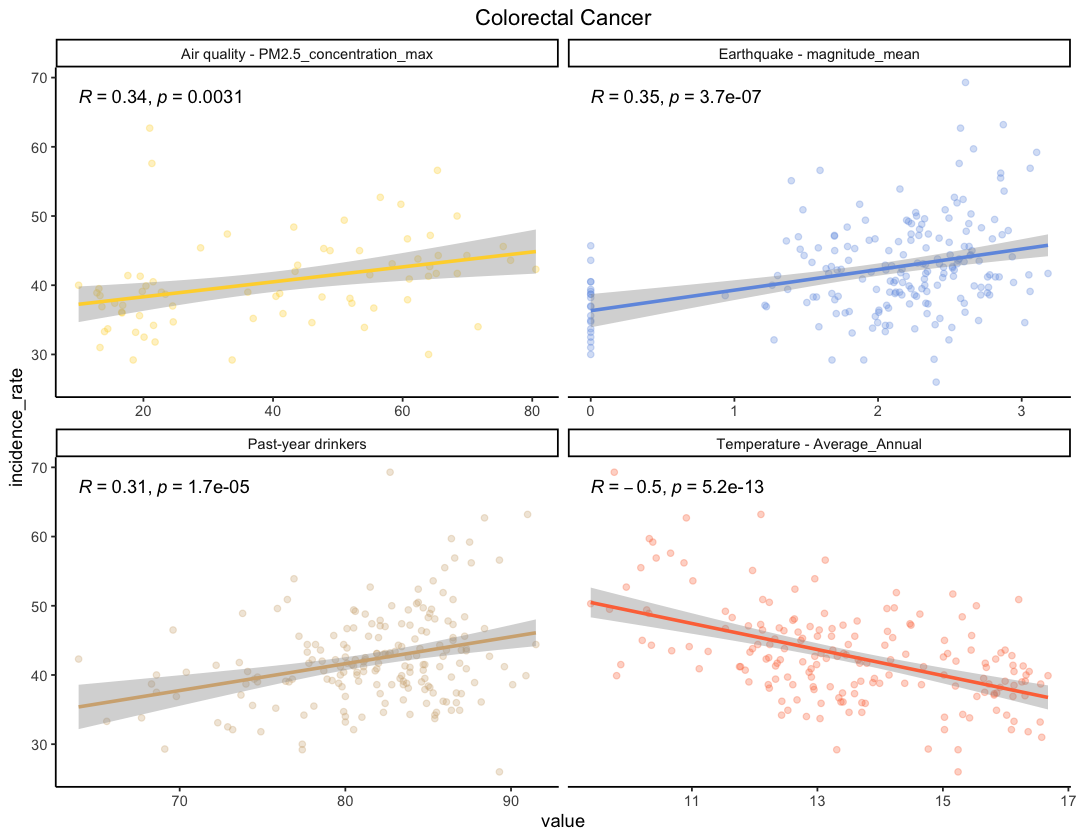

In [6]:
corplot.CRC

`geom_smooth()` using formula = 'y ~ x'


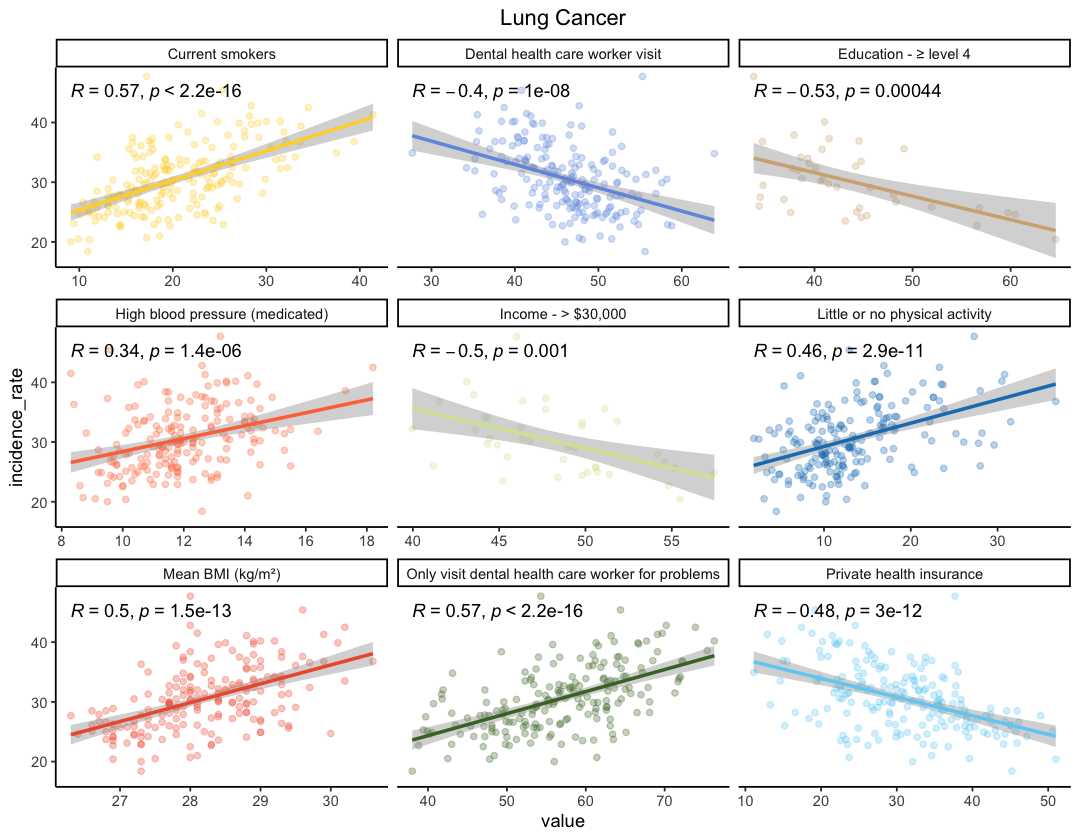

In [7]:
corplot.Lung